In [ ]:
!pip install fedartml
!pip install -q flwr[simulation]

In [ ]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

from io import BytesIO
import requests

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.optimizers import SGD

from flwr.simulation.ray_transport.utils import enable_tf_gpu_growth
enable_tf_gpu_growth()

import time
import pickle

import pandas as pd

import matplotlib.pyplot as plt

# Garbage Collector - use it like gc.collect()
import gc

# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

from fedartml import InteractivePlots, SplitAsFederatedData

# Make TensorFlow logs less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import flwr as fl
from scipy.stats import cramervonmises

from typing import List, Tuple, Dict, Optional
from flwr.common import Metrics

In [ ]:
# Define function to test a model and retrieve classification metrics
def test_model(model, X_test, Y_test):
    cce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False)
    logits = model.predict(X_test, batch_size=16, verbose=2, callbacks=[GarbageCollectorCallback()])
    y_pred = tf.argmax(logits, axis=1)
    loss = cce(Y_test, logits).numpy()
    acc = accuracy_score(y_pred, Y_test)
    pre = precision_score(y_pred, Y_test, average='weighted',zero_division = 0)
    rec = recall_score(y_pred, Y_test, average='weighted',zero_division = 0)
    f1s = f1_score(y_pred, Y_test, average='weighted',zero_division = 0)

    return loss, acc, pre, rec, f1s

# Define function to convert from SplitAsFederatedData function output (FedArtML) to Flower (list) format
def from_FedArtML_to_Flower_format(clients_dict):
  # initialize list that contains clients (features and labels) to extract later from client_fn in Flower
  list_x_train = []
  list_y_train = []

  # Get the name of the clients from the dictionary
  client_names = list(clients_dict.keys())

  # Iterate over each client
  for client in client_names:
    # Get data from each client
    each_client_train=np.array(clients_dict[client],dtype=object)

    # Extract features for each client
    feat=[]
    x_tra=np.array(each_client_train[:, 0])
    for row in x_tra:
      feat.append(row)
    feat=np.array(feat)

    # Extract labels from each client
    y_tra=np.array(each_client_train[:, 1])

    # Append in list features and labels to extract later from client_fn in Flower
    list_x_train.append(feat)
    list_y_train.append(y_tra)

  return list_x_train, list_y_train

def get_model():
    """Constructs a simple model architecture suitable for MNIST."""
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1)),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D(16, kernel_size=(5, 5), activation='relu'),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(120, activation='relu'),
            tf.keras.layers.Dense(84, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax')

        ]
    )
    return model


# Define local training/evaluation function
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, model, x_train, y_train, x_test, y_test, epochs_client) -> None:
        self.model = model
        self.x_train, self.y_train = x_train, y_train
        self.x_test, self.y_test = x_test, y_test
        self.epochs_client = epochs_client

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        self.model.fit(self.x_train, self.y_train, validation_split=0.1, epochs=self.epochs_client, verbose=2, batch_size = 16, callbacks=[GarbageCollectorCallback()])
        return self.model.get_weights(), len(self.x_train), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        loss, acc = self.model.evaluate(self.x_test, self.y_test, verbose=2)
        return loss, len(self.x_test), {"accuracy": acc}


def plot_metric_from_history(
    hist: None,
    save_plot_path: None,
    metric_type: None,
    metric: None,
) -> None:
    """Function to plot from Flower server History.
    Parameters
    ----------
    hist : History
        Object containing evaluation for all rounds.
    save_plot_path : Path
        Folder to save the plot to.
    metric_type : Literal["centralized", "distributed"]
        Type of metric to plot.
    metric : Literal["accuracy","precision","recall","f1score"]
        Metric to plot.
    """
    metric_dict = (
        hist.metrics_centralized
        if metric_type == "centralized"
        else hist.metrics_distributed
    )
    rounds, values = zip(*metric_dict[metric])
    # plt.plot(np.asarray(rounds), np.asarray(values), label="FedAvg")
    plt.plot(np.asarray(rounds), np.asarray(values), color=colors[5], linewidth=5, label='Test')
    plt.legend(fontsize=45)
    plt.xlabel('Communication round', fontsize=40)
    plt.ylabel(metric, fontsize=50)
    plt.title(metric, fontsize=60)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    # plt.ylim(min(min(min(commun_metrics))) - 0.05, max(max(max(commun_metrics))) + 0.05)
    plt.ylim(0, 1)
    # plt.savefig(Path(save_plot_path) / Path(f"{metric_type}_metrics{suffix}.png"))
    # plt.close()

def retrieve_global_metrics(
    hist: None,
    metric_type: None,
    metric: None,
    best_metric: None,
) -> None:
    """Function to plot from Flower server History.
    Parameters
    ----------
    hist : History
        Object containing evaluation for all rounds.
    metric_type : Literal["centralized", "distributed"]
        Type of metric to retrieve.
    metric : Literal["accuracy","precision","recall","f1score"]
        Metric to retrieve.
    """
    metric_dict = (
        hist.metrics_centralized
        if metric_type == "centralized"
        else hist.metrics_distributed
    )
    rounds, values = zip(*metric_dict[metric])
    if best_metric:
      metric_return = max(values)
    else:
      metric_return = values[-1]
    return metric_return

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from flwr.server.client_manager import ClientManager
import threading
from abc import ABC, abstractmethod
from logging import INFO
from typing import Dict, List, Optional
import random
from flwr.server.client_proxy import ClientProxy
from flwr.server.criterion import Criterion

class SimpleClientManager(ClientManager):
    def __init__(self) -> None:
        self.clients: Dict[str, ClientProxy] = {}
        self._cv = threading.Condition()
        self.seed = 0

    def __len__(self) -> int:
        return len(self.clients)

    def num_available(self) -> int:
        return len(self)

    def wait_for(self, num_clients: int, timeout: int = 86400) -> bool:
        with self._cv:
            return self._cv.wait_for(
                lambda: len(self.clients) >= num_clients, timeout=timeout
            )

    def register(self, client: ClientProxy) -> bool:
        if client.cid in self.clients:
            return False

        self.clients[client.cid] = client
        with self._cv:
            self._cv.notify_all()

        return True

    def unregister(self, client: ClientProxy) -> None:
        if client.cid in self.clients:
            del self.clients[client.cid]

            with self._cv:
                self._cv.notify_all()

    def all(self) -> Dict[str, ClientProxy]:
        return self.clients

    def sample(
        self,
        num_clients: int,
        min_num_clients: Optional[int] = None,
        criterion: Optional[Criterion] = None,
    ) -> List[ClientProxy]:
        """Sample a number of Flower ClientProxy instances."""
        # Block until at least num_clients are connected.
        random.seed(self.seed)
        self.seed += 1
        if min_num_clients is None:
            min_num_clients = num_clients
        self.wait_for(min_num_clients)
        # Sample clients which meet the criterion
        available_cids = list(self.clients)
        if criterion is not None:
            available_cids = [
                cid for cid in available_cids if criterion.select(self.clients[cid])
            ]

        sampled_cids = random.sample(available_cids, num_clients)
        #print(sampled_cids)
        return [self.clients[cid] for cid in sampled_cids]

In [ ]:
# Define random state for reproducibility
random_state = 0

# Define colors to use in plots
colors = ["#00cfcc","#e6013b","#007f88","#00cccd","#69e0da","darkblue","#FFFFFF"]

# Define number of local nodes to be used
local_nodes_glob = 20

# Define percentage of noniid to be used
Percent_noniid = 1000

Alpha = 1

In [ ]:
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.utils import to_categorical

# Define random state for reproducibility
random_state = 0

# Tải dữ liệu MNIST
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255
# Instantiate a SplitAsFederatedData object
my_federater = SplitAsFederatedData(random_state = random_state)

# Get federated dataset from centralized dataset
clients_glob_dic, list_ids_sampled_dic, miss_class_per_node, distances = my_federater.create_clients(image_list = train_images, label_list = train_labels,
                                                             num_clients = local_nodes_glob, prefix_cli='client', method = "dirichlet", alpha = Alpha)

clients_glob = clients_glob_dic['with_class_completion']
list_ids_sampled = list_ids_sampled_dic['with_class_completion']

list_x_train, list_y_train = from_FedArtML_to_Flower_format(clients_dict=clients_glob)


11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
# The `evaluate` function will be by Flower called after every round
def evaluate_DNN_CL(
    server_round: int,
    parameters: fl.common.NDArrays,
    config: Dict[str, fl.common.Scalar],
) -> Optional[Tuple[float, Dict[str, fl.common.Scalar]]]:
    net = get_model()
    net.set_weights(parameters) # Update model with the latest parameters
    loss, accuracy, precision, recall, f1score  = test_model(net, test_images, test_labels)
    print(f"@@@@@@ Server-side evaluation loss {loss} / accuracy {accuracy} / f1score {f1score} @@@@@@")
    return loss, {"accuracy": accuracy,"precision": precision,"recall": recall,"f1score": f1score}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from flwr.common import (
    FitRes,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)

# Define number of epochs per local node
epochs = 1

# Define number of communication rounds
comms_round = 300
seed_value = 42
tf.random.set_seed(seed_value)
initial_model = get_model()
# Define dunction to pass to each local node (client)
def client_fn(cid: str) -> fl.client.Client:
    # Define model
    seed_value = 42
    tf.random.set_seed(seed_value)
    model = get_model()

    # Load data partition of each client ID (cid)
    x_train_cid = np.array(list_x_train[int(cid)],dtype=float)
    y_train_cid = np.array(list_y_train[int(cid)],dtype=float)

    # Define test data (taken from the centralized data to compare performance of CL and FL)
    x_test_cid = np.array(test_images)
    y_test_cid = np.array(test_labels)

    # Create and return client
    return FlowerClient(model, x_train_cid, y_train_cid, x_test_cid, y_test_cid, epochs)

# Create Federated strategy
strategy= fl.server.strategy.FedAvgM(
        fraction_fit=0.3,  # Sample 100% of available clients for training
        fraction_evaluate=0.05,  # Sample 50% of available clients for evaluation
        min_fit_clients=6,
        min_evaluate_clients = 1,
        min_available_clients = 20,
        evaluate_fn=evaluate_DNN_CL,
        server_momentum = 0.9,
        initial_parameters  = ndarrays_to_parameters(initial_model.get_weights())
)
client_manager = SimpleClientManager()

start_time = time.time()
# Start simulation (training FL)
commun_metrics_history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=local_nodes_glob,
    config=fl.server.ServerConfig(num_rounds=comms_round),
    strategy=strategy,
)

# Get total training time
training_time = time.time() - start_time

# Unmask metrics
global_acc_test = retrieve_global_metrics(commun_metrics_history,"centralized","accuracy",True)

global_pre_test = retrieve_global_metrics(commun_metrics_history,"centralized","precision",True)

global_rec_test = retrieve_global_metrics(commun_metrics_history,"centralized","recall",True)

global_f1s_test = retrieve_global_metrics(commun_metrics_history,"centralized","f1score",True)

print("\n\nFINAL RESULTS: ===========================================================================================================================================================================================")
print('Test: commun_round: {} | global_acc: {:} | global_pre: {} | global_rec: {} | global_f1s: {}'.format(comms_round, global_acc_test, global_pre_test, global_rec_test, global_f1s_test))
print("Training time: %s seconds" % (training_time))

INFO flwr 2024-02-23 10:29:55,872 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=300, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=300, round_timeout=None)
2024-02-23 10:30:03,405	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-02-23 10:30:08,393 | app.py:213 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'memory': 7819451598.0, 'object_store_memory': 3909725798.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'memory': 7819451598.0, 'object_store_memory': 3909725798.0}
INFO flwr 2024-02-23 10:30:08,414 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-02-23

625/625 - 7s - 7s/epoch - 11ms/step


INFO flwr 2024-02-23 10:30:17,068 | server.py:94 | initial parameters (loss, other metrics): 2.3110805, {'accuracy': 0.0706, 'precision': 0.30047321272087885, 'recall': 0.0706, 'f1score': 0.10511815627766388}
INFO:flwr:initial parameters (loss, other metrics): 2.3110805, {'accuracy': 0.0706, 'precision': 0.30047321272087885, 'recall': 0.0706, 'f1score': 0.10511815627766388}
INFO flwr 2024-02-23 10:30:17,072 | server.py:104 | FL starting
INFO:flwr:FL starting
DEBUG flwr 2024-02-23 10:30:17,086 | server.py:222 | fit_round 1: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 1: strategy sampled 6 clients (out of 20)


@@@@@@ Server-side evaluation loss 2.3110804557800293 / accuracy 0.0706 / f1score 0.10511815627766388 @@@@@@


(DefaultActor pid=864) /usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower.
(DefaultActor pid=864)   client = check_clientfn_returns_client(client_fn(cid))


(DefaultActor pid=863) 159/159 - 5s - loss: 1.8613 - accuracy: 0.3919 - val_loss: 1.2308 - val_accuracy: 0.7234 - 5s/epoch - 34ms/step
(DefaultActor pid=864) 217/217 - 4s - loss: 1.0404 - accuracy: 0.7098 - val_loss: 0.7356 - val_accuracy: 0.8031 - 4s/epoch - 19ms/step [repeated 3x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)


DEBUG flwr 2024-02-23 10:30:54,036 | server.py:236 | fit_round 1 received 6 results and 0 failures
DEBUG:flwr:fit_round 1 received 6 results and 0 failures
WARNING flwr 2024-02-23 10:30:54,056 | fedavgm.py:198 | No fit_metrics_aggregation_fn provided


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 10:30:57,798 | server.py:125 | fit progress: (1, 2.049425, {'accuracy': 0.4163, 'precision': 0.6963303623631164, 'recall': 0.4163, 'f1score': 0.4770538989205952}, 40.71150088899998)
INFO:flwr:fit progress: (1, 2.049425, {'accuracy': 0.4163, 'precision': 0.6963303623631164, 'recall': 0.4163, 'f1score': 0.4770538989205952}, 40.71150088899998)
DEBUG flwr 2024-02-23 10:30:57,802 | server.py:173 | evaluate_round 1: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 1: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 2.049424886703491 / accuracy 0.4163 / f1score 0.4770538989205952 @@@@@@


DEBUG flwr 2024-02-23 10:30:59,896 | server.py:187 | evaluate_round 1 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 1 results and 0 failures
WARNING flwr 2024-02-23 10:30:59,900 | fedavg.py:281 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2024-02-23 10:30:59,903 | server.py:222 | fit_round 2: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 2: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 2.0494 - accuracy: 0.4163 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 249/249 - 4s - loss: 1.2043 - accuracy: 0.6145 - val_loss: 0.5356 - val_accuracy: 0.8262 - 4s/epoch - 16ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 175/175 - 4s - loss: 0.7799 - accuracy: 0.7576 - val_loss: 0.9374 - val_accuracy: 0.7331 - 4s/epoch - 25ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-23 10:31:14,539 | server.py:236 | fit_round 2 received 6 results and 0 failures
DEBUG:flwr:fit_round 2 received 6 results and 0 failures


(DefaultActor pid=864) 221/221 - 4s - loss: 0.4877 - accuracy: 0.8512 - val_loss: 0.2693 - val_accuracy: 0.9313 - 4s/epoch - 19ms/step [repeated 3x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:31:16,974 | server.py:125 | fit progress: (2, 3.8242204, {'accuracy': 0.5358, 'precision': 0.864093433626789, 'recall': 0.5358, 'f1score': 0.5903135640216787}, 59.88751763399998)
INFO:flwr:fit progress: (2, 3.8242204, {'accuracy': 0.5358, 'precision': 0.864093433626789, 'recall': 0.5358, 'f1score': 0.5903135640216787}, 59.88751763399998)
DEBUG flwr 2024-02-23 10:31:16,979 | server.py:173 | evaluate_round 2: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 2: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 3.8242204189300537 / accuracy 0.5358 / f1score 0.5903135640216787 @@@@@@


DEBUG flwr 2024-02-23 10:31:19,080 | server.py:187 | evaluate_round 2 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:31:19,083 | server.py:222 | fit_round 3: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 3: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 4.3850 - accuracy: 0.5358 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 116/116 - 4s - loss: 0.6899 - accuracy: 0.8209 - val_loss: 0.3834 - val_accuracy: 0.8738 - 4s/epoch - 36ms/step
(DefaultActor pid=863) 170/170 - 5s - loss: 0.4993 - accuracy: 0.8815 - val_loss: 0.3472 - val_accuracy: 0.9040 - 5s/epoch - 28ms/step


DEBUG flwr 2024-02-23 10:31:32,793 | server.py:236 | fit_round 3 received 6 results and 0 failures
DEBUG:flwr:fit_round 3 received 6 results and 0 failures


(DefaultActor pid=864) 195/195 - 4s - loss: 0.4441 - accuracy: 0.8852 - val_loss: 0.3042 - val_accuracy: 0.8876 - 4s/epoch - 20ms/step [repeated 3x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:31:35,169 | server.py:125 | fit progress: (3, 2.7016356, {'accuracy': 0.7223, 'precision': 0.8774666619453073, 'recall': 0.7223, 'f1score': 0.7555906069044651}, 78.08256065999998)
INFO:flwr:fit progress: (3, 2.7016356, {'accuracy': 0.7223, 'precision': 0.8774666619453073, 'recall': 0.7223, 'f1score': 0.7555906069044651}, 78.08256065999998)
DEBUG flwr 2024-02-23 10:31:35,176 | server.py:173 | evaluate_round 3: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 3: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 2.7016355991363525 / accuracy 0.7223 / f1score 0.7555906069044651 @@@@@@


DEBUG flwr 2024-02-23 10:31:38,410 | server.py:187 | evaluate_round 3 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:31:38,417 | server.py:222 | fit_round 4: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 4: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 3s - loss: 3.0918 - accuracy: 0.7223 - 3s/epoch - 9ms/step
(DefaultActor pid=863) 159/159 - 3s - loss: 0.6388 - accuracy: 0.8279 - val_loss: 0.2693 - val_accuracy: 0.9149 - 3s/epoch - 21ms/step
(DefaultActor pid=864) 112/112 - 3s - loss: 0.5231 - accuracy: 0.8953 - val_loss: 0.3466 - val_accuracy: 0.9196 - 3s/epoch - 26ms/step
(DefaultActor pid=863) 159/159 - 5s - loss: 0.6060 - accuracy: 0.8623 - val_loss: 0.1817 - val_accuracy: 0.9362 - 5s/epoch - 29ms/step [repeated 4x across cluster]


DEBUG flwr 2024-02-23 10:31:51,709 | server.py:236 | fit_round 4 received 6 results and 0 failures
DEBUG:flwr:fit_round 4 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:31:54,250 | server.py:125 | fit progress: (4, 1.3100638, {'accuracy': 0.7415, 'precision': 0.8453825108242938, 'recall': 0.7415, 'f1score': 0.7443299888855531}, 97.163605765)
INFO:flwr:fit progress: (4, 1.3100638, {'accuracy': 0.7415, 'precision': 0.8453825108242938, 'recall': 0.7415, 'f1score': 0.7443299888855531}, 97.163605765)
DEBUG flwr 2024-02-23 10:31:54,254 | server.py:173 | evaluate_round 4: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 4: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 1.3100638389587402 / accuracy 0.7415 / f1score 0.7443299888855531 @@@@@@


DEBUG flwr 2024-02-23 10:31:56,303 | server.py:187 | evaluate_round 4 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:31:56,308 | server.py:222 | fit_round 5: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 5: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 1.3467 - accuracy: 0.7415 - 2s/epoch - 5ms/step
(DefaultActor pid=864) 170/170 - 4s - loss: 0.2414 - accuracy: 0.9341 - val_loss: 0.2047 - val_accuracy: 0.9371 - 4s/epoch - 21ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 151/151 - 5s - loss: 0.3215 - accuracy: 0.9113 - val_loss: 0.2805 - val_accuracy: 0.9219 - 5s/epoch - 35ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 10:32:10,249 | server.py:236 | fit_round 5 received 6 results and 0 failures
DEBUG:flwr:fit_round 5 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:32:13,080 | server.py:125 | fit progress: (5, 0.48530293, {'accuracy': 0.8387, 'precision': 0.8527981357628031, 'recall': 0.8387, 'f1score': 0.8365127572445495}, 115.99356780999997)
INFO:flwr:fit progress: (5, 0.48530293, {'accuracy': 0.8387, 'precision': 0.8527981357628031, 'recall': 0.8387, 'f1score': 0.8365127572445495}, 115.99356780999997)
DEBUG flwr 2024-02-23 10:32:13,089 | server.py:173 | evaluate_round 5: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 5: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.4853029251098633 / accuracy 0.8387 / f1score 0.8365127572445495 @@@@@@


DEBUG flwr 2024-02-23 10:32:15,214 | server.py:187 | evaluate_round 5 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:32:15,218 | server.py:222 | fit_round 6: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 6: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.4853 - accuracy: 0.8387 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 169/169 - 3s - loss: 0.3513 - accuracy: 0.9104 - val_loss: 0.2764 - val_accuracy: 0.9231 - 3s/epoch - 21ms/step [repeated 3x across cluster]
(DefaultActor pid=864) 175/175 - 7s - loss: 0.2625 - accuracy: 0.9194 - val_loss: 0.3177 - val_accuracy: 0.9032 - 7s/epoch - 38ms/step
(DefaultActor pid=863) 170/170 - 7s - loss: 0.3228 - accuracy: 0.9047 - val_loss: 0.1921 - val_accuracy: 0.9336 - 7s/epoch - 39ms/step
(DefaultActor pid=863) 151/151 - 3s - loss: 0.2349 - accuracy: 0.9283 - val_loss: 0.2301 - val_accuracy: 0.9331 - 3s/epoch - 23ms/step
(DefaultActor pid=864) 217/217 - 4s - loss: 0.1166 - accuracy: 0.9616 - val_loss: 0.1337 - val_accuracy: 0.9585 - 4s/epoch - 20ms/step
(DefaultActor pid=863) 195/195 - 5s - loss: 0.2108 - accuracy: 0.9339 - val_loss: 0.2331 - val_accuracy: 0.9366 - 5s/epoch - 27ms/step


DEBUG flwr 2024-02-23 10:32:33,404 | server.py:236 | fit_round 6 received 6 results and 0 failures
DEBUG:flwr:fit_round 6 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:32:36,368 | server.py:125 | fit progress: (6, 0.655762, {'accuracy': 0.7786, 'precision': 0.855169454415323, 'recall': 0.7786, 'f1score': 0.7897336475840344}, 139.28178438899997)
INFO:flwr:fit progress: (6, 0.655762, {'accuracy': 0.7786, 'precision': 0.855169454415323, 'recall': 0.7786, 'f1score': 0.7897336475840344}, 139.28178438899997)
DEBUG flwr 2024-02-23 10:32:36,375 | server.py:173 | evaluate_round 6: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 6: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.6557620167732239 / accuracy 0.7786 / f1score 0.7897336475840344 @@@@@@


DEBUG flwr 2024-02-23 10:32:38,531 | server.py:187 | evaluate_round 6 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:32:38,536 | server.py:222 | fit_round 7: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 7: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.6558 - accuracy: 0.7786 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 170/170 - 5s - loss: 0.1767 - accuracy: 0.9514 - val_loss: 0.2565 - val_accuracy: 0.9437 - 5s/epoch - 29ms/step
(DefaultActor pid=863) 116/116 - 3s - loss: 0.2724 - accuracy: 0.9159 - val_loss: 0.1823 - val_accuracy: 0.9175 - 3s/epoch - 26ms/step
(DefaultActor pid=863) 159/159 - 5s - loss: 0.2655 - accuracy: 0.9128 - val_loss: 0.1332 - val_accuracy: 0.9539 - 5s/epoch - 33ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 10:32:52,726 | server.py:236 | fit_round 7 received 6 results and 0 failures
DEBUG:flwr:fit_round 7 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:32:55,201 | server.py:125 | fit progress: (7, 0.3915628, {'accuracy': 0.8733, 'precision': 0.9005055211340975, 'recall': 0.8733, 'f1score': 0.8767797354111857}, 158.114508982)
INFO:flwr:fit progress: (7, 0.3915628, {'accuracy': 0.8733, 'precision': 0.9005055211340975, 'recall': 0.8733, 'f1score': 0.8767797354111857}, 158.114508982)
DEBUG flwr 2024-02-23 10:32:55,205 | server.py:173 | evaluate_round 7: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 7: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.3915627896785736 / accuracy 0.8733 / f1score 0.8767797354111857 @@@@@@


DEBUG flwr 2024-02-23 10:32:57,282 | server.py:187 | evaluate_round 7 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:32:57,285 | server.py:222 | fit_round 8: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 8: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.3916 - accuracy: 0.8733 - 2s/epoch - 5ms/step
(DefaultActor pid=863) 221/221 - 4s - loss: 0.1549 - accuracy: 0.9518 - val_loss: 0.1582 - val_accuracy: 0.9644 - 4s/epoch - 19ms/step [repeated 3x across cluster]
(DefaultActor pid=863) 179/179 - 8s - loss: 0.1941 - accuracy: 0.9404 - val_loss: 0.1775 - val_accuracy: 0.9527 - 8s/epoch - 42ms/step
(DefaultActor pid=864) 217/217 - 8s - loss: 0.0889 - accuracy: 0.9732 - val_loss: 0.0713 - val_accuracy: 0.9663 - 8s/epoch - 36ms/step
(DefaultActor pid=864) 112/112 - 3s - loss: 0.1690 - accuracy: 0.9479 - val_loss: 0.0960 - val_accuracy: 0.9698 - 3s/epoch - 26ms/step
(DefaultActor pid=864) 170/170 - 4s - loss: 0.1412 - accuracy: 0.9584 - val_loss: 0.1741 - val_accuracy: 0.9536 - 4s/epoch - 22ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 10:33:14,352 | server.py:236 | fit_round 8 received 6 results and 0 failures
DEBUG:flwr:fit_round 8 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 10:33:19,846 | server.py:125 | fit progress: (8, 0.34811646, {'accuracy': 0.9014, 'precision': 0.9152368009135252, 'recall': 0.9014, 'f1score': 0.9039015782677696}, 182.759691118)
INFO:flwr:fit progress: (8, 0.34811646, {'accuracy': 0.9014, 'precision': 0.9152368009135252, 'recall': 0.9014, 'f1score': 0.9039015782677696}, 182.759691118)
DEBUG flwr 2024-02-23 10:33:19,851 | server.py:173 | evaluate_round 8: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 8: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.3481164574623108 / accuracy 0.9014 / f1score 0.9039015782677696 @@@@@@


DEBUG flwr 2024-02-23 10:33:21,940 | server.py:187 | evaluate_round 8 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:33:21,944 | server.py:222 | fit_round 9: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 9: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.3483 - accuracy: 0.9014 - 2s/epoch - 5ms/step
(DefaultActor pid=863) 170/170 - 3s - loss: 0.2500 - accuracy: 0.9257 - val_loss: 0.1907 - val_accuracy: 0.9402 - 3s/epoch - 21ms/step
(DefaultActor pid=864) 159/159 - 4s - loss: 0.2293 - accuracy: 0.9341 - val_loss: 0.1145 - val_accuracy: 0.9610 - 4s/epoch - 22ms/step
(DefaultActor pid=864) 131/131 - 5s - loss: 0.1864 - accuracy: 0.9469 - val_loss: 0.1933 - val_accuracy: 0.9485 - 5s/epoch - 36ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 10:33:36,043 | server.py:236 | fit_round 9 received 6 results and 0 failures
DEBUG:flwr:fit_round 9 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:33:38,869 | server.py:125 | fit progress: (9, 0.28600958, {'accuracy': 0.923, 'precision': 0.9297471713057034, 'recall': 0.923, 'f1score': 0.923869849436152}, 201.782815189)
INFO:flwr:fit progress: (9, 0.28600958, {'accuracy': 0.923, 'precision': 0.9297471713057034, 'recall': 0.923, 'f1score': 0.923869849436152}, 201.782815189)
DEBUG flwr 2024-02-23 10:33:38,874 | server.py:173 | evaluate_round 9: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 9: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.2860095798969269 / accuracy 0.923 / f1score 0.923869849436152 @@@@@@


DEBUG flwr 2024-02-23 10:33:41,223 | server.py:187 | evaluate_round 9 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:33:41,228 | server.py:222 | fit_round 10: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 10: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.2862 - accuracy: 0.9230 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 151/151 - 3s - loss: 0.1959 - accuracy: 0.9440 - val_loss: 0.1483 - val_accuracy: 0.9517 - 3s/epoch - 21ms/step [repeated 3x across cluster]
(DefaultActor pid=864) 151/151 - 4s - loss: 0.1700 - accuracy: 0.9552 - val_loss: 0.1595 - val_accuracy: 0.9665 - 4s/epoch - 28ms/step
(DefaultActor pid=863) 156/156 - 4s - loss: 0.1831 - accuracy: 0.9490 - val_loss: 0.1791 - val_accuracy: 0.9422 - 4s/epoch - 28ms/step
(DefaultActor pid=863) 170/170 - 4s - loss: 0.2163 - accuracy: 0.9413 - val_loss: 0.1682 - val_accuracy: 0.9502 - 4s/epoch - 25ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-23 10:33:56,126 | server.py:236 | fit_round 10 received 6 results and 0 failures
DEBUG:flwr:fit_round 10 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-23 10:33:59,061 | server.py:125 | fit progress: (10, 0.22446933, {'accuracy': 0.9405, 'precision': 0.9422594332717031, 'recall': 0.9405, 'f1score': 0.9405101092787276}, 221.974932817)
INFO:flwr:fit progress: (10, 0.22446933, {'accuracy': 0.9405, 'precision': 0.9422594332717031, 'recall': 0.9405, 'f1score': 0.9405101092787276}, 221.974932817)
DEBUG flwr 2024-02-23 10:33:59,066 | server.py:173 | evaluate_round 10: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 10: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.22446933388710022 / accuracy 0.9405 / f1score 0.9405101092787276 @@@@@@


DEBUG flwr 2024-02-23 10:34:01,200 | server.py:187 | evaluate_round 10 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:34:01,204 | server.py:222 | fit_round 11: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 11: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.2245 - accuracy: 0.9405 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 221/221 - 5s - loss: 0.1179 - accuracy: 0.9683 - val_loss: 0.1707 - val_accuracy: 0.9669 - 5s/epoch - 22ms/step
(DefaultActor pid=864) 131/131 - 3s - loss: 0.1428 - accuracy: 0.9584 - val_loss: 0.1622 - val_accuracy: 0.9614 - 3s/epoch - 25ms/step
(DefaultActor pid=863) 175/175 - 5s - loss: 0.1230 - accuracy: 0.9600 - val_loss: 0.1352 - val_accuracy: 0.9582 - 5s/epoch - 28ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-23 10:34:15,359 | server.py:236 | fit_round 11 received 6 results and 0 failures
DEBUG:flwr:fit_round 11 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:34:17,700 | server.py:125 | fit progress: (11, 0.2018342, {'accuracy': 0.9417, 'precision': 0.9430427578563394, 'recall': 0.9417, 'f1score': 0.9412964618438904}, 240.61374268899996)
INFO:flwr:fit progress: (11, 0.2018342, {'accuracy': 0.9417, 'precision': 0.9430427578563394, 'recall': 0.9417, 'f1score': 0.9412964618438904}, 240.61374268899996)
DEBUG flwr 2024-02-23 10:34:17,706 | server.py:173 | evaluate_round 11: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 11: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.20183420181274414 / accuracy 0.9417 / f1score 0.9412964618438904 @@@@@@


DEBUG flwr 2024-02-23 10:34:19,777 | server.py:187 | evaluate_round 11 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 11 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:34:19,781 | server.py:222 | fit_round 12: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 12: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.2018 - accuracy: 0.9417 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 179/179 - 4s - loss: 0.1413 - accuracy: 0.9597 - val_loss: 0.1590 - val_accuracy: 0.9590 - 4s/epoch - 20ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 135/135 - 5s - loss: 0.1959 - accuracy: 0.9380 - val_loss: 0.2771 - val_accuracy: 0.9540 - 5s/epoch - 35ms/step
(DefaultActor pid=863) 169/169 - 5s - loss: 0.1562 - accuracy: 0.9502 - val_loss: 0.1807 - val_accuracy: 0.9431 - 5s/epoch - 32ms/step
(DefaultActor pid=863) 112/112 - 3s - loss: 0.1308 - accuracy: 0.9642 - val_loss: 0.0665 - val_accuracy: 0.9698 - 3s/epoch - 26ms/step
(DefaultActor pid=863) 221/221 - 4s - loss: 0.0897 - accuracy: 0.9762 - val_loss: 0.1328 - val_accuracy: 0.9618 - 4s/epoch - 20ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 10:34:34,609 | server.py:236 | fit_round 12 received 6 results and 0 failures
DEBUG:flwr:fit_round 12 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 4ms/step


INFO flwr 2024-02-23 10:34:39,995 | server.py:125 | fit progress: (12, 0.18526192, {'accuracy': 0.9437, 'precision': 0.9453456252178137, 'recall': 0.9437, 'f1score': 0.9438497070927003}, 262.909476381)
INFO:flwr:fit progress: (12, 0.18526192, {'accuracy': 0.9437, 'precision': 0.9453456252178137, 'recall': 0.9437, 'f1score': 0.9438497070927003}, 262.909476381)
DEBUG flwr 2024-02-23 10:34:40,001 | server.py:173 | evaluate_round 12: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 12: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.18526192009449005 / accuracy 0.9437 / f1score 0.9438497070927003 @@@@@@


DEBUG flwr 2024-02-23 10:34:42,107 | server.py:187 | evaluate_round 12 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 12 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:34:42,112 | server.py:222 | fit_round 13: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 13: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1855 - accuracy: 0.9437 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 249/249 - 4s - loss: 0.0741 - accuracy: 0.9756 - val_loss: 0.1451 - val_accuracy: 0.9661 - 4s/epoch - 18ms/step
(DefaultActor pid=863) 159/159 - 4s - loss: 0.1571 - accuracy: 0.9530 - val_loss: 0.0863 - val_accuracy: 0.9752 - 4s/epoch - 22ms/step
(DefaultActor pid=864) 151/151 - 5s - loss: 0.1340 - accuracy: 0.9610 - val_loss: 0.1178 - val_accuracy: 0.9703 - 5s/epoch - 31ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-23 10:34:56,785 | server.py:236 | fit_round 13 received 6 results and 0 failures
DEBUG:flwr:fit_round 13 received 6 results and 0 failures


(DefaultActor pid=864) 249/249 - 4s - loss: 0.0580 - accuracy: 0.9814 - val_loss: 0.1289 - val_accuracy: 0.9639 - 4s/epoch - 17ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:34:59,178 | server.py:125 | fit progress: (13, 0.19909918, {'accuracy': 0.9389, 'precision': 0.9423934159481827, 'recall': 0.9389, 'f1score': 0.9392686544723367}, 282.09220163199996)
INFO:flwr:fit progress: (13, 0.19909918, {'accuracy': 0.9389, 'precision': 0.9423934159481827, 'recall': 0.9389, 'f1score': 0.9392686544723367}, 282.09220163199996)
DEBUG flwr 2024-02-23 10:34:59,182 | server.py:173 | evaluate_round 13: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 13: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.19909918308258057 / accuracy 0.9389 / f1score 0.9392686544723367 @@@@@@


DEBUG flwr 2024-02-23 10:35:01,291 | server.py:187 | evaluate_round 13 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 13 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:35:01,297 | server.py:222 | fit_round 14: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 14: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1992 - accuracy: 0.9389 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 182/182 - 6s - loss: 0.1292 - accuracy: 0.9611 - val_loss: 0.1350 - val_accuracy: 0.9599 - 6s/epoch - 30ms/step
(DefaultActor pid=863) 173/173 - 5s - loss: 0.0984 - accuracy: 0.9691 - val_loss: 0.1965 - val_accuracy: 0.9412 - 5s/epoch - 32ms/step
(DefaultActor pid=863) 135/135 - 3s - loss: 0.1516 - accuracy: 0.9478 - val_loss: 0.2226 - val_accuracy: 0.9498 - 3s/epoch - 24ms/step


DEBUG flwr 2024-02-23 10:35:15,391 | server.py:236 | fit_round 14 received 6 results and 0 failures
DEBUG:flwr:fit_round 14 received 6 results and 0 failures


(DefaultActor pid=864) 116/116 - 3s - loss: 0.1431 - accuracy: 0.9542 - val_loss: 0.1425 - val_accuracy: 0.9515 - 3s/epoch - 26ms/step [repeated 2x across cluster]
625/625 - 3s - 3s/epoch - 4ms/step


INFO flwr 2024-02-23 10:35:20,763 | server.py:125 | fit progress: (14, 0.1912776, {'accuracy': 0.9427, 'precision': 0.9477594900464392, 'recall': 0.9427, 'f1score': 0.9435242221862632}, 303.67703957899994)
INFO:flwr:fit progress: (14, 0.1912776, {'accuracy': 0.9427, 'precision': 0.9477594900464392, 'recall': 0.9427, 'f1score': 0.9435242221862632}, 303.67703957899994)
DEBUG flwr 2024-02-23 10:35:20,771 | server.py:173 | evaluate_round 14: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 14: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.19127759337425232 / accuracy 0.9427 / f1score 0.9435242221862632 @@@@@@


DEBUG flwr 2024-02-23 10:35:22,880 | server.py:187 | evaluate_round 14 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 14 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:35:22,885 | server.py:222 | fit_round 15: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 15: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1913 - accuracy: 0.9427 - 2s/epoch - 5ms/step
(DefaultActor pid=863) 169/169 - 4s - loss: 0.1074 - accuracy: 0.9669 - val_loss: 0.2249 - val_accuracy: 0.9431 - 4s/epoch - 22ms/step
(DefaultActor pid=863) 175/175 - 4s - loss: 0.1398 - accuracy: 0.9584 - val_loss: 0.1281 - val_accuracy: 0.9581 - 4s/epoch - 21ms/step
(DefaultActor pid=864) 159/159 - 5s - loss: 0.1316 - accuracy: 0.9605 - val_loss: 0.0751 - val_accuracy: 0.9752 - 5s/epoch - 34ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 10:35:37,415 | server.py:236 | fit_round 15 received 6 results and 0 failures
DEBUG:flwr:fit_round 15 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:35:40,236 | server.py:125 | fit progress: (15, 0.17815572, {'accuracy': 0.9491, 'precision': 0.9527698318437062, 'recall': 0.9491, 'f1score': 0.9495000720472327}, 323.14986947599994)
INFO:flwr:fit progress: (15, 0.17815572, {'accuracy': 0.9491, 'precision': 0.9527698318437062, 'recall': 0.9491, 'f1score': 0.9495000720472327}, 323.14986947599994)
DEBUG flwr 2024-02-23 10:35:40,239 | server.py:173 | evaluate_round 15: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 15: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.17815572023391724 / accuracy 0.9491 / f1score 0.9495000720472327 @@@@@@


DEBUG flwr 2024-02-23 10:35:42,295 | server.py:187 | evaluate_round 15 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 15 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:35:42,299 | server.py:222 | fit_round 16: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 16: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1782 - accuracy: 0.9491 - 2s/epoch - 5ms/step
(DefaultActor pid=863) 150/150 - 3s - loss: 0.1532 - accuracy: 0.9585 - val_loss: 0.1672 - val_accuracy: 0.9586 - 3s/epoch - 21ms/step [repeated 3x across cluster]
(DefaultActor pid=864) 151/151 - 5s - loss: 0.1213 - accuracy: 0.9639 - val_loss: 0.1067 - val_accuracy: 0.9703 - 5s/epoch - 33ms/step
(DefaultActor pid=863) 175/175 - 6s - loss: 0.1251 - accuracy: 0.9591 - val_loss: 0.1147 - val_accuracy: 0.9645 - 6s/epoch - 33ms/step


DEBUG flwr 2024-02-23 10:35:56,435 | server.py:236 | fit_round 16 received 6 results and 0 failures
DEBUG:flwr:fit_round 16 received 6 results and 0 failures


(DefaultActor pid=864) 179/179 - 4s - loss: 0.0931 - accuracy: 0.9741 - val_loss: 0.0955 - val_accuracy: 0.9748 - 4s/epoch - 22ms/step [repeated 3x across cluster]
625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 10:36:01,882 | server.py:125 | fit progress: (16, 0.15531589, {'accuracy': 0.9564, 'precision': 0.9572124138800351, 'recall': 0.9564, 'f1score': 0.9563952483450945}, 344.795838193)
INFO:flwr:fit progress: (16, 0.15531589, {'accuracy': 0.9564, 'precision': 0.9572124138800351, 'recall': 0.9564, 'f1score': 0.9563952483450945}, 344.795838193)
DEBUG flwr 2024-02-23 10:36:01,889 | server.py:173 | evaluate_round 16: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 16: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.15531589090824127 / accuracy 0.9564 / f1score 0.9563952483450945 @@@@@@


DEBUG flwr 2024-02-23 10:36:03,965 | server.py:187 | evaluate_round 16 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 16 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:36:03,968 | server.py:222 | fit_round 17: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 17: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1553 - accuracy: 0.9564 - 2s/epoch - 5ms/step
(DefaultActor pid=863) 170/170 - 4s - loss: 0.0773 - accuracy: 0.9775 - val_loss: 0.0907 - val_accuracy: 0.9801 - 4s/epoch - 22ms/step
(DefaultActor pid=864) 173/173 - 4s - loss: 0.0825 - accuracy: 0.9749 - val_loss: 0.1485 - val_accuracy: 0.9542 - 4s/epoch - 22ms/step
(DefaultActor pid=863) 116/116 - 5s - loss: 0.1150 - accuracy: 0.9617 - val_loss: 0.0873 - val_accuracy: 0.9709 - 5s/epoch - 42ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 10:36:18,369 | server.py:236 | fit_round 17 received 6 results and 0 failures
DEBUG:flwr:fit_round 17 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:36:21,215 | server.py:125 | fit progress: (17, 0.1444217, {'accuracy': 0.9584, 'precision': 0.9587640276323022, 'recall': 0.9584, 'f1score': 0.9583602757861256}, 364.1291994239999)
INFO:flwr:fit progress: (17, 0.1444217, {'accuracy': 0.9584, 'precision': 0.9587640276323022, 'recall': 0.9584, 'f1score': 0.9583602757861256}, 364.1291994239999)
DEBUG flwr 2024-02-23 10:36:21,219 | server.py:173 | evaluate_round 17: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 17: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.14442169666290283 / accuracy 0.9584 / f1score 0.9583602757861256 @@@@@@


DEBUG flwr 2024-02-23 10:36:23,259 | server.py:187 | evaluate_round 17 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 17 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:36:23,262 | server.py:222 | fit_round 18: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 18: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1444 - accuracy: 0.9584 - 2s/epoch - 5ms/step
(DefaultActor pid=864) 135/135 - 3s - loss: 0.1026 - accuracy: 0.9646 - val_loss: 0.1840 - val_accuracy: 0.9498 - 3s/epoch - 24ms/step [repeated 3x across cluster]
(DefaultActor pid=864) 135/135 - 5s - loss: 0.0902 - accuracy: 0.9664 - val_loss: 0.1658 - val_accuracy: 0.9540 - 5s/epoch - 37ms/step
(DefaultActor pid=863) 173/173 - 6s - loss: 0.0776 - accuracy: 0.9786 - val_loss: 0.1394 - val_accuracy: 0.9608 - 6s/epoch - 33ms/step
(DefaultActor pid=863) 112/112 - 3s - loss: 0.0898 - accuracy: 0.9748 - val_loss: 0.0975 - val_accuracy: 0.9698 - 3s/epoch - 27ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-23 10:36:37,975 | server.py:236 | fit_round 18 received 6 results and 0 failures
DEBUG:flwr:fit_round 18 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 10:36:41,770 | server.py:125 | fit progress: (18, 0.13342094, {'accuracy': 0.9614, 'precision': 0.9620213265874742, 'recall': 0.9614, 'f1score': 0.9613225550976331}, 384.683660938)
INFO:flwr:fit progress: (18, 0.13342094, {'accuracy': 0.9614, 'precision': 0.9620213265874742, 'recall': 0.9614, 'f1score': 0.9613225550976331}, 384.683660938)
DEBUG flwr 2024-02-23 10:36:41,774 | server.py:173 | evaluate_round 18: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 18: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.1334209442138672 / accuracy 0.9614 / f1score 0.9613225550976331 @@@@@@


DEBUG flwr 2024-02-23 10:36:43,946 | server.py:187 | evaluate_round 18 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 18 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:36:43,949 | server.py:222 | fit_round 19: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 19: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1334 - accuracy: 0.9614 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 221/221 - 4s - loss: 0.0665 - accuracy: 0.9827 - val_loss: 0.0942 - val_accuracy: 0.9771 - 4s/epoch - 19ms/step
(DefaultActor pid=864) 175/175 - 4s - loss: 0.0718 - accuracy: 0.9767 - val_loss: 0.1330 - val_accuracy: 0.9645 - 4s/epoch - 22ms/step
(DefaultActor pid=863) 182/182 - 5s - loss: 0.1061 - accuracy: 0.9670 - val_loss: 0.1116 - val_accuracy: 0.9691 - 5s/epoch - 27ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 10:36:58,395 | server.py:236 | fit_round 19 received 6 results and 0 failures
DEBUG:flwr:fit_round 19 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:37:01,235 | server.py:125 | fit progress: (19, 0.13005704, {'accuracy': 0.9648, 'precision': 0.9655858599521853, 'recall': 0.9648, 'f1score': 0.9648540614257447}, 404.14904816399996)
INFO:flwr:fit progress: (19, 0.13005704, {'accuracy': 0.9648, 'precision': 0.9655858599521853, 'recall': 0.9648, 'f1score': 0.9648540614257447}, 404.14904816399996)
DEBUG flwr 2024-02-23 10:37:01,241 | server.py:173 | evaluate_round 19: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 19: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.13005703687667847 / accuracy 0.9648 / f1score 0.9648540614257447 @@@@@@


DEBUG flwr 2024-02-23 10:37:03,393 | server.py:187 | evaluate_round 19 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 19 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:37:03,396 | server.py:222 | fit_round 20: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 20: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1301 - accuracy: 0.9648 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 150/150 - 4s - loss: 0.1018 - accuracy: 0.9702 - val_loss: 0.1826 - val_accuracy: 0.9662 - 4s/epoch - 24ms/step [repeated 3x across cluster]
(DefaultActor pid=863) 175/175 - 5s - loss: 0.0521 - accuracy: 0.9832 - val_loss: 0.0433 - val_accuracy: 0.9871 - 5s/epoch - 31ms/step
(DefaultActor pid=864) 169/169 - 6s - loss: 0.0749 - accuracy: 0.9755 - val_loss: 0.1677 - val_accuracy: 0.9465 - 6s/epoch - 33ms/step
(DefaultActor pid=864) 175/175 - 4s - loss: 0.0623 - accuracy: 0.9814 - val_loss: 0.1180 - val_accuracy: 0.9677 - 4s/epoch - 22ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-23 10:37:19,267 | server.py:236 | fit_round 20 received 6 results and 0 failures
DEBUG:flwr:fit_round 20 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 10:37:24,761 | server.py:125 | fit progress: (20, 0.13183884, {'accuracy': 0.9638, 'precision': 0.9648475371201345, 'recall': 0.9638, 'f1score': 0.9639090088177783}, 427.6746976999999)
INFO:flwr:fit progress: (20, 0.13183884, {'accuracy': 0.9638, 'precision': 0.9648475371201345, 'recall': 0.9638, 'f1score': 0.9639090088177783}, 427.6746976999999)
DEBUG flwr 2024-02-23 10:37:24,767 | server.py:173 | evaluate_round 20: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 20: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.1318388432264328 / accuracy 0.9638 / f1score 0.9639090088177783 @@@@@@


DEBUG flwr 2024-02-23 10:37:26,873 | server.py:187 | evaluate_round 20 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 20 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:37:26,877 | server.py:222 | fit_round 21: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 21: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1319 - accuracy: 0.9638 - 2s/epoch - 5ms/step
(DefaultActor pid=863) 249/249 - 5s - loss: 0.0468 - accuracy: 0.9869 - val_loss: 0.1169 - val_accuracy: 0.9819 - 5s/epoch - 19ms/step
(DefaultActor pid=863) 150/150 - 3s - loss: 0.0836 - accuracy: 0.9732 - val_loss: 0.1868 - val_accuracy: 0.9699 - 3s/epoch - 23ms/step
(DefaultActor pid=863) 159/159 - 7s - loss: 0.1017 - accuracy: 0.9696 - val_loss: 0.0656 - val_accuracy: 0.9752 - 7s/epoch - 44ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 10:37:43,584 | server.py:236 | fit_round 21 received 6 results and 0 failures
DEBUG:flwr:fit_round 21 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:37:46,404 | server.py:125 | fit progress: (21, 0.12299431, {'accuracy': 0.9642, 'precision': 0.9651873560193502, 'recall': 0.9642, 'f1score': 0.9643156797518905}, 449.31782847399995)
INFO:flwr:fit progress: (21, 0.12299431, {'accuracy': 0.9642, 'precision': 0.9651873560193502, 'recall': 0.9642, 'f1score': 0.9643156797518905}, 449.31782847399995)
DEBUG flwr 2024-02-23 10:37:46,409 | server.py:173 | evaluate_round 21: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 21: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.1229943111538887 / accuracy 0.9642 / f1score 0.9643156797518905 @@@@@@


DEBUG flwr 2024-02-23 10:37:48,966 | server.py:187 | evaluate_round 21 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 21 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:37:48,973 | server.py:222 | fit_round 22: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 22: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1233 - accuracy: 0.9642 - 2s/epoch - 7ms/step
(DefaultActor pid=864) 182/182 - 3s - loss: 0.0850 - accuracy: 0.9725 - val_loss: 0.0929 - val_accuracy: 0.9599 - 3s/epoch - 16ms/step [repeated 3x across cluster]
(DefaultActor pid=863) 170/170 - 5s - loss: 0.1149 - accuracy: 0.9631 - val_loss: 0.0947 - val_accuracy: 0.9601 - 5s/epoch - 27ms/step
(DefaultActor pid=864) 175/175 - 5s - loss: 0.0512 - accuracy: 0.9828 - val_loss: 0.0506 - val_accuracy: 0.9839 - 5s/epoch - 26ms/step
(DefaultActor pid=864) 156/156 - 4s - loss: 0.1039 - accuracy: 0.9695 - val_loss: 0.1380 - val_accuracy: 0.9639 - 4s/epoch - 23ms/step
(DefaultActor pid=863) 175/175 - 5s - loss: 0.0560 - accuracy: 0.9832 - val_loss: 0.1109 - val_accuracy: 0.9710 - 5s/epoch - 31ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 10:38:05,775 | server.py:236 | fit_round 22 received 6 results and 0 failures
DEBUG:flwr:fit_round 22 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:38:08,613 | server.py:125 | fit progress: (22, 0.11510216, {'accuracy': 0.9669, 'precision': 0.9675843248172478, 'recall': 0.9669, 'f1score': 0.9669583232912697}, 471.527041384)
INFO:flwr:fit progress: (22, 0.11510216, {'accuracy': 0.9669, 'precision': 0.9675843248172478, 'recall': 0.9669, 'f1score': 0.9669583232912697}, 471.527041384)
DEBUG flwr 2024-02-23 10:38:08,617 | server.py:173 | evaluate_round 22: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 22: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.11510215699672699 / accuracy 0.9669 / f1score 0.9669583232912697 @@@@@@


DEBUG flwr 2024-02-23 10:38:10,735 | server.py:187 | evaluate_round 22 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 22 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:38:10,740 | server.py:222 | fit_round 23: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 23: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1155 - accuracy: 0.9669 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 249/249 - 7s - loss: 0.0332 - accuracy: 0.9912 - val_loss: 0.1056 - val_accuracy: 0.9797 - 7s/epoch - 26ms/step
(DefaultActor pid=863) 169/169 - 4s - loss: 0.0645 - accuracy: 0.9766 - val_loss: 0.1621 - val_accuracy: 0.9532 - 4s/epoch - 22ms/step
(DefaultActor pid=863) 151/151 - 5s - loss: 0.0849 - accuracy: 0.9739 - val_loss: 0.0806 - val_accuracy: 0.9703 - 5s/epoch - 34ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 10:38:26,016 | server.py:236 | fit_round 23 received 6 results and 0 failures
DEBUG:flwr:fit_round 23 received 6 results and 0 failures


(DefaultActor pid=864) 217/217 - 4s - loss: 0.0500 - accuracy: 0.9856 - val_loss: 0.0465 - val_accuracy: 0.9896 - 4s/epoch - 20ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:38:28,843 | server.py:125 | fit progress: (23, 0.10177385, {'accuracy': 0.9707, 'precision': 0.9709094151961384, 'recall': 0.9707, 'f1score': 0.9707137847117873}, 491.75652413699993)
INFO:flwr:fit progress: (23, 0.10177385, {'accuracy': 0.9707, 'precision': 0.9709094151961384, 'recall': 0.9707, 'f1score': 0.9707137847117873}, 491.75652413699993)
DEBUG flwr 2024-02-23 10:38:28,847 | server.py:173 | evaluate_round 23: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 23: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10177385061979294 / accuracy 0.9707 / f1score 0.9707137847117873 @@@@@@


DEBUG flwr 2024-02-23 10:38:31,981 | server.py:187 | evaluate_round 23 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 23 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:38:31,988 | server.py:222 | fit_round 24: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 24: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 3s - loss: 0.1018 - accuracy: 0.9707 - 3s/epoch - 9ms/step
(DefaultActor pid=863) 249/249 - 5s - loss: 0.0280 - accuracy: 0.9920 - val_loss: 0.1125 - val_accuracy: 0.9752 - 5s/epoch - 19ms/step
(DefaultActor pid=863) 179/179 - 4s - loss: 0.0410 - accuracy: 0.9860 - val_loss: 0.0876 - val_accuracy: 0.9748 - 4s/epoch - 22ms/step
(DefaultActor pid=863) 173/173 - 5s - loss: 0.0531 - accuracy: 0.9807 - val_loss: 0.1374 - val_accuracy: 0.9706 - 5s/epoch - 31ms/step [repeated 4x across cluster]


DEBUG flwr 2024-02-23 10:38:46,885 | server.py:236 | fit_round 24 received 6 results and 0 failures
DEBUG:flwr:fit_round 24 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:38:49,713 | server.py:125 | fit progress: (24, 0.11021926, {'accuracy': 0.9698, 'precision': 0.970311816597492, 'recall': 0.9698, 'f1score': 0.969721026667827}, 512.626622292)
INFO:flwr:fit progress: (24, 0.11021926, {'accuracy': 0.9698, 'precision': 0.970311816597492, 'recall': 0.9698, 'f1score': 0.969721026667827}, 512.626622292)
DEBUG flwr 2024-02-23 10:38:49,717 | server.py:173 | evaluate_round 24: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 24: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.11021926254034042 / accuracy 0.9698 / f1score 0.969721026667827 @@@@@@


DEBUG flwr 2024-02-23 10:38:51,781 | server.py:187 | evaluate_round 24 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 24 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:38:51,788 | server.py:222 | fit_round 25: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 25: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1103 - accuracy: 0.9698 - 2s/epoch - 5ms/step
(DefaultActor pid=864) 150/150 - 5s - loss: 0.0682 - accuracy: 0.9803 - val_loss: 0.1692 - val_accuracy: 0.9662 - 5s/epoch - 34ms/step
(DefaultActor pid=863) 173/173 - 4s - loss: 0.0430 - accuracy: 0.9826 - val_loss: 0.1438 - val_accuracy: 0.9641 - 4s/epoch - 22ms/step
(DefaultActor pid=864) 131/131 - 5s - loss: 0.0848 - accuracy: 0.9751 - val_loss: 0.0803 - val_accuracy: 0.9742 - 5s/epoch - 37ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 10:39:07,360 | server.py:236 | fit_round 25 received 6 results and 0 failures
DEBUG:flwr:fit_round 25 received 6 results and 0 failures


(DefaultActor pid=863) 221/221 - 3s - loss: 0.0287 - accuracy: 0.9906 - val_loss: 0.0826 - val_accuracy: 0.9746 - 3s/epoch - 16ms/step [repeated 3x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:39:10,226 | server.py:125 | fit progress: (25, 0.13347907, {'accuracy': 0.962, 'precision': 0.9641806326458633, 'recall': 0.962, 'f1score': 0.9621609836958224}, 533.139896561)
INFO:flwr:fit progress: (25, 0.13347907, {'accuracy': 0.962, 'precision': 0.9641806326458633, 'recall': 0.962, 'f1score': 0.9621609836958224}, 533.139896561)
DEBUG flwr 2024-02-23 10:39:10,231 | server.py:173 | evaluate_round 25: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 25: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.1334790736436844 / accuracy 0.962 / f1score 0.9621609836958224 @@@@@@


DEBUG flwr 2024-02-23 10:39:13,424 | server.py:187 | evaluate_round 25 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 25 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:39:13,429 | server.py:222 | fit_round 26: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 26: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 3s - loss: 0.1337 - accuracy: 0.9620 - 3s/epoch - 9ms/step
(DefaultActor pid=863) 135/135 - 3s - loss: 0.0670 - accuracy: 0.9804 - val_loss: 0.1229 - val_accuracy: 0.9749 - 3s/epoch - 25ms/step
(DefaultActor pid=863) 179/179 - 6s - loss: 0.0437 - accuracy: 0.9860 - val_loss: 0.0883 - val_accuracy: 0.9748 - 6s/epoch - 32ms/step [repeated 4x across cluster]


DEBUG flwr 2024-02-23 10:39:28,151 | server.py:236 | fit_round 26 received 6 results and 0 failures
DEBUG:flwr:fit_round 26 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:39:30,557 | server.py:125 | fit progress: (26, 0.107275344, {'accuracy': 0.9699, 'precision': 0.9709672609318982, 'recall': 0.9699, 'f1score': 0.970064936802881}, 553.470484896)
INFO:flwr:fit progress: (26, 0.107275344, {'accuracy': 0.9699, 'precision': 0.9709672609318982, 'recall': 0.9699, 'f1score': 0.970064936802881}, 553.470484896)
DEBUG flwr 2024-02-23 10:39:30,563 | server.py:173 | evaluate_round 26: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 26: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.1072753444314003 / accuracy 0.9699 / f1score 0.970064936802881 @@@@@@


DEBUG flwr 2024-02-23 10:39:32,672 | server.py:187 | evaluate_round 26 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 26 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:39:32,676 | server.py:222 | fit_round 27: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 27: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1074 - accuracy: 0.9699 - 2s/epoch - 5ms/step
(DefaultActor pid=864) 159/159 - 4s - loss: 0.0871 - accuracy: 0.9747 - val_loss: 0.0465 - val_accuracy: 0.9787 - 4s/epoch - 23ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 169/169 - 5s - loss: 0.0543 - accuracy: 0.9807 - val_loss: 0.1094 - val_accuracy: 0.9666 - 5s/epoch - 31ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 10:39:48,349 | server.py:236 | fit_round 27 received 6 results and 0 failures
DEBUG:flwr:fit_round 27 received 6 results and 0 failures


(DefaultActor pid=863) 195/195 - 3s - loss: 0.0700 - accuracy: 0.9801 - val_loss: 0.0548 - val_accuracy: 0.9827 - 3s/epoch - 17ms/step [repeated 3x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:39:51,186 | server.py:125 | fit progress: (27, 0.11098849, {'accuracy': 0.9671, 'precision': 0.9682308402532576, 'recall': 0.9671, 'f1score': 0.9671533880838491}, 574.099879355)
INFO:flwr:fit progress: (27, 0.11098849, {'accuracy': 0.9671, 'precision': 0.9682308402532576, 'recall': 0.9671, 'f1score': 0.9671533880838491}, 574.099879355)
DEBUG flwr 2024-02-23 10:39:51,191 | server.py:173 | evaluate_round 27: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 27: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.11098849028348923 / accuracy 0.9671 / f1score 0.9671533880838491 @@@@@@


DEBUG flwr 2024-02-23 10:39:54,492 | server.py:187 | evaluate_round 27 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 27 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:39:54,496 | server.py:222 | fit_round 28: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 28: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 3s - loss: 0.1110 - accuracy: 0.9671 - 3s/epoch - 9ms/step
(DefaultActor pid=863) 131/131 - 3s - loss: 0.0668 - accuracy: 0.9813 - val_loss: 0.0641 - val_accuracy: 0.9828 - 3s/epoch - 26ms/step
(DefaultActor pid=864) 175/175 - 5s - loss: 0.0495 - accuracy: 0.9832 - val_loss: 0.0622 - val_accuracy: 0.9774 - 5s/epoch - 28ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-23 10:40:10,931 | server.py:236 | fit_round 28 received 6 results and 0 failures
DEBUG:flwr:fit_round 28 received 6 results and 0 failures


(DefaultActor pid=864) 195/195 - 5s - loss: 0.0611 - accuracy: 0.9811 - val_loss: 0.0540 - val_accuracy: 0.9798 - 5s/epoch - 26ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:40:13,278 | server.py:125 | fit progress: (28, 0.11932388, {'accuracy': 0.9651, 'precision': 0.9666958217936357, 'recall': 0.9651, 'f1score': 0.9650315673540177}, 596.192086724)
INFO:flwr:fit progress: (28, 0.11932388, {'accuracy': 0.9651, 'precision': 0.9666958217936357, 'recall': 0.9651, 'f1score': 0.9650315673540177}, 596.192086724)
DEBUG flwr 2024-02-23 10:40:13,282 | server.py:173 | evaluate_round 28: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 28: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.11932387948036194 / accuracy 0.9651 / f1score 0.9650315673540177 @@@@@@


DEBUG flwr 2024-02-23 10:40:15,384 | server.py:187 | evaluate_round 28 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 28 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:40:15,390 | server.py:222 | fit_round 29: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 29: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1193 - accuracy: 0.9651 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 150/150 - 4s - loss: 0.0625 - accuracy: 0.9820 - val_loss: 0.1237 - val_accuracy: 0.9699 - 4s/epoch - 29ms/step
(DefaultActor pid=864) 249/249 - 6s - loss: 0.0150 - accuracy: 0.9957 - val_loss: 0.0718 - val_accuracy: 0.9797 - 6s/epoch - 24ms/step
(DefaultActor pid=863) 135/135 - 3s - loss: 0.0495 - accuracy: 0.9860 - val_loss: 0.1348 - val_accuracy: 0.9623 - 3s/epoch - 25ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-23 10:40:30,510 | server.py:236 | fit_round 29 received 6 results and 0 failures
DEBUG:flwr:fit_round 29 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:40:33,027 | server.py:125 | fit progress: (29, 0.093231045, {'accuracy': 0.9721, 'precision': 0.9725608548172416, 'recall': 0.9721, 'f1score': 0.972060250961141}, 615.940534653)
INFO:flwr:fit progress: (29, 0.093231045, {'accuracy': 0.9721, 'precision': 0.9725608548172416, 'recall': 0.9721, 'f1score': 0.972060250961141}, 615.940534653)
DEBUG flwr 2024-02-23 10:40:33,033 | server.py:173 | evaluate_round 29: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 29: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09323104470968246 / accuracy 0.9721 / f1score 0.972060250961141 @@@@@@


DEBUG flwr 2024-02-23 10:40:36,175 | server.py:187 | evaluate_round 29 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 29 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:40:36,178 | server.py:222 | fit_round 30: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 30: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 3s - loss: 0.0932 - accuracy: 0.9721 - 3s/epoch - 8ms/step
(DefaultActor pid=864) 173/173 - 3s - loss: 0.0337 - accuracy: 0.9902 - val_loss: 0.1110 - val_accuracy: 0.9706 - 3s/epoch - 20ms/step
(DefaultActor pid=864) 150/150 - 4s - loss: 0.0554 - accuracy: 0.9811 - val_loss: 0.1159 - val_accuracy: 0.9662 - 4s/epoch - 24ms/step
(DefaultActor pid=864) 249/249 - 5s - loss: 0.0138 - accuracy: 0.9952 - val_loss: 0.0771 - val_accuracy: 0.9774 - 5s/epoch - 19ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-23 10:40:51,490 | server.py:236 | fit_round 30 received 6 results and 0 failures
DEBUG:flwr:fit_round 30 received 6 results and 0 failures


(DefaultActor pid=864) 179/179 - 5s - loss: 0.0348 - accuracy: 0.9898 - val_loss: 0.1036 - val_accuracy: 0.9874 - 5s/epoch - 29ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:40:53,953 | server.py:125 | fit progress: (30, 0.08895899, {'accuracy': 0.9747, 'precision': 0.9749359552678365, 'recall': 0.9747, 'f1score': 0.974685065106297}, 636.867309503)
INFO:flwr:fit progress: (30, 0.08895899, {'accuracy': 0.9747, 'precision': 0.9749359552678365, 'recall': 0.9747, 'f1score': 0.974685065106297}, 636.867309503)
DEBUG flwr 2024-02-23 10:40:53,963 | server.py:173 | evaluate_round 30: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 30: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.0889589935541153 / accuracy 0.9747 / f1score 0.974685065106297 @@@@@@


DEBUG flwr 2024-02-23 10:40:56,029 | server.py:187 | evaluate_round 30 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 30 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:40:56,035 | server.py:222 | fit_round 31: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 31: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.0890 - accuracy: 0.9747 - 2s/epoch - 5ms/step
(DefaultActor pid=864) 112/112 - 3s - loss: 0.0534 - accuracy: 0.9860 - val_loss: 0.0779 - val_accuracy: 0.9749 - 3s/epoch - 28ms/step
(DefaultActor pid=863) 151/151 - 4s - loss: 0.0571 - accuracy: 0.9822 - val_loss: 0.0846 - val_accuracy: 0.9814 - 4s/epoch - 26ms/step
(DefaultActor pid=864) 170/170 - 5s - loss: 0.0611 - accuracy: 0.9801 - val_loss: 0.0617 - val_accuracy: 0.9767 - 5s/epoch - 32ms/step
(DefaultActor pid=863) 131/131 - 5s - loss: 0.0503 - accuracy: 0.9847 - val_loss: 0.0664 - val_accuracy: 0.9828 - 5s/epoch - 36ms/step


DEBUG flwr 2024-02-23 10:41:10,738 | server.py:236 | fit_round 31 received 6 results and 0 failures
DEBUG:flwr:fit_round 31 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:41:13,161 | server.py:125 | fit progress: (31, 0.08112237, {'accuracy': 0.9762, 'precision': 0.9763463623401547, 'recall': 0.9762, 'f1score': 0.9761906169933408}, 656.0750986119999)
INFO:flwr:fit progress: (31, 0.08112237, {'accuracy': 0.9762, 'precision': 0.9763463623401547, 'recall': 0.9762, 'f1score': 0.9761906169933408}, 656.0750986119999)
DEBUG flwr 2024-02-23 10:41:13,165 | server.py:173 | evaluate_round 31: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 31: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.08112236857414246 / accuracy 0.9762 / f1score 0.9761906169933408 @@@@@@


DEBUG flwr 2024-02-23 10:41:16,110 | server.py:187 | evaluate_round 31 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 31 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:41:16,119 | server.py:222 | fit_round 32: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 32: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 3s - loss: 0.0811 - accuracy: 0.9762 - 3s/epoch - 8ms/step
(DefaultActor pid=863) 195/195 - 4s - loss: 0.0487 - accuracy: 0.9843 - val_loss: 0.0453 - val_accuracy: 0.9856 - 4s/epoch - 21ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 217/217 - 5s - loss: 0.0257 - accuracy: 0.9919 - val_loss: 0.0314 - val_accuracy: 0.9922 - 5s/epoch - 22ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 112/112 - 4s - loss: 0.0515 - accuracy: 0.9871 - val_loss: 0.0739 - val_accuracy: 0.9799 - 4s/epoch - 36ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-23 10:41:31,041 | server.py:236 | fit_round 32 received 6 results and 0 failures
DEBUG:flwr:fit_round 32 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:41:33,904 | server.py:125 | fit progress: (32, 0.08049207, {'accuracy': 0.9767, 'precision': 0.9769301700730979, 'recall': 0.9767, 'f1score': 0.9767077475172098}, 676.818201246)
INFO:flwr:fit progress: (32, 0.08049207, {'accuracy': 0.9767, 'precision': 0.9769301700730979, 'recall': 0.9767, 'f1score': 0.9767077475172098}, 676.818201246)
DEBUG flwr 2024-02-23 10:41:33,910 | server.py:173 | evaluate_round 32: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 32: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.08049207180738449 / accuracy 0.9767 / f1score 0.9767077475172098 @@@@@@


DEBUG flwr 2024-02-23 10:41:36,021 | server.py:187 | evaluate_round 32 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 32 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:41:36,025 | server.py:222 | fit_round 33: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 33: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.0805 - accuracy: 0.9767 - 2s/epoch - 5ms/step
(DefaultActor pid=863) 169/169 - 4s - loss: 0.0437 - accuracy: 0.9870 - val_loss: 0.0905 - val_accuracy: 0.9766 - 4s/epoch - 26ms/step
(DefaultActor pid=863) 135/135 - 3s - loss: 0.0378 - accuracy: 0.9874 - val_loss: 0.1082 - val_accuracy: 0.9791 - 3s/epoch - 25ms/step
(DefaultActor pid=863) 249/249 - 6s - loss: 0.0139 - accuracy: 0.9965 - val_loss: 0.0777 - val_accuracy: 0.9819 - 6s/epoch - 25ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 10:41:52,067 | server.py:236 | fit_round 33 received 6 results and 0 failures
DEBUG:flwr:fit_round 33 received 6 results and 0 failures


(DefaultActor pid=864) 173/173 - 4s - loss: 0.0276 - accuracy: 0.9916 - val_loss: 0.0916 - val_accuracy: 0.9804 - 4s/epoch - 20ms/step [repeated 3x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:41:54,915 | server.py:125 | fit progress: (33, 0.09207585, {'accuracy': 0.9728, 'precision': 0.9734343707927208, 'recall': 0.9728, 'f1score': 0.972816979963063}, 697.828663422)
INFO:flwr:fit progress: (33, 0.09207585, {'accuracy': 0.9728, 'precision': 0.9734343707927208, 'recall': 0.9728, 'f1score': 0.972816979963063}, 697.828663422)
DEBUG flwr 2024-02-23 10:41:54,920 | server.py:173 | evaluate_round 33: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 33: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09207584708929062 / accuracy 0.9728 / f1score 0.972816979963063 @@@@@@


DEBUG flwr 2024-02-23 10:41:58,222 | server.py:187 | evaluate_round 33 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 33 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:41:58,231 | server.py:222 | fit_round 34: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 34: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 3s - loss: 0.0921 - accuracy: 0.9728 - 3s/epoch - 9ms/step
(DefaultActor pid=863) 156/156 - 4s - loss: 0.0428 - accuracy: 0.9863 - val_loss: 0.1184 - val_accuracy: 0.9639 - 4s/epoch - 24ms/step
(DefaultActor pid=864) 173/173 - 6s - loss: 0.0254 - accuracy: 0.9913 - val_loss: 0.0851 - val_accuracy: 0.9739 - 6s/epoch - 35ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 135/135 - 4s - loss: 0.0360 - accuracy: 0.9879 - val_loss: 0.1079 - val_accuracy: 0.9791 - 4s/epoch - 31ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 10:42:14,887 | server.py:236 | fit_round 34 received 6 results and 0 failures
DEBUG:flwr:fit_round 34 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:42:17,736 | server.py:125 | fit progress: (34, 0.07967687, {'accuracy': 0.9765, 'precision': 0.9767785867426985, 'recall': 0.9765, 'f1score': 0.9765144748307588}, 720.650338931)
INFO:flwr:fit progress: (34, 0.07967687, {'accuracy': 0.9765, 'precision': 0.9767785867426985, 'recall': 0.9765, 'f1score': 0.9765144748307588}, 720.650338931)
DEBUG flwr 2024-02-23 10:42:17,744 | server.py:173 | evaluate_round 34: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 34: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.07967686653137207 / accuracy 0.9765 / f1score 0.9765144748307588 @@@@@@


DEBUG flwr 2024-02-23 10:42:19,835 | server.py:187 | evaluate_round 34 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 34 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:42:19,838 | server.py:222 | fit_round 35: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 35: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.0797 - accuracy: 0.9765 - 2s/epoch - 5ms/step
(DefaultActor pid=863) 170/170 - 4s - loss: 0.0371 - accuracy: 0.9875 - val_loss: 0.0296 - val_accuracy: 0.9868 - 4s/epoch - 26ms/step
(DefaultActor pid=864) 170/170 - 6s - loss: 0.0454 - accuracy: 0.9841 - val_loss: 0.0611 - val_accuracy: 0.9767 - 6s/epoch - 32ms/step
(DefaultActor pid=863) 131/131 - 3s - loss: 0.0430 - accuracy: 0.9880 - val_loss: 0.0341 - val_accuracy: 0.9871 - 3s/epoch - 26ms/step [repeated 4x across cluster]


DEBUG flwr 2024-02-23 10:42:34,955 | server.py:236 | fit_round 35 received 6 results and 0 failures
DEBUG:flwr:fit_round 35 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 4ms/step


INFO flwr 2024-02-23 10:42:38,339 | server.py:125 | fit progress: (35, 0.0700045, {'accuracy': 0.9789, 'precision': 0.9790073637818768, 'recall': 0.9789, 'f1score': 0.9788955820046922}, 741.25298413)
INFO:flwr:fit progress: (35, 0.0700045, {'accuracy': 0.9789, 'precision': 0.9790073637818768, 'recall': 0.9789, 'f1score': 0.9788955820046922}, 741.25298413)
DEBUG flwr 2024-02-23 10:42:38,343 | server.py:173 | evaluate_round 35: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 35: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.07000450044870377 / accuracy 0.9789 / f1score 0.9788955820046922 @@@@@@


DEBUG flwr 2024-02-23 10:42:40,609 | server.py:187 | evaluate_round 35 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 35 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:42:40,614 | server.py:222 | fit_round 36: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 36: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.0700 - accuracy: 0.9789 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 179/179 - 4s - loss: 0.0270 - accuracy: 0.9919 - val_loss: 0.0827 - val_accuracy: 0.9905 - 4s/epoch - 22ms/step
(DefaultActor pid=864) 151/151 - 4s - loss: 0.0484 - accuracy: 0.9851 - val_loss: 0.0995 - val_accuracy: 0.9703 - 4s/epoch - 25ms/step
(DefaultActor pid=863) 170/170 - 5s - loss: 0.0308 - accuracy: 0.9901 - val_loss: 0.0353 - val_accuracy: 0.9868 - 5s/epoch - 30ms/step [repeated 4x across cluster]


DEBUG flwr 2024-02-23 10:42:55,975 | server.py:236 | fit_round 36 received 6 results and 0 failures
DEBUG:flwr:fit_round 36 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:42:58,317 | server.py:125 | fit progress: (36, 0.0678979, {'accuracy': 0.98, 'precision': 0.9800668764620879, 'recall': 0.98, 'f1score': 0.9799998835012685}, 761.2309597269999)
INFO:flwr:fit progress: (36, 0.0678979, {'accuracy': 0.98, 'precision': 0.9800668764620879, 'recall': 0.98, 'f1score': 0.9799998835012685}, 761.2309597269999)
DEBUG flwr 2024-02-23 10:42:58,323 | server.py:173 | evaluate_round 36: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 36: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.06789790093898773 / accuracy 0.98 / f1score 0.9799998835012685 @@@@@@


DEBUG flwr 2024-02-23 10:43:00,433 | server.py:187 | evaluate_round 36 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 36 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:43:00,438 | server.py:222 | fit_round 37: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 37: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.0680 - accuracy: 0.9800 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 221/221 - 5s - loss: 0.0219 - accuracy: 0.9912 - val_loss: 0.0645 - val_accuracy: 0.9822 - 5s/epoch - 24ms/step
(DefaultActor pid=864) 150/150 - 5s - loss: 0.0334 - accuracy: 0.9891 - val_loss: 0.0999 - val_accuracy: 0.9699 - 5s/epoch - 35ms/step
(DefaultActor pid=864) 175/175 - 4s - loss: 0.0285 - accuracy: 0.9892 - val_loss: 0.0394 - val_accuracy: 0.9839 - 4s/epoch - 23ms/step [repeated 4x across cluster]


DEBUG flwr 2024-02-23 10:43:16,309 | server.py:236 | fit_round 37 received 6 results and 0 failures
DEBUG:flwr:fit_round 37 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 10:43:21,716 | server.py:125 | fit progress: (37, 0.06800173, {'accuracy': 0.9812, 'precision': 0.9812669102922796, 'recall': 0.9812, 'f1score': 0.9811989232746324}, 784.629765938)
INFO:flwr:fit progress: (37, 0.06800173, {'accuracy': 0.9812, 'precision': 0.9812669102922796, 'recall': 0.9812, 'f1score': 0.9811989232746324}, 784.629765938)
DEBUG flwr 2024-02-23 10:43:21,722 | server.py:173 | evaluate_round 37: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 37: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.06800173223018646 / accuracy 0.9812 / f1score 0.9811989232746324 @@@@@@


DEBUG flwr 2024-02-23 10:43:23,812 | server.py:187 | evaluate_round 37 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 37 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:43:23,815 | server.py:222 | fit_round 38: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 38: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.0680 - accuracy: 0.9812 - 2s/epoch - 5ms/step
(DefaultActor pid=863) 249/249 - 5s - loss: 0.0106 - accuracy: 0.9965 - val_loss: 0.0949 - val_accuracy: 0.9819 - 5s/epoch - 18ms/step
(DefaultActor pid=864) 173/173 - 4s - loss: 0.0127 - accuracy: 0.9967 - val_loss: 0.0985 - val_accuracy: 0.9673 - 4s/epoch - 23ms/step
(DefaultActor pid=864) 170/170 - 6s - loss: 0.0322 - accuracy: 0.9900 - val_loss: 0.0626 - val_accuracy: 0.9801 - 6s/epoch - 34ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 10:43:39,392 | server.py:236 | fit_round 38 received 6 results and 0 failures
DEBUG:flwr:fit_round 38 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:43:42,213 | server.py:125 | fit progress: (38, 0.069985904, {'accuracy': 0.9801, 'precision': 0.9802912383126527, 'recall': 0.9801, 'f1score': 0.9801046620838962}, 805.127408993)
INFO:flwr:fit progress: (38, 0.069985904, {'accuracy': 0.9801, 'precision': 0.9802912383126527, 'recall': 0.9801, 'f1score': 0.9801046620838962}, 805.127408993)
DEBUG flwr 2024-02-23 10:43:42,224 | server.py:173 | evaluate_round 38: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 38: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.06998590379953384 / accuracy 0.9801 / f1score 0.9801046620838962 @@@@@@


DEBUG flwr 2024-02-23 10:43:44,540 | server.py:187 | evaluate_round 38 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 38 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:43:44,546 | server.py:222 | fit_round 39: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 39: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.0700 - accuracy: 0.9801 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 179/179 - 4s - loss: 0.0212 - accuracy: 0.9940 - val_loss: 0.0822 - val_accuracy: 0.9874 - 4s/epoch - 22ms/step [repeated 3x across cluster]
(DefaultActor pid=864) 116/116 - 4s - loss: 0.0577 - accuracy: 0.9827 - val_loss: 0.1029 - val_accuracy: 0.9612 - 4s/epoch - 37ms/step
(DefaultActor pid=863) 175/175 - 5s - loss: 0.0324 - accuracy: 0.9896 - val_loss: 0.0402 - val_accuracy: 0.9936 - 5s/epoch - 29ms/step
(DefaultActor pid=864) 249/249 - 6s - loss: 0.0079 - accuracy: 0.9975 - val_loss: 0.0893 - val_accuracy: 0.9842 - 6s/epoch - 25ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-23 10:44:01,506 | server.py:236 | fit_round 39 received 6 results and 0 failures
DEBUG:flwr:fit_round 39 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:44:04,341 | server.py:125 | fit progress: (39, 0.07871323, {'accuracy': 0.9788, 'precision': 0.9793216975127554, 'recall': 0.9788, 'f1score': 0.9788532673835727}, 827.254594821)
INFO:flwr:fit progress: (39, 0.07871323, {'accuracy': 0.9788, 'precision': 0.9793216975127554, 'recall': 0.9788, 'f1score': 0.9788532673835727}, 827.254594821)
DEBUG flwr 2024-02-23 10:44:04,349 | server.py:173 | evaluate_round 39: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 39: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.07871323078870773 / accuracy 0.9788 / f1score 0.9788532673835727 @@@@@@


DEBUG flwr 2024-02-23 10:44:06,413 | server.py:187 | evaluate_round 39 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 39 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:44:06,416 | server.py:222 | fit_round 40: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 40: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.0787 - accuracy: 0.9788 - 2s/epoch - 5ms/step
(DefaultActor pid=863) 182/182 - 6s - loss: 0.0308 - accuracy: 0.9886 - val_loss: 0.0856 - val_accuracy: 0.9722 - 6s/epoch - 32ms/step
(DefaultActor pid=864) 170/170 - 4s - loss: 0.0266 - accuracy: 0.9926 - val_loss: 0.0725 - val_accuracy: 0.9734 - 4s/epoch - 23ms/step
(DefaultActor pid=864) 131/131 - 5s - loss: 0.0323 - accuracy: 0.9900 - val_loss: 0.0386 - val_accuracy: 0.9828 - 5s/epoch - 39ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 10:44:21,749 | server.py:236 | fit_round 40 received 6 results and 0 failures
DEBUG:flwr:fit_round 40 received 6 results and 0 failures


(DefaultActor pid=864) 221/221 - 4s - loss: 0.0152 - accuracy: 0.9946 - val_loss: 0.0590 - val_accuracy: 0.9847 - 4s/epoch - 20ms/step [repeated 3x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:44:24,192 | server.py:125 | fit progress: (40, 0.06975837, {'accuracy': 0.9815, 'precision': 0.981739495220298, 'recall': 0.9815, 'f1score': 0.9815258009527421}, 847.106106933)
INFO:flwr:fit progress: (40, 0.06975837, {'accuracy': 0.9815, 'precision': 0.981739495220298, 'recall': 0.9815, 'f1score': 0.9815258009527421}, 847.106106933)
DEBUG flwr 2024-02-23 10:44:24,199 | server.py:173 | evaluate_round 40: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 40: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.06975837051868439 / accuracy 0.9815 / f1score 0.9815258009527421 @@@@@@


DEBUG flwr 2024-02-23 10:44:26,986 | server.py:187 | evaluate_round 40 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 40 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:44:26,991 | server.py:222 | fit_round 41: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 41: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.0698 - accuracy: 0.9815 - 2s/epoch - 8ms/step
(DefaultActor pid=864) 150/150 - 4s - loss: 0.0345 - accuracy: 0.9870 - val_loss: 0.0876 - val_accuracy: 0.9774 - 4s/epoch - 28ms/step
(DefaultActor pid=863) 116/116 - 4s - loss: 0.0574 - accuracy: 0.9844 - val_loss: 0.1155 - val_accuracy: 0.9612 - 4s/epoch - 38ms/step [repeated 4x across cluster]


DEBUG flwr 2024-02-23 10:44:42,740 | server.py:236 | fit_round 41 received 6 results and 0 failures
DEBUG:flwr:fit_round 41 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:44:45,055 | server.py:125 | fit progress: (41, 0.06671007, {'accuracy': 0.9822, 'precision': 0.9822858622541027, 'recall': 0.9822, 'f1score': 0.9821892863264103}, 867.9691171759999)
INFO:flwr:fit progress: (41, 0.06671007, {'accuracy': 0.9822, 'precision': 0.9822858622541027, 'recall': 0.9822, 'f1score': 0.9821892863264103}, 867.9691171759999)
DEBUG flwr 2024-02-23 10:44:45,060 | server.py:173 | evaluate_round 41: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 41: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.06671006977558136 / accuracy 0.9822 / f1score 0.9821892863264103 @@@@@@


DEBUG flwr 2024-02-23 10:44:47,154 | server.py:187 | evaluate_round 41 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 41 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:44:47,159 | server.py:222 | fit_round 42: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 42: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.0667 - accuracy: 0.9822 - 2s/epoch - 5ms/step
(DefaultActor pid=864) 221/221 - 5s - loss: 0.0151 - accuracy: 0.9940 - val_loss: 0.0598 - val_accuracy: 0.9873 - 5s/epoch - 24ms/step
(DefaultActor pid=864) 159/159 - 4s - loss: 0.0359 - accuracy: 0.9897 - val_loss: 0.0290 - val_accuracy: 0.9894 - 4s/epoch - 24ms/step
(DefaultActor pid=864) 116/116 - 5s - loss: 0.0533 - accuracy: 0.9871 - val_loss: 0.1150 - val_accuracy: 0.9563 - 5s/epoch - 43ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 10:45:02,888 | server.py:236 | fit_round 42 received 6 results and 0 failures
DEBUG:flwr:fit_round 42 received 6 results and 0 failures


(DefaultActor pid=863) 249/249 - 4s - loss: 0.0078 - accuracy: 0.9972 - val_loss: 0.0913 - val_accuracy: 0.9797 - 4s/epoch - 18ms/step [repeated 3x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:45:05,735 | server.py:125 | fit progress: (42, 0.072143085, {'accuracy': 0.9797, 'precision': 0.9798806497332726, 'recall': 0.9797, 'f1score': 0.9796730805060407}, 888.649230808)
INFO:flwr:fit progress: (42, 0.072143085, {'accuracy': 0.9797, 'precision': 0.9798806497332726, 'recall': 0.9797, 'f1score': 0.9796730805060407}, 888.649230808)
DEBUG flwr 2024-02-23 10:45:05,739 | server.py:173 | evaluate_round 42: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 42: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.0721430853009224 / accuracy 0.9797 / f1score 0.9796730805060407 @@@@@@


DEBUG flwr 2024-02-23 10:45:08,715 | server.py:187 | evaluate_round 42 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 42 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:45:08,721 | server.py:222 | fit_round 43: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 43: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 3s - loss: 0.0722 - accuracy: 0.9797 - 3s/epoch - 8ms/step
(DefaultActor pid=864) 112/112 - 4s - loss: 0.0310 - accuracy: 0.9927 - val_loss: 0.0927 - val_accuracy: 0.9799 - 4s/epoch - 32ms/step
(DefaultActor pid=863) 170/170 - 4s - loss: 0.0168 - accuracy: 0.9930 - val_loss: 0.0227 - val_accuracy: 0.9934 - 4s/epoch - 24ms/step [repeated 3x across cluster]
(DefaultActor pid=864) 175/175 - 6s - loss: 0.0240 - accuracy: 0.9918 - val_loss: 0.0349 - val_accuracy: 0.9936 - 6s/epoch - 34ms/step


DEBUG flwr 2024-02-23 10:45:24,645 | server.py:236 | fit_round 43 received 6 results and 0 failures
DEBUG:flwr:fit_round 43 received 6 results and 0 failures


(DefaultActor pid=863) 170/170 - 5s - loss: 0.0177 - accuracy: 0.9952 - val_loss: 0.0714 - val_accuracy: 0.9701 - 5s/epoch - 32ms/step
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:45:27,463 | server.py:125 | fit progress: (43, 0.063782364, {'accuracy': 0.9832, 'precision': 0.983219976874373, 'recall': 0.9832, 'f1score': 0.9831987246773198}, 910.3768004699999)
INFO:flwr:fit progress: (43, 0.063782364, {'accuracy': 0.9832, 'precision': 0.983219976874373, 'recall': 0.9832, 'f1score': 0.9831987246773198}, 910.3768004699999)
DEBUG flwr 2024-02-23 10:45:27,471 | server.py:173 | evaluate_round 43: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 43: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.06378236413002014 / accuracy 0.9832 / f1score 0.9831987246773198 @@@@@@


DEBUG flwr 2024-02-23 10:45:29,527 | server.py:187 | evaluate_round 43 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 43 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:45:29,530 | server.py:222 | fit_round 44: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 44: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.0638 - accuracy: 0.9832 - 2s/epoch - 5ms/step
(DefaultActor pid=863) 131/131 - 4s - loss: 0.0238 - accuracy: 0.9919 - val_loss: 0.0673 - val_accuracy: 0.9828 - 4s/epoch - 27ms/step
(DefaultActor pid=864) 179/179 - 4s - loss: 0.0132 - accuracy: 0.9972 - val_loss: 0.0643 - val_accuracy: 0.9874 - 4s/epoch - 24ms/step
(DefaultActor pid=863) 182/182 - 6s - loss: 0.0269 - accuracy: 0.9883 - val_loss: 0.0866 - val_accuracy: 0.9722 - 6s/epoch - 32ms/step
(DefaultActor pid=864) 195/195 - 6s - loss: 0.0208 - accuracy: 0.9926 - val_loss: 0.0200 - val_accuracy: 0.9971 - 6s/epoch - 28ms/step


DEBUG flwr 2024-02-23 10:45:45,512 | server.py:236 | fit_round 44 received 6 results and 0 failures
DEBUG:flwr:fit_round 44 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:45:48,365 | server.py:125 | fit progress: (44, 0.07570487, {'accuracy': 0.9795, 'precision': 0.9798829144200845, 'recall': 0.9795, 'f1score': 0.9795515565405122}, 931.279425628)
INFO:flwr:fit progress: (44, 0.07570487, {'accuracy': 0.9795, 'precision': 0.9798829144200845, 'recall': 0.9795, 'f1score': 0.9795515565405122}, 931.279425628)
DEBUG flwr 2024-02-23 10:45:48,376 | server.py:173 | evaluate_round 44: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 44: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.07570487260818481 / accuracy 0.9795 / f1score 0.9795515565405122 @@@@@@


DEBUG flwr 2024-02-23 10:45:51,392 | server.py:187 | evaluate_round 44 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 44 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:45:51,395 | server.py:222 | fit_round 45: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 45: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 3s - loss: 0.0757 - accuracy: 0.9795 - 3s/epoch - 8ms/step
(DefaultActor pid=864) 217/217 - 4s - loss: 0.0200 - accuracy: 0.9942 - val_loss: 0.0335 - val_accuracy: 0.9922 - 4s/epoch - 19ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 150/150 - 4s - loss: 0.0261 - accuracy: 0.9916 - val_loss: 0.0903 - val_accuracy: 0.9737 - 4s/epoch - 25ms/step [repeated 3x across cluster]
(DefaultActor pid=864) 175/175 - 6s - loss: 0.0132 - accuracy: 0.9964 - val_loss: 0.0337 - val_accuracy: 0.9936 - 6s/epoch - 32ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 10:46:06,848 | server.py:236 | fit_round 45 received 6 results and 0 failures
DEBUG:flwr:fit_round 45 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:46:09,671 | server.py:125 | fit progress: (45, 0.09830831, {'accuracy': 0.9741, 'precision': 0.9754070106350641, 'recall': 0.9741, 'f1score': 0.9743373082209565}, 952.5845192359999)
INFO:flwr:fit progress: (45, 0.09830831, {'accuracy': 0.9741, 'precision': 0.9754070106350641, 'recall': 0.9741, 'f1score': 0.9743373082209565}, 952.5845192359999)
DEBUG flwr 2024-02-23 10:46:09,675 | server.py:173 | evaluate_round 45: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 45: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09830830991268158 / accuracy 0.9741 / f1score 0.9743373082209565 @@@@@@


DEBUG flwr 2024-02-23 10:46:11,751 | server.py:187 | evaluate_round 45 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 45 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:46:11,755 | server.py:222 | fit_round 46: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 46: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.0983 - accuracy: 0.9741 - 2s/epoch - 5ms/step
(DefaultActor pid=863) 182/182 - 6s - loss: 0.0216 - accuracy: 0.9914 - val_loss: 0.0813 - val_accuracy: 0.9722 - 6s/epoch - 31ms/step
(DefaultActor pid=863) 175/175 - 5s - loss: 0.0225 - accuracy: 0.9928 - val_loss: 0.0430 - val_accuracy: 0.9903 - 5s/epoch - 31ms/step
(DefaultActor pid=864) 170/170 - 4s - loss: 0.0112 - accuracy: 0.9967 - val_loss: 0.0296 - val_accuracy: 0.9868 - 4s/epoch - 24ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-23 10:46:28,115 | server.py:236 | fit_round 46 received 6 results and 0 failures
DEBUG:flwr:fit_round 46 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 10:46:31,622 | server.py:125 | fit progress: (46, 0.09365297, {'accuracy': 0.9759, 'precision': 0.9766878849479783, 'recall': 0.9759, 'f1score': 0.9760120677901356}, 974.5363065509999)
INFO:flwr:fit progress: (46, 0.09365297, {'accuracy': 0.9759, 'precision': 0.9766878849479783, 'recall': 0.9759, 'f1score': 0.9760120677901356}, 974.5363065509999)
DEBUG flwr 2024-02-23 10:46:31,633 | server.py:173 | evaluate_round 46: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 46: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09365297108888626 / accuracy 0.9759 / f1score 0.9760120677901356 @@@@@@


DEBUG flwr 2024-02-23 10:46:33,914 | server.py:187 | evaluate_round 46 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 46 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:46:33,917 | server.py:222 | fit_round 47: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 47: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.0938 - accuracy: 0.9759 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 221/221 - 4s - loss: 0.0095 - accuracy: 0.9974 - val_loss: 0.0682 - val_accuracy: 0.9873 - 4s/epoch - 19ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 159/159 - 6s - loss: 0.0338 - accuracy: 0.9886 - val_loss: 0.0179 - val_accuracy: 0.9929 - 6s/epoch - 35ms/step
(DefaultActor pid=864) 179/179 - 6s - loss: 0.0172 - accuracy: 0.9944 - val_loss: 0.0871 - val_accuracy: 0.9842 - 6s/epoch - 33ms/step
(DefaultActor pid=863) 135/135 - 5s - loss: 0.0279 - accuracy: 0.9925 - val_loss: 0.1259 - val_accuracy: 0.9791 - 5s/epoch - 40ms/step
(DefaultActor pid=864) 173/173 - 6s - loss: 0.0121 - accuracy: 0.9967 - val_loss: 0.0897 - val_accuracy: 0.9739 - 6s/epoch - 34ms/step


DEBUG flwr 2024-02-23 10:46:51,208 | server.py:236 | fit_round 47 received 6 results and 0 failures
DEBUG:flwr:fit_round 47 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:46:53,607 | server.py:125 | fit progress: (47, 0.07005216, {'accuracy': 0.9823, 'precision': 0.9823322441351755, 'recall': 0.9823, 'f1score': 0.9822969492008627}, 996.5209668029999)
INFO:flwr:fit progress: (47, 0.07005216, {'accuracy': 0.9823, 'precision': 0.9823322441351755, 'recall': 0.9823, 'f1score': 0.9822969492008627}, 996.5209668029999)
DEBUG flwr 2024-02-23 10:46:53,613 | server.py:173 | evaluate_round 47: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 47: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.07005216181278229 / accuracy 0.9823 / f1score 0.9822969492008627 @@@@@@


DEBUG flwr 2024-02-23 10:46:55,756 | server.py:187 | evaluate_round 47 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 47 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:46:55,760 | server.py:222 | fit_round 48: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 48: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.0701 - accuracy: 0.9823 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 175/175 - 4s - loss: 0.0207 - accuracy: 0.9932 - val_loss: 0.0417 - val_accuracy: 0.9871 - 4s/epoch - 22ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 170/170 - 5s - loss: 0.0133 - accuracy: 0.9956 - val_loss: 0.0292 - val_accuracy: 0.9868 - 5s/epoch - 32ms/step
(DefaultActor pid=863) 175/175 - 6s - loss: 0.0105 - accuracy: 0.9961 - val_loss: 0.0332 - val_accuracy: 0.9936 - 6s/epoch - 32ms/step
(DefaultActor pid=863) 150/150 - 4s - loss: 0.0211 - accuracy: 0.9920 - val_loss: 0.0865 - val_accuracy: 0.9699 - 4s/epoch - 25ms/step
(DefaultActor pid=864) 249/249 - 5s - loss: 0.0063 - accuracy: 0.9977 - val_loss: 0.0882 - val_accuracy: 0.9842 - 5s/epoch - 20ms/step


DEBUG flwr 2024-02-23 10:47:13,430 | server.py:236 | fit_round 48 received 6 results and 0 failures
DEBUG:flwr:fit_round 48 received 6 results and 0 failures


(DefaultActor pid=863) 179/179 - 6s - loss: 0.0118 - accuracy: 0.9961 - val_loss: 0.0817 - val_accuracy: 0.9842 - 6s/epoch - 34ms/step
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:47:16,291 | server.py:125 | fit progress: (48, 0.086798295, {'accuracy': 0.9785, 'precision': 0.9786876292693627, 'recall': 0.9785, 'f1score': 0.9784428132349793}, 1019.2051009979999)
INFO:flwr:fit progress: (48, 0.086798295, {'accuracy': 0.9785, 'precision': 0.9786876292693627, 'recall': 0.9785, 'f1score': 0.9784428132349793}, 1019.2051009979999)
DEBUG flwr 2024-02-23 10:47:16,295 | server.py:173 | evaluate_round 48: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 48: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.086798295378685 / accuracy 0.9785 / f1score 0.9784428132349793 @@@@@@


DEBUG flwr 2024-02-23 10:47:18,507 | server.py:187 | evaluate_round 48 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 48 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:47:18,515 | server.py:222 | fit_round 49: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 49: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.0873 - accuracy: 0.9785 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 131/131 - 5s - loss: 0.0173 - accuracy: 0.9928 - val_loss: 0.0315 - val_accuracy: 0.9828 - 5s/epoch - 39ms/step
(DefaultActor pid=864) 175/175 - 4s - loss: 0.0109 - accuracy: 0.9961 - val_loss: 0.0333 - val_accuracy: 0.9936 - 4s/epoch - 24ms/step
(DefaultActor pid=864) 150/150 - 5s - loss: 0.0218 - accuracy: 0.9925 - val_loss: 0.0712 - val_accuracy: 0.9774 - 5s/epoch - 35ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 10:47:34,486 | server.py:236 | fit_round 49 received 6 results and 0 failures
DEBUG:flwr:fit_round 49 received 6 results and 0 failures


(DefaultActor pid=863) 173/173 - 4s - loss: 0.0150 - accuracy: 0.9942 - val_loss: 0.0957 - val_accuracy: 0.9706 - 4s/epoch - 24ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:47:36,915 | server.py:125 | fit progress: (49, 0.07396854, {'accuracy': 0.9821, 'precision': 0.9821768902293719, 'recall': 0.9821, 'f1score': 0.9820899552797194}, 1039.829487529)
INFO:flwr:fit progress: (49, 0.07396854, {'accuracy': 0.9821, 'precision': 0.9821768902293719, 'recall': 0.9821, 'f1score': 0.9820899552797194}, 1039.829487529)
DEBUG flwr 2024-02-23 10:47:36,919 | server.py:173 | evaluate_round 49: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 49: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.07396853715181351 / accuracy 0.9821 / f1score 0.9820899552797194 @@@@@@


DEBUG flwr 2024-02-23 10:47:40,013 | server.py:187 | evaluate_round 49 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 49 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:47:40,018 | server.py:222 | fit_round 50: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 50: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 3s - loss: 0.0748 - accuracy: 0.9821 - 3s/epoch - 8ms/step
(DefaultActor pid=864) 217/217 - 5s - loss: 0.0200 - accuracy: 0.9942 - val_loss: 0.0215 - val_accuracy: 0.9896 - 5s/epoch - 22ms/step
(DefaultActor pid=864) 159/159 - 4s - loss: 0.0240 - accuracy: 0.9933 - val_loss: 0.0131 - val_accuracy: 0.9929 - 4s/epoch - 25ms/step
(DefaultActor pid=864) 116/116 - 5s - loss: 0.0457 - accuracy: 0.9876 - val_loss: 0.0620 - val_accuracy: 0.9709 - 5s/epoch - 46ms/step [repeated 4x across cluster]


DEBUG flwr 2024-02-23 10:47:55,784 | server.py:236 | fit_round 50 received 6 results and 0 failures
DEBUG:flwr:fit_round 50 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:47:58,237 | server.py:125 | fit progress: (50, 0.06893359, {'accuracy': 0.9833, 'precision': 0.983355839153157, 'recall': 0.9833, 'f1score': 0.9832940135591194}, 1061.150491261)
INFO:flwr:fit progress: (50, 0.06893359, {'accuracy': 0.9833, 'precision': 0.983355839153157, 'recall': 0.9833, 'f1score': 0.9832940135591194}, 1061.150491261)
DEBUG flwr 2024-02-23 10:47:58,242 | server.py:173 | evaluate_round 50: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 50: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.06893359124660492 / accuracy 0.9833 / f1score 0.9832940135591194 @@@@@@


DEBUG flwr 2024-02-23 10:48:00,406 | server.py:187 | evaluate_round 50 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 50 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:48:00,415 | server.py:222 | fit_round 51: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 51: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.0698 - accuracy: 0.9833 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 151/151 - 4s - loss: 0.0272 - accuracy: 0.9921 - val_loss: 0.1034 - val_accuracy: 0.9777 - 4s/epoch - 26ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 131/131 - 5s - loss: 0.0128 - accuracy: 0.9962 - val_loss: 0.0201 - val_accuracy: 0.9914 - 5s/epoch - 36ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 10:48:16,645 | server.py:236 | fit_round 51 received 6 results and 0 failures
DEBUG:flwr:fit_round 51 received 6 results and 0 failures


(DefaultActor pid=863) 249/249 - 5s - loss: 0.0051 - accuracy: 0.9982 - val_loss: 0.0908 - val_accuracy: 0.9819 - 5s/epoch - 18ms/step [repeated 3x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:48:19,480 | server.py:125 | fit progress: (51, 0.09703817, {'accuracy': 0.9746, 'precision': 0.9756838853761767, 'recall': 0.9746, 'f1score': 0.9747545843608767}, 1082.3941799020001)
INFO:flwr:fit progress: (51, 0.09703817, {'accuracy': 0.9746, 'precision': 0.9756838853761767, 'recall': 0.9746, 'f1score': 0.9747545843608767}, 1082.3941799020001)
DEBUG flwr 2024-02-23 10:48:19,491 | server.py:173 | evaluate_round 51: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 51: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09703817218542099 / accuracy 0.9746 / f1score 0.9747545843608767 @@@@@@


DEBUG flwr 2024-02-23 10:48:22,426 | server.py:187 | evaluate_round 51 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 51 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:48:22,429 | server.py:222 | fit_round 52: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 52: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.0981 - accuracy: 0.9746 - 2s/epoch - 8ms/step
(DefaultActor pid=863) 169/169 - 4s - loss: 0.0214 - accuracy: 0.9937 - val_loss: 0.0984 - val_accuracy: 0.9766 - 4s/epoch - 24ms/step
(DefaultActor pid=864) 217/217 - 5s - loss: 0.0128 - accuracy: 0.9968 - val_loss: 0.0216 - val_accuracy: 0.9896 - 5s/epoch - 25ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-23 10:48:38,863 | server.py:236 | fit_round 52 received 6 results and 0 failures
DEBUG:flwr:fit_round 52 received 6 results and 0 failures


(DefaultActor pid=864) 173/173 - 4s - loss: 0.0090 - accuracy: 0.9975 - val_loss: 0.1010 - val_accuracy: 0.9771 - 4s/epoch - 24ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:48:41,254 | server.py:125 | fit progress: (52, 0.123238906, {'accuracy': 0.9667, 'precision': 0.9700494526785329, 'recall': 0.9667, 'f1score': 0.9673204253030387}, 1104.168306801)
INFO:flwr:fit progress: (52, 0.123238906, {'accuracy': 0.9667, 'precision': 0.9700494526785329, 'recall': 0.9667, 'f1score': 0.9673204253030387}, 1104.168306801)
DEBUG flwr 2024-02-23 10:48:41,261 | server.py:173 | evaluate_round 52: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 52: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.12323890626430511 / accuracy 0.9667 / f1score 0.9673204253030387 @@@@@@


DEBUG flwr 2024-02-23 10:48:43,424 | server.py:187 | evaluate_round 52 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 52 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:48:43,427 | server.py:222 | fit_round 53: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 53: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1243 - accuracy: 0.9667 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 112/112 - 5s - loss: 0.0366 - accuracy: 0.9871 - val_loss: 0.1390 - val_accuracy: 0.9799 - 5s/epoch - 45ms/step
(DefaultActor pid=863) 173/173 - 6s - loss: 0.0078 - accuracy: 0.9985 - val_loss: 0.1061 - val_accuracy: 0.9706 - 6s/epoch - 32ms/step
(DefaultActor pid=863) 170/170 - 4s - loss: 0.0189 - accuracy: 0.9937 - val_loss: 0.0765 - val_accuracy: 0.9701 - 4s/epoch - 24ms/step
(DefaultActor pid=864) 221/221 - 5s - loss: 0.0058 - accuracy: 0.9977 - val_loss: 0.0706 - val_accuracy: 0.9822 - 5s/epoch - 22ms/step
(DefaultActor pid=864) 151/151 - 4s - loss: 0.0298 - accuracy: 0.9909 - val_loss: 0.1193 - val_accuracy: 0.9777 - 4s/epoch - 25ms/step


DEBUG flwr 2024-02-23 10:48:59,801 | server.py:236 | fit_round 53 received 6 results and 0 failures
DEBUG:flwr:fit_round 53 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 10:49:05,340 | server.py:125 | fit progress: (53, 0.105645895, {'accuracy': 0.9718, 'precision': 0.9737592823307818, 'recall': 0.9718, 'f1score': 0.9721115149381927}, 1128.253822079)
INFO:flwr:fit progress: (53, 0.105645895, {'accuracy': 0.9718, 'precision': 0.9737592823307818, 'recall': 0.9718, 'f1score': 0.9721115149381927}, 1128.253822079)
DEBUG flwr 2024-02-23 10:49:05,346 | server.py:173 | evaluate_round 53: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 53: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10564589500427246 / accuracy 0.9718 / f1score 0.9721115149381927 @@@@@@


DEBUG flwr 2024-02-23 10:49:07,398 | server.py:187 | evaluate_round 53 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 53 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:49:07,402 | server.py:222 | fit_round 54: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 54: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1064 - accuracy: 0.9718 - 2s/epoch - 5ms/step
(DefaultActor pid=863) 249/249 - 5s - loss: 0.0049 - accuracy: 0.9982 - val_loss: 0.0819 - val_accuracy: 0.9797 - 5s/epoch - 19ms/step
(DefaultActor pid=863) 169/169 - 4s - loss: 0.0171 - accuracy: 0.9963 - val_loss: 0.0851 - val_accuracy: 0.9766 - 4s/epoch - 24ms/step
(DefaultActor pid=863) 170/170 - 6s - loss: 0.0103 - accuracy: 0.9974 - val_loss: 0.0333 - val_accuracy: 0.9834 - 6s/epoch - 33ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 10:49:22,899 | server.py:236 | fit_round 54 received 6 results and 0 failures
DEBUG:flwr:fit_round 54 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:49:25,726 | server.py:125 | fit progress: (54, 0.06897271, {'accuracy': 0.9838, 'precision': 0.9838442169979862, 'recall': 0.9838, 'f1score': 0.9838088757393761}, 1148.6402252120001)
INFO:flwr:fit progress: (54, 0.06897271, {'accuracy': 0.9838, 'precision': 0.9838442169979862, 'recall': 0.9838, 'f1score': 0.9838088757393761}, 1148.6402252120001)
DEBUG flwr 2024-02-23 10:49:25,732 | server.py:173 | evaluate_round 54: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 54: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.06897270679473877 / accuracy 0.9838 / f1score 0.9838088757393761 @@@@@@


DEBUG flwr 2024-02-23 10:49:28,496 | server.py:187 | evaluate_round 54 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 54 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:49:28,500 | server.py:222 | fit_round 55: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 55: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.0698 - accuracy: 0.9838 - 2s/epoch - 8ms/step
(DefaultActor pid=864) 159/159 - 4s - loss: 0.0194 - accuracy: 0.9933 - val_loss: 0.0083 - val_accuracy: 0.9965 - 4s/epoch - 24ms/step [repeated 3x across cluster]
(DefaultActor pid=864) 135/135 - 4s - loss: 0.0230 - accuracy: 0.9921 - val_loss: 0.1159 - val_accuracy: 0.9833 - 4s/epoch - 31ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 151/151 - 6s - loss: 0.0187 - accuracy: 0.9959 - val_loss: 0.1337 - val_accuracy: 0.9777 - 6s/epoch - 37ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-23 10:49:44,603 | server.py:236 | fit_round 55 received 6 results and 0 failures
DEBUG:flwr:fit_round 55 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:49:47,460 | server.py:125 | fit progress: (55, 0.09638881, {'accuracy': 0.977, 'precision': 0.9772498715974806, 'recall': 0.977, 'f1score': 0.976887741793265}, 1170.374422544)
INFO:flwr:fit progress: (55, 0.09638881, {'accuracy': 0.977, 'precision': 0.9772498715974806, 'recall': 0.977, 'f1score': 0.976887741793265}, 1170.374422544)
DEBUG flwr 2024-02-23 10:49:47,466 | server.py:173 | evaluate_round 55: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 55: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.0963888093829155 / accuracy 0.977 / f1score 0.976887741793265 @@@@@@


DEBUG flwr 2024-02-23 10:49:49,570 | server.py:187 | evaluate_round 55 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 55 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:49:49,574 | server.py:222 | fit_round 56: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 56: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.0972 - accuracy: 0.9770 - 2s/epoch - 5ms/step
(DefaultActor pid=863) 179/179 - 6s - loss: 0.0093 - accuracy: 0.9965 - val_loss: 0.0485 - val_accuracy: 0.9905 - 6s/epoch - 33ms/step
(DefaultActor pid=863) 156/156 - 4s - loss: 0.0240 - accuracy: 0.9920 - val_loss: 0.1381 - val_accuracy: 0.9783 - 4s/epoch - 25ms/step
(DefaultActor pid=863) 159/159 - 5s - loss: 0.0145 - accuracy: 0.9957 - val_loss: 0.0081 - val_accuracy: 0.9965 - 5s/epoch - 34ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 169/169 - 5s - loss: 0.0160 - accuracy: 0.9948 - val_loss: 0.0723 - val_accuracy: 0.9766 - 5s/epoch - 31ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 10:50:06,457 | server.py:236 | fit_round 56 received 6 results and 0 failures
DEBUG:flwr:fit_round 56 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-23 10:50:09,343 | server.py:125 | fit progress: (56, 0.120141104, {'accuracy': 0.9713, 'precision': 0.9720839493699647, 'recall': 0.9713, 'f1score': 0.9710227566484125}, 1192.2573212940001)
INFO:flwr:fit progress: (56, 0.120141104, {'accuracy': 0.9713, 'precision': 0.9720839493699647, 'recall': 0.9713, 'f1score': 0.9710227566484125}, 1192.2573212940001)
DEBUG flwr 2024-02-23 10:50:09,354 | server.py:173 | evaluate_round 56: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 56: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.12014110386371613 / accuracy 0.9713 / f1score 0.9710227566484125 @@@@@@


DEBUG flwr 2024-02-23 10:50:12,185 | server.py:187 | evaluate_round 56 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 56 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:50:12,188 | server.py:222 | fit_round 57: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 57: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1208 - accuracy: 0.9713 - 2s/epoch - 7ms/step
(DefaultActor pid=864) 150/150 - 5s - loss: 0.0189 - accuracy: 0.9925 - val_loss: 0.0978 - val_accuracy: 0.9737 - 5s/epoch - 33ms/step
(DefaultActor pid=863) 135/135 - 4s - loss: 0.0236 - accuracy: 0.9939 - val_loss: 0.1401 - val_accuracy: 0.9833 - 4s/epoch - 27ms/step
(DefaultActor pid=864) 175/175 - 4s - loss: 0.0162 - accuracy: 0.9935 - val_loss: 0.0399 - val_accuracy: 0.9935 - 4s/epoch - 25ms/step [repeated 3x across cluster]
(DefaultActor pid=863) 182/182 - 6s - loss: 0.0161 - accuracy: 0.9952 - val_loss: 0.0955 - val_accuracy: 0.9815 - 6s/epoch - 31ms/step


DEBUG flwr 2024-02-23 10:50:27,967 | server.py:236 | fit_round 57 received 6 results and 0 failures
DEBUG:flwr:fit_round 57 received 6 results and 0 failures


(DefaultActor pid=864) 169/169 - 5s - loss: 0.0148 - accuracy: 0.9948 - val_loss: 0.0665 - val_accuracy: 0.9799 - 5s/epoch - 31ms/step
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:50:30,352 | server.py:125 | fit progress: (57, 0.07133786, {'accuracy': 0.9826, 'precision': 0.9826503681968084, 'recall': 0.9826, 'f1score': 0.9825952983262035}, 1213.266163166)
INFO:flwr:fit progress: (57, 0.07133786, {'accuracy': 0.9826, 'precision': 0.9826503681968084, 'recall': 0.9826, 'f1score': 0.9825952983262035}, 1213.266163166)
DEBUG flwr 2024-02-23 10:50:30,358 | server.py:173 | evaluate_round 57: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 57: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.07133785635232925 / accuracy 0.9826 / f1score 0.9825952983262035 @@@@@@


DEBUG flwr 2024-02-23 10:50:32,414 | server.py:187 | evaluate_round 57 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 57 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:50:32,418 | server.py:222 | fit_round 58: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 58: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.0718 - accuracy: 0.9826 - 2s/epoch - 5ms/step
(DefaultActor pid=864) 170/170 - 6s - loss: 0.0064 - accuracy: 0.9978 - val_loss: 0.0498 - val_accuracy: 0.9868 - 6s/epoch - 35ms/step
(DefaultActor pid=863) 249/249 - 7s - loss: 0.0048 - accuracy: 0.9985 - val_loss: 0.0954 - val_accuracy: 0.9819 - 7s/epoch - 27ms/step


DEBUG flwr 2024-02-23 10:50:48,897 | server.py:236 | fit_round 58 received 6 results and 0 failures
DEBUG:flwr:fit_round 58 received 6 results and 0 failures


(DefaultActor pid=864) 175/175 - 4s - loss: 0.0057 - accuracy: 0.9979 - val_loss: 0.0376 - val_accuracy: 0.9936 - 4s/epoch - 24ms/step [repeated 3x across cluster]
625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 10:50:54,452 | server.py:125 | fit progress: (58, 0.09016604, {'accuracy': 0.9791, 'precision': 0.9797578466933874, 'recall': 0.9791, 'f1score': 0.9792184706775768}, 1237.3656458570001)
INFO:flwr:fit progress: (58, 0.09016604, {'accuracy': 0.9791, 'precision': 0.9797578466933874, 'recall': 0.9791, 'f1score': 0.9792184706775768}, 1237.3656458570001)
DEBUG flwr 2024-02-23 10:50:54,457 | server.py:173 | evaluate_round 58: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 58: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09016603976488113 / accuracy 0.9791 / f1score 0.9792184706775768 @@@@@@


DEBUG flwr 2024-02-23 10:50:56,545 | server.py:187 | evaluate_round 58 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 58 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:50:56,549 | server.py:222 | fit_round 59: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 59: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.0914 - accuracy: 0.9791 - 2s/epoch - 5ms/step
(DefaultActor pid=863) 151/151 - 4s - loss: 0.0132 - accuracy: 0.9950 - val_loss: 0.1526 - val_accuracy: 0.9777 - 4s/epoch - 26ms/step
(DefaultActor pid=864) 169/169 - 4s - loss: 0.0122 - accuracy: 0.9955 - val_loss: 0.0596 - val_accuracy: 0.9799 - 4s/epoch - 24ms/step
(DefaultActor pid=863) 151/151 - 6s - loss: 0.0150 - accuracy: 0.9946 - val_loss: 0.1595 - val_accuracy: 0.9777 - 6s/epoch - 42ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 131/131 - 4s - loss: 0.0146 - accuracy: 0.9957 - val_loss: 0.0551 - val_accuracy: 0.9871 - 4s/epoch - 32ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 10:51:14,916 | server.py:236 | fit_round 59 received 6 results and 0 failures
DEBUG:flwr:fit_round 59 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 4ms/step


INFO flwr 2024-02-23 10:51:20,318 | server.py:125 | fit progress: (59, 0.14448991, {'accuracy': 0.9658, 'precision': 0.9694381545590902, 'recall': 0.9658, 'f1score': 0.9665079117089467}, 1263.232349113)
INFO:flwr:fit progress: (59, 0.14448991, {'accuracy': 0.9658, 'precision': 0.9694381545590902, 'recall': 0.9658, 'f1score': 0.9665079117089467}, 1263.232349113)
DEBUG flwr 2024-02-23 10:51:20,326 | server.py:173 | evaluate_round 59: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 59: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.14448991417884827 / accuracy 0.9658 / f1score 0.9665079117089467 @@@@@@


DEBUG flwr 2024-02-23 10:51:23,814 | server.py:187 | evaluate_round 59 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 59 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:51:23,820 | server.py:222 | fit_round 60: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 60: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 3s - loss: 0.1468 - accuracy: 0.9658 - 3s/epoch - 8ms/step
(DefaultActor pid=864) 249/249 - 4s - loss: 0.0030 - accuracy: 0.9992 - val_loss: 0.0955 - val_accuracy: 0.9819 - 4s/epoch - 17ms/step
(DefaultActor pid=864) 170/170 - 5s - loss: 0.0089 - accuracy: 0.9974 - val_loss: 0.0408 - val_accuracy: 0.9868 - 5s/epoch - 27ms/step
(DefaultActor pid=864) 217/217 - 6s - loss: 0.0086 - accuracy: 0.9977 - val_loss: 0.0275 - val_accuracy: 0.9922 - 6s/epoch - 29ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 10:51:41,239 | server.py:236 | fit_round 60 received 6 results and 0 failures
DEBUG:flwr:fit_round 60 received 6 results and 0 failures


(DefaultActor pid=863) 150/150 - 4s - loss: 0.0256 - accuracy: 0.9916 - val_loss: 0.0869 - val_accuracy: 0.9737 - 4s/epoch - 26ms/step [repeated 3x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:51:43,744 | server.py:125 | fit progress: (60, 0.149688, {'accuracy': 0.9654, 'precision': 0.9695011579233993, 'recall': 0.9654, 'f1score': 0.9661816996570073}, 1286.6582543240002)
INFO:flwr:fit progress: (60, 0.149688, {'accuracy': 0.9654, 'precision': 0.9695011579233993, 'recall': 0.9654, 'f1score': 0.9661816996570073}, 1286.6582543240002)
DEBUG flwr 2024-02-23 10:51:43,750 | server.py:173 | evaluate_round 60: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 60: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.1496880054473877 / accuracy 0.9654 / f1score 0.9661816996570073 @@@@@@


DEBUG flwr 2024-02-23 10:51:46,950 | server.py:187 | evaluate_round 60 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 60 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:51:46,954 | server.py:222 | fit_round 61: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 61: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 3s - loss: 0.1525 - accuracy: 0.9654 - 3s/epoch - 9ms/step
(DefaultActor pid=863) 170/170 - 4s - loss: 0.0078 - accuracy: 0.9974 - val_loss: 0.0415 - val_accuracy: 0.9868 - 4s/epoch - 25ms/step
(DefaultActor pid=864) 182/182 - 5s - loss: 0.0078 - accuracy: 0.9979 - val_loss: 0.0750 - val_accuracy: 0.9784 - 5s/epoch - 27ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-23 10:52:05,089 | server.py:236 | fit_round 61 received 6 results and 0 failures
DEBUG:flwr:fit_round 61 received 6 results and 0 failures


(DefaultActor pid=864) 217/217 - 5s - loss: 0.0072 - accuracy: 0.9980 - val_loss: 0.0306 - val_accuracy: 0.9896 - 5s/epoch - 22ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:52:07,514 | server.py:125 | fit progress: (61, 0.1158333, {'accuracy': 0.9724, 'precision': 0.9743975240929219, 'recall': 0.9724, 'f1score': 0.9727566407061038}, 1310.427548939)
INFO:flwr:fit progress: (61, 0.1158333, {'accuracy': 0.9724, 'precision': 0.9743975240929219, 'recall': 0.9724, 'f1score': 0.9727566407061038}, 1310.427548939)
DEBUG flwr 2024-02-23 10:52:07,519 | server.py:173 | evaluate_round 61: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 61: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.11583329737186432 / accuracy 0.9724 / f1score 0.9727566407061038 @@@@@@


DEBUG flwr 2024-02-23 10:52:09,702 | server.py:187 | evaluate_round 61 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 61 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:52:09,705 | server.py:222 | fit_round 62: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 62: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1183 - accuracy: 0.9724 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 156/156 - 6s - loss: 0.0277 - accuracy: 0.9904 - val_loss: 0.1464 - val_accuracy: 0.9783 - 6s/epoch - 38ms/step
(DefaultActor pid=864) 179/179 - 6s - loss: 0.0203 - accuracy: 0.9926 - val_loss: 0.0685 - val_accuracy: 0.9874 - 6s/epoch - 35ms/step
(DefaultActor pid=864) 249/249 - 6s - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.0917 - val_accuracy: 0.9842 - 6s/epoch - 22ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 10:52:26,634 | server.py:236 | fit_round 62 received 6 results and 0 failures
DEBUG:flwr:fit_round 62 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 10:52:30,147 | server.py:125 | fit progress: (62, 0.068909064, {'accuracy': 0.984, 'precision': 0.9840612769427401, 'recall': 0.984, 'f1score': 0.9839995471277158}, 1333.060629412)
INFO:flwr:fit progress: (62, 0.068909064, {'accuracy': 0.984, 'precision': 0.9840612769427401, 'recall': 0.984, 'f1score': 0.9839995471277158}, 1333.060629412)
DEBUG flwr 2024-02-23 10:52:30,152 | server.py:173 | evaluate_round 62: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 62: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.06890906393527985 / accuracy 0.984 / f1score 0.9839995471277158 @@@@@@


DEBUG flwr 2024-02-23 10:52:32,393 | server.py:187 | evaluate_round 62 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 62 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:52:32,398 | server.py:222 | fit_round 63: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 63: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.0703 - accuracy: 0.9840 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 135/135 - 3s - loss: 0.0310 - accuracy: 0.9902 - val_loss: 0.1440 - val_accuracy: 0.9791 - 3s/epoch - 25ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 175/175 - 5s - loss: 0.0047 - accuracy: 0.9986 - val_loss: 0.0327 - val_accuracy: 0.9936 - 5s/epoch - 26ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 131/131 - 6s - loss: 0.0098 - accuracy: 0.9962 - val_loss: 0.0312 - val_accuracy: 0.9871 - 6s/epoch - 43ms/step
(DefaultActor pid=864) 221/221 - 7s - loss: 0.0081 - accuracy: 0.9974 - val_loss: 0.0673 - val_accuracy: 0.9898 - 7s/epoch - 31ms/step


DEBUG flwr 2024-02-23 10:52:49,202 | server.py:236 | fit_round 63 received 6 results and 0 failures
DEBUG:flwr:fit_round 63 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:52:51,684 | server.py:125 | fit progress: (63, 0.09291959, {'accuracy': 0.9788, 'precision': 0.9790028877567227, 'recall': 0.9788, 'f1score': 0.9786825693895135}, 1354.597487809)
INFO:flwr:fit progress: (63, 0.09291959, {'accuracy': 0.9788, 'precision': 0.9790028877567227, 'recall': 0.9788, 'f1score': 0.9786825693895135}, 1354.597487809)
DEBUG flwr 2024-02-23 10:52:51,692 | server.py:173 | evaluate_round 63: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 63: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09291958808898926 / accuracy 0.9788 / f1score 0.9786825693895135 @@@@@@


DEBUG flwr 2024-02-23 10:52:54,593 | server.py:187 | evaluate_round 63 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 63 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:52:54,609 | server.py:222 | fit_round 64: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 64: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.0942 - accuracy: 0.9788 - 2s/epoch - 8ms/step
(DefaultActor pid=864) 156/156 - 4s - loss: 0.0168 - accuracy: 0.9948 - val_loss: 0.1515 - val_accuracy: 0.9783 - 4s/epoch - 23ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 170/170 - 5s - loss: 0.0070 - accuracy: 0.9978 - val_loss: 0.0406 - val_accuracy: 0.9868 - 5s/epoch - 29ms/step
(DefaultActor pid=863) 217/217 - 6s - loss: 0.0147 - accuracy: 0.9951 - val_loss: 0.0378 - val_accuracy: 0.9896 - 6s/epoch - 25ms/step
(DefaultActor pid=863) 170/170 - 4s - loss: 0.0071 - accuracy: 0.9982 - val_loss: 0.0894 - val_accuracy: 0.9767 - 4s/epoch - 25ms/step
(DefaultActor pid=864) 221/221 - 5s - loss: 0.0106 - accuracy: 0.9974 - val_loss: 0.0732 - val_accuracy: 0.9873 - 5s/epoch - 24ms/step


DEBUG flwr 2024-02-23 10:53:12,856 | server.py:236 | fit_round 64 received 6 results and 0 failures
DEBUG:flwr:fit_round 64 received 6 results and 0 failures


(DefaultActor pid=863) 182/182 - 6s - loss: 0.0128 - accuracy: 0.9959 - val_loss: 0.0869 - val_accuracy: 0.9784 - 6s/epoch - 34ms/step
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:53:15,360 | server.py:125 | fit progress: (64, 0.085612595, {'accuracy': 0.9807, 'precision': 0.980860438643244, 'recall': 0.9807, 'f1score': 0.9806527146441125}, 1378.2744152490002)
INFO:flwr:fit progress: (64, 0.085612595, {'accuracy': 0.9807, 'precision': 0.980860438643244, 'recall': 0.9807, 'f1score': 0.9806527146441125}, 1378.2744152490002)
DEBUG flwr 2024-02-23 10:53:15,365 | server.py:173 | evaluate_round 64: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 64: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.08561259508132935 / accuracy 0.9807 / f1score 0.9806527146441125 @@@@@@


DEBUG flwr 2024-02-23 10:53:17,540 | server.py:187 | evaluate_round 64 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 64 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:53:17,543 | server.py:222 | fit_round 65: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 65: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.0865 - accuracy: 0.9807 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 151/151 - 5s - loss: 0.0119 - accuracy: 0.9959 - val_loss: 0.1643 - val_accuracy: 0.9777 - 5s/epoch - 36ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 195/195 - 5s - loss: 0.0095 - accuracy: 0.9971 - val_loss: 0.0493 - val_accuracy: 0.9885 - 5s/epoch - 25ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-23 10:53:33,532 | server.py:236 | fit_round 65 received 6 results and 0 failures
DEBUG:flwr:fit_round 65 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 10:53:38,991 | server.py:125 | fit progress: (65, 0.076973386, {'accuracy': 0.983, 'precision': 0.9830680782938672, 'recall': 0.983, 'f1score': 0.9830067624779562}, 1401.904498582)
INFO:flwr:fit progress: (65, 0.076973386, {'accuracy': 0.983, 'precision': 0.9830680782938672, 'recall': 0.983, 'f1score': 0.9830067624779562}, 1401.904498582)
DEBUG flwr 2024-02-23 10:53:39,000 | server.py:173 | evaluate_round 65: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 65: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.07697338610887527 / accuracy 0.983 / f1score 0.9830067624779562 @@@@@@


DEBUG flwr 2024-02-23 10:53:41,201 | server.py:187 | evaluate_round 65 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 65 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:53:41,205 | server.py:222 | fit_round 66: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 66: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.0777 - accuracy: 0.9830 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 135/135 - 4s - loss: 0.0136 - accuracy: 0.9958 - val_loss: 0.1382 - val_accuracy: 0.9833 - 4s/epoch - 27ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 112/112 - 5s - loss: 0.0158 - accuracy: 0.9950 - val_loss: 0.1793 - val_accuracy: 0.9698 - 5s/epoch - 48ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-23 10:53:57,418 | server.py:236 | fit_round 66 received 6 results and 0 failures
DEBUG:flwr:fit_round 66 received 6 results and 0 failures


(DefaultActor pid=864) 175/175 - 4s - loss: 0.0129 - accuracy: 0.9950 - val_loss: 0.0434 - val_accuracy: 0.9968 - 4s/epoch - 24ms/step [repeated 3x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:54:00,245 | server.py:125 | fit progress: (66, 0.08778973, {'accuracy': 0.9805, 'precision': 0.9808757166115701, 'recall': 0.9805, 'f1score': 0.9805549729922083}, 1423.159339258)
INFO:flwr:fit progress: (66, 0.08778973, {'accuracy': 0.9805, 'precision': 0.9808757166115701, 'recall': 0.9805, 'f1score': 0.9805549729922083}, 1423.159339258)
DEBUG flwr 2024-02-23 10:54:00,250 | server.py:173 | evaluate_round 66: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 66: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.08778972923755646 / accuracy 0.9805 / f1score 0.9805549729922083 @@@@@@


DEBUG flwr 2024-02-23 10:54:03,140 | server.py:187 | evaluate_round 66 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 66 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:54:03,144 | server.py:222 | fit_round 67: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 67: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.0885 - accuracy: 0.9805 - 2s/epoch - 8ms/step
(DefaultActor pid=864) 156/156 - 5s - loss: 0.0092 - accuracy: 0.9968 - val_loss: 0.1320 - val_accuracy: 0.9819 - 5s/epoch - 30ms/step
(DefaultActor pid=863) 217/217 - 5s - loss: 0.0038 - accuracy: 0.9986 - val_loss: 0.0341 - val_accuracy: 0.9948 - 5s/epoch - 23ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-23 10:54:20,415 | server.py:236 | fit_round 67 received 6 results and 0 failures
DEBUG:flwr:fit_round 67 received 6 results and 0 failures


(DefaultActor pid=863) 112/112 - 5s - loss: 0.0132 - accuracy: 0.9955 - val_loss: 0.1980 - val_accuracy: 0.9698 - 5s/epoch - 44ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:54:23,254 | server.py:125 | fit progress: (67, 0.093487695, {'accuracy': 0.9801, 'precision': 0.9804693379275102, 'recall': 0.9801, 'f1score': 0.9801450188457018}, 1446.167488924)
INFO:flwr:fit progress: (67, 0.093487695, {'accuracy': 0.9801, 'precision': 0.9804693379275102, 'recall': 0.9801, 'f1score': 0.9801450188457018}, 1446.167488924)
DEBUG flwr 2024-02-23 10:54:23,261 | server.py:173 | evaluate_round 67: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 67: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.0934876948595047 / accuracy 0.9801 / f1score 0.9801450188457018 @@@@@@


DEBUG flwr 2024-02-23 10:54:25,499 | server.py:187 | evaluate_round 67 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 67 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:54:25,503 | server.py:222 | fit_round 68: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 68: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.0946 - accuracy: 0.9801 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 175/175 - 5s - loss: 0.0085 - accuracy: 0.9964 - val_loss: 0.0357 - val_accuracy: 0.9968 - 5s/epoch - 31ms/step
(DefaultActor pid=864) 221/221 - 5s - loss: 0.0039 - accuracy: 0.9986 - val_loss: 0.0936 - val_accuracy: 0.9847 - 5s/epoch - 24ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 175/175 - 5s - loss: 0.0105 - accuracy: 0.9950 - val_loss: 0.0407 - val_accuracy: 0.9968 - 5s/epoch - 26ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 10:54:43,583 | server.py:236 | fit_round 68 received 6 results and 0 failures
DEBUG:flwr:fit_round 68 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 10:54:47,110 | server.py:125 | fit progress: (68, 0.09112146, {'accuracy': 0.981, 'precision': 0.9813561243994734, 'recall': 0.981, 'f1score': 0.9810326775969525}, 1470.023555346)
INFO:flwr:fit progress: (68, 0.09112146, {'accuracy': 0.981, 'precision': 0.9813561243994734, 'recall': 0.981, 'f1score': 0.9810326775969525}, 1470.023555346)
DEBUG flwr 2024-02-23 10:54:47,115 | server.py:173 | evaluate_round 68: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 68: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09112145751714706 / accuracy 0.981 / f1score 0.9810326775969525 @@@@@@


DEBUG flwr 2024-02-23 10:54:49,285 | server.py:187 | evaluate_round 68 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 68 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:54:49,288 | server.py:222 | fit_round 69: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 69: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.0924 - accuracy: 0.9810 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 195/195 - 5s - loss: 0.0069 - accuracy: 0.9981 - val_loss: 0.0519 - val_accuracy: 0.9856 - 5s/epoch - 24ms/step
(DefaultActor pid=863) 112/112 - 4s - loss: 0.0139 - accuracy: 0.9950 - val_loss: 0.2068 - val_accuracy: 0.9648 - 4s/epoch - 32ms/step
(DefaultActor pid=864) 116/116 - 5s - loss: 0.0266 - accuracy: 0.9903 - val_loss: 0.0481 - val_accuracy: 0.9709 - 5s/epoch - 46ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 10:55:05,282 | server.py:236 | fit_round 69 received 6 results and 0 failures
DEBUG:flwr:fit_round 69 received 6 results and 0 failures


(DefaultActor pid=864) 195/195 - 5s - loss: 0.0061 - accuracy: 0.9981 - val_loss: 0.0514 - val_accuracy: 0.9856 - 5s/epoch - 24ms/step [repeated 3x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:55:07,771 | server.py:125 | fit progress: (69, 0.08055893, {'accuracy': 0.9833, 'precision': 0.983345508883187, 'recall': 0.9833, 'f1score': 0.9832885052696665}, 1490.6849072700002)
INFO:flwr:fit progress: (69, 0.08055893, {'accuracy': 0.9833, 'precision': 0.983345508883187, 'recall': 0.9833, 'f1score': 0.9832885052696665}, 1490.6849072700002)
DEBUG flwr 2024-02-23 10:55:07,775 | server.py:173 | evaluate_round 69: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 69: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.08055893331766129 / accuracy 0.9833 / f1score 0.9832885052696665 @@@@@@


DEBUG flwr 2024-02-23 10:55:09,838 | server.py:187 | evaluate_round 69 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 69 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:55:09,844 | server.py:222 | fit_round 70: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 70: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.0815 - accuracy: 0.9833 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 170/170 - 6s - loss: 0.0051 - accuracy: 0.9989 - val_loss: 0.0216 - val_accuracy: 0.9868 - 6s/epoch - 33ms/step
(DefaultActor pid=864) 173/173 - 6s - loss: 0.0045 - accuracy: 0.9985 - val_loss: 0.1331 - val_accuracy: 0.9739 - 6s/epoch - 35ms/step
(DefaultActor pid=863) 221/221 - 5s - loss: 0.0039 - accuracy: 0.9989 - val_loss: 0.0887 - val_accuracy: 0.9847 - 5s/epoch - 24ms/step
(DefaultActor pid=864) 249/249 - 6s - loss: 0.0019 - accuracy: 0.9997 - val_loss: 0.0831 - val_accuracy: 0.9797 - 6s/epoch - 23ms/step
(DefaultActor pid=863) 150/150 - 6s - loss: 0.0088 - accuracy: 0.9975 - val_loss: 0.0933 - val_accuracy: 0.9737 - 6s/epoch - 39ms/step


DEBUG flwr 2024-02-23 10:55:29,345 | server.py:236 | fit_round 70 received 6 results and 0 failures
DEBUG:flwr:fit_round 70 received 6 results and 0 failures


(DefaultActor pid=864) 135/135 - 6s - loss: 0.0158 - accuracy: 0.9949 - val_loss: 0.1338 - val_accuracy: 0.9833 - 6s/epoch - 43ms/step
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:55:31,733 | server.py:125 | fit progress: (70, 0.096562274, {'accuracy': 0.9795, 'precision': 0.9796369336097448, 'recall': 0.9795, 'f1score': 0.9794580816520102}, 1514.646689874)
INFO:flwr:fit progress: (70, 0.096562274, {'accuracy': 0.9795, 'precision': 0.9796369336097448, 'recall': 0.9795, 'f1score': 0.9794580816520102}, 1514.646689874)
DEBUG flwr 2024-02-23 10:55:31,742 | server.py:173 | evaluate_round 70: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 70: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09656227380037308 / accuracy 0.9795 / f1score 0.9794580816520102 @@@@@@


DEBUG flwr 2024-02-23 10:55:33,829 | server.py:187 | evaluate_round 70 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 70 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:55:33,835 | server.py:222 | fit_round 71: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 71: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.0979 - accuracy: 0.9795 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 116/116 - 5s - loss: 0.0223 - accuracy: 0.9946 - val_loss: 0.0516 - val_accuracy: 0.9806 - 5s/epoch - 46ms/step
(DefaultActor pid=864) 156/156 - 6s - loss: 0.0070 - accuracy: 0.9972 - val_loss: 0.1165 - val_accuracy: 0.9819 - 6s/epoch - 41ms/step
(DefaultActor pid=863) 150/150 - 5s - loss: 0.0073 - accuracy: 0.9983 - val_loss: 0.1026 - val_accuracy: 0.9699 - 5s/epoch - 36ms/step
(DefaultActor pid=864) 151/151 - 5s - loss: 0.0090 - accuracy: 0.9967 - val_loss: 0.1675 - val_accuracy: 0.9777 - 5s/epoch - 32ms/step


DEBUG flwr 2024-02-23 10:55:51,835 | server.py:236 | fit_round 71 received 6 results and 0 failures
DEBUG:flwr:fit_round 71 received 6 results and 0 failures


(DefaultActor pid=864) 175/175 - 4s - loss: 0.0073 - accuracy: 0.9975 - val_loss: 0.0379 - val_accuracy: 0.9968 - 4s/epoch - 25ms/step
(DefaultActor pid=863) 217/217 - 5s - loss: 0.0084 - accuracy: 0.9974 - val_loss: 0.0283 - val_accuracy: 0.9922 - 5s/epoch - 23ms/step
625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-23 10:55:57,264 | server.py:125 | fit progress: (71, 0.08794673, {'accuracy': 0.9824, 'precision': 0.9824341443556064, 'recall': 0.9824, 'f1score': 0.9823779405023432}, 1540.178129896)
INFO:flwr:fit progress: (71, 0.08794673, {'accuracy': 0.9824, 'precision': 0.9824341443556064, 'recall': 0.9824, 'f1score': 0.9823779405023432}, 1540.178129896)
DEBUG flwr 2024-02-23 10:55:57,270 | server.py:173 | evaluate_round 71: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 71: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.08794672787189484 / accuracy 0.9824 / f1score 0.9823779405023432 @@@@@@


DEBUG flwr 2024-02-23 10:55:59,424 | server.py:187 | evaluate_round 71 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 71 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:55:59,429 | server.py:222 | fit_round 72: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 72: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.0895 - accuracy: 0.9824 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 135/135 - 4s - loss: 0.0098 - accuracy: 0.9972 - val_loss: 0.1347 - val_accuracy: 0.9833 - 4s/epoch - 29ms/step
(DefaultActor pid=863) 131/131 - 6s - loss: 0.0152 - accuracy: 0.9957 - val_loss: 0.0371 - val_accuracy: 0.9871 - 6s/epoch - 42ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 10:56:15,875 | server.py:236 | fit_round 72 received 6 results and 0 failures
DEBUG:flwr:fit_round 72 received 6 results and 0 failures


(DefaultActor pid=864) 175/175 - 5s - loss: 0.0046 - accuracy: 0.9986 - val_loss: 0.0410 - val_accuracy: 0.9936 - 5s/epoch - 26ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:56:18,285 | server.py:125 | fit progress: (72, 0.08105633, {'accuracy': 0.9838, 'precision': 0.983823542004595, 'recall': 0.9838, 'f1score': 0.9837958106878292}, 1561.1987981070001)
INFO:flwr:fit progress: (72, 0.08105633, {'accuracy': 0.9838, 'precision': 0.983823542004595, 'recall': 0.9838, 'f1score': 0.9837958106878292}, 1561.1987981070001)
DEBUG flwr 2024-02-23 10:56:18,291 | server.py:173 | evaluate_round 72: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 72: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.08105632662773132 / accuracy 0.9838 / f1score 0.9837958106878292 @@@@@@


DEBUG flwr 2024-02-23 10:56:20,899 | server.py:187 | evaluate_round 72 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 72 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:56:20,906 | server.py:222 | fit_round 73: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 73: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.0827 - accuracy: 0.9838 - 2s/epoch - 7ms/step
(DefaultActor pid=863) 195/195 - 5s - loss: 0.0072 - accuracy: 0.9974 - val_loss: 0.0622 - val_accuracy: 0.9827 - 5s/epoch - 24ms/step
(DefaultActor pid=863) 116/116 - 4s - loss: 0.0147 - accuracy: 0.9957 - val_loss: 0.0564 - val_accuracy: 0.9806 - 4s/epoch - 38ms/step
(DefaultActor pid=864) 175/175 - 4s - loss: 0.0099 - accuracy: 0.9957 - val_loss: 0.0487 - val_accuracy: 0.9968 - 4s/epoch - 26ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-23 10:56:39,005 | server.py:236 | fit_round 73 received 6 results and 0 failures
DEBUG:flwr:fit_round 73 received 6 results and 0 failures


(DefaultActor pid=864) 159/159 - 5s - loss: 0.0075 - accuracy: 0.9984 - val_loss: 0.0166 - val_accuracy: 0.9894 - 5s/epoch - 32ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:56:41,455 | server.py:125 | fit progress: (73, 0.103766054, {'accuracy': 0.9782, 'precision': 0.9786442992872971, 'recall': 0.9782, 'f1score': 0.9782390830074459}, 1584.3685642940002)
INFO:flwr:fit progress: (73, 0.103766054, {'accuracy': 0.9782, 'precision': 0.9786442992872971, 'recall': 0.9782, 'f1score': 0.9782390830074459}, 1584.3685642940002)
DEBUG flwr 2024-02-23 10:56:41,459 | server.py:173 | evaluate_round 73: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 73: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.1037660539150238 / accuracy 0.9782 / f1score 0.9782390830074459 @@@@@@


DEBUG flwr 2024-02-23 10:56:43,568 | server.py:187 | evaluate_round 73 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 73 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:56:43,574 | server.py:222 | fit_round 74: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 74: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1059 - accuracy: 0.9782 - 2s/epoch - 5ms/step
(DefaultActor pid=863) 135/135 - 5s - loss: 0.0127 - accuracy: 0.9944 - val_loss: 0.1189 - val_accuracy: 0.9833 - 5s/epoch - 34ms/step
(DefaultActor pid=864) 159/159 - 5s - loss: 0.0075 - accuracy: 0.9984 - val_loss: 0.0175 - val_accuracy: 0.9894 - 5s/epoch - 33ms/step
(DefaultActor pid=864) 182/182 - 5s - loss: 0.0088 - accuracy: 0.9962 - val_loss: 0.0910 - val_accuracy: 0.9784 - 5s/epoch - 26ms/step
(DefaultActor pid=863) 195/195 - 5s - loss: 0.0037 - accuracy: 0.9987 - val_loss: 0.0664 - val_accuracy: 0.9856 - 5s/epoch - 28ms/step
(DefaultActor pid=863) 175/175 - 5s - loss: 0.0042 - accuracy: 0.9982 - val_loss: 0.0427 - val_accuracy: 0.9936 - 5s/epoch - 26ms/step


DEBUG flwr 2024-02-23 10:57:01,167 | server.py:236 | fit_round 74 received 6 results and 0 failures
DEBUG:flwr:fit_round 74 received 6 results and 0 failures


(DefaultActor pid=864) 249/249 - 5s - loss: 0.0013 - accuracy: 0.9992 - val_loss: 0.0654 - val_accuracy: 0.9865 - 5s/epoch - 22ms/step
625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 10:57:06,763 | server.py:125 | fit progress: (74, 0.116771325, {'accuracy': 0.9759, 'precision': 0.9765292405366292, 'recall': 0.9759, 'f1score': 0.9759285965760962}, 1609.6768418030001)
INFO:flwr:fit progress: (74, 0.116771325, {'accuracy': 0.9759, 'precision': 0.9765292405366292, 'recall': 0.9759, 'f1score': 0.9759285965760962}, 1609.6768418030001)
DEBUG flwr 2024-02-23 10:57:06,773 | server.py:173 | evaluate_round 74: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 74: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.11677132546901703 / accuracy 0.9759 / f1score 0.9759285965760962 @@@@@@


DEBUG flwr 2024-02-23 10:57:08,931 | server.py:187 | evaluate_round 74 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 74 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:57:08,939 | server.py:222 | fit_round 75: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 75: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1194 - accuracy: 0.9759 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 156/156 - 4s - loss: 0.0088 - accuracy: 0.9972 - val_loss: 0.1548 - val_accuracy: 0.9747 - 4s/epoch - 28ms/step
(DefaultActor pid=863) 170/170 - 6s - loss: 0.0056 - accuracy: 0.9989 - val_loss: 0.0197 - val_accuracy: 0.9834 - 6s/epoch - 35ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 10:57:26,325 | server.py:236 | fit_round 75 received 6 results and 0 failures
DEBUG:flwr:fit_round 75 received 6 results and 0 failures


(DefaultActor pid=864) 159/159 - 4s - loss: 0.0086 - accuracy: 0.9968 - val_loss: 0.0172 - val_accuracy: 0.9894 - 4s/epoch - 24ms/step [repeated 3x across cluster]
625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-23 10:57:29,094 | server.py:125 | fit progress: (75, 0.08526699, {'accuracy': 0.9832, 'precision': 0.9833015064313011, 'recall': 0.9832, 'f1score': 0.9831966236305225}, 1632.0076781340001)
INFO:flwr:fit progress: (75, 0.08526699, {'accuracy': 0.9832, 'precision': 0.9833015064313011, 'recall': 0.9832, 'f1score': 0.9831966236305225}, 1632.0076781340001)
DEBUG flwr 2024-02-23 10:57:29,104 | server.py:173 | evaluate_round 75: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 75: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.08526699244976044 / accuracy 0.9832 / f1score 0.9831966236305225 @@@@@@


DEBUG flwr 2024-02-23 10:57:32,157 | server.py:187 | evaluate_round 75 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 75 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:57:32,160 | server.py:222 | fit_round 76: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 76: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.0868 - accuracy: 0.9832 - 2s/epoch - 8ms/step
(DefaultActor pid=863) 112/112 - 4s - loss: 0.0117 - accuracy: 0.9938 - val_loss: 0.2115 - val_accuracy: 0.9648 - 4s/epoch - 33ms/step
(DefaultActor pid=863) 182/182 - 5s - loss: 0.0049 - accuracy: 0.9983 - val_loss: 0.0901 - val_accuracy: 0.9784 - 5s/epoch - 26ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 175/175 - 6s - loss: 0.0093 - accuracy: 0.9971 - val_loss: 0.0469 - val_accuracy: 0.9968 - 6s/epoch - 34ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 10:57:49,545 | server.py:236 | fit_round 76 received 6 results and 0 failures
DEBUG:flwr:fit_round 76 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:57:52,376 | server.py:125 | fit progress: (76, 0.07937663, {'accuracy': 0.9843, 'precision': 0.984348823570313, 'recall': 0.9843, 'f1score': 0.9843023515901422}, 1655.2901382730001)
INFO:flwr:fit progress: (76, 0.07937663, {'accuracy': 0.9843, 'precision': 0.984348823570313, 'recall': 0.9843, 'f1score': 0.9843023515901422}, 1655.2901382730001)
DEBUG flwr 2024-02-23 10:57:52,380 | server.py:173 | evaluate_round 76: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 76: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.07937663048505783 / accuracy 0.9843 / f1score 0.9843023515901422 @@@@@@


DEBUG flwr 2024-02-23 10:57:54,584 | server.py:187 | evaluate_round 76 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 76 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:57:54,587 | server.py:222 | fit_round 77: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 77: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.0806 - accuracy: 0.9843 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 217/217 - 5s - loss: 0.0031 - accuracy: 0.9997 - val_loss: 0.0354 - val_accuracy: 0.9948 - 5s/epoch - 25ms/step
(DefaultActor pid=864) 179/179 - 6s - loss: 0.0079 - accuracy: 0.9979 - val_loss: 0.0516 - val_accuracy: 0.9905 - 6s/epoch - 35ms/step
(DefaultActor pid=863) 173/173 - 4s - loss: 0.0050 - accuracy: 0.9989 - val_loss: 0.1436 - val_accuracy: 0.9706 - 4s/epoch - 26ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 150/150 - 6s - loss: 0.0063 - accuracy: 0.9983 - val_loss: 0.1121 - val_accuracy: 0.9737 - 6s/epoch - 40ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 10:58:13,779 | server.py:236 | fit_round 77 received 6 results and 0 failures
DEBUG:flwr:fit_round 77 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:58:16,219 | server.py:125 | fit progress: (77, 0.08923179, {'accuracy': 0.9826, 'precision': 0.982723140723111, 'recall': 0.9826, 'f1score': 0.9825986932623842}, 1679.133433426)
INFO:flwr:fit progress: (77, 0.08923179, {'accuracy': 0.9826, 'precision': 0.982723140723111, 'recall': 0.9826, 'f1score': 0.9825986932623842}, 1679.133433426)
DEBUG flwr 2024-02-23 10:58:16,225 | server.py:173 | evaluate_round 77: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 77: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.08923178911209106 / accuracy 0.9826 / f1score 0.9825986932623842 @@@@@@


DEBUG flwr 2024-02-23 10:58:18,347 | server.py:187 | evaluate_round 77 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 77 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:58:18,350 | server.py:222 | fit_round 78: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 78: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.0911 - accuracy: 0.9826 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 175/175 - 6s - loss: 0.0040 - accuracy: 0.9989 - val_loss: 0.0538 - val_accuracy: 0.9936 - 6s/epoch - 34ms/step
(DefaultActor pid=864) 135/135 - 4s - loss: 0.0073 - accuracy: 0.9977 - val_loss: 0.1195 - val_accuracy: 0.9791 - 4s/epoch - 31ms/step
(DefaultActor pid=863) 195/195 - 6s - loss: 0.0024 - accuracy: 0.9997 - val_loss: 0.0690 - val_accuracy: 0.9827 - 6s/epoch - 29ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 10:58:35,481 | server.py:236 | fit_round 78 received 6 results and 0 failures
DEBUG:flwr:fit_round 78 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-23 10:58:38,421 | server.py:125 | fit progress: (78, 0.09003626, {'accuracy': 0.9828, 'precision': 0.9828978509240375, 'recall': 0.9828, 'f1score': 0.9827780773925225}, 1701.3353175670002)
INFO:flwr:fit progress: (78, 0.09003626, {'accuracy': 0.9828, 'precision': 0.9828978509240375, 'recall': 0.9828, 'f1score': 0.9827780773925225}, 1701.3353175670002)
DEBUG flwr 2024-02-23 10:58:38,429 | server.py:173 | evaluate_round 78: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 78: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09003625810146332 / accuracy 0.9828 / f1score 0.9827780773925225 @@@@@@


DEBUG flwr 2024-02-23 10:58:41,302 | server.py:187 | evaluate_round 78 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 78 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:58:41,311 | server.py:222 | fit_round 79: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 79: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.0930 - accuracy: 0.9828 - 2s/epoch - 7ms/step
(DefaultActor pid=863) 156/156 - 4s - loss: 0.0059 - accuracy: 0.9980 - val_loss: 0.1242 - val_accuracy: 0.9819 - 4s/epoch - 27ms/step [repeated 3x across cluster]
(DefaultActor pid=864) 179/179 - 5s - loss: 0.0055 - accuracy: 0.9989 - val_loss: 0.0503 - val_accuracy: 0.9905 - 5s/epoch - 30ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-23 10:58:58,125 | server.py:236 | fit_round 79 received 6 results and 0 failures
DEBUG:flwr:fit_round 79 received 6 results and 0 failures


(DefaultActor pid=863) 135/135 - 4s - loss: 0.0060 - accuracy: 0.9991 - val_loss: 0.1269 - val_accuracy: 0.9749 - 4s/epoch - 31ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:59:00,953 | server.py:125 | fit progress: (79, 0.091830194, {'accuracy': 0.9828, 'precision': 0.9829526454908937, 'recall': 0.9828, 'f1score': 0.9827823049640414}, 1723.866869442)
INFO:flwr:fit progress: (79, 0.091830194, {'accuracy': 0.9828, 'precision': 0.9829526454908937, 'recall': 0.9828, 'f1score': 0.9827823049640414}, 1723.866869442)
DEBUG flwr 2024-02-23 10:59:00,960 | server.py:173 | evaluate_round 79: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 79: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09183019399642944 / accuracy 0.9828 / f1score 0.9827823049640414 @@@@@@


DEBUG flwr 2024-02-23 10:59:03,201 | server.py:187 | evaluate_round 79 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 79 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:59:03,208 | server.py:222 | fit_round 80: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 80: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.0958 - accuracy: 0.9828 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 175/175 - 5s - loss: 0.0073 - accuracy: 0.9982 - val_loss: 0.0367 - val_accuracy: 0.9968 - 5s/epoch - 28ms/step
(DefaultActor pid=863) 156/156 - 6s - loss: 0.0042 - accuracy: 0.9988 - val_loss: 0.1298 - val_accuracy: 0.9783 - 6s/epoch - 39ms/step
(DefaultActor pid=863) 179/179 - 5s - loss: 0.0056 - accuracy: 0.9986 - val_loss: 0.0538 - val_accuracy: 0.9905 - 5s/epoch - 26ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 169/169 - 6s - loss: 0.0145 - accuracy: 0.9937 - val_loss: 0.0849 - val_accuracy: 0.9766 - 6s/epoch - 37ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 10:59:22,367 | server.py:236 | fit_round 80 received 6 results and 0 failures
DEBUG:flwr:fit_round 80 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 10:59:25,217 | server.py:125 | fit progress: (80, 0.090090044, {'accuracy': 0.9824, 'precision': 0.9826223771630793, 'recall': 0.9824, 'f1score': 0.9824112154236176}, 1748.1311800570002)
INFO:flwr:fit progress: (80, 0.090090044, {'accuracy': 0.9824, 'precision': 0.9826223771630793, 'recall': 0.9824, 'f1score': 0.9824112154236176}, 1748.1311800570002)
DEBUG flwr 2024-02-23 10:59:25,221 | server.py:173 | evaluate_round 80: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 80: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09009004384279251 / accuracy 0.9824 / f1score 0.9824112154236176 @@@@@@


DEBUG flwr 2024-02-23 10:59:27,395 | server.py:187 | evaluate_round 80 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 80 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:59:27,398 | server.py:222 | fit_round 81: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 81: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.0930 - accuracy: 0.9824 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 175/175 - 6s - loss: 0.0045 - accuracy: 0.9986 - val_loss: 0.0422 - val_accuracy: 0.9968 - 6s/epoch - 36ms/step
(DefaultActor pid=863) 135/135 - 4s - loss: 0.0081 - accuracy: 0.9967 - val_loss: 0.1387 - val_accuracy: 0.9749 - 4s/epoch - 33ms/step
(DefaultActor pid=863) 116/116 - 5s - loss: 0.0157 - accuracy: 0.9946 - val_loss: 0.0675 - val_accuracy: 0.9806 - 5s/epoch - 43ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 10:59:44,570 | server.py:236 | fit_round 81 received 6 results and 0 failures
DEBUG:flwr:fit_round 81 received 6 results and 0 failures


(DefaultActor pid=864) 217/217 - 4s - loss: 0.0044 - accuracy: 0.9980 - val_loss: 0.0192 - val_accuracy: 0.9922 - 4s/epoch - 19ms/step [repeated 3x across cluster]
625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 10:59:49,973 | server.py:125 | fit progress: (81, 0.090761416, {'accuracy': 0.9827, 'precision': 0.9828883293797539, 'recall': 0.9827, 'f1score': 0.9827117795448462}, 1772.886717482)
INFO:flwr:fit progress: (81, 0.090761416, {'accuracy': 0.9827, 'precision': 0.9828883293797539, 'recall': 0.9827, 'f1score': 0.9827117795448462}, 1772.886717482)
DEBUG flwr 2024-02-23 10:59:49,978 | server.py:173 | evaluate_round 81: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 81: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09076141566038132 / accuracy 0.9827 / f1score 0.9827117795448462 @@@@@@


DEBUG flwr 2024-02-23 10:59:52,152 | server.py:187 | evaluate_round 81 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 81 received 1 results and 0 failures
DEBUG flwr 2024-02-23 10:59:52,158 | server.py:222 | fit_round 82: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 82: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.0929 - accuracy: 0.9827 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 175/175 - 5s - loss: 0.0057 - accuracy: 0.9989 - val_loss: 0.0557 - val_accuracy: 0.9904 - 5s/epoch - 27ms/step
(DefaultActor pid=864) 116/116 - 6s - loss: 0.0179 - accuracy: 0.9951 - val_loss: 0.0659 - val_accuracy: 0.9903 - 6s/epoch - 48ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 159/159 - 6s - loss: 0.0103 - accuracy: 0.9964 - val_loss: 0.0254 - val_accuracy: 0.9858 - 6s/epoch - 35ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:00:12,879 | server.py:236 | fit_round 82 received 6 results and 0 failures
DEBUG:flwr:fit_round 82 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 11:00:18,417 | server.py:125 | fit progress: (82, 0.09329556, {'accuracy': 0.9825, 'precision': 0.9826378792937533, 'recall': 0.9825, 'f1score': 0.9824980068777717}, 1801.330631991)
INFO:flwr:fit progress: (82, 0.09329556, {'accuracy': 0.9825, 'precision': 0.9826378792937533, 'recall': 0.9825, 'f1score': 0.9824980068777717}, 1801.330631991)
DEBUG flwr 2024-02-23 11:00:18,426 | server.py:173 | evaluate_round 82: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 82: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09329555928707123 / accuracy 0.9825 / f1score 0.9824980068777717 @@@@@@


DEBUG flwr 2024-02-23 11:00:20,629 | server.py:187 | evaluate_round 82 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 82 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:00:20,632 | server.py:222 | fit_round 83: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 83: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.0954 - accuracy: 0.9825 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 150/150 - 4s - loss: 0.0068 - accuracy: 0.9971 - val_loss: 0.0806 - val_accuracy: 0.9774 - 4s/epoch - 26ms/step
(DefaultActor pid=864) 116/116 - 4s - loss: 0.0163 - accuracy: 0.9941 - val_loss: 0.0530 - val_accuracy: 0.9903 - 4s/epoch - 33ms/step
(DefaultActor pid=864) 150/150 - 6s - loss: 0.0060 - accuracy: 0.9975 - val_loss: 0.0789 - val_accuracy: 0.9774 - 6s/epoch - 40ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:00:37,179 | server.py:236 | fit_round 83 received 6 results and 0 failures
DEBUG:flwr:fit_round 83 received 6 results and 0 failures


(DefaultActor pid=863) 170/170 - 4s - loss: 0.0063 - accuracy: 0.9974 - val_loss: 0.0473 - val_accuracy: 0.9868 - 4s/epoch - 26ms/step [repeated 3x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:00:39,723 | server.py:125 | fit progress: (83, 0.09778702, {'accuracy': 0.9816, 'precision': 0.9816921979857034, 'recall': 0.9816, 'f1score': 0.9815640007522944}, 1822.6371142550001)
INFO:flwr:fit progress: (83, 0.09778702, {'accuracy': 0.9816, 'precision': 0.9816921979857034, 'recall': 0.9816, 'f1score': 0.9815640007522944}, 1822.6371142550001)
DEBUG flwr 2024-02-23 11:00:39,731 | server.py:173 | evaluate_round 83: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 83: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09778702259063721 / accuracy 0.9816 / f1score 0.9815640007522944 @@@@@@


DEBUG flwr 2024-02-23 11:00:43,133 | server.py:187 | evaluate_round 83 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 83 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:00:43,137 | server.py:222 | fit_round 84: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 84: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 3s - loss: 0.0995 - accuracy: 0.9816 - 3s/epoch - 9ms/step
(DefaultActor pid=864) 116/116 - 4s - loss: 0.0113 - accuracy: 0.9962 - val_loss: 0.0461 - val_accuracy: 0.9903 - 4s/epoch - 35ms/step
(DefaultActor pid=863) 182/182 - 6s - loss: 0.0112 - accuracy: 0.9962 - val_loss: 0.1244 - val_accuracy: 0.9753 - 6s/epoch - 33ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-23 11:01:00,797 | server.py:236 | fit_round 84 received 6 results and 0 failures
DEBUG:flwr:fit_round 84 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:01:03,354 | server.py:125 | fit progress: (84, 0.08499857, {'accuracy': 0.9842, 'precision': 0.9842374981066391, 'recall': 0.9842, 'f1score': 0.9841860494378282}, 1846.267816974)
INFO:flwr:fit progress: (84, 0.08499857, {'accuracy': 0.9842, 'precision': 0.9842374981066391, 'recall': 0.9842, 'f1score': 0.9841860494378282}, 1846.267816974)
DEBUG flwr 2024-02-23 11:01:03,359 | server.py:173 | evaluate_round 84: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 84: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.08499857038259506 / accuracy 0.9842 / f1score 0.9841860494378282 @@@@@@


DEBUG flwr 2024-02-23 11:01:06,545 | server.py:187 | evaluate_round 84 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 84 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:01:06,550 | server.py:222 | fit_round 85: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 85: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 3s - loss: 0.0866 - accuracy: 0.9842 - 3s/epoch - 9ms/step
(DefaultActor pid=863) 170/170 - 4s - loss: 0.0082 - accuracy: 0.9974 - val_loss: 0.1326 - val_accuracy: 0.9635 - 4s/epoch - 24ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 151/151 - 7s - loss: 0.0068 - accuracy: 0.9983 - val_loss: 0.1720 - val_accuracy: 0.9814 - 7s/epoch - 47ms/step
(DefaultActor pid=863) 221/221 - 8s - loss: 0.0030 - accuracy: 0.9991 - val_loss: 0.1007 - val_accuracy: 0.9822 - 8s/epoch - 36ms/step
(DefaultActor pid=864) 249/249 - 6s - loss: 0.0021 - accuracy: 0.9997 - val_loss: 0.1116 - val_accuracy: 0.9842 - 6s/epoch - 23ms/step
(DefaultActor pid=863) 175/175 - 5s - loss: 0.0054 - accuracy: 0.9986 - val_loss: 0.0665 - val_accuracy: 0.9935 - 5s/epoch - 27ms/step
(DefaultActor pid=864) 112/112 - 6s - loss: 0.0104 - accuracy: 0.9961 - val_loss: 0.2014 - val_accuracy: 0.9799 - 6s/epoch - 51ms/step


DEBUG flwr 2024-02-23 11:01:27,085 | server.py:236 | fit_round 85 received 6 results and 0 failures
DEBUG:flwr:fit_round 85 received 6 results and 0 failures


(DefaultActor pid=863) 170/170 - 6s - loss: 0.0028 - accuracy: 0.9996 - val_loss: 0.0555 - val_accuracy: 0.9868 - 6s/epoch - 36ms/step
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:01:29,956 | server.py:125 | fit progress: (85, 0.08605425, {'accuracy': 0.9841, 'precision': 0.9841625277520152, 'recall': 0.9841, 'f1score': 0.9840922632660684}, 1872.870355815)
INFO:flwr:fit progress: (85, 0.08605425, {'accuracy': 0.9841, 'precision': 0.9841625277520152, 'recall': 0.9841, 'f1score': 0.9840922632660684}, 1872.870355815)
DEBUG flwr 2024-02-23 11:01:29,961 | server.py:173 | evaluate_round 85: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 85: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.0860542505979538 / accuracy 0.9841 / f1score 0.9840922632660684 @@@@@@


DEBUG flwr 2024-02-23 11:01:32,116 | server.py:187 | evaluate_round 85 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 85 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:01:32,119 | server.py:222 | fit_round 86: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 86: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.0892 - accuracy: 0.9841 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 156/156 - 6s - loss: 0.0038 - accuracy: 0.9984 - val_loss: 0.1449 - val_accuracy: 0.9819 - 6s/epoch - 37ms/step
(DefaultActor pid=863) 217/217 - 5s - loss: 0.0041 - accuracy: 0.9991 - val_loss: 0.0237 - val_accuracy: 0.9922 - 5s/epoch - 25ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-23 11:01:50,222 | server.py:236 | fit_round 86 received 6 results and 0 failures
DEBUG:flwr:fit_round 86 received 6 results and 0 failures


(DefaultActor pid=863) 170/170 - 5s - loss: 0.0058 - accuracy: 0.9985 - val_loss: 0.1416 - val_accuracy: 0.9734 - 5s/epoch - 27ms/step [repeated 2x across cluster]
625/625 - 3s - 3s/epoch - 4ms/step


INFO flwr 2024-02-23 11:01:53,508 | server.py:125 | fit progress: (86, 0.09280637, {'accuracy': 0.9817, 'precision': 0.9819250518757333, 'recall': 0.9817, 'f1score': 0.9817077746512965}, 1896.421621425)
INFO:flwr:fit progress: (86, 0.09280637, {'accuracy': 0.9817, 'precision': 0.9819250518757333, 'recall': 0.9817, 'f1score': 0.9817077746512965}, 1896.421621425)
DEBUG flwr 2024-02-23 11:01:53,512 | server.py:173 | evaluate_round 86: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 86: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.0928063690662384 / accuracy 0.9817 / f1score 0.9817077746512965 @@@@@@


DEBUG flwr 2024-02-23 11:01:55,713 | server.py:187 | evaluate_round 86 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 86 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:01:55,717 | server.py:222 | fit_round 87: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 87: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.0968 - accuracy: 0.9817 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 169/169 - 5s - loss: 0.0091 - accuracy: 0.9974 - val_loss: 0.0517 - val_accuracy: 0.9833 - 5s/epoch - 28ms/step
(DefaultActor pid=864) 173/173 - 6s - loss: 0.0052 - accuracy: 0.9978 - val_loss: 0.1794 - val_accuracy: 0.9771 - 6s/epoch - 34ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 151/151 - 4s - loss: 0.0060 - accuracy: 0.9983 - val_loss: 0.1775 - val_accuracy: 0.9814 - 4s/epoch - 29ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:02:13,961 | server.py:236 | fit_round 87 received 6 results and 0 failures
DEBUG:flwr:fit_round 87 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:02:16,855 | server.py:125 | fit progress: (87, 0.08991052, {'accuracy': 0.9821, 'precision': 0.9823411186239589, 'recall': 0.9821, 'f1score': 0.9821124803648372}, 1919.7689674540002)
INFO:flwr:fit progress: (87, 0.08991052, {'accuracy': 0.9821, 'precision': 0.9823411186239589, 'recall': 0.9821, 'f1score': 0.9821124803648372}, 1919.7689674540002)
DEBUG flwr 2024-02-23 11:02:16,859 | server.py:173 | evaluate_round 87: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 87: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.08991052210330963 / accuracy 0.9821 / f1score 0.9821124803648372 @@@@@@


DEBUG flwr 2024-02-23 11:02:20,121 | server.py:187 | evaluate_round 87 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 87 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:02:20,125 | server.py:222 | fit_round 88: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 88: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 3s - loss: 0.0938 - accuracy: 0.9821 - 3s/epoch - 9ms/step
(DefaultActor pid=863) 135/135 - 4s - loss: 0.0083 - accuracy: 0.9963 - val_loss: 0.1674 - val_accuracy: 0.9833 - 4s/epoch - 28ms/step
(DefaultActor pid=864) 112/112 - 4s - loss: 0.0058 - accuracy: 0.9983 - val_loss: 0.2363 - val_accuracy: 0.9648 - 4s/epoch - 35ms/step
(DefaultActor pid=863) 173/173 - 5s - loss: 0.0043 - accuracy: 0.9978 - val_loss: 0.1899 - val_accuracy: 0.9771 - 5s/epoch - 30ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-23 11:02:37,568 | server.py:236 | fit_round 88 received 6 results and 0 failures
DEBUG:flwr:fit_round 88 received 6 results and 0 failures


(DefaultActor pid=863) 221/221 - 5s - loss: 0.0020 - accuracy: 0.9997 - val_loss: 0.0976 - val_accuracy: 0.9873 - 5s/epoch - 25ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:02:40,025 | server.py:125 | fit progress: (88, 0.09194206, {'accuracy': 0.9818, 'precision': 0.9820116006021264, 'recall': 0.9818, 'f1score': 0.9818171432578802}, 1942.9385456680002)
INFO:flwr:fit progress: (88, 0.09194206, {'accuracy': 0.9818, 'precision': 0.9820116006021264, 'recall': 0.9818, 'f1score': 0.9818171432578802}, 1942.9385456680002)
DEBUG flwr 2024-02-23 11:02:40,030 | server.py:173 | evaluate_round 88: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 88: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09194205701351166 / accuracy 0.9818 / f1score 0.9818171432578802 @@@@@@


DEBUG flwr 2024-02-23 11:02:42,200 | server.py:187 | evaluate_round 88 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 88 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:02:42,204 | server.py:222 | fit_round 89: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 89: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.0950 - accuracy: 0.9818 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 150/150 - 6s - loss: 0.0055 - accuracy: 0.9983 - val_loss: 0.1015 - val_accuracy: 0.9737 - 6s/epoch - 41ms/step
(DefaultActor pid=863) 170/170 - 6s - loss: 0.0058 - accuracy: 0.9989 - val_loss: 0.1309 - val_accuracy: 0.9734 - 6s/epoch - 38ms/step
(DefaultActor pid=864) 169/169 - 5s - loss: 0.0065 - accuracy: 0.9978 - val_loss: 0.0410 - val_accuracy: 0.9933 - 5s/epoch - 28ms/step
(DefaultActor pid=863) 159/159 - 5s - loss: 0.0134 - accuracy: 0.9953 - val_loss: 0.0141 - val_accuracy: 0.9965 - 5s/epoch - 29ms/step


DEBUG flwr 2024-02-23 11:03:01,395 | server.py:236 | fit_round 89 received 6 results and 0 failures
DEBUG:flwr:fit_round 89 received 6 results and 0 failures


(DefaultActor pid=864) 175/175 - 6s - loss: 0.0075 - accuracy: 0.9968 - val_loss: 0.0539 - val_accuracy: 0.9968 - 6s/epoch - 36ms/step
(DefaultActor pid=863) 170/170 - 6s - loss: 0.0082 - accuracy: 0.9967 - val_loss: 0.0504 - val_accuracy: 0.9901 - 6s/epoch - 38ms/step
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:03:04,248 | server.py:125 | fit progress: (89, 0.08478615, {'accuracy': 0.9837, 'precision': 0.9837554205048736, 'recall': 0.9837, 'f1score': 0.9836941317009916}, 1967.1615800540003)
INFO:flwr:fit progress: (89, 0.08478615, {'accuracy': 0.9837, 'precision': 0.9837554205048736, 'recall': 0.9837, 'f1score': 0.9836941317009916}, 1967.1615800540003)
DEBUG flwr 2024-02-23 11:03:04,253 | server.py:173 | evaluate_round 89: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 89: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.08478614687919617 / accuracy 0.9837 / f1score 0.9836941317009916 @@@@@@


DEBUG flwr 2024-02-23 11:03:06,493 | server.py:187 | evaluate_round 89 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 89 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:03:06,496 | server.py:222 | fit_round 90: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 90: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.0870 - accuracy: 0.9837 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 131/131 - 4s - loss: 0.0085 - accuracy: 0.9967 - val_loss: 0.0195 - val_accuracy: 0.9957 - 4s/epoch - 32ms/step
(DefaultActor pid=864) 112/112 - 5s - loss: 0.0070 - accuracy: 0.9972 - val_loss: 0.2372 - val_accuracy: 0.9648 - 5s/epoch - 44ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:03:23,888 | server.py:236 | fit_round 90 received 6 results and 0 failures
DEBUG:flwr:fit_round 90 received 6 results and 0 failures


(DefaultActor pid=863) 151/151 - 4s - loss: 0.0064 - accuracy: 0.9975 - val_loss: 0.1981 - val_accuracy: 0.9814 - 4s/epoch - 28ms/step [repeated 3x across cluster]
625/625 - 3s - 3s/epoch - 4ms/step


INFO flwr 2024-02-23 11:03:29,319 | server.py:125 | fit progress: (90, 0.087991446, {'accuracy': 0.9841, 'precision': 0.9841452438984212, 'recall': 0.9841, 'f1score': 0.9840854249192226}, 1992.2327262940003)
INFO:flwr:fit progress: (90, 0.087991446, {'accuracy': 0.9841, 'precision': 0.9841452438984212, 'recall': 0.9841, 'f1score': 0.9840854249192226}, 1992.2327262940003)
DEBUG flwr 2024-02-23 11:03:29,323 | server.py:173 | evaluate_round 90: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 90: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.08799144625663757 / accuracy 0.9841 / f1score 0.9840854249192226 @@@@@@


DEBUG flwr 2024-02-23 11:03:31,543 | server.py:187 | evaluate_round 90 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 90 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:03:31,548 | server.py:222 | fit_round 91: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 91: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.0900 - accuracy: 0.9841 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 156/156 - 4s - loss: 0.0035 - accuracy: 0.9992 - val_loss: 0.1454 - val_accuracy: 0.9819 - 4s/epoch - 29ms/step
(DefaultActor pid=864) 112/112 - 5s - loss: 0.0078 - accuracy: 0.9972 - val_loss: 0.2166 - val_accuracy: 0.9648 - 5s/epoch - 48ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:03:49,131 | server.py:236 | fit_round 91 received 6 results and 0 failures
DEBUG:flwr:fit_round 91 received 6 results and 0 failures


(DefaultActor pid=863) 151/151 - 4s - loss: 0.0061 - accuracy: 0.9979 - val_loss: 0.2088 - val_accuracy: 0.9814 - 4s/epoch - 25ms/step [repeated 3x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:03:52,010 | server.py:125 | fit progress: (91, 0.090504386, {'accuracy': 0.9831, 'precision': 0.9831475251777348, 'recall': 0.9831, 'f1score': 0.9830855688318506}, 2014.924171133)
INFO:flwr:fit progress: (91, 0.090504386, {'accuracy': 0.9831, 'precision': 0.9831475251777348, 'recall': 0.9831, 'f1score': 0.9830855688318506}, 2014.924171133)
DEBUG flwr 2024-02-23 11:03:52,020 | server.py:173 | evaluate_round 91: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 91: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09050438553094864 / accuracy 0.9831 / f1score 0.9830855688318506 @@@@@@


DEBUG flwr 2024-02-23 11:03:55,398 | server.py:187 | evaluate_round 91 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 91 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:03:55,403 | server.py:222 | fit_round 92: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 92: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 3s - loss: 0.0934 - accuracy: 0.9831 - 3s/epoch - 9ms/step
(DefaultActor pid=864) 116/116 - 4s - loss: 0.0077 - accuracy: 0.9978 - val_loss: 0.0931 - val_accuracy: 0.9806 - 4s/epoch - 35ms/step
(DefaultActor pid=864) 170/170 - 5s - loss: 0.0021 - accuracy: 0.9993 - val_loss: 0.0404 - val_accuracy: 0.9868 - 5s/epoch - 29ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 175/175 - 6s - loss: 0.0020 - accuracy: 0.9996 - val_loss: 0.0638 - val_accuracy: 0.9871 - 6s/epoch - 33ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:04:12,880 | server.py:236 | fit_round 92 received 6 results and 0 failures
DEBUG:flwr:fit_round 92 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:04:15,347 | server.py:125 | fit progress: (92, 0.094259, {'accuracy': 0.984, 'precision': 0.9840809898960975, 'recall': 0.984, 'f1score': 0.9839945554348669}, 2038.2609632920003)
INFO:flwr:fit progress: (92, 0.094259, {'accuracy': 0.984, 'precision': 0.9840809898960975, 'recall': 0.984, 'f1score': 0.9839945554348669}, 2038.2609632920003)
DEBUG flwr 2024-02-23 11:04:15,354 | server.py:173 | evaluate_round 92: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 92: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09425900131464005 / accuracy 0.984 / f1score 0.9839945554348669 @@@@@@


DEBUG flwr 2024-02-23 11:04:17,515 | server.py:187 | evaluate_round 92 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 92 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:04:17,519 | server.py:222 | fit_round 93: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 93: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.0979 - accuracy: 0.9840 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 175/175 - 7s - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0.0589 - val_accuracy: 0.9904 - 7s/epoch - 37ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 182/182 - 5s - loss: 0.0050 - accuracy: 0.9979 - val_loss: 0.1586 - val_accuracy: 0.9691 - 5s/epoch - 27ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 156/156 - 8s - loss: 0.0044 - accuracy: 0.9996 - val_loss: 0.1415 - val_accuracy: 0.9856 - 8s/epoch - 52ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:04:39,953 | server.py:236 | fit_round 93 received 6 results and 0 failures
DEBUG:flwr:fit_round 93 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:04:42,783 | server.py:125 | fit progress: (93, 0.09812355, {'accuracy': 0.9834, 'precision': 0.98359753261902, 'recall': 0.9834, 'f1score': 0.983406579054328}, 2065.696643305)
INFO:flwr:fit progress: (93, 0.09812355, {'accuracy': 0.9834, 'precision': 0.98359753261902, 'recall': 0.9834, 'f1score': 0.983406579054328}, 2065.696643305)
DEBUG flwr 2024-02-23 11:04:42,788 | server.py:173 | evaluate_round 93: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 93: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09812355041503906 / accuracy 0.9834 / f1score 0.983406579054328 @@@@@@


DEBUG flwr 2024-02-23 11:04:44,974 | server.py:187 | evaluate_round 93 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 93 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:04:44,977 | server.py:222 | fit_round 94: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 94: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1026 - accuracy: 0.9834 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 151/151 - 8s - loss: 0.0058 - accuracy: 0.9975 - val_loss: 0.1911 - val_accuracy: 0.9814 - 8s/epoch - 50ms/step
(DefaultActor pid=864) 175/175 - 6s - loss: 9.4079e-04 - accuracy: 0.9996 - val_loss: 0.0539 - val_accuracy: 0.9871 - 6s/epoch - 35ms/step
(DefaultActor pid=864) 182/182 - 5s - loss: 0.0031 - accuracy: 0.9990 - val_loss: 0.1640 - val_accuracy: 0.9691 - 5s/epoch - 27ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:05:04,380 | server.py:236 | fit_round 94 received 6 results and 0 failures
DEBUG:flwr:fit_round 94 received 6 results and 0 failures


(DefaultActor pid=864) 217/217 - 6s - loss: 0.0021 - accuracy: 0.9994 - val_loss: 0.0366 - val_accuracy: 0.9948 - 6s/epoch - 28ms/step [repeated 2x across cluster]
625/625 - 3s - 3s/epoch - 4ms/step


INFO flwr 2024-02-23 11:05:07,429 | server.py:125 | fit progress: (94, 0.10831929, {'accuracy': 0.9805, 'precision': 0.9808916310865414, 'recall': 0.9805, 'f1score': 0.9805236960947654}, 2090.3433652470003)
INFO:flwr:fit progress: (94, 0.10831929, {'accuracy': 0.9805, 'precision': 0.9808916310865414, 'recall': 0.9805, 'f1score': 0.9805236960947654}, 2090.3433652470003)
DEBUG flwr 2024-02-23 11:05:07,435 | server.py:173 | evaluate_round 94: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 94: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10831928998231888 / accuracy 0.9805 / f1score 0.9805236960947654 @@@@@@


DEBUG flwr 2024-02-23 11:05:09,607 | server.py:187 | evaluate_round 94 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 94 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:05:09,611 | server.py:222 | fit_round 95: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 95: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1136 - accuracy: 0.9805 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 151/151 - 5s - loss: 0.0042 - accuracy: 0.9983 - val_loss: 0.1941 - val_accuracy: 0.9814 - 5s/epoch - 35ms/step
(DefaultActor pid=863) 169/169 - 5s - loss: 0.0097 - accuracy: 0.9974 - val_loss: 0.0540 - val_accuracy: 0.9833 - 5s/epoch - 28ms/step
(DefaultActor pid=863) 170/170 - 6s - loss: 0.0029 - accuracy: 0.9985 - val_loss: 0.0335 - val_accuracy: 0.9868 - 6s/epoch - 37ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 173/173 - 5s - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.1792 - val_accuracy: 0.9771 - 5s/epoch - 27ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:05:27,862 | server.py:236 | fit_round 95 received 6 results and 0 failures
DEBUG:flwr:fit_round 95 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:05:30,693 | server.py:125 | fit progress: (95, 0.1162911, {'accuracy': 0.9774, 'precision': 0.978100887435762, 'recall': 0.9774, 'f1score': 0.9775088860438216}, 2113.606752297)
INFO:flwr:fit progress: (95, 0.1162911, {'accuracy': 0.9774, 'precision': 0.978100887435762, 'recall': 0.9774, 'f1score': 0.9775088860438216}, 2113.606752297)
DEBUG flwr 2024-02-23 11:05:30,697 | server.py:173 | evaluate_round 95: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 95: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.1162910982966423 / accuracy 0.9774 / f1score 0.9775088860438216 @@@@@@


DEBUG flwr 2024-02-23 11:05:33,585 | server.py:187 | evaluate_round 95 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 95 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:05:33,588 | server.py:222 | fit_round 96: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 96: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1213 - accuracy: 0.9774 - 2s/epoch - 8ms/step
(DefaultActor pid=864) 175/175 - 4s - loss: 9.7678e-04 - accuracy: 1.0000 - val_loss: 0.0514 - val_accuracy: 0.9904 - 4s/epoch - 25ms/step
(DefaultActor pid=863) 159/159 - 5s - loss: 0.0082 - accuracy: 0.9976 - val_loss: 0.0163 - val_accuracy: 0.9894 - 5s/epoch - 28ms/step
(DefaultActor pid=863) 195/195 - 6s - loss: 0.0033 - accuracy: 0.9994 - val_loss: 0.0677 - val_accuracy: 0.9856 - 6s/epoch - 30ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-23 11:05:50,531 | server.py:236 | fit_round 96 received 6 results and 0 failures
DEBUG:flwr:fit_round 96 received 6 results and 0 failures


(DefaultActor pid=863) 131/131 - 4s - loss: 0.0058 - accuracy: 0.9976 - val_loss: 0.0146 - val_accuracy: 0.9914 - 4s/epoch - 34ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:05:52,847 | server.py:125 | fit progress: (96, 0.09992153, {'accuracy': 0.9818, 'precision': 0.982044210106268, 'recall': 0.9818, 'f1score': 0.9818272568779434}, 2135.76134226)
INFO:flwr:fit progress: (96, 0.09992153, {'accuracy': 0.9818, 'precision': 0.982044210106268, 'recall': 0.9818, 'f1score': 0.9818272568779434}, 2135.76134226)
DEBUG flwr 2024-02-23 11:05:52,852 | server.py:173 | evaluate_round 96: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 96: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09992153197526932 / accuracy 0.9818 / f1score 0.9818272568779434 @@@@@@


DEBUG flwr 2024-02-23 11:05:54,947 | server.py:187 | evaluate_round 96 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 96 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:05:54,950 | server.py:222 | fit_round 97: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 97: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1040 - accuracy: 0.9818 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 170/170 - 6s - loss: 0.0027 - accuracy: 0.9989 - val_loss: 0.0466 - val_accuracy: 0.9868 - 6s/epoch - 38ms/step
(DefaultActor pid=864) 249/249 - 7s - loss: 0.0016 - accuracy: 0.9995 - val_loss: 0.0897 - val_accuracy: 0.9865 - 7s/epoch - 30ms/step
(DefaultActor pid=864) 150/150 - 5s - loss: 0.0054 - accuracy: 0.9987 - val_loss: 0.0951 - val_accuracy: 0.9737 - 5s/epoch - 30ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:06:13,859 | server.py:236 | fit_round 97 received 6 results and 0 failures
DEBUG:flwr:fit_round 97 received 6 results and 0 failures


(DefaultActor pid=864) 173/173 - 5s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.1917 - val_accuracy: 0.9771 - 5s/epoch - 30ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:06:16,347 | server.py:125 | fit progress: (97, 0.08682515, {'accuracy': 0.9848, 'precision': 0.9848418366673797, 'recall': 0.9848, 'f1score': 0.98480139540165}, 2159.261429448)
INFO:flwr:fit progress: (97, 0.08682515, {'accuracy': 0.9848, 'precision': 0.9848418366673797, 'recall': 0.9848, 'f1score': 0.98480139540165}, 2159.261429448)
DEBUG flwr 2024-02-23 11:06:16,356 | server.py:173 | evaluate_round 97: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 97: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.08682514727115631 / accuracy 0.9848 / f1score 0.98480139540165 @@@@@@


DEBUG flwr 2024-02-23 11:06:18,496 | server.py:187 | evaluate_round 97 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 97 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:06:18,499 | server.py:222 | fit_round 98: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 98: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.0899 - accuracy: 0.9848 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 169/169 - 5s - loss: 0.0021 - accuracy: 0.9993 - val_loss: 0.0594 - val_accuracy: 0.9866 - 5s/epoch - 28ms/step
(DefaultActor pid=863) 249/249 - 7s - loss: 8.9325e-04 - accuracy: 0.9997 - val_loss: 0.0949 - val_accuracy: 0.9842 - 7s/epoch - 27ms/step
(DefaultActor pid=863) 156/156 - 5s - loss: 0.0033 - accuracy: 0.9988 - val_loss: 0.1660 - val_accuracy: 0.9819 - 5s/epoch - 32ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:06:37,020 | server.py:236 | fit_round 98 received 6 results and 0 failures
DEBUG:flwr:fit_round 98 received 6 results and 0 failures


(DefaultActor pid=863) 195/195 - 5s - loss: 0.0032 - accuracy: 0.9990 - val_loss: 0.0481 - val_accuracy: 0.9827 - 5s/epoch - 23ms/step [repeated 2x across cluster]
625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 11:06:42,436 | server.py:125 | fit progress: (98, 0.100525394, {'accuracy': 0.9819, 'precision': 0.9820688940408516, 'recall': 0.9819, 'f1score': 0.9818676900981321}, 2185.350176918)
INFO:flwr:fit progress: (98, 0.100525394, {'accuracy': 0.9819, 'precision': 0.9820688940408516, 'recall': 0.9819, 'f1score': 0.9818676900981321}, 2185.350176918)
DEBUG flwr 2024-02-23 11:06:42,441 | server.py:173 | evaluate_round 98: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 98: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.1005253940820694 / accuracy 0.9819 / f1score 0.9818676900981321 @@@@@@


DEBUG flwr 2024-02-23 11:06:44,579 | server.py:187 | evaluate_round 98 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 98 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:06:44,582 | server.py:222 | fit_round 99: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 99: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1049 - accuracy: 0.9819 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 135/135 - 4s - loss: 0.0074 - accuracy: 0.9972 - val_loss: 0.1726 - val_accuracy: 0.9707 - 4s/epoch - 32ms/step
(DefaultActor pid=863) 116/116 - 6s - loss: 0.0067 - accuracy: 0.9968 - val_loss: 0.0685 - val_accuracy: 0.9757 - 6s/epoch - 49ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 217/217 - 5s - loss: 0.0041 - accuracy: 0.9988 - val_loss: 0.0539 - val_accuracy: 0.9922 - 5s/epoch - 24ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:07:02,341 | server.py:236 | fit_round 99 received 6 results and 0 failures
DEBUG:flwr:fit_round 99 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:07:04,724 | server.py:125 | fit progress: (99, 0.111877054, {'accuracy': 0.9817, 'precision': 0.9818859560163097, 'recall': 0.9817, 'f1score': 0.9816715677325479}, 2207.637510776)
INFO:flwr:fit progress: (99, 0.111877054, {'accuracy': 0.9817, 'precision': 0.9818859560163097, 'recall': 0.9817, 'f1score': 0.9816715677325479}, 2207.637510776)
DEBUG flwr 2024-02-23 11:07:04,728 | server.py:173 | evaluate_round 99: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 99: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.11187705397605896 / accuracy 0.9817 / f1score 0.9816715677325479 @@@@@@


DEBUG flwr 2024-02-23 11:07:08,076 | server.py:187 | evaluate_round 99 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 99 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:07:08,079 | server.py:222 | fit_round 100: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 100: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 3s - loss: 0.1183 - accuracy: 0.9817 - 3s/epoch - 9ms/step
(DefaultActor pid=864) 150/150 - 4s - loss: 0.0019 - accuracy: 0.9992 - val_loss: 0.0884 - val_accuracy: 0.9737 - 4s/epoch - 29ms/step
(DefaultActor pid=863) 135/135 - 4s - loss: 0.0045 - accuracy: 0.9972 - val_loss: 0.1515 - val_accuracy: 0.9749 - 4s/epoch - 32ms/step
(DefaultActor pid=864) 182/182 - 6s - loss: 0.0053 - accuracy: 0.9983 - val_loss: 0.1645 - val_accuracy: 0.9691 - 6s/epoch - 30ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:07:26,009 | server.py:236 | fit_round 100 received 6 results and 0 failures
DEBUG:flwr:fit_round 100 received 6 results and 0 failures


(DefaultActor pid=864) 170/170 - 5s - loss: 0.0053 - accuracy: 0.9985 - val_loss: 0.1171 - val_accuracy: 0.9767 - 5s/epoch - 32ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:07:28,545 | server.py:125 | fit progress: (100, 0.10227112, {'accuracy': 0.9836, 'precision': 0.9836844169968583, 'recall': 0.9836, 'f1score': 0.9835914698958224}, 2231.4590379320002)
INFO:flwr:fit progress: (100, 0.10227112, {'accuracy': 0.9836, 'precision': 0.9836844169968583, 'recall': 0.9836, 'f1score': 0.9835914698958224}, 2231.4590379320002)
DEBUG flwr 2024-02-23 11:07:28,552 | server.py:173 | evaluate_round 100: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 100: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10227111726999283 / accuracy 0.9836 / f1score 0.9835914698958224 @@@@@@


DEBUG flwr 2024-02-23 11:07:30,770 | server.py:187 | evaluate_round 100 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 100 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:07:30,778 | server.py:222 | fit_round 101: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 101: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1088 - accuracy: 0.9836 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 169/169 - 6s - loss: 0.0033 - accuracy: 0.9989 - val_loss: 0.0697 - val_accuracy: 0.9900 - 6s/epoch - 38ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 151/151 - 5s - loss: 0.0043 - accuracy: 0.9983 - val_loss: 0.2238 - val_accuracy: 0.9814 - 5s/epoch - 30ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:07:51,030 | server.py:236 | fit_round 101 received 6 results and 0 failures
DEBUG:flwr:fit_round 101 received 6 results and 0 failures


(DefaultActor pid=864) 249/249 - 8s - loss: 0.0024 - accuracy: 0.9995 - val_loss: 0.0786 - val_accuracy: 0.9842 - 8s/epoch - 30ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:07:53,373 | server.py:125 | fit progress: (101, 0.099285275, {'accuracy': 0.9831, 'precision': 0.9832879643523089, 'recall': 0.9831, 'f1score': 0.9831170058073163}, 2256.287152705)
INFO:flwr:fit progress: (101, 0.099285275, {'accuracy': 0.9831, 'precision': 0.9832879643523089, 'recall': 0.9831, 'f1score': 0.9831170058073163}, 2256.287152705)
DEBUG flwr 2024-02-23 11:07:53,379 | server.py:173 | evaluate_round 101: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 101: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09928527474403381 / accuracy 0.9831 / f1score 0.9831170058073163 @@@@@@


DEBUG flwr 2024-02-23 11:07:55,441 | server.py:187 | evaluate_round 101 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 101 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:07:55,447 | server.py:222 | fit_round 102: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 102: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1052 - accuracy: 0.9831 - 2s/epoch - 5ms/step
(DefaultActor pid=863) 116/116 - 4s - loss: 0.0042 - accuracy: 0.9984 - val_loss: 0.0299 - val_accuracy: 0.9854 - 4s/epoch - 38ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 179/179 - 6s - loss: 0.0140 - accuracy: 0.9958 - val_loss: 0.0634 - val_accuracy: 0.9905 - 6s/epoch - 32ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 221/221 - 5s - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.1134 - val_accuracy: 0.9847 - 5s/epoch - 24ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:08:13,480 | server.py:236 | fit_round 102 received 6 results and 0 failures
DEBUG:flwr:fit_round 102 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 11:08:18,980 | server.py:125 | fit progress: (102, 0.11443794, {'accuracy': 0.9804, 'precision': 0.9809344206135884, 'recall': 0.9804, 'f1score': 0.9804845419853564}, 2281.8937777300002)
INFO:flwr:fit progress: (102, 0.11443794, {'accuracy': 0.9804, 'precision': 0.9809344206135884, 'recall': 0.9804, 'f1score': 0.9804845419853564}, 2281.8937777300002)
DEBUG flwr 2024-02-23 11:08:18,985 | server.py:173 | evaluate_round 102: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 102: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.11443793773651123 / accuracy 0.9804 / f1score 0.9804845419853564 @@@@@@


DEBUG flwr 2024-02-23 11:08:21,141 | server.py:187 | evaluate_round 102 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 102 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:08:21,145 | server.py:222 | fit_round 103: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 103: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1205 - accuracy: 0.9804 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 182/182 - 5s - loss: 0.0020 - accuracy: 0.9993 - val_loss: 0.1622 - val_accuracy: 0.9722 - 5s/epoch - 27ms/step
(DefaultActor pid=863) 175/175 - 5s - loss: 0.0027 - accuracy: 0.9993 - val_loss: 0.0487 - val_accuracy: 0.9968 - 5s/epoch - 28ms/step
(DefaultActor pid=863) 156/156 - 6s - loss: 0.0072 - accuracy: 0.9976 - val_loss: 0.1728 - val_accuracy: 0.9747 - 6s/epoch - 38ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:08:39,173 | server.py:236 | fit_round 103 received 6 results and 0 failures
DEBUG:flwr:fit_round 103 received 6 results and 0 failures


(DefaultActor pid=864) 169/169 - 4s - loss: 0.0069 - accuracy: 0.9978 - val_loss: 0.0726 - val_accuracy: 0.9866 - 4s/epoch - 26ms/step [repeated 3x across cluster]
625/625 - 3s - 3s/epoch - 4ms/step


INFO flwr 2024-02-23 11:08:44,584 | server.py:125 | fit progress: (103, 0.10313053, {'accuracy': 0.9824, 'precision': 0.982690547842064, 'recall': 0.9824, 'f1score': 0.9824414338905372}, 2307.4980549760003)
INFO:flwr:fit progress: (103, 0.10313053, {'accuracy': 0.9824, 'precision': 0.982690547842064, 'recall': 0.9824, 'f1score': 0.9824414338905372}, 2307.4980549760003)
DEBUG flwr 2024-02-23 11:08:44,592 | server.py:173 | evaluate_round 103: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 103: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.1031305268406868 / accuracy 0.9824 / f1score 0.9824414338905372 @@@@@@


DEBUG flwr 2024-02-23 11:08:46,772 | server.py:187 | evaluate_round 103 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 103 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:08:46,779 | server.py:222 | fit_round 104: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 104: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1085 - accuracy: 0.9824 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 135/135 - 4s - loss: 0.0085 - accuracy: 0.9967 - val_loss: 0.1636 - val_accuracy: 0.9665 - 4s/epoch - 32ms/step
(DefaultActor pid=864) 173/173 - 7s - loss: 3.8647e-04 - accuracy: 1.0000 - val_loss: 0.1903 - val_accuracy: 0.9771 - 7s/epoch - 42ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 116/116 - 4s - loss: 0.0085 - accuracy: 0.9968 - val_loss: 0.0279 - val_accuracy: 0.9854 - 4s/epoch - 38ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:09:05,619 | server.py:236 | fit_round 104 received 6 results and 0 failures
DEBUG:flwr:fit_round 104 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-23 11:09:08,489 | server.py:125 | fit progress: (104, 0.089105, {'accuracy': 0.9842, 'precision': 0.9842305590807098, 'recall': 0.9842, 'f1score': 0.9842012443361989}, 2331.402730649)
INFO:flwr:fit progress: (104, 0.089105, {'accuracy': 0.9842, 'precision': 0.9842305590807098, 'recall': 0.9842, 'f1score': 0.9842012443361989}, 2331.402730649)
DEBUG flwr 2024-02-23 11:09:08,495 | server.py:173 | evaluate_round 104: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 104: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.08910500258207321 / accuracy 0.9842 / f1score 0.9842012443361989 @@@@@@


DEBUG flwr 2024-02-23 11:09:11,186 | server.py:187 | evaluate_round 104 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 104 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:09:11,189 | server.py:222 | fit_round 105: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 105: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.0937 - accuracy: 0.9842 - 2s/epoch - 7ms/step
(DefaultActor pid=863) 156/156 - 4s - loss: 0.0061 - accuracy: 0.9988 - val_loss: 0.1586 - val_accuracy: 0.9747 - 4s/epoch - 28ms/step
(DefaultActor pid=864) 112/112 - 4s - loss: 0.0035 - accuracy: 0.9989 - val_loss: 0.3576 - val_accuracy: 0.9648 - 4s/epoch - 36ms/step
(DefaultActor pid=864) 173/173 - 6s - loss: 7.3242e-04 - accuracy: 1.0000 - val_loss: 0.1971 - val_accuracy: 0.9739 - 6s/epoch - 32ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 179/179 - 6s - loss: 0.0034 - accuracy: 0.9986 - val_loss: 0.0638 - val_accuracy: 0.9905 - 6s/epoch - 31ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:09:29,703 | server.py:236 | fit_round 105 received 6 results and 0 failures
DEBUG:flwr:fit_round 105 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:09:32,540 | server.py:125 | fit progress: (105, 0.11245045, {'accuracy': 0.9806, 'precision': 0.9808869582533145, 'recall': 0.9806, 'f1score': 0.9805657063324567}, 2355.4535302530003)
INFO:flwr:fit progress: (105, 0.11245045, {'accuracy': 0.9806, 'precision': 0.9808869582533145, 'recall': 0.9806, 'f1score': 0.9805657063324567}, 2355.4535302530003)
DEBUG flwr 2024-02-23 11:09:32,544 | server.py:173 | evaluate_round 105: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 105: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.11245045065879822 / accuracy 0.9806 / f1score 0.9805657063324567 @@@@@@


DEBUG flwr 2024-02-23 11:09:34,877 | server.py:187 | evaluate_round 105 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 105 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:09:34,880 | server.py:222 | fit_round 106: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 106: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1184 - accuracy: 0.9806 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 175/175 - 4s - loss: 0.0020 - accuracy: 0.9993 - val_loss: 0.0501 - val_accuracy: 0.9936 - 4s/epoch - 24ms/step
(DefaultActor pid=863) 179/179 - 6s - loss: 0.0055 - accuracy: 0.9989 - val_loss: 0.0650 - val_accuracy: 0.9905 - 6s/epoch - 32ms/step
(DefaultActor pid=863) 173/173 - 5s - loss: 0.0025 - accuracy: 0.9993 - val_loss: 0.1743 - val_accuracy: 0.9771 - 5s/epoch - 28ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 159/159 - 7s - loss: 0.0077 - accuracy: 0.9972 - val_loss: 0.0275 - val_accuracy: 0.9823 - 7s/epoch - 42ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:09:54,840 | server.py:236 | fit_round 106 received 6 results and 0 failures
DEBUG:flwr:fit_round 106 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:09:57,343 | server.py:125 | fit progress: (106, 0.108595334, {'accuracy': 0.981, 'precision': 0.9812679789185117, 'recall': 0.981, 'f1score': 0.9809867064028863}, 2380.2565208680003)
INFO:flwr:fit progress: (106, 0.108595334, {'accuracy': 0.981, 'precision': 0.9812679789185117, 'recall': 0.981, 'f1score': 0.9809867064028863}, 2380.2565208680003)
DEBUG flwr 2024-02-23 11:09:57,348 | server.py:173 | evaluate_round 106: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 106: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.1085953339934349 / accuracy 0.981 / f1score 0.9809867064028863 @@@@@@


DEBUG flwr 2024-02-23 11:09:59,624 | server.py:187 | evaluate_round 106 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 106 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:09:59,630 | server.py:222 | fit_round 107: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 107: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1152 - accuracy: 0.9810 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 249/249 - 7s - loss: 0.0016 - accuracy: 0.9997 - val_loss: 0.1033 - val_accuracy: 0.9842 - 7s/epoch - 29ms/step
(DefaultActor pid=863) 175/175 - 8s - loss: 0.0024 - accuracy: 0.9996 - val_loss: 0.0362 - val_accuracy: 0.9935 - 8s/epoch - 47ms/step
(DefaultActor pid=863) 170/170 - 5s - loss: 0.0045 - accuracy: 0.9985 - val_loss: 0.0233 - val_accuracy: 0.9934 - 5s/epoch - 28ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 151/151 - 6s - loss: 0.0092 - accuracy: 0.9950 - val_loss: 0.2531 - val_accuracy: 0.9777 - 6s/epoch - 41ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:10:20,917 | server.py:236 | fit_round 107 received 6 results and 0 failures
DEBUG:flwr:fit_round 107 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:10:23,753 | server.py:125 | fit progress: (107, 0.094606064, {'accuracy': 0.9843, 'precision': 0.9844348423939983, 'recall': 0.9843, 'f1score': 0.9843063610736452}, 2406.6669626410003)
INFO:flwr:fit progress: (107, 0.094606064, {'accuracy': 0.9843, 'precision': 0.9844348423939983, 'recall': 0.9843, 'f1score': 0.9843063610736452}, 2406.6669626410003)
DEBUG flwr 2024-02-23 11:10:23,758 | server.py:173 | evaluate_round 107: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 107: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09460606426000595 / accuracy 0.9843 / f1score 0.9843063610736452 @@@@@@


DEBUG flwr 2024-02-23 11:10:25,875 | server.py:187 | evaluate_round 107 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 107 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:10:25,878 | server.py:222 | fit_round 108: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 108: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1005 - accuracy: 0.9843 - 2s/epoch - 5ms/step
(DefaultActor pid=864) 169/169 - 6s - loss: 0.0051 - accuracy: 0.9985 - val_loss: 0.0770 - val_accuracy: 0.9833 - 6s/epoch - 38ms/step
(DefaultActor pid=864) 112/112 - 5s - loss: 0.0038 - accuracy: 0.9983 - val_loss: 0.2683 - val_accuracy: 0.9648 - 5s/epoch - 45ms/step
(DefaultActor pid=864) 116/116 - 4s - loss: 0.0056 - accuracy: 0.9984 - val_loss: 0.0854 - val_accuracy: 0.9806 - 4s/epoch - 38ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 175/175 - 5s - loss: 0.0030 - accuracy: 0.9996 - val_loss: 0.0400 - val_accuracy: 0.9935 - 5s/epoch - 27ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:10:42,842 | server.py:236 | fit_round 108 received 6 results and 0 failures
DEBUG:flwr:fit_round 108 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 11:10:48,334 | server.py:125 | fit progress: (108, 0.096155, {'accuracy': 0.985, 'precision': 0.9851647305325522, 'recall': 0.985, 'f1score': 0.985001852743275}, 2431.248142982)
INFO:flwr:fit progress: (108, 0.096155, {'accuracy': 0.985, 'precision': 0.9851647305325522, 'recall': 0.985, 'f1score': 0.985001852743275}, 2431.248142982)
DEBUG flwr 2024-02-23 11:10:48,338 | server.py:173 | evaluate_round 108: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 108: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09615500271320343 / accuracy 0.985 / f1score 0.985001852743275 @@@@@@


DEBUG flwr 2024-02-23 11:10:50,500 | server.py:187 | evaluate_round 108 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 108 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:10:50,503 | server.py:222 | fit_round 109: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 109: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1009 - accuracy: 0.9850 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 135/135 - 4s - loss: 0.0033 - accuracy: 0.9991 - val_loss: 0.1407 - val_accuracy: 0.9707 - 4s/epoch - 30ms/step
(DefaultActor pid=864) 173/173 - 5s - loss: 0.0017 - accuracy: 0.9993 - val_loss: 0.1954 - val_accuracy: 0.9739 - 5s/epoch - 28ms/step
(DefaultActor pid=863) 116/116 - 6s - loss: 0.0035 - accuracy: 0.9984 - val_loss: 0.0806 - val_accuracy: 0.9757 - 6s/epoch - 49ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 170/170 - 5s - loss: 0.0034 - accuracy: 0.9993 - val_loss: 0.1118 - val_accuracy: 0.9801 - 5s/epoch - 28ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:11:08,465 | server.py:236 | fit_round 109 received 6 results and 0 failures
DEBUG:flwr:fit_round 109 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-23 11:11:11,304 | server.py:125 | fit progress: (109, 0.093177915, {'accuracy': 0.9844, 'precision': 0.9844875061258944, 'recall': 0.9844, 'f1score': 0.9844058625837566}, 2454.217587039)
INFO:flwr:fit progress: (109, 0.093177915, {'accuracy': 0.9844, 'precision': 0.9844875061258944, 'recall': 0.9844, 'f1score': 0.9844058625837566}, 2454.217587039)
DEBUG flwr 2024-02-23 11:11:11,308 | server.py:173 | evaluate_round 109: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 109: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.0931779146194458 / accuracy 0.9844 / f1score 0.9844058625837566 @@@@@@


DEBUG flwr 2024-02-23 11:11:14,173 | server.py:187 | evaluate_round 109 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 109 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:11:14,177 | server.py:222 | fit_round 110: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 110: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.0975 - accuracy: 0.9844 - 2s/epoch - 8ms/step
(DefaultActor pid=864) 179/179 - 4s - loss: 0.0012 - accuracy: 0.9996 - val_loss: 0.0864 - val_accuracy: 0.9874 - 4s/epoch - 25ms/step
(DefaultActor pid=864) 112/112 - 4s - loss: 0.0082 - accuracy: 0.9978 - val_loss: 0.2792 - val_accuracy: 0.9698 - 4s/epoch - 36ms/step
(DefaultActor pid=864) 170/170 - 5s - loss: 0.0020 - accuracy: 0.9996 - val_loss: 0.1116 - val_accuracy: 0.9767 - 5s/epoch - 32ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 151/151 - 5s - loss: 0.0058 - accuracy: 0.9979 - val_loss: 0.2373 - val_accuracy: 0.9777 - 5s/epoch - 35ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:11:31,489 | server.py:236 | fit_round 110 received 6 results and 0 failures
DEBUG:flwr:fit_round 110 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:11:34,340 | server.py:125 | fit progress: (110, 0.0946479, {'accuracy': 0.9844, 'precision': 0.9844359793363386, 'recall': 0.9844, 'f1score': 0.9843895294918513}, 2477.25423095)
INFO:flwr:fit progress: (110, 0.0946479, {'accuracy': 0.9844, 'precision': 0.9844359793363386, 'recall': 0.9844, 'f1score': 0.9843895294918513}, 2477.25423095)
DEBUG flwr 2024-02-23 11:11:34,345 | server.py:173 | evaluate_round 110: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 110: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09464789927005768 / accuracy 0.9844 / f1score 0.9843895294918513 @@@@@@


DEBUG flwr 2024-02-23 11:11:36,485 | server.py:187 | evaluate_round 110 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 110 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:11:36,489 | server.py:222 | fit_round 111: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 111: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.0989 - accuracy: 0.9844 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 179/179 - 5s - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.0850 - val_accuracy: 0.9905 - 5s/epoch - 29ms/step
(DefaultActor pid=864) 151/151 - 6s - loss: 0.0041 - accuracy: 0.9988 - val_loss: 0.2317 - val_accuracy: 0.9740 - 6s/epoch - 42ms/step
(DefaultActor pid=863) 156/156 - 5s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.1864 - val_accuracy: 0.9819 - 5s/epoch - 30ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 170/170 - 7s - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.1135 - val_accuracy: 0.9767 - 7s/epoch - 38ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:11:56,418 | server.py:236 | fit_round 111 received 6 results and 0 failures
DEBUG:flwr:fit_round 111 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:11:59,233 | server.py:125 | fit progress: (111, 0.0958867, {'accuracy': 0.9832, 'precision': 0.983256322119056, 'recall': 0.9832, 'f1score': 0.983199109593412}, 2502.147192607)
INFO:flwr:fit progress: (111, 0.0958867, {'accuracy': 0.9832, 'precision': 0.983256322119056, 'recall': 0.9832, 'f1score': 0.983199109593412}, 2502.147192607)
DEBUG flwr 2024-02-23 11:11:59,237 | server.py:173 | evaluate_round 111: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 111: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.0958866998553276 / accuracy 0.9832 / f1score 0.983199109593412 @@@@@@


DEBUG flwr 2024-02-23 11:12:01,374 | server.py:187 | evaluate_round 111 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 111 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:12:01,377 | server.py:222 | fit_round 112: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 112: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.0997 - accuracy: 0.9832 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 217/217 - 7s - loss: 0.0026 - accuracy: 0.9994 - val_loss: 0.0470 - val_accuracy: 0.9896 - 7s/epoch - 32ms/step
(DefaultActor pid=863) 135/135 - 5s - loss: 0.0025 - accuracy: 0.9991 - val_loss: 0.1518 - val_accuracy: 0.9707 - 5s/epoch - 39ms/step
(DefaultActor pid=864) 112/112 - 4s - loss: 0.0042 - accuracy: 0.9978 - val_loss: 0.2690 - val_accuracy: 0.9799 - 4s/epoch - 36ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:12:18,167 | server.py:236 | fit_round 112 received 6 results and 0 failures
DEBUG:flwr:fit_round 112 received 6 results and 0 failures


(DefaultActor pid=863) 173/173 - 5s - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.2017 - val_accuracy: 0.9673 - 5s/epoch - 26ms/step [repeated 3x across cluster]
625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 11:12:23,555 | server.py:125 | fit progress: (112, 0.104865015, {'accuracy': 0.9818, 'precision': 0.9818924173645133, 'recall': 0.9818, 'f1score': 0.981794679249094}, 2526.468745048)
INFO:flwr:fit progress: (112, 0.104865015, {'accuracy': 0.9818, 'precision': 0.9818924173645133, 'recall': 0.9818, 'f1score': 0.981794679249094}, 2526.468745048)
DEBUG flwr 2024-02-23 11:12:23,560 | server.py:173 | evaluate_round 112: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 112: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10486501455307007 / accuracy 0.9818 / f1score 0.981794679249094 @@@@@@


DEBUG flwr 2024-02-23 11:12:25,620 | server.py:187 | evaluate_round 112 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 112 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:12:25,623 | server.py:222 | fit_round 113: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 113: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1090 - accuracy: 0.9818 - 2s/epoch - 5ms/step
(DefaultActor pid=864) 150/150 - 5s - loss: 0.0052 - accuracy: 0.9987 - val_loss: 0.1054 - val_accuracy: 0.9737 - 5s/epoch - 30ms/step
(DefaultActor pid=864) 135/135 - 6s - loss: 0.0028 - accuracy: 0.9995 - val_loss: 0.1375 - val_accuracy: 0.9749 - 6s/epoch - 44ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:12:42,827 | server.py:236 | fit_round 113 received 6 results and 0 failures
DEBUG:flwr:fit_round 113 received 6 results and 0 failures


(DefaultActor pid=864) 170/170 - 5s - loss: 0.0038 - accuracy: 0.9985 - val_loss: 0.0569 - val_accuracy: 0.9868 - 5s/epoch - 28ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:12:45,706 | server.py:125 | fit progress: (113, 0.105579734, {'accuracy': 0.9828, 'precision': 0.982887752601892, 'recall': 0.9828, 'f1score': 0.9828048342584554}, 2548.619565687)
INFO:flwr:fit progress: (113, 0.105579734, {'accuracy': 0.9828, 'precision': 0.982887752601892, 'recall': 0.9828, 'f1score': 0.9828048342584554}, 2548.619565687)
DEBUG flwr 2024-02-23 11:12:45,710 | server.py:173 | evaluate_round 113: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 113: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10557973384857178 / accuracy 0.9828 / f1score 0.9828048342584554 @@@@@@


DEBUG flwr 2024-02-23 11:12:48,969 | server.py:187 | evaluate_round 113 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 113 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:12:48,974 | server.py:222 | fit_round 114: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 114: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 3s - loss: 0.1097 - accuracy: 0.9828 - 3s/epoch - 9ms/step
(DefaultActor pid=863) 116/116 - 4s - loss: 0.0104 - accuracy: 0.9989 - val_loss: 0.1120 - val_accuracy: 0.9806 - 4s/epoch - 35ms/step
(DefaultActor pid=864) 195/195 - 5s - loss: 0.0035 - accuracy: 0.9984 - val_loss: 0.0555 - val_accuracy: 0.9885 - 5s/epoch - 26ms/step
(DefaultActor pid=864) 156/156 - 5s - loss: 0.0040 - accuracy: 0.9980 - val_loss: 0.2000 - val_accuracy: 0.9783 - 5s/epoch - 34ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 151/151 - 5s - loss: 0.0042 - accuracy: 0.9979 - val_loss: 0.2225 - val_accuracy: 0.9740 - 5s/epoch - 34ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:13:07,287 | server.py:236 | fit_round 114 received 6 results and 0 failures
DEBUG:flwr:fit_round 114 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:13:10,120 | server.py:125 | fit progress: (114, 0.102566466, {'accuracy': 0.9835, 'precision': 0.9836775611000048, 'recall': 0.9835, 'f1score': 0.9835118396743413}, 2573.0336374080002)
INFO:flwr:fit progress: (114, 0.102566466, {'accuracy': 0.9835, 'precision': 0.9836775611000048, 'recall': 0.9835, 'f1score': 0.9835118396743413}, 2573.0336374080002)
DEBUG flwr 2024-02-23 11:13:10,125 | server.py:173 | evaluate_round 114: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 114: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10256646573543549 / accuracy 0.9835 / f1score 0.9835118396743413 @@@@@@


DEBUG flwr 2024-02-23 11:13:12,358 | server.py:187 | evaluate_round 114 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 114 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:13:12,366 | server.py:222 | fit_round 115: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 115: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1073 - accuracy: 0.9835 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 175/175 - 5s - loss: 0.0036 - accuracy: 0.9993 - val_loss: 0.0471 - val_accuracy: 0.9935 - 5s/epoch - 29ms/step
(DefaultActor pid=863) 131/131 - 6s - loss: 0.0086 - accuracy: 0.9971 - val_loss: 0.0222 - val_accuracy: 0.9914 - 6s/epoch - 47ms/step
(DefaultActor pid=863) 173/173 - 6s - loss: 7.4380e-04 - accuracy: 0.9996 - val_loss: 0.2136 - val_accuracy: 0.9771 - 6s/epoch - 36ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 179/179 - 6s - loss: 0.0022 - accuracy: 0.9989 - val_loss: 0.0484 - val_accuracy: 0.9905 - 6s/epoch - 36ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:13:34,720 | server.py:236 | fit_round 115 received 6 results and 0 failures
DEBUG:flwr:fit_round 115 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:13:37,194 | server.py:125 | fit progress: (115, 0.12441351, {'accuracy': 0.9787, 'precision': 0.9793565568124192, 'recall': 0.9787, 'f1score': 0.9787516566561062}, 2600.107921159)
INFO:flwr:fit progress: (115, 0.12441351, {'accuracy': 0.9787, 'precision': 0.9793565568124192, 'recall': 0.9787, 'f1score': 0.9787516566561062}, 2600.107921159)
DEBUG flwr 2024-02-23 11:13:37,198 | server.py:173 | evaluate_round 115: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 115: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.12441351264715195 / accuracy 0.9787 / f1score 0.9787516566561062 @@@@@@


DEBUG flwr 2024-02-23 11:13:39,447 | server.py:187 | evaluate_round 115 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 115 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:13:39,451 | server.py:222 | fit_round 116: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 116: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1302 - accuracy: 0.9787 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 221/221 - 5s - loss: 0.0018 - accuracy: 0.9991 - val_loss: 0.1097 - val_accuracy: 0.9898 - 5s/epoch - 24ms/step
(DefaultActor pid=864) 131/131 - 6s - loss: 0.0111 - accuracy: 0.9967 - val_loss: 0.0279 - val_accuracy: 0.9914 - 6s/epoch - 46ms/step
(DefaultActor pid=863) 195/195 - 5s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0698 - val_accuracy: 0.9914 - 5s/epoch - 26ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:13:59,164 | server.py:236 | fit_round 116 received 6 results and 0 failures
DEBUG:flwr:fit_round 116 received 6 results and 0 failures


(DefaultActor pid=864) 150/150 - 6s - loss: 0.0055 - accuracy: 0.9971 - val_loss: 0.1616 - val_accuracy: 0.9699 - 6s/epoch - 41ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:14:01,729 | server.py:125 | fit progress: (116, 0.12140948, {'accuracy': 0.9796, 'precision': 0.9801089976905311, 'recall': 0.9796, 'f1score': 0.9796365036362671}, 2624.6427467940002)
INFO:flwr:fit progress: (116, 0.12140948, {'accuracy': 0.9796, 'precision': 0.9801089976905311, 'recall': 0.9796, 'f1score': 0.9796365036362671}, 2624.6427467940002)
DEBUG flwr 2024-02-23 11:14:01,733 | server.py:173 | evaluate_round 116: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 116: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.12140948325395584 / accuracy 0.9796 / f1score 0.9796365036362671 @@@@@@


DEBUG flwr 2024-02-23 11:14:03,977 | server.py:187 | evaluate_round 116 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 116 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:14:03,981 | server.py:222 | fit_round 117: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 117: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1270 - accuracy: 0.9796 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 131/131 - 5s - loss: 0.0067 - accuracy: 0.9971 - val_loss: 0.0173 - val_accuracy: 0.9957 - 5s/epoch - 37ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 150/150 - 5s - loss: 0.0079 - accuracy: 0.9983 - val_loss: 0.1237 - val_accuracy: 0.9699 - 5s/epoch - 34ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 169/169 - 5s - loss: 0.0061 - accuracy: 0.9981 - val_loss: 0.0740 - val_accuracy: 0.9833 - 5s/epoch - 29ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:14:21,484 | server.py:236 | fit_round 117 received 6 results and 0 failures
DEBUG:flwr:fit_round 117 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 11:14:26,882 | server.py:125 | fit progress: (117, 0.09883444, {'accuracy': 0.9828, 'precision': 0.9828673126950865, 'recall': 0.9828, 'f1score': 0.9827951197783421}, 2649.795705761)
INFO:flwr:fit progress: (117, 0.09883444, {'accuracy': 0.9828, 'precision': 0.9828673126950865, 'recall': 0.9828, 'f1score': 0.9827951197783421}, 2649.795705761)
DEBUG flwr 2024-02-23 11:14:26,888 | server.py:173 | evaluate_round 117: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 117: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09883444011211395 / accuracy 0.9828 / f1score 0.9827951197783421 @@@@@@


DEBUG flwr 2024-02-23 11:14:28,981 | server.py:187 | evaluate_round 117 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 117 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:14:28,985 | server.py:222 | fit_round 118: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 118: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1033 - accuracy: 0.9828 - 2s/epoch - 5ms/step
(DefaultActor pid=863) 112/112 - 4s - loss: 0.0104 - accuracy: 0.9966 - val_loss: 0.3020 - val_accuracy: 0.9749 - 4s/epoch - 35ms/step
(DefaultActor pid=863) 135/135 - 4s - loss: 0.0067 - accuracy: 0.9972 - val_loss: 0.1596 - val_accuracy: 0.9833 - 4s/epoch - 32ms/step
(DefaultActor pid=863) 150/150 - 6s - loss: 0.0027 - accuracy: 0.9992 - val_loss: 0.0942 - val_accuracy: 0.9774 - 6s/epoch - 41ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 170/170 - 5s - loss: 0.0032 - accuracy: 0.9985 - val_loss: 0.0795 - val_accuracy: 0.9901 - 5s/epoch - 28ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:14:46,404 | server.py:236 | fit_round 118 received 6 results and 0 failures
DEBUG:flwr:fit_round 118 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:14:49,256 | server.py:125 | fit progress: (118, 0.12102239, {'accuracy': 0.98, 'precision': 0.9802399244210231, 'recall': 0.98, 'f1score': 0.9799609085795165}, 2672.170279577)
INFO:flwr:fit progress: (118, 0.12102239, {'accuracy': 0.98, 'precision': 0.9802399244210231, 'recall': 0.98, 'f1score': 0.9799609085795165}, 2672.170279577)
DEBUG flwr 2024-02-23 11:14:49,260 | server.py:173 | evaluate_round 118: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 118: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.12102238833904266 / accuracy 0.98 / f1score 0.9799609085795165 @@@@@@


DEBUG flwr 2024-02-23 11:14:52,372 | server.py:187 | evaluate_round 118 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 118 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:14:52,377 | server.py:222 | fit_round 119: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 119: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 3s - loss: 0.1268 - accuracy: 0.9800 - 3s/epoch - 8ms/step
(DefaultActor pid=864) 112/112 - 4s - loss: 0.0075 - accuracy: 0.9978 - val_loss: 0.3003 - val_accuracy: 0.9598 - 4s/epoch - 36ms/step
(DefaultActor pid=864) 179/179 - 5s - loss: 0.0029 - accuracy: 0.9989 - val_loss: 0.0444 - val_accuracy: 0.9905 - 5s/epoch - 27ms/step
(DefaultActor pid=864) 112/112 - 5s - loss: 0.0075 - accuracy: 0.9978 - val_loss: 0.3057 - val_accuracy: 0.9598 - 5s/epoch - 42ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 217/217 - 6s - loss: 0.0016 - accuracy: 0.9994 - val_loss: 0.0404 - val_accuracy: 0.9948 - 6s/epoch - 28ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:15:10,870 | server.py:236 | fit_round 119 received 6 results and 0 failures
DEBUG:flwr:fit_round 119 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:15:13,750 | server.py:125 | fit progress: (119, 0.14930592, {'accuracy': 0.9766, 'precision': 0.9772488714756739, 'recall': 0.9766, 'f1score': 0.9765572365575421}, 2696.6636957660003)
INFO:flwr:fit progress: (119, 0.14930592, {'accuracy': 0.9766, 'precision': 0.9772488714756739, 'recall': 0.9766, 'f1score': 0.9765572365575421}, 2696.6636957660003)
DEBUG flwr 2024-02-23 11:15:13,756 | server.py:173 | evaluate_round 119: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 119: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.14930592477321625 / accuracy 0.9766 / f1score 0.9765572365575421 @@@@@@


DEBUG flwr 2024-02-23 11:15:15,997 | server.py:187 | evaluate_round 119 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 119 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:15:16,001 | server.py:222 | fit_round 120: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 120: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1565 - accuracy: 0.9766 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 169/169 - 5s - loss: 0.0022 - accuracy: 0.9996 - val_loss: 0.0802 - val_accuracy: 0.9833 - 5s/epoch - 28ms/step
(DefaultActor pid=863) 175/175 - 6s - loss: 0.0046 - accuracy: 0.9975 - val_loss: 0.0412 - val_accuracy: 0.9935 - 6s/epoch - 35ms/step
(DefaultActor pid=864) 221/221 - 5s - loss: 0.0081 - accuracy: 0.9980 - val_loss: 0.1495 - val_accuracy: 0.9847 - 5s/epoch - 25ms/step [repeated 3x across cluster]
(DefaultActor pid=863) 159/159 - 7s - loss: 0.0101 - accuracy: 0.9957 - val_loss: 0.0186 - val_accuracy: 0.9858 - 7s/epoch - 43ms/step


DEBUG flwr 2024-02-23 11:15:36,281 | server.py:236 | fit_round 120 received 6 results and 0 failures
DEBUG:flwr:fit_round 120 received 6 results and 0 failures


(DefaultActor pid=864) 151/151 - 7s - loss: 0.0072 - accuracy: 0.9975 - val_loss: 0.2493 - val_accuracy: 0.9777 - 7s/epoch - 43ms/step
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:15:39,098 | server.py:125 | fit progress: (120, 0.12456527, {'accuracy': 0.981, 'precision': 0.9813438155433474, 'recall': 0.981, 'f1score': 0.9810462297729857}, 2722.012169131)
INFO:flwr:fit progress: (120, 0.12456527, {'accuracy': 0.981, 'precision': 0.9813438155433474, 'recall': 0.981, 'f1score': 0.9810462297729857}, 2722.012169131)
DEBUG flwr 2024-02-23 11:15:39,104 | server.py:173 | evaluate_round 120: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 120: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.12456527352333069 / accuracy 0.981 / f1score 0.9810462297729857 @@@@@@


DEBUG flwr 2024-02-23 11:15:41,161 | server.py:187 | evaluate_round 120 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 120 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:15:41,164 | server.py:222 | fit_round 121: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 121: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1300 - accuracy: 0.9810 - 2s/epoch - 5ms/step
(DefaultActor pid=864) 131/131 - 6s - loss: 0.0040 - accuracy: 0.9986 - val_loss: 0.0075 - val_accuracy: 0.9957 - 6s/epoch - 45ms/step
(DefaultActor pid=863) 175/175 - 7s - loss: 0.0040 - accuracy: 0.9989 - val_loss: 0.0589 - val_accuracy: 0.9871 - 7s/epoch - 38ms/step


DEBUG flwr 2024-02-23 11:15:59,253 | server.py:236 | fit_round 121 received 6 results and 0 failures
DEBUG:flwr:fit_round 121 received 6 results and 0 failures


(DefaultActor pid=864) 175/175 - 5s - loss: 0.0042 - accuracy: 0.9993 - val_loss: 0.0336 - val_accuracy: 0.9968 - 5s/epoch - 31ms/step [repeated 3x across cluster]
625/625 - 3s - 3s/epoch - 4ms/step


INFO flwr 2024-02-23 11:16:04,765 | server.py:125 | fit progress: (121, 0.12837705, {'accuracy': 0.9777, 'precision': 0.9787641388210071, 'recall': 0.9777, 'f1score': 0.9778229529064152}, 2747.6786498750002)
INFO:flwr:fit progress: (121, 0.12837705, {'accuracy': 0.9777, 'precision': 0.9787641388210071, 'recall': 0.9777, 'f1score': 0.9778229529064152}, 2747.6786498750002)
DEBUG flwr 2024-02-23 11:16:04,771 | server.py:173 | evaluate_round 121: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 121: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.1283770501613617 / accuracy 0.9777 / f1score 0.9778229529064152 @@@@@@


DEBUG flwr 2024-02-23 11:16:06,834 | server.py:187 | evaluate_round 121 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 121 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:16:06,837 | server.py:222 | fit_round 122: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 122: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1347 - accuracy: 0.9777 - 2s/epoch - 5ms/step
(DefaultActor pid=863) 156/156 - 5s - loss: 0.0068 - accuracy: 0.9976 - val_loss: 0.1892 - val_accuracy: 0.9819 - 5s/epoch - 34ms/step
(DefaultActor pid=864) 135/135 - 5s - loss: 0.0095 - accuracy: 0.9967 - val_loss: 0.1632 - val_accuracy: 0.9749 - 5s/epoch - 38ms/step
(DefaultActor pid=864) 175/175 - 5s - loss: 0.0070 - accuracy: 0.9982 - val_loss: 0.0389 - val_accuracy: 0.9968 - 5s/epoch - 30ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:16:24,890 | server.py:236 | fit_round 122 received 6 results and 0 failures
DEBUG:flwr:fit_round 122 received 6 results and 0 failures


(DefaultActor pid=864) 170/170 - 5s - loss: 0.0074 - accuracy: 0.9970 - val_loss: 0.1554 - val_accuracy: 0.9734 - 5s/epoch - 30ms/step [repeated 2x across cluster]
625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 11:16:30,488 | server.py:125 | fit progress: (122, 0.13005479, {'accuracy': 0.9774, 'precision': 0.9781341269694974, 'recall': 0.9774, 'f1score': 0.977421931829082}, 2773.401533258)
INFO:flwr:fit progress: (122, 0.13005479, {'accuracy': 0.9774, 'precision': 0.9781341269694974, 'recall': 0.9774, 'f1score': 0.977421931829082}, 2773.401533258)
DEBUG flwr 2024-02-23 11:16:30,494 | server.py:173 | evaluate_round 122: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 122: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.1300547868013382 / accuracy 0.9774 / f1score 0.977421931829082 @@@@@@


DEBUG flwr 2024-02-23 11:16:32,679 | server.py:187 | evaluate_round 122 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 122 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:16:32,683 | server.py:222 | fit_round 123: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 123: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1370 - accuracy: 0.9774 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 150/150 - 5s - loss: 0.0081 - accuracy: 0.9979 - val_loss: 0.1138 - val_accuracy: 0.9812 - 5s/epoch - 32ms/step
(DefaultActor pid=863) 195/195 - 5s - loss: 0.0046 - accuracy: 0.9984 - val_loss: 0.0716 - val_accuracy: 0.9885 - 5s/epoch - 27ms/step
(DefaultActor pid=863) 159/159 - 6s - loss: 0.0071 - accuracy: 0.9972 - val_loss: 0.0220 - val_accuracy: 0.9858 - 6s/epoch - 35ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 182/182 - 5s - loss: 0.0092 - accuracy: 0.9976 - val_loss: 0.1178 - val_accuracy: 0.9815 - 5s/epoch - 28ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:16:50,932 | server.py:236 | fit_round 123 received 6 results and 0 failures
DEBUG:flwr:fit_round 123 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 11:16:56,323 | server.py:125 | fit progress: (123, 0.16068901, {'accuracy': 0.9726, 'precision': 0.9735351536705941, 'recall': 0.9726, 'f1score': 0.972474937447821}, 2799.237334713)
INFO:flwr:fit progress: (123, 0.16068901, {'accuracy': 0.9726, 'precision': 0.9735351536705941, 'recall': 0.9726, 'f1score': 0.972474937447821}, 2799.237334713)
DEBUG flwr 2024-02-23 11:16:56,328 | server.py:173 | evaluate_round 123: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 123: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.16068901121616364 / accuracy 0.9726 / f1score 0.972474937447821 @@@@@@


DEBUG flwr 2024-02-23 11:16:58,469 | server.py:187 | evaluate_round 123 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 123 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:16:58,473 | server.py:222 | fit_round 124: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 124: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1691 - accuracy: 0.9726 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 175/175 - 5s - loss: 9.3132e-04 - accuracy: 0.9996 - val_loss: 0.0296 - val_accuracy: 0.9968 - 5s/epoch - 28ms/step
(DefaultActor pid=864) 169/169 - 5s - loss: 0.0073 - accuracy: 0.9978 - val_loss: 0.0842 - val_accuracy: 0.9866 - 5s/epoch - 29ms/step
(DefaultActor pid=864) 170/170 - 7s - loss: 0.0064 - accuracy: 0.9978 - val_loss: 0.0335 - val_accuracy: 0.9901 - 7s/epoch - 39ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:17:16,562 | server.py:236 | fit_round 124 received 6 results and 0 failures
DEBUG:flwr:fit_round 124 received 6 results and 0 failures


(DefaultActor pid=864) 156/156 - 5s - loss: 0.0063 - accuracy: 0.9964 - val_loss: 0.1825 - val_accuracy: 0.9783 - 5s/epoch - 30ms/step [repeated 3x across cluster]
625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-23 11:17:19,374 | server.py:125 | fit progress: (124, 0.10546781, {'accuracy': 0.9822, 'precision': 0.9822992485236401, 'recall': 0.9822, 'f1score': 0.9821922470353537}, 2822.288455429)
INFO:flwr:fit progress: (124, 0.10546781, {'accuracy': 0.9822, 'precision': 0.9822992485236401, 'recall': 0.9822, 'f1score': 0.9821922470353537}, 2822.288455429)
DEBUG flwr 2024-02-23 11:17:19,385 | server.py:173 | evaluate_round 124: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 124: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10546781122684479 / accuracy 0.9822 / f1score 0.9821922470353537 @@@@@@


DEBUG flwr 2024-02-23 11:17:22,468 | server.py:187 | evaluate_round 124 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 124 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:17:22,472 | server.py:222 | fit_round 125: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 125: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 3s - loss: 0.1095 - accuracy: 0.9822 - 3s/epoch - 8ms/step
(DefaultActor pid=864) 169/169 - 5s - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.0914 - val_accuracy: 0.9833 - 5s/epoch - 28ms/step
(DefaultActor pid=863) 151/151 - 5s - loss: 0.0036 - accuracy: 0.9979 - val_loss: 0.1909 - val_accuracy: 0.9814 - 5s/epoch - 35ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 116/116 - 5s - loss: 0.0114 - accuracy: 0.9957 - val_loss: 0.0736 - val_accuracy: 0.9806 - 5s/epoch - 39ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:17:39,972 | server.py:236 | fit_round 125 received 6 results and 0 failures
DEBUG:flwr:fit_round 125 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 4ms/step


INFO flwr 2024-02-23 11:17:43,103 | server.py:125 | fit progress: (125, 0.11141075, {'accuracy': 0.9814, 'precision': 0.981532445952074, 'recall': 0.9814, 'f1score': 0.9813726386372206}, 2846.016560849)
INFO:flwr:fit progress: (125, 0.11141075, {'accuracy': 0.9814, 'precision': 0.981532445952074, 'recall': 0.9814, 'f1score': 0.9813726386372206}, 2846.016560849)
DEBUG flwr 2024-02-23 11:17:43,107 | server.py:173 | evaluate_round 125: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 125: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.11141075193881989 / accuracy 0.9814 / f1score 0.9813726386372206 @@@@@@


DEBUG flwr 2024-02-23 11:17:45,750 | server.py:187 | evaluate_round 125 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 125 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:17:45,756 | server.py:222 | fit_round 126: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 126: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1170 - accuracy: 0.9814 - 2s/epoch - 7ms/step
(DefaultActor pid=864) 150/150 - 5s - loss: 0.0061 - accuracy: 0.9979 - val_loss: 0.0995 - val_accuracy: 0.9812 - 5s/epoch - 31ms/step
(DefaultActor pid=864) 151/151 - 6s - loss: 0.0051 - accuracy: 0.9988 - val_loss: 0.1985 - val_accuracy: 0.9777 - 6s/epoch - 38ms/step
(DefaultActor pid=864) 159/159 - 5s - loss: 0.0050 - accuracy: 0.9984 - val_loss: 0.0211 - val_accuracy: 0.9858 - 5s/epoch - 29ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 169/169 - 7s - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.1298 - val_accuracy: 0.9766 - 7s/epoch - 39ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:18:05,237 | server.py:236 | fit_round 126 received 6 results and 0 failures
DEBUG:flwr:fit_round 126 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:18:08,063 | server.py:125 | fit progress: (126, 0.13370423, {'accuracy': 0.9781, 'precision': 0.9785430109128287, 'recall': 0.9781, 'f1score': 0.978117907136092}, 2870.976731537)
INFO:flwr:fit progress: (126, 0.13370423, {'accuracy': 0.9781, 'precision': 0.9785430109128287, 'recall': 0.9781, 'f1score': 0.978117907136092}, 2870.976731537)
DEBUG flwr 2024-02-23 11:18:08,069 | server.py:173 | evaluate_round 126: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 126: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.13370423018932343 / accuracy 0.9781 / f1score 0.978117907136092 @@@@@@


DEBUG flwr 2024-02-23 11:18:10,177 | server.py:187 | evaluate_round 126 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 126 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:18:10,180 | server.py:222 | fit_round 127: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 127: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1417 - accuracy: 0.9781 - 2s/epoch - 5ms/step
(DefaultActor pid=863) 135/135 - 6s - loss: 0.0041 - accuracy: 0.9991 - val_loss: 0.1749 - val_accuracy: 0.9665 - 6s/epoch - 46ms/step
(DefaultActor pid=864) 175/175 - 7s - loss: 0.0040 - accuracy: 0.9996 - val_loss: 0.0814 - val_accuracy: 0.9903 - 7s/epoch - 38ms/step
(DefaultActor pid=864) 156/156 - 5s - loss: 0.0083 - accuracy: 0.9976 - val_loss: 0.1670 - val_accuracy: 0.9783 - 5s/epoch - 30ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 173/173 - 6s - loss: 0.0058 - accuracy: 0.9975 - val_loss: 0.2164 - val_accuracy: 0.9706 - 6s/epoch - 32ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:18:29,901 | server.py:236 | fit_round 127 received 6 results and 0 failures
DEBUG:flwr:fit_round 127 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:18:32,507 | server.py:125 | fit progress: (127, 0.117956735, {'accuracy': 0.9819, 'precision': 0.9821153712886002, 'recall': 0.9819, 'f1score': 0.9819222191601752}, 2895.421324412)
INFO:flwr:fit progress: (127, 0.117956735, {'accuracy': 0.9819, 'precision': 0.9821153712886002, 'recall': 0.9819, 'f1score': 0.9819222191601752}, 2895.421324412)
DEBUG flwr 2024-02-23 11:18:32,513 | server.py:173 | evaluate_round 127: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 127: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.1179567351937294 / accuracy 0.9819 / f1score 0.9819222191601752 @@@@@@


DEBUG flwr 2024-02-23 11:18:34,589 | server.py:187 | evaluate_round 127 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 127 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:18:34,592 | server.py:222 | fit_round 128: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 128: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1260 - accuracy: 0.9819 - 2s/epoch - 5ms/step
(DefaultActor pid=863) 182/182 - 6s - loss: 0.0075 - accuracy: 0.9979 - val_loss: 0.1667 - val_accuracy: 0.9784 - 6s/epoch - 31ms/step
(DefaultActor pid=864) 170/170 - 5s - loss: 0.0056 - accuracy: 0.9978 - val_loss: 0.1076 - val_accuracy: 0.9767 - 5s/epoch - 29ms/step
(DefaultActor pid=864) 159/159 - 7s - loss: 0.0046 - accuracy: 0.9984 - val_loss: 0.0311 - val_accuracy: 0.9858 - 7s/epoch - 41ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 170/170 - 5s - loss: 0.0031 - accuracy: 0.9989 - val_loss: 0.0293 - val_accuracy: 0.9868 - 5s/epoch - 29ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:18:53,137 | server.py:236 | fit_round 128 received 6 results and 0 failures
DEBUG:flwr:fit_round 128 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-23 11:18:58,539 | server.py:125 | fit progress: (128, 0.115195334, {'accuracy': 0.9827, 'precision': 0.9828597061263574, 'recall': 0.9827, 'f1score': 0.9826866235141317}, 2921.453257807)
INFO:flwr:fit progress: (128, 0.115195334, {'accuracy': 0.9827, 'precision': 0.9828597061263574, 'recall': 0.9827, 'f1score': 0.9826866235141317}, 2921.453257807)
DEBUG flwr 2024-02-23 11:18:58,545 | server.py:173 | evaluate_round 128: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 128: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.11519533395767212 / accuracy 0.9827 / f1score 0.9826866235141317 @@@@@@


DEBUG flwr 2024-02-23 11:19:00,780 | server.py:187 | evaluate_round 128 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 128 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:19:00,785 | server.py:222 | fit_round 129: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 129: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1240 - accuracy: 0.9827 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 175/175 - 5s - loss: 0.0030 - accuracy: 0.9986 - val_loss: 0.0875 - val_accuracy: 0.9839 - 5s/epoch - 28ms/step
(DefaultActor pid=864) 151/151 - 5s - loss: 0.0022 - accuracy: 0.9996 - val_loss: 0.2002 - val_accuracy: 0.9777 - 5s/epoch - 31ms/step
(DefaultActor pid=864) 182/182 - 7s - loss: 0.0044 - accuracy: 0.9979 - val_loss: 0.1667 - val_accuracy: 0.9722 - 7s/epoch - 36ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 159/159 - 5s - loss: 0.0023 - accuracy: 0.9996 - val_loss: 0.0261 - val_accuracy: 0.9858 - 5s/epoch - 31ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:19:20,183 | server.py:236 | fit_round 129 received 6 results and 0 failures
DEBUG:flwr:fit_round 129 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 11:19:25,571 | server.py:125 | fit progress: (129, 0.12891799, {'accuracy': 0.9809, 'precision': 0.981162630708203, 'recall': 0.9809, 'f1score': 0.9808610731050993}, 2948.484540835)
INFO:flwr:fit progress: (129, 0.12891799, {'accuracy': 0.9809, 'precision': 0.981162630708203, 'recall': 0.9809, 'f1score': 0.9808610731050993}, 2948.484540835)
DEBUG flwr 2024-02-23 11:19:25,581 | server.py:173 | evaluate_round 129: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 129: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.12891799211502075 / accuracy 0.9809 / f1score 0.9808610731050993 @@@@@@


DEBUG flwr 2024-02-23 11:19:27,865 | server.py:187 | evaluate_round 129 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 129 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:19:27,874 | server.py:222 | fit_round 130: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 130: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1394 - accuracy: 0.9809 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 170/170 - 4s - loss: 0.0020 - accuracy: 0.9996 - val_loss: 0.0339 - val_accuracy: 0.9868 - 4s/epoch - 26ms/step
(DefaultActor pid=864) 150/150 - 5s - loss: 0.0065 - accuracy: 0.9971 - val_loss: 0.1086 - val_accuracy: 0.9812 - 5s/epoch - 31ms/step
(DefaultActor pid=863) 169/169 - 7s - loss: 0.0111 - accuracy: 0.9970 - val_loss: 0.1224 - val_accuracy: 0.9799 - 7s/epoch - 39ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 173/173 - 5s - loss: 0.0048 - accuracy: 0.9982 - val_loss: 0.2160 - val_accuracy: 0.9739 - 5s/epoch - 29ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:19:46,857 | server.py:236 | fit_round 130 received 6 results and 0 failures
DEBUG:flwr:fit_round 130 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 4ms/step


INFO flwr 2024-02-23 11:19:52,264 | server.py:125 | fit progress: (130, 0.11076995, {'accuracy': 0.9832, 'precision': 0.9833408403849968, 'recall': 0.9832, 'f1score': 0.9831830867185545}, 2975.17797729)
INFO:flwr:fit progress: (130, 0.11076995, {'accuracy': 0.9832, 'precision': 0.9833408403849968, 'recall': 0.9832, 'f1score': 0.9831830867185545}, 2975.17797729)
DEBUG flwr 2024-02-23 11:19:52,269 | server.py:173 | evaluate_round 130: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 130: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.11076994985342026 / accuracy 0.9832 / f1score 0.9831830867185545 @@@@@@


DEBUG flwr 2024-02-23 11:19:54,425 | server.py:187 | evaluate_round 130 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 130 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:19:54,428 | server.py:222 | fit_round 131: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 131: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1189 - accuracy: 0.9832 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 170/170 - 5s - loss: 0.0061 - accuracy: 0.9978 - val_loss: 0.1126 - val_accuracy: 0.9801 - 5s/epoch - 28ms/step
(DefaultActor pid=863) 116/116 - 4s - loss: 0.0085 - accuracy: 0.9973 - val_loss: 0.0761 - val_accuracy: 0.9903 - 4s/epoch - 37ms/step
(DefaultActor pid=863) 182/182 - 8s - loss: 0.0033 - accuracy: 0.9990 - val_loss: 0.1641 - val_accuracy: 0.9753 - 8s/epoch - 47ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 170/170 - 5s - loss: 0.0033 - accuracy: 0.9982 - val_loss: 0.1170 - val_accuracy: 0.9767 - 5s/epoch - 29ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:20:15,799 | server.py:236 | fit_round 131 received 6 results and 0 failures
DEBUG:flwr:fit_round 131 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 11:20:19,143 | server.py:125 | fit progress: (131, 0.09599777, {'accuracy': 0.9841, 'precision': 0.9841590371195914, 'recall': 0.9841, 'f1score': 0.9841066348599786}, 3002.0571613790003)
INFO:flwr:fit progress: (131, 0.09599777, {'accuracy': 0.9841, 'precision': 0.9841590371195914, 'recall': 0.9841, 'f1score': 0.9841066348599786}, 3002.0571613790003)
DEBUG flwr 2024-02-23 11:20:19,149 | server.py:173 | evaluate_round 131: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 131: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09599777311086655 / accuracy 0.9841 / f1score 0.9841066348599786 @@@@@@


DEBUG flwr 2024-02-23 11:20:21,239 | server.py:187 | evaluate_round 131 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 131 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:20:21,244 | server.py:222 | fit_round 132: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 132: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1018 - accuracy: 0.9841 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 195/195 - 5s - loss: 0.0039 - accuracy: 0.9990 - val_loss: 0.0453 - val_accuracy: 0.9885 - 5s/epoch - 24ms/step
(DefaultActor pid=863) 131/131 - 4s - loss: 0.0061 - accuracy: 0.9967 - val_loss: 0.0054 - val_accuracy: 0.9957 - 4s/epoch - 34ms/step
(DefaultActor pid=863) 150/150 - 6s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.1205 - val_accuracy: 0.9812 - 6s/epoch - 43ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 221/221 - 6s - loss: 0.0025 - accuracy: 0.9986 - val_loss: 0.1233 - val_accuracy: 0.9873 - 6s/epoch - 26ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:20:39,825 | server.py:236 | fit_round 132 received 6 results and 0 failures
DEBUG:flwr:fit_round 132 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:20:42,686 | server.py:125 | fit progress: (132, 0.09401635, {'accuracy': 0.9842, 'precision': 0.9842744067550939, 'recall': 0.9842, 'f1score': 0.9842020002048314}, 3025.5995922820002)
INFO:flwr:fit progress: (132, 0.09401635, {'accuracy': 0.9842, 'precision': 0.9842744067550939, 'recall': 0.9842, 'f1score': 0.9842020002048314}, 3025.5995922820002)
DEBUG flwr 2024-02-23 11:20:42,698 | server.py:173 | evaluate_round 132: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 132: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09401635080575943 / accuracy 0.9842 / f1score 0.9842020002048314 @@@@@@


DEBUG flwr 2024-02-23 11:20:45,619 | server.py:187 | evaluate_round 132 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 132 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:20:45,622 | server.py:222 | fit_round 133: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 133: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.0998 - accuracy: 0.9842 - 2s/epoch - 8ms/step
(DefaultActor pid=864) 182/182 - 5s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.1465 - val_accuracy: 0.9753 - 5s/epoch - 28ms/step
(DefaultActor pid=864) 112/112 - 4s - loss: 0.0092 - accuracy: 0.9972 - val_loss: 0.3014 - val_accuracy: 0.9698 - 4s/epoch - 38ms/step
(DefaultActor pid=864) 170/170 - 5s - loss: 0.0025 - accuracy: 0.9993 - val_loss: 0.1644 - val_accuracy: 0.9701 - 5s/epoch - 32ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 151/151 - 5s - loss: 0.0045 - accuracy: 0.9979 - val_loss: 0.2096 - val_accuracy: 0.9814 - 5s/epoch - 36ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:21:03,784 | server.py:236 | fit_round 133 received 6 results and 0 failures
DEBUG:flwr:fit_round 133 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:21:06,207 | server.py:125 | fit progress: (133, 0.092385836, {'accuracy': 0.9844, 'precision': 0.9844713774012269, 'recall': 0.9844, 'f1score': 0.9843924928881815}, 3049.120654447)
INFO:flwr:fit progress: (133, 0.092385836, {'accuracy': 0.9844, 'precision': 0.9844713774012269, 'recall': 0.9844, 'f1score': 0.9843924928881815}, 3049.120654447)
DEBUG flwr 2024-02-23 11:21:06,212 | server.py:173 | evaluate_round 133: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 133: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09238583594560623 / accuracy 0.9844 / f1score 0.9843924928881815 @@@@@@


DEBUG flwr 2024-02-23 11:21:08,344 | server.py:187 | evaluate_round 133 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 133 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:21:08,347 | server.py:222 | fit_round 134: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 134: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.0981 - accuracy: 0.9844 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 249/249 - 6s - loss: 0.0017 - accuracy: 0.9992 - val_loss: 0.1280 - val_accuracy: 0.9842 - 6s/epoch - 25ms/step
(DefaultActor pid=863) 131/131 - 6s - loss: 0.0038 - accuracy: 0.9986 - val_loss: 0.0037 - val_accuracy: 0.9957 - 6s/epoch - 46ms/step
(DefaultActor pid=863) 150/150 - 5s - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0963 - val_accuracy: 0.9774 - 5s/epoch - 32ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 159/159 - 7s - loss: 0.0022 - accuracy: 0.9992 - val_loss: 0.0228 - val_accuracy: 0.9858 - 7s/epoch - 41ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:21:28,840 | server.py:236 | fit_round 134 received 6 results and 0 failures
DEBUG:flwr:fit_round 134 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:21:31,267 | server.py:125 | fit progress: (134, 0.097112946, {'accuracy': 0.9834, 'precision': 0.9834799363531187, 'recall': 0.9834, 'f1score': 0.9833931815833481}, 3074.180638755)
INFO:flwr:fit progress: (134, 0.097112946, {'accuracy': 0.9834, 'precision': 0.9834799363531187, 'recall': 0.9834, 'f1score': 0.9833931815833481}, 3074.180638755)
DEBUG flwr 2024-02-23 11:21:31,272 | server.py:173 | evaluate_round 134: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 134: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09711294621229172 / accuracy 0.9834 / f1score 0.9833931815833481 @@@@@@


DEBUG flwr 2024-02-23 11:21:33,388 | server.py:187 | evaluate_round 134 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 134 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:21:33,392 | server.py:222 | fit_round 135: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 135: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1046 - accuracy: 0.9834 - 2s/epoch - 5ms/step
(DefaultActor pid=864) 221/221 - 7s - loss: 0.0053 - accuracy: 0.9972 - val_loss: 0.1200 - val_accuracy: 0.9873 - 7s/epoch - 31ms/step
(DefaultActor pid=864) 170/170 - 6s - loss: 0.0033 - accuracy: 0.9993 - val_loss: 0.0280 - val_accuracy: 0.9868 - 6s/epoch - 38ms/step
(DefaultActor pid=864) 151/151 - 5s - loss: 0.0046 - accuracy: 0.9979 - val_loss: 0.2093 - val_accuracy: 0.9777 - 5s/epoch - 31ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 175/175 - 6s - loss: 0.0037 - accuracy: 0.9989 - val_loss: 0.0968 - val_accuracy: 0.9807 - 6s/epoch - 33ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:21:52,514 | server.py:236 | fit_round 135 received 6 results and 0 failures
DEBUG:flwr:fit_round 135 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-23 11:21:55,471 | server.py:125 | fit progress: (135, 0.097432554, {'accuracy': 0.9834, 'precision': 0.9834781514896613, 'recall': 0.9834, 'f1score': 0.9833838193081103}, 3098.385277142)
INFO:flwr:fit progress: (135, 0.097432554, {'accuracy': 0.9834, 'precision': 0.9834781514896613, 'recall': 0.9834, 'f1score': 0.9833838193081103}, 3098.385277142)
DEBUG flwr 2024-02-23 11:21:55,477 | server.py:173 | evaluate_round 135: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 135: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09743255376815796 / accuracy 0.9834 / f1score 0.9833838193081103 @@@@@@


DEBUG flwr 2024-02-23 11:21:57,581 | server.py:187 | evaluate_round 135 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 135 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:21:57,585 | server.py:222 | fit_round 136: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 136: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1051 - accuracy: 0.9834 - 2s/epoch - 5ms/step
(DefaultActor pid=863) 112/112 - 5s - loss: 0.0035 - accuracy: 0.9989 - val_loss: 0.3048 - val_accuracy: 0.9698 - 5s/epoch - 43ms/step
(DefaultActor pid=863) 116/116 - 4s - loss: 0.0081 - accuracy: 0.9962 - val_loss: 0.0902 - val_accuracy: 0.9806 - 4s/epoch - 37ms/step
(DefaultActor pid=863) 150/150 - 8s - loss: 0.0023 - accuracy: 0.9996 - val_loss: 0.0965 - val_accuracy: 0.9774 - 8s/epoch - 53ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 159/159 - 5s - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.0195 - val_accuracy: 0.9894 - 5s/epoch - 30ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:22:17,677 | server.py:236 | fit_round 136 received 6 results and 0 failures
DEBUG:flwr:fit_round 136 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:22:20,281 | server.py:125 | fit progress: (136, 0.09010409, {'accuracy': 0.985, 'precision': 0.985048282032752, 'recall': 0.985, 'f1score': 0.9849932390447007}, 3123.194980665)
INFO:flwr:fit progress: (136, 0.09010409, {'accuracy': 0.985, 'precision': 0.985048282032752, 'recall': 0.985, 'f1score': 0.9849932390447007}, 3123.194980665)
DEBUG flwr 2024-02-23 11:22:20,285 | server.py:173 | evaluate_round 136: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 136: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09010408818721771 / accuracy 0.985 / f1score 0.9849932390447007 @@@@@@


DEBUG flwr 2024-02-23 11:22:23,417 | server.py:187 | evaluate_round 136 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 136 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:22:23,420 | server.py:222 | fit_round 137: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 137: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 3s - loss: 0.0961 - accuracy: 0.9850 - 3s/epoch - 8ms/step
(DefaultActor pid=864) 179/179 - 5s - loss: 0.0033 - accuracy: 0.9989 - val_loss: 0.0931 - val_accuracy: 0.9905 - 5s/epoch - 25ms/step
(DefaultActor pid=864) 173/173 - 5s - loss: 9.8193e-04 - accuracy: 1.0000 - val_loss: 0.2739 - val_accuracy: 0.9739 - 5s/epoch - 29ms/step
(DefaultActor pid=864) 150/150 - 6s - loss: 0.0026 - accuracy: 0.9992 - val_loss: 0.1202 - val_accuracy: 0.9699 - 6s/epoch - 37ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 116/116 - 5s - loss: 0.0049 - accuracy: 0.9984 - val_loss: 0.0763 - val_accuracy: 0.9806 - 5s/epoch - 40ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:22:41,427 | server.py:236 | fit_round 137 received 6 results and 0 failures
DEBUG:flwr:fit_round 137 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:22:44,289 | server.py:125 | fit progress: (137, 0.088115506, {'accuracy': 0.9855, 'precision': 0.9855332656007111, 'recall': 0.9855, 'f1score': 0.9854977211455763}, 3147.202873145)
INFO:flwr:fit progress: (137, 0.088115506, {'accuracy': 0.9855, 'precision': 0.9855332656007111, 'recall': 0.9855, 'f1score': 0.9854977211455763}, 3147.202873145)
DEBUG flwr 2024-02-23 11:22:44,293 | server.py:173 | evaluate_round 137: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 137: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.08811550587415695 / accuracy 0.9855 / f1score 0.9854977211455763 @@@@@@


DEBUG flwr 2024-02-23 11:22:46,478 | server.py:187 | evaluate_round 137 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 137 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:22:46,483 | server.py:222 | fit_round 138: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 138: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.0934 - accuracy: 0.9855 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 175/175 - 5s - loss: 3.9049e-04 - accuracy: 1.0000 - val_loss: 0.0995 - val_accuracy: 0.9871 - 5s/epoch - 30ms/step
(DefaultActor pid=864) 112/112 - 6s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.2792 - val_accuracy: 0.9749 - 6s/epoch - 54ms/step
(DefaultActor pid=864) 217/217 - 6s - loss: 0.0020 - accuracy: 0.9994 - val_loss: 0.0544 - val_accuracy: 0.9896 - 6s/epoch - 26ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 151/151 - 7s - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.2138 - val_accuracy: 0.9814 - 7s/epoch - 44ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:23:07,286 | server.py:236 | fit_round 138 received 6 results and 0 failures
DEBUG:flwr:fit_round 138 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:23:10,115 | server.py:125 | fit progress: (138, 0.09210543, {'accuracy': 0.9846, 'precision': 0.9846673618975785, 'recall': 0.9846, 'f1score': 0.9846016170438832}, 3173.029371258)
INFO:flwr:fit progress: (138, 0.09210543, {'accuracy': 0.9846, 'precision': 0.9846673618975785, 'recall': 0.9846, 'f1score': 0.9846016170438832}, 3173.029371258)
DEBUG flwr 2024-02-23 11:23:10,122 | server.py:173 | evaluate_round 138: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 138: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.092105433344841 / accuracy 0.9846 / f1score 0.9846016170438832 @@@@@@


DEBUG flwr 2024-02-23 11:23:12,290 | server.py:187 | evaluate_round 138 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 138 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:23:12,294 | server.py:222 | fit_round 139: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 139: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.0975 - accuracy: 0.9846 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 221/221 - 7s - loss: 0.0037 - accuracy: 0.9989 - val_loss: 0.1269 - val_accuracy: 0.9898 - 7s/epoch - 33ms/step
(DefaultActor pid=864) 135/135 - 6s - loss: 0.0098 - accuracy: 0.9958 - val_loss: 0.2235 - val_accuracy: 0.9665 - 6s/epoch - 48ms/step
(DefaultActor pid=864) 170/170 - 5s - loss: 0.0043 - accuracy: 0.9985 - val_loss: 0.0439 - val_accuracy: 0.9834 - 5s/epoch - 30ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:23:32,408 | server.py:236 | fit_round 139 received 6 results and 0 failures
DEBUG:flwr:fit_round 139 received 6 results and 0 failures


(DefaultActor pid=863) 170/170 - 7s - loss: 0.0061 - accuracy: 0.9974 - val_loss: 0.0999 - val_accuracy: 0.9734 - 7s/epoch - 38ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:23:35,248 | server.py:125 | fit progress: (139, 0.09171242, {'accuracy': 0.9849, 'precision': 0.9849857085456178, 'recall': 0.9849, 'f1score': 0.9849096423049571}, 3198.1615230830002)
INFO:flwr:fit progress: (139, 0.09171242, {'accuracy': 0.9849, 'precision': 0.9849857085456178, 'recall': 0.9849, 'f1score': 0.9849096423049571}, 3198.1615230830002)
DEBUG flwr 2024-02-23 11:23:35,252 | server.py:173 | evaluate_round 139: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 139: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09171242266893387 / accuracy 0.9849 / f1score 0.9849096423049571 @@@@@@


DEBUG flwr 2024-02-23 11:23:37,326 | server.py:187 | evaluate_round 139 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 139 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:23:37,333 | server.py:222 | fit_round 140: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 140: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.0977 - accuracy: 0.9849 - 2s/epoch - 5ms/step
(DefaultActor pid=864) 195/195 - 7s - loss: 0.0108 - accuracy: 0.9968 - val_loss: 0.0835 - val_accuracy: 0.9885 - 7s/epoch - 35ms/step
(DefaultActor pid=864) 135/135 - 5s - loss: 0.0048 - accuracy: 0.9977 - val_loss: 0.2119 - val_accuracy: 0.9665 - 5s/epoch - 35ms/step
(DefaultActor pid=864) 173/173 - 6s - loss: 5.5489e-04 - accuracy: 1.0000 - val_loss: 0.2451 - val_accuracy: 0.9706 - 6s/epoch - 35ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 159/159 - 5s - loss: 0.0052 - accuracy: 0.9980 - val_loss: 0.0370 - val_accuracy: 0.9894 - 5s/epoch - 30ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:23:55,556 | server.py:236 | fit_round 140 received 6 results and 0 failures
DEBUG:flwr:fit_round 140 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 11:24:00,982 | server.py:125 | fit progress: (140, 0.09765017, {'accuracy': 0.9839, 'precision': 0.9839827006493275, 'recall': 0.9839, 'f1score': 0.9839059606238764}, 3223.895827228)
INFO:flwr:fit progress: (140, 0.09765017, {'accuracy': 0.9839, 'precision': 0.9839827006493275, 'recall': 0.9839, 'f1score': 0.9839059606238764}, 3223.895827228)
DEBUG flwr 2024-02-23 11:24:00,992 | server.py:173 | evaluate_round 140: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 140: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09765017032623291 / accuracy 0.9839 / f1score 0.9839059606238764 @@@@@@


DEBUG flwr 2024-02-23 11:24:03,146 | server.py:187 | evaluate_round 140 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 140 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:24:03,149 | server.py:222 | fit_round 141: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 141: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1049 - accuracy: 0.9839 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 182/182 - 5s - loss: 0.0023 - accuracy: 0.9993 - val_loss: 0.1342 - val_accuracy: 0.9753 - 5s/epoch - 28ms/step
(DefaultActor pid=863) 112/112 - 4s - loss: 0.0026 - accuracy: 0.9983 - val_loss: 0.3221 - val_accuracy: 0.9648 - 4s/epoch - 38ms/step
(DefaultActor pid=863) 151/151 - 6s - loss: 0.0017 - accuracy: 0.9992 - val_loss: 0.2608 - val_accuracy: 0.9777 - 6s/epoch - 42ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 156/156 - 5s - loss: 0.0032 - accuracy: 0.9988 - val_loss: 0.2085 - val_accuracy: 0.9747 - 5s/epoch - 31ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:24:21,161 | server.py:236 | fit_round 141 received 6 results and 0 failures
DEBUG:flwr:fit_round 141 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:24:24,006 | server.py:125 | fit progress: (141, 0.10843599, {'accuracy': 0.9822, 'precision': 0.9823140847551555, 'recall': 0.9822, 'f1score': 0.9821998292780465}, 3246.920369846)
INFO:flwr:fit progress: (141, 0.10843599, {'accuracy': 0.9822, 'precision': 0.9823140847551555, 'recall': 0.9822, 'f1score': 0.9821998292780465}, 3246.920369846)
DEBUG flwr 2024-02-23 11:24:24,016 | server.py:173 | evaluate_round 141: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 141: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.1084359884262085 / accuracy 0.9822 / f1score 0.9821998292780465 @@@@@@


DEBUG flwr 2024-02-23 11:24:27,088 | server.py:187 | evaluate_round 141 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 141 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:24:27,091 | server.py:222 | fit_round 142: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 142: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1161 - accuracy: 0.9822 - 2s/epoch - 8ms/step
(DefaultActor pid=864) 131/131 - 4s - loss: 0.0034 - accuracy: 0.9986 - val_loss: 0.0046 - val_accuracy: 1.0000 - 4s/epoch - 32ms/step
(DefaultActor pid=863) 131/131 - 5s - loss: 0.0033 - accuracy: 0.9986 - val_loss: 0.0061 - val_accuracy: 0.9957 - 5s/epoch - 35ms/step
(DefaultActor pid=863) 175/175 - 6s - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.0637 - val_accuracy: 0.9903 - 6s/epoch - 34ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:24:45,374 | server.py:236 | fit_round 142 received 6 results and 0 failures


(DefaultActor pid=863) 179/179 - 6s - loss: 0.0019 - accuracy: 0.9996 - val_loss: 0.1439 - val_accuracy: 0.9905 - 6s/epoch - 31ms/step [repeated 2x across cluster]


DEBUG:flwr:fit_round 142 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:24:48,200 | server.py:125 | fit progress: (142, 0.111816674, {'accuracy': 0.9819, 'precision': 0.9820311978074553, 'recall': 0.9819, 'f1score': 0.9818997878606175}, 3271.1140816370003)
INFO:flwr:fit progress: (142, 0.111816674, {'accuracy': 0.9819, 'precision': 0.9820311978074553, 'recall': 0.9819, 'f1score': 0.9818997878606175}, 3271.1140816370003)
DEBUG flwr 2024-02-23 11:24:48,205 | server.py:173 | evaluate_round 142: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 142: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.11181667447090149 / accuracy 0.9819 / f1score 0.9818997878606175 @@@@@@


DEBUG flwr 2024-02-23 11:24:50,326 | server.py:187 | evaluate_round 142 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 142 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:24:50,330 | server.py:222 | fit_round 143: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 143: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1197 - accuracy: 0.9819 - 2s/epoch - 5ms/step
(DefaultActor pid=864) 135/135 - 5s - loss: 0.0033 - accuracy: 0.9991 - val_loss: 0.2330 - val_accuracy: 0.9707 - 5s/epoch - 34ms/step
(DefaultActor pid=864) 179/179 - 6s - loss: 0.0024 - accuracy: 0.9996 - val_loss: 0.1501 - val_accuracy: 0.9905 - 6s/epoch - 36ms/step
(DefaultActor pid=864) 175/175 - 5s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0744 - val_accuracy: 0.9903 - 5s/epoch - 29ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 182/182 - 7s - loss: 0.0028 - accuracy: 0.9990 - val_loss: 0.1487 - val_accuracy: 0.9784 - 7s/epoch - 36ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:25:11,204 | server.py:236 | fit_round 143 received 6 results and 0 failures
DEBUG:flwr:fit_round 143 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:25:13,589 | server.py:125 | fit progress: (143, 0.10822549, {'accuracy': 0.9833, 'precision': 0.9833987156682475, 'recall': 0.9833, 'f1score': 0.9833051439758473}, 3296.503165245)
INFO:flwr:fit progress: (143, 0.10822549, {'accuracy': 0.9833, 'precision': 0.9833987156682475, 'recall': 0.9833, 'f1score': 0.9833051439758473}, 3296.503165245)
DEBUG flwr 2024-02-23 11:25:13,597 | server.py:173 | evaluate_round 143: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 143: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10822548717260361 / accuracy 0.9833 / f1score 0.9833051439758473 @@@@@@


DEBUG flwr 2024-02-23 11:25:15,718 | server.py:187 | evaluate_round 143 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 143 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:25:15,722 | server.py:222 | fit_round 144: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 144: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1159 - accuracy: 0.9833 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 170/170 - 7s - loss: 0.0037 - accuracy: 0.9989 - val_loss: 0.0352 - val_accuracy: 0.9834 - 7s/epoch - 41ms/step
(DefaultActor pid=863) 170/170 - 7s - loss: 0.0051 - accuracy: 0.9985 - val_loss: 0.0377 - val_accuracy: 0.9868 - 7s/epoch - 40ms/step
(DefaultActor pid=863) 182/182 - 5s - loss: 0.0025 - accuracy: 0.9993 - val_loss: 0.1616 - val_accuracy: 0.9753 - 5s/epoch - 29ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:25:35,620 | server.py:236 | fit_round 144 received 6 results and 0 failures
DEBUG:flwr:fit_round 144 received 6 results and 0 failures


(DefaultActor pid=864) 116/116 - 6s - loss: 0.0110 - accuracy: 0.9978 - val_loss: 0.0580 - val_accuracy: 0.9854 - 6s/epoch - 50ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:25:38,089 | server.py:125 | fit progress: (144, 0.10949795, {'accuracy': 0.9837, 'precision': 0.9837839648231511, 'recall': 0.9837, 'f1score': 0.9836927477743138}, 3321.00318094)
INFO:flwr:fit progress: (144, 0.10949795, {'accuracy': 0.9837, 'precision': 0.9837839648231511, 'recall': 0.9837, 'f1score': 0.9836927477743138}, 3321.00318094)
DEBUG flwr 2024-02-23 11:25:38,097 | server.py:173 | evaluate_round 144: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 144: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10949794948101044 / accuracy 0.9837 / f1score 0.9836927477743138 @@@@@@


DEBUG flwr 2024-02-23 11:25:40,206 | server.py:187 | evaluate_round 144 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 144 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:25:40,210 | server.py:222 | fit_round 145: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 145: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1177 - accuracy: 0.9837 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 179/179 - 5s - loss: 0.0019 - accuracy: 0.9996 - val_loss: 0.1215 - val_accuracy: 0.9874 - 5s/epoch - 29ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 182/182 - 6s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.1735 - val_accuracy: 0.9753 - 6s/epoch - 35ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 135/135 - 5s - loss: 0.0059 - accuracy: 0.9972 - val_loss: 0.2329 - val_accuracy: 0.9707 - 5s/epoch - 34ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:26:00,066 | server.py:236 | fit_round 145 received 6 results and 0 failures
DEBUG:flwr:fit_round 145 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 11:26:05,573 | server.py:125 | fit progress: (145, 0.10719393, {'accuracy': 0.9841, 'precision': 0.9842121111485631, 'recall': 0.9841, 'f1score': 0.9841005966131544}, 3348.486954311)
INFO:flwr:fit progress: (145, 0.10719393, {'accuracy': 0.9841, 'precision': 0.9842121111485631, 'recall': 0.9841, 'f1score': 0.9841005966131544}, 3348.486954311)
DEBUG flwr 2024-02-23 11:26:05,583 | server.py:173 | evaluate_round 145: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 145: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10719393193721771 / accuracy 0.9841 / f1score 0.9841005966131544 @@@@@@


DEBUG flwr 2024-02-23 11:26:07,652 | server.py:187 | evaluate_round 145 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 145 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:26:07,658 | server.py:222 | fit_round 146: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 146: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1152 - accuracy: 0.9841 - 2s/epoch - 5ms/step
(DefaultActor pid=864) 249/249 - 5s - loss: 3.7479e-04 - accuracy: 1.0000 - val_loss: 0.1296 - val_accuracy: 0.9842 - 5s/epoch - 22ms/step
(DefaultActor pid=864) 173/173 - 5s - loss: 8.1833e-04 - accuracy: 0.9996 - val_loss: 0.3143 - val_accuracy: 0.9673 - 5s/epoch - 31ms/step
(DefaultActor pid=863) 179/179 - 6s - loss: 9.4986e-04 - accuracy: 1.0000 - val_loss: 0.0936 - val_accuracy: 0.9905 - 6s/epoch - 32ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 151/151 - 5s - loss: 0.0031 - accuracy: 0.9988 - val_loss: 0.2643 - val_accuracy: 0.9740 - 5s/epoch - 33ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:26:26,509 | server.py:236 | fit_round 146 received 6 results and 0 failures
DEBUG:flwr:fit_round 146 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 6ms/step


INFO flwr 2024-02-23 11:26:32,068 | server.py:125 | fit progress: (146, 0.10505288, {'accuracy': 0.9841, 'precision': 0.9842174651486217, 'recall': 0.9841, 'f1score': 0.9841024779573391}, 3374.982167487)
INFO:flwr:fit progress: (146, 0.10505288, {'accuracy': 0.9841, 'precision': 0.9842174651486217, 'recall': 0.9841, 'f1score': 0.9841024779573391}, 3374.982167487)
DEBUG flwr 2024-02-23 11:26:32,073 | server.py:173 | evaluate_round 146: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 146: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.1050528809428215 / accuracy 0.9841 / f1score 0.9841024779573391 @@@@@@


DEBUG flwr 2024-02-23 11:26:34,227 | server.py:187 | evaluate_round 146 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 146 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:26:34,232 | server.py:222 | fit_round 147: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 147: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1116 - accuracy: 0.9841 - 2s/epoch - 5ms/step
(DefaultActor pid=864) 135/135 - 5s - loss: 0.0046 - accuracy: 0.9977 - val_loss: 0.2766 - val_accuracy: 0.9707 - 5s/epoch - 34ms/step
(DefaultActor pid=863) 175/175 - 5s - loss: 0.0038 - accuracy: 0.9989 - val_loss: 0.0575 - val_accuracy: 0.9968 - 5s/epoch - 29ms/step
(DefaultActor pid=863) 195/195 - 7s - loss: 0.0040 - accuracy: 0.9990 - val_loss: 0.0421 - val_accuracy: 0.9885 - 7s/epoch - 36ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 179/179 - 5s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0979 - val_accuracy: 0.9905 - 5s/epoch - 29ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:26:53,659 | server.py:236 | fit_round 147 received 6 results and 0 failures
DEBUG:flwr:fit_round 147 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:26:56,492 | server.py:125 | fit progress: (147, 0.110031396, {'accuracy': 0.9824, 'precision': 0.9825538828309922, 'recall': 0.9824, 'f1score': 0.9823884868505199}, 3399.405534053)
INFO:flwr:fit progress: (147, 0.110031396, {'accuracy': 0.9824, 'precision': 0.9825538828309922, 'recall': 0.9824, 'f1score': 0.9823884868505199}, 3399.405534053)
DEBUG flwr 2024-02-23 11:26:56,501 | server.py:173 | evaluate_round 147: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 147: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.11003139615058899 / accuracy 0.9824 / f1score 0.9823884868505199 @@@@@@


DEBUG flwr 2024-02-23 11:26:59,380 | server.py:187 | evaluate_round 147 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 147 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:26:59,383 | server.py:222 | fit_round 148: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 148: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1194 - accuracy: 0.9824 - 2s/epoch - 7ms/step
(DefaultActor pid=864) 150/150 - 5s - loss: 0.0072 - accuracy: 0.9971 - val_loss: 0.1045 - val_accuracy: 0.9774 - 5s/epoch - 32ms/step
(DefaultActor pid=863) 112/112 - 4s - loss: 0.0109 - accuracy: 0.9966 - val_loss: 0.3044 - val_accuracy: 0.9698 - 4s/epoch - 40ms/step
(DefaultActor pid=863) 159/159 - 6s - loss: 0.0074 - accuracy: 0.9976 - val_loss: 0.0266 - val_accuracy: 0.9929 - 6s/epoch - 36ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 217/217 - 6s - loss: 0.0039 - accuracy: 0.9991 - val_loss: 0.0474 - val_accuracy: 0.9948 - 6s/epoch - 28ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:27:18,272 | server.py:236 | fit_round 148 received 6 results and 0 failures
DEBUG:flwr:fit_round 148 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:27:21,110 | server.py:125 | fit progress: (148, 0.095530696, {'accuracy': 0.9861, 'precision': 0.9861167518603725, 'recall': 0.9861, 'f1score': 0.9860994110252214}, 3424.023953831)
INFO:flwr:fit progress: (148, 0.095530696, {'accuracy': 0.9861, 'precision': 0.9861167518603725, 'recall': 0.9861, 'f1score': 0.9860994110252214}, 3424.023953831)
DEBUG flwr 2024-02-23 11:27:21,114 | server.py:173 | evaluate_round 148: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 148: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09553069621324539 / accuracy 0.9861 / f1score 0.9860994110252214 @@@@@@


DEBUG flwr 2024-02-23 11:27:23,664 | server.py:187 | evaluate_round 148 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 148 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:27:23,667 | server.py:222 | fit_round 149: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 149: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1029 - accuracy: 0.9861 - 2s/epoch - 7ms/step
(DefaultActor pid=864) 179/179 - 5s - loss: 0.0023 - accuracy: 0.9993 - val_loss: 0.0955 - val_accuracy: 0.9905 - 5s/epoch - 29ms/step
(DefaultActor pid=863) 131/131 - 5s - loss: 0.0038 - accuracy: 0.9986 - val_loss: 0.0184 - val_accuracy: 0.9914 - 5s/epoch - 41ms/step
(DefaultActor pid=863) 179/179 - 5s - loss: 0.0016 - accuracy: 0.9989 - val_loss: 0.0952 - val_accuracy: 0.9905 - 5s/epoch - 29ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:27:42,958 | server.py:236 | fit_round 149 received 6 results and 0 failures
DEBUG:flwr:fit_round 149 received 6 results and 0 failures


(DefaultActor pid=863) 151/151 - 7s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.2370 - val_accuracy: 0.9740 - 7s/epoch - 43ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:27:45,387 | server.py:125 | fit progress: (149, 0.11261177, {'accuracy': 0.9827, 'precision': 0.9828380224964607, 'recall': 0.9827, 'f1score': 0.9827069659846808}, 3448.300862397)
INFO:flwr:fit progress: (149, 0.11261177, {'accuracy': 0.9827, 'precision': 0.9828380224964607, 'recall': 0.9827, 'f1score': 0.9827069659846808}, 3448.300862397)
DEBUG flwr 2024-02-23 11:27:45,392 | server.py:173 | evaluate_round 149: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 149: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.11261177062988281 / accuracy 0.9827 / f1score 0.9827069659846808 @@@@@@


DEBUG flwr 2024-02-23 11:27:47,491 | server.py:187 | evaluate_round 149 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 149 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:27:47,495 | server.py:222 | fit_round 150: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 150: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1195 - accuracy: 0.9827 - 2s/epoch - 5ms/step
(DefaultActor pid=864) 156/156 - 7s - loss: 0.0030 - accuracy: 0.9992 - val_loss: 0.2030 - val_accuracy: 0.9711 - 7s/epoch - 42ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 135/135 - 5s - loss: 0.0036 - accuracy: 0.9995 - val_loss: 0.1745 - val_accuracy: 0.9749 - 5s/epoch - 35ms/step [repeated 3x across cluster]
(DefaultActor pid=863) 170/170 - 6s - loss: 0.0028 - accuracy: 0.9993 - val_loss: 0.0535 - val_accuracy: 0.9868 - 6s/epoch - 37ms/step


DEBUG flwr 2024-02-23 11:28:07,189 | server.py:236 | fit_round 150 received 6 results and 0 failures
DEBUG:flwr:fit_round 150 received 6 results and 0 failures


(DefaultActor pid=864) 221/221 - 7s - loss: 0.0046 - accuracy: 0.9991 - val_loss: 0.1290 - val_accuracy: 0.9822 - 7s/epoch - 31ms/step
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:28:09,691 | server.py:125 | fit progress: (150, 0.110392824, {'accuracy': 0.9834, 'precision': 0.9835396355846354, 'recall': 0.9834, 'f1score': 0.983406940750612}, 3472.6052931560002)
INFO:flwr:fit progress: (150, 0.110392824, {'accuracy': 0.9834, 'precision': 0.9835396355846354, 'recall': 0.9834, 'f1score': 0.983406940750612}, 3472.6052931560002)
DEBUG flwr 2024-02-23 11:28:09,699 | server.py:173 | evaluate_round 150: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 150: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.11039282381534576 / accuracy 0.9834 / f1score 0.983406940750612 @@@@@@


DEBUG flwr 2024-02-23 11:28:11,763 | server.py:187 | evaluate_round 150 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 150 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:28:11,768 | server.py:222 | fit_round 151: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 151: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1170 - accuracy: 0.9834 - 2s/epoch - 5ms/step
(DefaultActor pid=863) 159/159 - 5s - loss: 0.0034 - accuracy: 0.9992 - val_loss: 0.0294 - val_accuracy: 0.9894 - 5s/epoch - 31ms/step
(DefaultActor pid=864) 195/195 - 6s - loss: 0.0037 - accuracy: 0.9984 - val_loss: 0.0733 - val_accuracy: 0.9885 - 6s/epoch - 29ms/step
(DefaultActor pid=863) 151/151 - 6s - loss: 0.0026 - accuracy: 0.9992 - val_loss: 0.2456 - val_accuracy: 0.9740 - 6s/epoch - 41ms/step
(DefaultActor pid=864) 173/173 - 7s - loss: 0.0029 - accuracy: 0.9989 - val_loss: 0.2398 - val_accuracy: 0.9771 - 7s/epoch - 38ms/step


DEBUG flwr 2024-02-23 11:28:30,829 | server.py:236 | fit_round 151 received 6 results and 0 failures
DEBUG:flwr:fit_round 151 received 6 results and 0 failures


(DefaultActor pid=864) 170/170 - 5s - loss: 0.0016 - accuracy: 0.9993 - val_loss: 0.0526 - val_accuracy: 0.9868 - 5s/epoch - 28ms/step [repeated 2x across cluster]
625/625 - 3s - 3s/epoch - 4ms/step


INFO flwr 2024-02-23 11:28:36,253 | server.py:125 | fit progress: (151, 0.0933017, {'accuracy': 0.9869, 'precision': 0.9869332067181725, 'recall': 0.9869, 'f1score': 0.986901379421348}, 3499.166684138)
INFO:flwr:fit progress: (151, 0.0933017, {'accuracy': 0.9869, 'precision': 0.9869332067181725, 'recall': 0.9869, 'f1score': 0.986901379421348}, 3499.166684138)
DEBUG flwr 2024-02-23 11:28:36,256 | server.py:173 | evaluate_round 151: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 151: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.0933016985654831 / accuracy 0.9869 / f1score 0.986901379421348 @@@@@@


DEBUG flwr 2024-02-23 11:28:38,400 | server.py:187 | evaluate_round 151 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 151 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:28:38,403 | server.py:222 | fit_round 152: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 152: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.0995 - accuracy: 0.9869 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 169/169 - 5s - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.0974 - val_accuracy: 0.9799 - 5s/epoch - 31ms/step
(DefaultActor pid=864) 112/112 - 6s - loss: 9.1400e-04 - accuracy: 1.0000 - val_loss: 0.2691 - val_accuracy: 0.9698 - 6s/epoch - 53ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 159/159 - 5s - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.0130 - val_accuracy: 0.9965 - 5s/epoch - 32ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:28:57,894 | server.py:236 | fit_round 152 received 6 results and 0 failures
DEBUG:flwr:fit_round 152 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 11:29:03,333 | server.py:125 | fit progress: (152, 0.089427635, {'accuracy': 0.9865, 'precision': 0.9865631777009226, 'recall': 0.9865, 'f1score': 0.9865062843619918}, 3526.247147374)
INFO:flwr:fit progress: (152, 0.089427635, {'accuracy': 0.9865, 'precision': 0.9865631777009226, 'recall': 0.9865, 'f1score': 0.9865062843619918}, 3526.247147374)
DEBUG flwr 2024-02-23 11:29:03,343 | server.py:173 | evaluate_round 152: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 152: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.0894276350736618 / accuracy 0.9865 / f1score 0.9865062843619918 @@@@@@


DEBUG flwr 2024-02-23 11:29:05,530 | server.py:187 | evaluate_round 152 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 152 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:29:05,534 | server.py:222 | fit_round 153: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 153: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.0986 - accuracy: 0.9865 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 249/249 - 6s - loss: 4.3250e-04 - accuracy: 1.0000 - val_loss: 0.1333 - val_accuracy: 0.9865 - 6s/epoch - 22ms/step
(DefaultActor pid=863) 131/131 - 5s - loss: 0.0036 - accuracy: 0.9986 - val_loss: 0.0151 - val_accuracy: 0.9957 - 5s/epoch - 35ms/step
(DefaultActor pid=863) 173/173 - 7s - loss: 7.5698e-04 - accuracy: 0.9996 - val_loss: 0.2200 - val_accuracy: 0.9771 - 7s/epoch - 39ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 116/116 - 5s - loss: 0.0072 - accuracy: 0.9973 - val_loss: 0.0716 - val_accuracy: 0.9806 - 5s/epoch - 39ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:29:24,224 | server.py:236 | fit_round 153 received 6 results and 0 failures
DEBUG:flwr:fit_round 153 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-23 11:29:27,248 | server.py:125 | fit progress: (153, 0.0929043, {'accuracy': 0.9852, 'precision': 0.9852745134463341, 'recall': 0.9852, 'f1score': 0.9852024968680715}, 3550.161957037)
INFO:flwr:fit progress: (153, 0.0929043, {'accuracy': 0.9852, 'precision': 0.9852745134463341, 'recall': 0.9852, 'f1score': 0.9852024968680715}, 3550.161957037)
DEBUG flwr 2024-02-23 11:29:27,256 | server.py:173 | evaluate_round 153: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 153: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09290429949760437 / accuracy 0.9852 / f1score 0.9852024968680715 @@@@@@


DEBUG flwr 2024-02-23 11:29:29,967 | server.py:187 | evaluate_round 153 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 153 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:29:29,972 | server.py:222 | fit_round 154: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 154: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1014 - accuracy: 0.9852 - 2s/epoch - 7ms/step
(DefaultActor pid=864) 217/217 - 5s - loss: 0.0049 - accuracy: 0.9980 - val_loss: 0.0384 - val_accuracy: 0.9922 - 5s/epoch - 25ms/step
(DefaultActor pid=863) 116/116 - 4s - loss: 0.0089 - accuracy: 0.9962 - val_loss: 0.0823 - val_accuracy: 0.9806 - 4s/epoch - 39ms/step
(DefaultActor pid=863) 156/156 - 6s - loss: 0.0020 - accuracy: 0.9996 - val_loss: 0.1979 - val_accuracy: 0.9783 - 6s/epoch - 40ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 170/170 - 5s - loss: 0.0022 - accuracy: 0.9993 - val_loss: 0.0735 - val_accuracy: 0.9868 - 5s/epoch - 31ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:29:48,877 | server.py:236 | fit_round 154 received 6 results and 0 failures
DEBUG:flwr:fit_round 154 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:29:51,309 | server.py:125 | fit progress: (154, 0.09274487, {'accuracy': 0.9861, 'precision': 0.9861585739698279, 'recall': 0.9861, 'f1score': 0.9861044588413893}, 3574.222673155)
INFO:flwr:fit progress: (154, 0.09274487, {'accuracy': 0.9861, 'precision': 0.9861585739698279, 'recall': 0.9861, 'f1score': 0.9861044588413893}, 3574.222673155)
DEBUG flwr 2024-02-23 11:29:51,315 | server.py:173 | evaluate_round 154: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 154: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.0927448719739914 / accuracy 0.9861 / f1score 0.9861044588413893 @@@@@@


DEBUG flwr 2024-02-23 11:29:53,947 | server.py:187 | evaluate_round 154 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 154 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:29:53,951 | server.py:222 | fit_round 155: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 155: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.0991 - accuracy: 0.9861 - 2s/epoch - 7ms/step
(DefaultActor pid=864) 182/182 - 5s - loss: 0.0023 - accuracy: 0.9990 - val_loss: 0.1648 - val_accuracy: 0.9722 - 5s/epoch - 28ms/step
(DefaultActor pid=863) 169/169 - 6s - loss: 0.0035 - accuracy: 0.9985 - val_loss: 0.0875 - val_accuracy: 0.9799 - 6s/epoch - 35ms/step
(DefaultActor pid=863) 175/175 - 9s - loss: 0.0063 - accuracy: 0.9989 - val_loss: 0.0715 - val_accuracy: 0.9935 - 9s/epoch - 51ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 175/175 - 5s - loss: 0.0021 - accuracy: 0.9993 - val_loss: 0.0761 - val_accuracy: 0.9904 - 5s/epoch - 30ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:30:17,231 | server.py:236 | fit_round 155 received 6 results and 0 failures
DEBUG:flwr:fit_round 155 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:30:20,084 | server.py:125 | fit progress: (155, 0.0944453, {'accuracy': 0.9855, 'precision': 0.9855512880584251, 'recall': 0.9855, 'f1score': 0.9854948042628064}, 3602.997578694)
INFO:flwr:fit progress: (155, 0.0944453, {'accuracy': 0.9855, 'precision': 0.9855512880584251, 'recall': 0.9855, 'f1score': 0.9854948042628064}, 3602.997578694)
DEBUG flwr 2024-02-23 11:30:20,088 | server.py:173 | evaluate_round 155: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 155: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09444530308246613 / accuracy 0.9855 / f1score 0.9854948042628064 @@@@@@


DEBUG flwr 2024-02-23 11:30:23,355 | server.py:187 | evaluate_round 155 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 155 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:30:23,360 | server.py:222 | fit_round 156: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 156: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 3s - loss: 0.1020 - accuracy: 0.9855 - 3s/epoch - 9ms/step
(DefaultActor pid=864) 249/249 - 6s - loss: 3.8991e-04 - accuracy: 1.0000 - val_loss: 0.1309 - val_accuracy: 0.9842 - 6s/epoch - 24ms/step
(DefaultActor pid=863) 116/116 - 4s - loss: 0.0027 - accuracy: 0.9989 - val_loss: 0.0872 - val_accuracy: 0.9806 - 4s/epoch - 39ms/step
(DefaultActor pid=864) 131/131 - 5s - loss: 0.0025 - accuracy: 0.9990 - val_loss: 0.0210 - val_accuracy: 0.9957 - 5s/epoch - 38ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 175/175 - 6s - loss: 0.0026 - accuracy: 0.9986 - val_loss: 0.0640 - val_accuracy: 0.9904 - 6s/epoch - 33ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:30:42,377 | server.py:236 | fit_round 156 received 6 results and 0 failures
DEBUG:flwr:fit_round 156 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:30:44,831 | server.py:125 | fit progress: (156, 0.09852222, {'accuracy': 0.9853, 'precision': 0.9853669027795546, 'recall': 0.9853, 'f1score': 0.9852885261663052}, 3627.744974148)
INFO:flwr:fit progress: (156, 0.09852222, {'accuracy': 0.9853, 'precision': 0.9853669027795546, 'recall': 0.9853, 'f1score': 0.9852885261663052}, 3627.744974148)
DEBUG flwr 2024-02-23 11:30:44,842 | server.py:173 | evaluate_round 156: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 156: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09852222353219986 / accuracy 0.9853 / f1score 0.9852885261663052 @@@@@@


DEBUG flwr 2024-02-23 11:30:47,031 | server.py:187 | evaluate_round 156 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 156 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:30:47,034 | server.py:222 | fit_round 157: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 157: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1055 - accuracy: 0.9853 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 116/116 - 8s - loss: 0.0019 - accuracy: 0.9995 - val_loss: 0.1184 - val_accuracy: 0.9854 - 8s/epoch - 71ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 150/150 - 5s - loss: 0.0033 - accuracy: 0.9987 - val_loss: 0.1326 - val_accuracy: 0.9774 - 5s/epoch - 33ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 175/175 - 7s - loss: 0.0031 - accuracy: 0.9989 - val_loss: 0.0696 - val_accuracy: 0.9871 - 7s/epoch - 41ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:31:10,030 | server.py:236 | fit_round 157 received 6 results and 0 failures
DEBUG:flwr:fit_round 157 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:31:12,886 | server.py:125 | fit progress: (157, 0.099855304, {'accuracy': 0.9852, 'precision': 0.9852421108255803, 'recall': 0.9852, 'f1score': 0.9851976868701567}, 3655.799635227)
INFO:flwr:fit progress: (157, 0.099855304, {'accuracy': 0.9852, 'precision': 0.9852421108255803, 'recall': 0.9852, 'f1score': 0.9851976868701567}, 3655.799635227)
DEBUG flwr 2024-02-23 11:31:12,891 | server.py:173 | evaluate_round 157: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 157: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09985530376434326 / accuracy 0.9852 / f1score 0.9851976868701567 @@@@@@


DEBUG flwr 2024-02-23 11:31:15,063 | server.py:187 | evaluate_round 157 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 157 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:31:15,066 | server.py:222 | fit_round 158: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 158: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1061 - accuracy: 0.9852 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 151/151 - 6s - loss: 0.0050 - accuracy: 0.9996 - val_loss: 0.2448 - val_accuracy: 0.9777 - 6s/epoch - 42ms/step
(DefaultActor pid=863) 116/116 - 6s - loss: 0.0042 - accuracy: 0.9989 - val_loss: 0.1146 - val_accuracy: 0.9854 - 6s/epoch - 53ms/step
(DefaultActor pid=863) 182/182 - 6s - loss: 0.0017 - accuracy: 0.9993 - val_loss: 0.1879 - val_accuracy: 0.9691 - 6s/epoch - 30ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 151/151 - 6s - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2596 - val_accuracy: 0.9740 - 6s/epoch - 42ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:31:35,674 | server.py:236 | fit_round 158 received 6 results and 0 failures
DEBUG:flwr:fit_round 158 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:31:38,123 | server.py:125 | fit progress: (158, 0.10903382, {'accuracy': 0.9841, 'precision': 0.9842306513971846, 'recall': 0.9841, 'f1score': 0.984085486872933}, 3681.036856932)
INFO:flwr:fit progress: (158, 0.10903382, {'accuracy': 0.9841, 'precision': 0.9842306513971846, 'recall': 0.9841, 'f1score': 0.984085486872933}, 3681.036856932)
DEBUG flwr 2024-02-23 11:31:38,128 | server.py:173 | evaluate_round 158: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 158: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10903382301330566 / accuracy 0.9841 / f1score 0.984085486872933 @@@@@@


DEBUG flwr 2024-02-23 11:31:40,331 | server.py:187 | evaluate_round 158 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 158 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:31:40,335 | server.py:222 | fit_round 159: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 159: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1197 - accuracy: 0.9841 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 156/156 - 6s - loss: 0.0023 - accuracy: 0.9992 - val_loss: 0.1845 - val_accuracy: 0.9783 - 6s/epoch - 41ms/step
(DefaultActor pid=864) 175/175 - 6s - loss: 0.0023 - accuracy: 0.9989 - val_loss: 0.0761 - val_accuracy: 0.9935 - 6s/epoch - 35ms/step
(DefaultActor pid=864) 156/156 - 6s - loss: 8.3898e-04 - accuracy: 0.9996 - val_loss: 0.1843 - val_accuracy: 0.9819 - 6s/epoch - 36ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 131/131 - 5s - loss: 0.0030 - accuracy: 0.9990 - val_loss: 0.0085 - val_accuracy: 0.9957 - 5s/epoch - 36ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:32:00,156 | server.py:236 | fit_round 159 received 6 results and 0 failures
DEBUG:flwr:fit_round 159 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 11:32:03,473 | server.py:125 | fit progress: (159, 0.102692224, {'accuracy': 0.9853, 'precision': 0.9853684781331354, 'recall': 0.9853, 'f1score': 0.9853033178999372}, 3706.386935643)
INFO:flwr:fit progress: (159, 0.102692224, {'accuracy': 0.9853, 'precision': 0.9853684781331354, 'recall': 0.9853, 'f1score': 0.9853033178999372}, 3706.386935643)
DEBUG flwr 2024-02-23 11:32:03,480 | server.py:173 | evaluate_round 159: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 159: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10269222408533096 / accuracy 0.9853 / f1score 0.9853033178999372 @@@@@@


DEBUG flwr 2024-02-23 11:32:05,612 | server.py:187 | evaluate_round 159 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 159 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:32:05,614 | server.py:222 | fit_round 160: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 160: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1112 - accuracy: 0.9853 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 182/182 - 5s - loss: 8.5161e-04 - accuracy: 0.9997 - val_loss: 0.2178 - val_accuracy: 0.9722 - 5s/epoch - 28ms/step
(DefaultActor pid=863) 150/150 - 5s - loss: 0.0030 - accuracy: 0.9996 - val_loss: 0.1133 - val_accuracy: 0.9812 - 5s/epoch - 33ms/step
(DefaultActor pid=864) 112/112 - 6s - loss: 0.0038 - accuracy: 0.9983 - val_loss: 0.2714 - val_accuracy: 0.9698 - 6s/epoch - 57ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 169/169 - 5s - loss: 0.0022 - accuracy: 0.9989 - val_loss: 0.0952 - val_accuracy: 0.9732 - 5s/epoch - 31ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:32:25,181 | server.py:236 | fit_round 160 received 6 results and 0 failures
DEBUG:flwr:fit_round 160 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 4ms/step


INFO flwr 2024-02-23 11:32:30,593 | server.py:125 | fit progress: (160, 0.09430727, {'accuracy': 0.986, 'precision': 0.9860256068792742, 'recall': 0.986, 'f1score': 0.9860050929304883}, 3733.506637648)
INFO:flwr:fit progress: (160, 0.09430727, {'accuracy': 0.986, 'precision': 0.9860256068792742, 'recall': 0.986, 'f1score': 0.9860050929304883}, 3733.506637648)
DEBUG flwr 2024-02-23 11:32:30,597 | server.py:173 | evaluate_round 160: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 160: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09430727362632751 / accuracy 0.986 / f1score 0.9860050929304883 @@@@@@


DEBUG flwr 2024-02-23 11:32:32,812 | server.py:187 | evaluate_round 160 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 160 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:32:32,819 | server.py:222 | fit_round 161: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 161: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1004 - accuracy: 0.9860 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 249/249 - 6s - loss: 4.1154e-04 - accuracy: 1.0000 - val_loss: 0.1407 - val_accuracy: 0.9887 - 6s/epoch - 25ms/step
(DefaultActor pid=864) 156/156 - 5s - loss: 0.0016 - accuracy: 0.9992 - val_loss: 0.1831 - val_accuracy: 0.9819 - 5s/epoch - 33ms/step
(DefaultActor pid=863) 112/112 - 6s - loss: 0.0044 - accuracy: 0.9978 - val_loss: 0.2707 - val_accuracy: 0.9698 - 6s/epoch - 54ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 173/173 - 5s - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.2410 - val_accuracy: 0.9739 - 5s/epoch - 31ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:32:52,436 | server.py:236 | fit_round 161 received 6 results and 0 failures
DEBUG:flwr:fit_round 161 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 11:32:56,218 | server.py:125 | fit progress: (161, 0.092998214, {'accuracy': 0.9866, 'precision': 0.9866163271022651, 'recall': 0.9866, 'f1score': 0.9866019566080922}, 3759.13236072)
INFO:flwr:fit progress: (161, 0.092998214, {'accuracy': 0.9866, 'precision': 0.9866163271022651, 'recall': 0.9866, 'f1score': 0.9866019566080922}, 3759.13236072)
DEBUG flwr 2024-02-23 11:32:56,223 | server.py:173 | evaluate_round 161: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 161: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.0929982140660286 / accuracy 0.9866 / f1score 0.9866019566080922 @@@@@@


DEBUG flwr 2024-02-23 11:32:58,380 | server.py:187 | evaluate_round 161 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 161 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:32:58,383 | server.py:222 | fit_round 162: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 162: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.0988 - accuracy: 0.9866 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 182/182 - 5s - loss: 0.0011 - accuracy: 0.9997 - val_loss: 0.2277 - val_accuracy: 0.9722 - 5s/epoch - 29ms/step
(DefaultActor pid=863) 179/179 - 5s - loss: 5.3390e-04 - accuracy: 1.0000 - val_loss: 0.1102 - val_accuracy: 0.9842 - 5s/epoch - 30ms/step
(DefaultActor pid=863) 116/116 - 7s - loss: 0.0039 - accuracy: 0.9995 - val_loss: 0.0775 - val_accuracy: 0.9854 - 7s/epoch - 56ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 150/150 - 5s - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.1107 - val_accuracy: 0.9774 - 5s/epoch - 34ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:33:17,619 | server.py:236 | fit_round 162 received 6 results and 0 failures
DEBUG:flwr:fit_round 162 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:33:20,451 | server.py:125 | fit progress: (162, 0.099462256, {'accuracy': 0.9851, 'precision': 0.9851545230469998, 'recall': 0.9851, 'f1score': 0.9850943533784273}, 3783.365321362)
INFO:flwr:fit progress: (162, 0.099462256, {'accuracy': 0.9851, 'precision': 0.9851545230469998, 'recall': 0.9851, 'f1score': 0.9850943533784273}, 3783.365321362)
DEBUG flwr 2024-02-23 11:33:20,461 | server.py:173 | evaluate_round 162: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 162: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09946225583553314 / accuracy 0.9851 / f1score 0.9850943533784273 @@@@@@


DEBUG flwr 2024-02-23 11:33:23,562 | server.py:187 | evaluate_round 162 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 162 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:33:23,570 | server.py:222 | fit_round 163: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 163: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 3s - loss: 0.1064 - accuracy: 0.9851 - 3s/epoch - 8ms/step
(DefaultActor pid=864) 156/156 - 5s - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.2152 - val_accuracy: 0.9747 - 5s/epoch - 32ms/step
(DefaultActor pid=864) 112/112 - 5s - loss: 0.0044 - accuracy: 0.9989 - val_loss: 0.3178 - val_accuracy: 0.9598 - 5s/epoch - 40ms/step
(DefaultActor pid=864) 182/182 - 6s - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.2445 - val_accuracy: 0.9660 - 6s/epoch - 35ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 179/179 - 6s - loss: 9.2572e-04 - accuracy: 0.9996 - val_loss: 0.1146 - val_accuracy: 0.9842 - 6s/epoch - 31ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:33:43,053 | server.py:236 | fit_round 163 received 6 results and 0 failures
DEBUG:flwr:fit_round 163 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:33:45,521 | server.py:125 | fit progress: (163, 0.11116812, {'accuracy': 0.983, 'precision': 0.9831422852087015, 'recall': 0.983, 'f1score': 0.982998930504979}, 3808.434493714)
INFO:flwr:fit progress: (163, 0.11116812, {'accuracy': 0.983, 'precision': 0.9831422852087015, 'recall': 0.983, 'f1score': 0.982998930504979}, 3808.434493714)
DEBUG flwr 2024-02-23 11:33:45,525 | server.py:173 | evaluate_round 163: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 163: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.11116811633110046 / accuracy 0.983 / f1score 0.982998930504979 @@@@@@


DEBUG flwr 2024-02-23 11:33:48,159 | server.py:187 | evaluate_round 163 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 163 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:33:48,165 | server.py:222 | fit_round 164: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 164: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1206 - accuracy: 0.9830 - 2s/epoch - 7ms/step
(DefaultActor pid=863) 131/131 - 4s - loss: 0.0035 - accuracy: 0.9986 - val_loss: 0.0183 - val_accuracy: 0.9914 - 4s/epoch - 34ms/step
(DefaultActor pid=863) 116/116 - 5s - loss: 0.0048 - accuracy: 0.9984 - val_loss: 0.0869 - val_accuracy: 0.9806 - 5s/epoch - 45ms/step
(DefaultActor pid=863) 182/182 - 6s - loss: 0.0020 - accuracy: 0.9993 - val_loss: 0.2397 - val_accuracy: 0.9660 - 6s/epoch - 31ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 170/170 - 7s - loss: 0.0071 - accuracy: 0.9978 - val_loss: 0.1567 - val_accuracy: 0.9734 - 7s/epoch - 39ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:34:09,129 | server.py:236 | fit_round 164 received 6 results and 0 failures
DEBUG:flwr:fit_round 164 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:34:11,496 | server.py:125 | fit progress: (164, 0.10312267, {'accuracy': 0.9843, 'precision': 0.9843958143073273, 'recall': 0.9843, 'f1score': 0.984300648064321}, 3834.410214887)
INFO:flwr:fit progress: (164, 0.10312267, {'accuracy': 0.9843, 'precision': 0.9843958143073273, 'recall': 0.9843, 'f1score': 0.984300648064321}, 3834.410214887)
DEBUG flwr 2024-02-23 11:34:11,501 | server.py:173 | evaluate_round 164: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 164: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10312266647815704 / accuracy 0.9843 / f1score 0.984300648064321 @@@@@@


DEBUG flwr 2024-02-23 11:34:13,603 | server.py:187 | evaluate_round 164 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 164 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:34:13,606 | server.py:222 | fit_round 165: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 165: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1116 - accuracy: 0.9843 - 2s/epoch - 5ms/step
(DefaultActor pid=864) 173/173 - 5s - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.2918 - val_accuracy: 0.9673 - 5s/epoch - 31ms/step
(DefaultActor pid=864) 135/135 - 7s - loss: 0.0042 - accuracy: 0.9986 - val_loss: 0.1738 - val_accuracy: 0.9791 - 7s/epoch - 50ms/step
(DefaultActor pid=863) 116/116 - 5s - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.0816 - val_accuracy: 0.9806 - 5s/epoch - 40ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 151/151 - 7s - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.2163 - val_accuracy: 0.9777 - 7s/epoch - 45ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:34:34,513 | server.py:236 | fit_round 165 received 6 results and 0 failures
DEBUG:flwr:fit_round 165 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:34:37,352 | server.py:125 | fit progress: (165, 0.10027762, {'accuracy': 0.9856, 'precision': 0.9856485134008086, 'recall': 0.9856, 'f1score': 0.9856018131757184}, 3860.26580421)
INFO:flwr:fit progress: (165, 0.10027762, {'accuracy': 0.9856, 'precision': 0.9856485134008086, 'recall': 0.9856, 'f1score': 0.9856018131757184}, 3860.26580421)
DEBUG flwr 2024-02-23 11:34:37,359 | server.py:173 | evaluate_round 165: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 165: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.1002776175737381 / accuracy 0.9856 / f1score 0.9856018131757184 @@@@@@


DEBUG flwr 2024-02-23 11:34:39,434 | server.py:187 | evaluate_round 165 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 165 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:34:39,443 | server.py:222 | fit_round 166: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 166: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1091 - accuracy: 0.9856 - 2s/epoch - 5ms/step
(DefaultActor pid=863) 221/221 - 7s - loss: 7.7518e-04 - accuracy: 0.9997 - val_loss: 0.1358 - val_accuracy: 0.9898 - 7s/epoch - 34ms/step
(DefaultActor pid=864) 116/116 - 6s - loss: 0.0022 - accuracy: 0.9989 - val_loss: 0.1137 - val_accuracy: 0.9806 - 6s/epoch - 54ms/step
(DefaultActor pid=863) 169/169 - 5s - loss: 0.0017 - accuracy: 0.9993 - val_loss: 0.1018 - val_accuracy: 0.9732 - 5s/epoch - 31ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 159/159 - 6s - loss: 0.0048 - accuracy: 0.9976 - val_loss: 0.0415 - val_accuracy: 0.9858 - 6s/epoch - 39ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:34:59,981 | server.py:236 | fit_round 166 received 6 results and 0 failures
DEBUG:flwr:fit_round 166 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:35:02,891 | server.py:125 | fit progress: (166, 0.105056345, {'accuracy': 0.985, 'precision': 0.9850607416922096, 'recall': 0.985, 'f1score': 0.9850042704906762}, 3885.8052378830002)
INFO:flwr:fit progress: (166, 0.105056345, {'accuracy': 0.985, 'precision': 0.9850607416922096, 'recall': 0.985, 'f1score': 0.9850042704906762}, 3885.8052378830002)
DEBUG flwr 2024-02-23 11:35:02,896 | server.py:173 | evaluate_round 166: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 166: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10505634546279907 / accuracy 0.985 / f1score 0.9850042704906762 @@@@@@


DEBUG flwr 2024-02-23 11:35:05,050 | server.py:187 | evaluate_round 166 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 166 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:35:05,053 | server.py:222 | fit_round 167: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 167: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1122 - accuracy: 0.9850 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 170/170 - 6s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.1528 - val_accuracy: 0.9734 - 6s/epoch - 38ms/step
(DefaultActor pid=863) 173/173 - 9s - loss: 0.0011 - accuracy: 0.9996 - val_loss: 0.2711 - val_accuracy: 0.9706 - 9s/epoch - 50ms/step
(DefaultActor pid=863) 175/175 - 5s - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.0721 - val_accuracy: 0.9935 - 5s/epoch - 31ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 150/150 - 6s - loss: 0.0017 - accuracy: 0.9992 - val_loss: 0.0681 - val_accuracy: 0.9850 - 6s/epoch - 41ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:35:28,420 | server.py:236 | fit_round 167 received 6 results and 0 failures
DEBUG:flwr:fit_round 167 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:35:31,273 | server.py:125 | fit progress: (167, 0.11048352, {'accuracy': 0.9843, 'precision': 0.9843798395253487, 'recall': 0.9843, 'f1score': 0.9843074615925907}, 3914.1865733160002)
INFO:flwr:fit progress: (167, 0.11048352, {'accuracy': 0.9843, 'precision': 0.9843798395253487, 'recall': 0.9843, 'f1score': 0.9843074615925907}, 3914.1865733160002)
DEBUG flwr 2024-02-23 11:35:31,280 | server.py:173 | evaluate_round 167: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 167: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.11048351973295212 / accuracy 0.9843 / f1score 0.9843074615925907 @@@@@@


DEBUG flwr 2024-02-23 11:35:33,438 | server.py:187 | evaluate_round 167 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 167 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:35:33,441 | server.py:222 | fit_round 168: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 168: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1185 - accuracy: 0.9843 - 2s/epoch - 5ms/step
(DefaultActor pid=864) 170/170 - 6s - loss: 7.6722e-04 - accuracy: 0.9996 - val_loss: 0.0304 - val_accuracy: 0.9834 - 6s/epoch - 37ms/step
(DefaultActor pid=863) 150/150 - 5s - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0616 - val_accuracy: 0.9850 - 5s/epoch - 36ms/step
(DefaultActor pid=863) 131/131 - 6s - loss: 0.0102 - accuracy: 0.9971 - val_loss: 0.0129 - val_accuracy: 0.9957 - 6s/epoch - 43ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 135/135 - 5s - loss: 0.0055 - accuracy: 0.9977 - val_loss: 0.2092 - val_accuracy: 0.9791 - 5s/epoch - 36ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:35:52,746 | server.py:236 | fit_round 168 received 6 results and 0 failures
DEBUG:flwr:fit_round 168 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 11:35:58,215 | server.py:125 | fit progress: (168, 0.10634951, {'accuracy': 0.9858, 'precision': 0.9858521718418292, 'recall': 0.9858, 'f1score': 0.9858009262819137}, 3941.128654611)
INFO:flwr:fit progress: (168, 0.10634951, {'accuracy': 0.9858, 'precision': 0.9858521718418292, 'recall': 0.9858, 'f1score': 0.9858009262819137}, 3941.128654611)
DEBUG flwr 2024-02-23 11:35:58,221 | server.py:173 | evaluate_round 168: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 168: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10634951293468475 / accuracy 0.9858 / f1score 0.9858009262819137 @@@@@@


DEBUG flwr 2024-02-23 11:36:00,402 | server.py:187 | evaluate_round 168 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 168 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:36:00,405 | server.py:222 | fit_round 169: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 169: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1140 - accuracy: 0.9858 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 170/170 - 5s - loss: 7.4022e-04 - accuracy: 1.0000 - val_loss: 0.0393 - val_accuracy: 0.9834 - 5s/epoch - 29ms/step
(DefaultActor pid=864) 135/135 - 5s - loss: 0.0031 - accuracy: 0.9981 - val_loss: 0.2105 - val_accuracy: 0.9791 - 5s/epoch - 37ms/step
(DefaultActor pid=864) 170/170 - 7s - loss: 0.0025 - accuracy: 0.9993 - val_loss: 0.1544 - val_accuracy: 0.9734 - 7s/epoch - 39ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 116/116 - 5s - loss: 0.0025 - accuracy: 0.9989 - val_loss: 0.1267 - val_accuracy: 0.9806 - 5s/epoch - 41ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:36:19,742 | server.py:236 | fit_round 169 received 6 results and 0 failures
DEBUG:flwr:fit_round 169 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 11:36:23,380 | server.py:125 | fit progress: (169, 0.102446415, {'accuracy': 0.9859, 'precision': 0.9859236564431559, 'recall': 0.9859, 'f1score': 0.9858927663142575}, 3966.2935532839997)
INFO:flwr:fit progress: (169, 0.102446415, {'accuracy': 0.9859, 'precision': 0.9859236564431559, 'recall': 0.9859, 'f1score': 0.9858927663142575}, 3966.2935532839997)
DEBUG flwr 2024-02-23 11:36:23,384 | server.py:173 | evaluate_round 169: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 169: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10244641453027725 / accuracy 0.9859 / f1score 0.9858927663142575 @@@@@@


DEBUG flwr 2024-02-23 11:36:25,665 | server.py:187 | evaluate_round 169 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 169 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:36:25,672 | server.py:222 | fit_round 170: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 170: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1103 - accuracy: 0.9859 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 131/131 - 5s - loss: 0.0021 - accuracy: 0.9990 - val_loss: 0.0046 - val_accuracy: 0.9957 - 5s/epoch - 36ms/step
(DefaultActor pid=864) 175/175 - 5s - loss: 9.1740e-04 - accuracy: 0.9996 - val_loss: 0.1156 - val_accuracy: 0.9871 - 5s/epoch - 31ms/step
(DefaultActor pid=863) 116/116 - 6s - loss: 0.0018 - accuracy: 0.9989 - val_loss: 0.0992 - val_accuracy: 0.9854 - 6s/epoch - 55ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 131/131 - 5s - loss: 9.8791e-04 - accuracy: 0.9995 - val_loss: 0.0091 - val_accuracy: 0.9957 - 5s/epoch - 37ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:36:45,601 | server.py:236 | fit_round 170 received 6 results and 0 failures
DEBUG:flwr:fit_round 170 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 11:36:51,034 | server.py:125 | fit progress: (170, 0.10539131, {'accuracy': 0.9852, 'precision': 0.9852160716697638, 'recall': 0.9852, 'f1score': 0.9851875459511977}, 3993.948298205)
INFO:flwr:fit progress: (170, 0.10539131, {'accuracy': 0.9852, 'precision': 0.9852160716697638, 'recall': 0.9852, 'f1score': 0.9851875459511977}, 3993.948298205)
DEBUG flwr 2024-02-23 11:36:51,042 | server.py:173 | evaluate_round 170: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 170: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10539130866527557 / accuracy 0.9852 / f1score 0.9851875459511977 @@@@@@


DEBUG flwr 2024-02-23 11:36:53,243 | server.py:187 | evaluate_round 170 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 170 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:36:53,246 | server.py:222 | fit_round 171: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 171: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1148 - accuracy: 0.9852 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 217/217 - 6s - loss: 0.0023 - accuracy: 0.9994 - val_loss: 0.0711 - val_accuracy: 0.9922 - 6s/epoch - 27ms/step
(DefaultActor pid=864) 131/131 - 5s - loss: 0.0015 - accuracy: 0.9995 - val_loss: 0.0075 - val_accuracy: 0.9957 - 5s/epoch - 37ms/step
(DefaultActor pid=864) 135/135 - 7s - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2553 - val_accuracy: 0.9749 - 7s/epoch - 48ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 116/116 - 5s - loss: 0.0016 - accuracy: 0.9995 - val_loss: 0.0636 - val_accuracy: 0.9854 - 5s/epoch - 41ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:37:12,871 | server.py:236 | fit_round 171 received 6 results and 0 failures
DEBUG:flwr:fit_round 171 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 11:37:18,263 | server.py:125 | fit progress: (171, 0.10994699, {'accuracy': 0.9845, 'precision': 0.9845835557164413, 'recall': 0.9845, 'f1score': 0.9844908625406404}, 4021.1767387659997)
INFO:flwr:fit progress: (171, 0.10994699, {'accuracy': 0.9845, 'precision': 0.9845835557164413, 'recall': 0.9845, 'f1score': 0.9844908625406404}, 4021.1767387659997)
DEBUG flwr 2024-02-23 11:37:18,267 | server.py:173 | evaluate_round 171: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 171: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10994698852300644 / accuracy 0.9845 / f1score 0.9844908625406404 @@@@@@


DEBUG flwr 2024-02-23 11:37:20,414 | server.py:187 | evaluate_round 171 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 171 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:37:20,417 | server.py:222 | fit_round 172: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 172: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1214 - accuracy: 0.9845 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 217/217 - 5s - loss: 0.0018 - accuracy: 0.9994 - val_loss: 0.0729 - val_accuracy: 0.9896 - 5s/epoch - 24ms/step
(DefaultActor pid=863) 112/112 - 5s - loss: 0.0021 - accuracy: 0.9989 - val_loss: 0.3592 - val_accuracy: 0.9698 - 5s/epoch - 42ms/step
(DefaultActor pid=863) 151/151 - 6s - loss: 8.6449e-04 - accuracy: 1.0000 - val_loss: 0.2548 - val_accuracy: 0.9777 - 6s/epoch - 42ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 179/179 - 5s - loss: 0.0028 - accuracy: 0.9993 - val_loss: 0.0996 - val_accuracy: 0.9905 - 5s/epoch - 30ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:37:40,262 | server.py:236 | fit_round 172 received 6 results and 0 failures
DEBUG:flwr:fit_round 172 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 11:37:45,721 | server.py:125 | fit progress: (172, 0.10793641, {'accuracy': 0.9846, 'precision': 0.9847177009627536, 'recall': 0.9846, 'f1score': 0.9846082625612859}, 4048.63503978)
INFO:flwr:fit progress: (172, 0.10793641, {'accuracy': 0.9846, 'precision': 0.9847177009627536, 'recall': 0.9846, 'f1score': 0.9846082625612859}, 4048.63503978)
DEBUG flwr 2024-02-23 11:37:45,726 | server.py:173 | evaluate_round 172: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 172: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10793641209602356 / accuracy 0.9846 / f1score 0.9846082625612859 @@@@@@


DEBUG flwr 2024-02-23 11:37:47,914 | server.py:187 | evaluate_round 172 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 172 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:37:47,917 | server.py:222 | fit_round 173: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 173: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1204 - accuracy: 0.9846 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 175/175 - 5s - loss: 0.0026 - accuracy: 0.9986 - val_loss: 0.0873 - val_accuracy: 0.9903 - 5s/epoch - 27ms/step
(DefaultActor pid=864) 151/151 - 5s - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.2556 - val_accuracy: 0.9777 - 5s/epoch - 35ms/step
(DefaultActor pid=864) 169/169 - 6s - loss: 0.0022 - accuracy: 0.9996 - val_loss: 0.1024 - val_accuracy: 0.9799 - 6s/epoch - 38ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:38:08,296 | server.py:236 | fit_round 173 received 6 results and 0 failures
DEBUG:flwr:fit_round 173 received 6 results and 0 failures


(DefaultActor pid=863) 173/173 - 6s - loss: 0.0023 - accuracy: 0.9989 - val_loss: 0.2345 - val_accuracy: 0.9739 - 6s/epoch - 33ms/step [repeated 2x across cluster]
625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 11:38:13,808 | server.py:125 | fit progress: (173, 0.10395362, {'accuracy': 0.9847, 'precision': 0.9847942887716322, 'recall': 0.9847, 'f1score': 0.9847089512185148}, 4076.7224772249997)
INFO:flwr:fit progress: (173, 0.10395362, {'accuracy': 0.9847, 'precision': 0.9847942887716322, 'recall': 0.9847, 'f1score': 0.9847089512185148}, 4076.7224772249997)
DEBUG flwr 2024-02-23 11:38:13,814 | server.py:173 | evaluate_round 173: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 173: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10395362228155136 / accuracy 0.9847 / f1score 0.9847089512185148 @@@@@@


DEBUG flwr 2024-02-23 11:38:15,945 | server.py:187 | evaluate_round 173 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 173 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:38:15,948 | server.py:222 | fit_round 174: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 174: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1155 - accuracy: 0.9847 - 2s/epoch - 5ms/step
(DefaultActor pid=864) 217/217 - 6s - loss: 3.0472e-04 - accuracy: 1.0000 - val_loss: 0.0750 - val_accuracy: 0.9896 - 6s/epoch - 29ms/step
(DefaultActor pid=863) 159/159 - 6s - loss: 0.0021 - accuracy: 0.9996 - val_loss: 0.0341 - val_accuracy: 0.9894 - 6s/epoch - 36ms/step
(DefaultActor pid=864) 175/175 - 6s - loss: 0.0022 - accuracy: 0.9989 - val_loss: 0.0760 - val_accuracy: 0.9935 - 6s/epoch - 33ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 112/112 - 5s - loss: 0.0022 - accuracy: 0.9994 - val_loss: 0.3744 - val_accuracy: 0.9698 - 5s/epoch - 42ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:38:35,303 | server.py:236 | fit_round 174 received 6 results and 0 failures
DEBUG:flwr:fit_round 174 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 11:38:38,696 | server.py:125 | fit progress: (174, 0.10060399, {'accuracy': 0.9853, 'precision': 0.9853338454120086, 'recall': 0.9853, 'f1score': 0.9853021075451323}, 4101.61016629)
INFO:flwr:fit progress: (174, 0.10060399, {'accuracy': 0.9853, 'precision': 0.9853338454120086, 'recall': 0.9853, 'f1score': 0.9853021075451323}, 4101.61016629)
DEBUG flwr 2024-02-23 11:38:38,701 | server.py:173 | evaluate_round 174: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 174: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10060399025678635 / accuracy 0.9853 / f1score 0.9853021075451323 @@@@@@


DEBUG flwr 2024-02-23 11:38:40,873 | server.py:187 | evaluate_round 174 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 174 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:38:40,878 | server.py:222 | fit_round 175: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 175: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1107 - accuracy: 0.9853 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 151/151 - 5s - loss: 0.0011 - accuracy: 0.9996 - val_loss: 0.2555 - val_accuracy: 0.9777 - 5s/epoch - 35ms/step
(DefaultActor pid=864) 195/195 - 6s - loss: 7.5650e-04 - accuracy: 0.9997 - val_loss: 0.0978 - val_accuracy: 0.9885 - 6s/epoch - 30ms/step
(DefaultActor pid=864) 156/156 - 7s - loss: 0.0035 - accuracy: 0.9988 - val_loss: 0.2103 - val_accuracy: 0.9856 - 7s/epoch - 43ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 173/173 - 5s - loss: 7.1538e-04 - accuracy: 0.9996 - val_loss: 0.2644 - val_accuracy: 0.9739 - 5s/epoch - 32ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:39:01,530 | server.py:236 | fit_round 175 received 6 results and 0 failures
DEBUG:flwr:fit_round 175 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 11:39:05,207 | server.py:125 | fit progress: (175, 0.10369573, {'accuracy': 0.9852, 'precision': 0.9852607734183512, 'recall': 0.9852, 'f1score': 0.98519985892075}, 4128.120966144999)
INFO:flwr:fit progress: (175, 0.10369573, {'accuracy': 0.9852, 'precision': 0.9852607734183512, 'recall': 0.9852, 'f1score': 0.98519985892075}, 4128.120966144999)
DEBUG flwr 2024-02-23 11:39:05,212 | server.py:173 | evaluate_round 175: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 175: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10369572788476944 / accuracy 0.9852 / f1score 0.98519985892075 @@@@@@


DEBUG flwr 2024-02-23 11:39:07,354 | server.py:187 | evaluate_round 175 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 175 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:39:07,361 | server.py:222 | fit_round 176: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 176: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1134 - accuracy: 0.9852 - 2s/epoch - 5ms/step
(DefaultActor pid=863) 179/179 - 5s - loss: 4.7080e-04 - accuracy: 0.9996 - val_loss: 0.1050 - val_accuracy: 0.9905 - 5s/epoch - 30ms/step
(DefaultActor pid=863) 169/169 - 5s - loss: 0.0016 - accuracy: 0.9993 - val_loss: 0.0896 - val_accuracy: 0.9799 - 5s/epoch - 32ms/step
(DefaultActor pid=864) 156/156 - 7s - loss: 0.0021 - accuracy: 0.9988 - val_loss: 0.2113 - val_accuracy: 0.9783 - 7s/epoch - 45ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:39:28,871 | server.py:236 | fit_round 176 received 6 results and 0 failures
DEBUG:flwr:fit_round 176 received 6 results and 0 failures


(DefaultActor pid=864) 173/173 - 7s - loss: 0.0013 - accuracy: 0.9996 - val_loss: 0.2701 - val_accuracy: 0.9739 - 7s/epoch - 41ms/step [repeated 2x across cluster]
625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 11:39:32,481 | server.py:125 | fit progress: (176, 0.10591404, {'accuracy': 0.9846, 'precision': 0.9846866756362977, 'recall': 0.9846, 'f1score': 0.9845997447854322}, 4155.394513726999)
INFO:flwr:fit progress: (176, 0.10591404, {'accuracy': 0.9846, 'precision': 0.9846866756362977, 'recall': 0.9846, 'f1score': 0.9845997447854322}, 4155.394513726999)
DEBUG flwr 2024-02-23 11:39:32,489 | server.py:173 | evaluate_round 176: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 176: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10591404139995575 / accuracy 0.9846 / f1score 0.9845997447854322 @@@@@@


DEBUG flwr 2024-02-23 11:39:34,636 | server.py:187 | evaluate_round 176 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 176 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:39:34,640 | server.py:222 | fit_round 177: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 177: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1155 - accuracy: 0.9846 - 2s/epoch - 5ms/step
(DefaultActor pid=863) 170/170 - 7s - loss: 0.0013 - accuracy: 0.9996 - val_loss: 0.0439 - val_accuracy: 0.9834 - 7s/epoch - 42ms/step
(DefaultActor pid=863) 175/175 - 5s - loss: 0.0010 - accuracy: 0.9996 - val_loss: 0.0931 - val_accuracy: 0.9871 - 5s/epoch - 31ms/step
(DefaultActor pid=863) 195/195 - 7s - loss: 0.0034 - accuracy: 0.9987 - val_loss: 0.0915 - val_accuracy: 0.9885 - 7s/epoch - 37ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 170/170 - 5s - loss: 6.1420e-04 - accuracy: 1.0000 - val_loss: 0.1555 - val_accuracy: 0.9734 - 5s/epoch - 32ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:39:54,869 | server.py:236 | fit_round 177 received 6 results and 0 failures
DEBUG:flwr:fit_round 177 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 11:39:58,237 | server.py:125 | fit progress: (177, 0.09611792, {'accuracy': 0.9858, 'precision': 0.9858200185424232, 'recall': 0.9858, 'f1score': 0.985799535796686}, 4181.150995516)
INFO:flwr:fit progress: (177, 0.09611792, {'accuracy': 0.9858, 'precision': 0.9858200185424232, 'recall': 0.9858, 'f1score': 0.985799535796686}, 4181.150995516)
DEBUG flwr 2024-02-23 11:39:58,242 | server.py:173 | evaluate_round 177: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 177: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09611792117357254 / accuracy 0.9858 / f1score 0.985799535796686 @@@@@@


DEBUG flwr 2024-02-23 11:40:00,604 | server.py:187 | evaluate_round 177 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 177 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:40:00,610 | server.py:222 | fit_round 178: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 178: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1035 - accuracy: 0.9858 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 135/135 - 5s - loss: 0.0031 - accuracy: 0.9981 - val_loss: 0.2252 - val_accuracy: 0.9749 - 5s/epoch - 36ms/step
(DefaultActor pid=863) 116/116 - 7s - loss: 0.0027 - accuracy: 0.9995 - val_loss: 0.0286 - val_accuracy: 0.9903 - 7s/epoch - 61ms/step
(DefaultActor pid=863) 135/135 - 6s - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2380 - val_accuracy: 0.9707 - 6s/epoch - 46ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 150/150 - 5s - loss: 0.0039 - accuracy: 0.9987 - val_loss: 0.0962 - val_accuracy: 0.9812 - 5s/epoch - 34ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:40:22,935 | server.py:236 | fit_round 178 received 6 results and 0 failures
DEBUG:flwr:fit_round 178 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 11:40:28,452 | server.py:125 | fit progress: (178, 0.09918437, {'accuracy': 0.9863, 'precision': 0.9863499799469923, 'recall': 0.9863, 'f1score': 0.9863017279682373}, 4211.365959281)
INFO:flwr:fit progress: (178, 0.09918437, {'accuracy': 0.9863, 'precision': 0.9863499799469923, 'recall': 0.9863, 'f1score': 0.9863017279682373}, 4211.365959281)
DEBUG flwr 2024-02-23 11:40:28,461 | server.py:173 | evaluate_round 178: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 178: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09918437153100967 / accuracy 0.9863 / f1score 0.9863017279682373 @@@@@@


DEBUG flwr 2024-02-23 11:40:30,636 | server.py:187 | evaluate_round 178 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 178 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:40:30,641 | server.py:222 | fit_round 179: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 179: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1064 - accuracy: 0.9863 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 179/179 - 5s - loss: 9.2251e-04 - accuracy: 0.9996 - val_loss: 0.1069 - val_accuracy: 0.9905 - 5s/epoch - 26ms/step
(DefaultActor pid=863) 151/151 - 5s - loss: 7.6829e-04 - accuracy: 1.0000 - val_loss: 0.2644 - val_accuracy: 0.9777 - 5s/epoch - 35ms/step
(DefaultActor pid=864) 159/159 - 6s - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0224 - val_accuracy: 0.9894 - 6s/epoch - 38ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 112/112 - 5s - loss: 0.0033 - accuracy: 0.9989 - val_loss: 0.4244 - val_accuracy: 0.9648 - 5s/epoch - 42ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:40:50,141 | server.py:236 | fit_round 179 received 6 results and 0 failures
DEBUG:flwr:fit_round 179 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 11:40:55,669 | server.py:125 | fit progress: (179, 0.10194685, {'accuracy': 0.986, 'precision': 0.9860968128600329, 'recall': 0.986, 'f1score': 0.9860036074727879}, 4238.582730231)
INFO:flwr:fit progress: (179, 0.10194685, {'accuracy': 0.986, 'precision': 0.9860968128600329, 'recall': 0.986, 'f1score': 0.9860036074727879}, 4238.582730231)
DEBUG flwr 2024-02-23 11:40:55,676 | server.py:173 | evaluate_round 179: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 179: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10194685310125351 / accuracy 0.986 / f1score 0.9860036074727879 @@@@@@


DEBUG flwr 2024-02-23 11:40:57,811 | server.py:187 | evaluate_round 179 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 179 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:40:57,813 | server.py:222 | fit_round 180: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 180: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1108 - accuracy: 0.9860 - 2s/epoch - 5ms/step
(DefaultActor pid=864) 175/175 - 5s - loss: 0.0052 - accuracy: 0.9978 - val_loss: 0.0763 - val_accuracy: 0.9968 - 5s/epoch - 31ms/step
(DefaultActor pid=863) 135/135 - 5s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.2444 - val_accuracy: 0.9749 - 5s/epoch - 38ms/step
(DefaultActor pid=863) 112/112 - 6s - loss: 0.0029 - accuracy: 0.9989 - val_loss: 0.4344 - val_accuracy: 0.9648 - 6s/epoch - 52ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 131/131 - 5s - loss: 0.0013 - accuracy: 0.9995 - val_loss: 0.0029 - val_accuracy: 1.0000 - 5s/epoch - 38ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:41:17,606 | server.py:236 | fit_round 180 received 6 results and 0 failures
DEBUG:flwr:fit_round 180 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 11:41:23,129 | server.py:125 | fit progress: (180, 0.09508169, {'accuracy': 0.9866, 'precision': 0.9866218747258169, 'recall': 0.9866, 'f1score': 0.9866017412455224}, 4266.043426501999)
INFO:flwr:fit progress: (180, 0.09508169, {'accuracy': 0.9866, 'precision': 0.9866218747258169, 'recall': 0.9866, 'f1score': 0.9866017412455224}, 4266.043426501999)
DEBUG flwr 2024-02-23 11:41:23,134 | server.py:173 | evaluate_round 180: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 180: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09508168697357178 / accuracy 0.9866 / f1score 0.9866017412455224 @@@@@@


DEBUG flwr 2024-02-23 11:41:25,247 | server.py:187 | evaluate_round 180 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 180 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:41:25,251 | server.py:222 | fit_round 181: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 181: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1051 - accuracy: 0.9866 - 2s/epoch - 5ms/step
(DefaultActor pid=864) 221/221 - 5s - loss: 4.1293e-04 - accuracy: 1.0000 - val_loss: 0.1393 - val_accuracy: 0.9873 - 5s/epoch - 24ms/step
(DefaultActor pid=863) 150/150 - 6s - loss: 0.0023 - accuracy: 0.9992 - val_loss: 0.1092 - val_accuracy: 0.9850 - 6s/epoch - 37ms/step
(DefaultActor pid=863) 135/135 - 6s - loss: 7.4265e-04 - accuracy: 1.0000 - val_loss: 0.2468 - val_accuracy: 0.9749 - 6s/epoch - 43ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 116/116 - 5s - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.0134 - val_accuracy: 0.9951 - 5s/epoch - 41ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:41:44,651 | server.py:236 | fit_round 181 received 6 results and 0 failures
DEBUG:flwr:fit_round 181 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 11:41:50,163 | server.py:125 | fit progress: (181, 0.09559513, {'accuracy': 0.9855, 'precision': 0.9855266476182319, 'recall': 0.9855, 'f1score': 0.9854976098551204}, 4293.077474901999)
INFO:flwr:fit progress: (181, 0.09559513, {'accuracy': 0.9855, 'precision': 0.9855266476182319, 'recall': 0.9855, 'f1score': 0.9854976098551204}, 4293.077474901999)
DEBUG flwr 2024-02-23 11:41:50,171 | server.py:173 | evaluate_round 181: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 181: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09559512883424759 / accuracy 0.9855 / f1score 0.9854976098551204 @@@@@@


DEBUG flwr 2024-02-23 11:41:52,364 | server.py:187 | evaluate_round 181 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 181 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:41:52,374 | server.py:222 | fit_round 182: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 182: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1068 - accuracy: 0.9855 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 151/151 - 5s - loss: 7.7069e-04 - accuracy: 1.0000 - val_loss: 0.2446 - val_accuracy: 0.9777 - 5s/epoch - 32ms/step
(DefaultActor pid=864) 131/131 - 5s - loss: 0.0013 - accuracy: 0.9995 - val_loss: 0.0042 - val_accuracy: 0.9957 - 5s/epoch - 39ms/step
(DefaultActor pid=864) 159/159 - 6s - loss: 9.0761e-04 - accuracy: 1.0000 - val_loss: 0.0322 - val_accuracy: 0.9858 - 6s/epoch - 39ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 151/151 - 5s - loss: 8.4613e-04 - accuracy: 1.0000 - val_loss: 0.2619 - val_accuracy: 0.9777 - 5s/epoch - 34ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:42:13,414 | server.py:236 | fit_round 182 received 6 results and 0 failures
DEBUG:flwr:fit_round 182 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-23 11:42:16,365 | server.py:125 | fit progress: (182, 0.1032525, {'accuracy': 0.9849, 'precision': 0.984962191082957, 'recall': 0.9849, 'f1score': 0.9848971780726488}, 4319.27945939)
INFO:flwr:fit progress: (182, 0.1032525, {'accuracy': 0.9849, 'precision': 0.984962191082957, 'recall': 0.9849, 'f1score': 0.9848971780726488}, 4319.27945939)
DEBUG flwr 2024-02-23 11:42:16,374 | server.py:173 | evaluate_round 182: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 182: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10325250029563904 / accuracy 0.9849 / f1score 0.9848971780726488 @@@@@@


DEBUG flwr 2024-02-23 11:42:18,485 | server.py:187 | evaluate_round 182 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 182 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:42:18,488 | server.py:222 | fit_round 183: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 183: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1159 - accuracy: 0.9849 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 249/249 - 6s - loss: 0.0026 - accuracy: 0.9992 - val_loss: 0.1465 - val_accuracy: 0.9842 - 6s/epoch - 24ms/step
(DefaultActor pid=863) 179/179 - 6s - loss: 8.5393e-04 - accuracy: 1.0000 - val_loss: 0.1336 - val_accuracy: 0.9905 - 6s/epoch - 31ms/step
(DefaultActor pid=863) 135/135 - 6s - loss: 6.5493e-04 - accuracy: 1.0000 - val_loss: 0.2319 - val_accuracy: 0.9791 - 6s/epoch - 45ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 112/112 - 5s - loss: 0.0029 - accuracy: 0.9994 - val_loss: 0.3356 - val_accuracy: 0.9698 - 5s/epoch - 44ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:42:38,260 | server.py:236 | fit_round 183 received 6 results and 0 failures
DEBUG:flwr:fit_round 183 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 11:42:43,736 | server.py:125 | fit progress: (183, 0.108733445, {'accuracy': 0.9842, 'precision': 0.9842876629431963, 'recall': 0.9842, 'f1score': 0.9842003215681565}, 4346.650234125)
INFO:flwr:fit progress: (183, 0.108733445, {'accuracy': 0.9842, 'precision': 0.9842876629431963, 'recall': 0.9842, 'f1score': 0.9842003215681565}, 4346.650234125)
DEBUG flwr 2024-02-23 11:42:43,741 | server.py:173 | evaluate_round 183: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 183: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10873344540596008 / accuracy 0.9842 / f1score 0.9842003215681565 @@@@@@


DEBUG flwr 2024-02-23 11:42:45,925 | server.py:187 | evaluate_round 183 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 183 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:42:45,929 | server.py:222 | fit_round 184: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 184: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1212 - accuracy: 0.9842 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 182/182 - 5s - loss: 8.9391e-04 - accuracy: 0.9997 - val_loss: 0.1934 - val_accuracy: 0.9784 - 5s/epoch - 29ms/step
(DefaultActor pid=864) 159/159 - 5s - loss: 0.0020 - accuracy: 0.9992 - val_loss: 0.0160 - val_accuracy: 0.9894 - 5s/epoch - 34ms/step
(DefaultActor pid=864) 175/175 - 7s - loss: 4.3135e-04 - accuracy: 1.0000 - val_loss: 0.0822 - val_accuracy: 0.9839 - 7s/epoch - 38ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 112/112 - 5s - loss: 0.0022 - accuracy: 0.9994 - val_loss: 0.3137 - val_accuracy: 0.9749 - 5s/epoch - 42ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:43:07,313 | server.py:236 | fit_round 184 received 6 results and 0 failures
DEBUG:flwr:fit_round 184 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-23 11:43:10,292 | server.py:125 | fit progress: (184, 0.107427135, {'accuracy': 0.9849, 'precision': 0.9849786732197426, 'recall': 0.9849, 'f1score': 0.9849089784910813}, 4373.205774583999)
INFO:flwr:fit progress: (184, 0.107427135, {'accuracy': 0.9849, 'precision': 0.9849786732197426, 'recall': 0.9849, 'f1score': 0.9849089784910813}, 4373.205774583999)
DEBUG flwr 2024-02-23 11:43:10,299 | server.py:173 | evaluate_round 184: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 184: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10742713510990143 / accuracy 0.9849 / f1score 0.9849089784910813 @@@@@@


DEBUG flwr 2024-02-23 11:43:12,442 | server.py:187 | evaluate_round 184 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 184 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:43:12,448 | server.py:222 | fit_round 185: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 185: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1187 - accuracy: 0.9849 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 221/221 - 6s - loss: 0.0023 - accuracy: 0.9994 - val_loss: 0.1899 - val_accuracy: 0.9847 - 6s/epoch - 26ms/step
(DefaultActor pid=864) 195/195 - 6s - loss: 0.0030 - accuracy: 0.9990 - val_loss: 0.0550 - val_accuracy: 0.9856 - 6s/epoch - 31ms/step
(DefaultActor pid=864) 135/135 - 6s - loss: 0.0014 - accuracy: 0.9991 - val_loss: 0.2485 - val_accuracy: 0.9749 - 6s/epoch - 44ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 179/179 - 6s - loss: 0.0014 - accuracy: 0.9993 - val_loss: 0.1317 - val_accuracy: 0.9905 - 6s/epoch - 31ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:43:32,740 | server.py:236 | fit_round 185 received 6 results and 0 failures
DEBUG:flwr:fit_round 185 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 11:43:38,213 | server.py:125 | fit progress: (185, 0.10286975, {'accuracy': 0.9861, 'precision': 0.9861724906647347, 'recall': 0.9861, 'f1score': 0.9861090364222688}, 4401.126816678)
INFO:flwr:fit progress: (185, 0.10286975, {'accuracy': 0.9861, 'precision': 0.9861724906647347, 'recall': 0.9861, 'f1score': 0.9861090364222688}, 4401.126816678)
DEBUG flwr 2024-02-23 11:43:38,219 | server.py:173 | evaluate_round 185: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 185: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10286974906921387 / accuracy 0.9861 / f1score 0.9861090364222688 @@@@@@


DEBUG flwr 2024-02-23 11:43:41,414 | server.py:187 | evaluate_round 185 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 185 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:43:41,421 | server.py:222 | fit_round 186: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 186: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 3s - loss: 0.1128 - accuracy: 0.9861 - 3s/epoch - 9ms/step
(DefaultActor pid=863) 150/150 - 5s - loss: 0.0043 - accuracy: 0.9992 - val_loss: 0.1150 - val_accuracy: 0.9850 - 5s/epoch - 35ms/step
(DefaultActor pid=863) 175/175 - 7s - loss: 7.2218e-04 - accuracy: 1.0000 - val_loss: 0.0686 - val_accuracy: 0.9935 - 7s/epoch - 38ms/step
(DefaultActor pid=863) 112/112 - 5s - loss: 0.0012 - accuracy: 0.9994 - val_loss: 0.4032 - val_accuracy: 0.9648 - 5s/epoch - 42ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 116/116 - 5s - loss: 0.0033 - accuracy: 0.9984 - val_loss: 0.0769 - val_accuracy: 0.9854 - 5s/epoch - 43ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:44:02,292 | server.py:236 | fit_round 186 received 6 results and 0 failures
DEBUG:flwr:fit_round 186 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:44:04,881 | server.py:125 | fit progress: (186, 0.10196215, {'accuracy': 0.9853, 'precision': 0.9853667204952561, 'recall': 0.9853, 'f1score': 0.9853049958174259}, 4427.794900954999)
INFO:flwr:fit progress: (186, 0.10196215, {'accuracy': 0.9853, 'precision': 0.9853667204952561, 'recall': 0.9853, 'f1score': 0.9853049958174259}, 4427.794900954999)
DEBUG flwr 2024-02-23 11:44:04,888 | server.py:173 | evaluate_round 186: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 186: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.101962149143219 / accuracy 0.9853 / f1score 0.9853049958174259 @@@@@@


DEBUG flwr 2024-02-23 11:44:07,035 | server.py:187 | evaluate_round 186 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 186 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:44:07,044 | server.py:222 | fit_round 187: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 187: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1120 - accuracy: 0.9853 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 217/217 - 6s - loss: 8.0983e-04 - accuracy: 0.9997 - val_loss: 0.0601 - val_accuracy: 0.9922 - 6s/epoch - 28ms/step
(DefaultActor pid=863) 135/135 - 5s - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2729 - val_accuracy: 0.9623 - 5s/epoch - 37ms/step
(DefaultActor pid=863) 170/170 - 7s - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.1110 - val_accuracy: 0.9767 - 7s/epoch - 41ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 169/169 - 6s - loss: 0.0022 - accuracy: 0.9993 - val_loss: 0.0865 - val_accuracy: 0.9833 - 6s/epoch - 33ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:44:26,958 | server.py:236 | fit_round 187 received 6 results and 0 failures
DEBUG:flwr:fit_round 187 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 11:44:30,734 | server.py:125 | fit progress: (187, 0.10173621, {'accuracy': 0.9853, 'precision': 0.9853358127631973, 'recall': 0.9853, 'f1score': 0.9852903845511409}, 4453.648084582)
INFO:flwr:fit progress: (187, 0.10173621, {'accuracy': 0.9853, 'precision': 0.9853358127631973, 'recall': 0.9853, 'f1score': 0.9852903845511409}, 4453.648084582)
DEBUG flwr 2024-02-23 11:44:30,739 | server.py:173 | evaluate_round 187: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 187: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10173621028661728 / accuracy 0.9853 / f1score 0.9852903845511409 @@@@@@


DEBUG flwr 2024-02-23 11:44:32,943 | server.py:187 | evaluate_round 187 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 187 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:44:32,947 | server.py:222 | fit_round 188: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 188: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1129 - accuracy: 0.9853 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 175/175 - 6s - loss: 4.4826e-04 - accuracy: 1.0000 - val_loss: 0.1024 - val_accuracy: 0.9807 - 6s/epoch - 32ms/step
(DefaultActor pid=863) 135/135 - 5s - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.2542 - val_accuracy: 0.9707 - 5s/epoch - 37ms/step
(DefaultActor pid=863) 170/170 - 7s - loss: 0.0017 - accuracy: 0.9993 - val_loss: 0.0850 - val_accuracy: 0.9834 - 7s/epoch - 43ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 170/170 - 6s - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.1092 - val_accuracy: 0.9767 - 6s/epoch - 33ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:44:53,092 | server.py:236 | fit_round 188 received 6 results and 0 failures
DEBUG:flwr:fit_round 188 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 11:44:58,481 | server.py:125 | fit progress: (188, 0.10067017, {'accuracy': 0.9855, 'precision': 0.9855353020053234, 'recall': 0.9855, 'f1score': 0.9854961207362317}, 4481.395413474999)
INFO:flwr:fit progress: (188, 0.10067017, {'accuracy': 0.9855, 'precision': 0.9855353020053234, 'recall': 0.9855, 'f1score': 0.9854961207362317}, 4481.395413474999)
DEBUG flwr 2024-02-23 11:44:58,487 | server.py:173 | evaluate_round 188: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 188: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10067016631364822 / accuracy 0.9855 / f1score 0.9854961207362317 @@@@@@


DEBUG flwr 2024-02-23 11:45:00,654 | server.py:187 | evaluate_round 188 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 188 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:45:00,657 | server.py:222 | fit_round 189: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 189: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1129 - accuracy: 0.9855 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 195/195 - 6s - loss: 0.0016 - accuracy: 0.9994 - val_loss: 0.0539 - val_accuracy: 0.9914 - 6s/epoch - 30ms/step
(DefaultActor pid=864) 175/175 - 6s - loss: 3.1278e-04 - accuracy: 1.0000 - val_loss: 0.0958 - val_accuracy: 0.9839 - 6s/epoch - 33ms/step
(DefaultActor pid=864) 182/182 - 7s - loss: 0.0019 - accuracy: 0.9990 - val_loss: 0.1946 - val_accuracy: 0.9722 - 7s/epoch - 38ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 170/170 - 6s - loss: 5.2092e-04 - accuracy: 1.0000 - val_loss: 0.1574 - val_accuracy: 0.9734 - 6s/epoch - 33ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:45:22,767 | server.py:236 | fit_round 189 received 6 results and 0 failures
DEBUG:flwr:fit_round 189 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-23 11:45:25,593 | server.py:125 | fit progress: (189, 0.10078459, {'accuracy': 0.9865, 'precision': 0.9865402673927838, 'recall': 0.9865, 'f1score': 0.9864992315417956}, 4508.507133904)
INFO:flwr:fit progress: (189, 0.10078459, {'accuracy': 0.9865, 'precision': 0.9865402673927838, 'recall': 0.9865, 'f1score': 0.9864992315417956}, 4508.507133904)
DEBUG flwr 2024-02-23 11:45:25,598 | server.py:173 | evaluate_round 189: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 189: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10078459233045578 / accuracy 0.9865 / f1score 0.9864992315417956 @@@@@@


DEBUG flwr 2024-02-23 11:45:27,721 | server.py:187 | evaluate_round 189 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 189 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:45:27,726 | server.py:222 | fit_round 190: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 190: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1152 - accuracy: 0.9865 - 2s/epoch - 5ms/step
(DefaultActor pid=863) 179/179 - 6s - loss: 0.0017 - accuracy: 0.9993 - val_loss: 0.1157 - val_accuracy: 0.9905 - 6s/epoch - 31ms/step
(DefaultActor pid=863) 131/131 - 5s - loss: 0.0032 - accuracy: 0.9986 - val_loss: 0.0045 - val_accuracy: 1.0000 - 5s/epoch - 39ms/step
(DefaultActor pid=863) 170/170 - 7s - loss: 2.9707e-04 - accuracy: 1.0000 - val_loss: 0.2125 - val_accuracy: 0.9701 - 7s/epoch - 41ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 221/221 - 6s - loss: 9.9594e-04 - accuracy: 0.9997 - val_loss: 0.1773 - val_accuracy: 0.9822 - 6s/epoch - 28ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:45:48,574 | server.py:236 | fit_round 190 received 6 results and 0 failures
DEBUG:flwr:fit_round 190 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 11:45:51,972 | server.py:125 | fit progress: (190, 0.10084566, {'accuracy': 0.9853, 'precision': 0.9853572542444105, 'recall': 0.9853, 'f1score': 0.9853017147206184}, 4534.886012325)
INFO:flwr:fit progress: (190, 0.10084566, {'accuracy': 0.9853, 'precision': 0.9853572542444105, 'recall': 0.9853, 'f1score': 0.9853017147206184}, 4534.886012325)
DEBUG flwr 2024-02-23 11:45:51,977 | server.py:173 | evaluate_round 190: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 190: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10084565728902817 / accuracy 0.9853 / f1score 0.9853017147206184 @@@@@@


DEBUG flwr 2024-02-23 11:45:54,247 | server.py:187 | evaluate_round 190 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 190 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:45:54,251 | server.py:222 | fit_round 191: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 191: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1153 - accuracy: 0.9853 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 159/159 - 6s - loss: 0.0026 - accuracy: 0.9996 - val_loss: 0.0113 - val_accuracy: 0.9894 - 6s/epoch - 35ms/step
(DefaultActor pid=863) 175/175 - 6s - loss: 0.0023 - accuracy: 0.9996 - val_loss: 0.0698 - val_accuracy: 0.9935 - 6s/epoch - 33ms/step
(DefaultActor pid=863) 159/159 - 7s - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0.0084 - val_accuracy: 0.9929 - 7s/epoch - 44ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 150/150 - 5s - loss: 0.0016 - accuracy: 0.9992 - val_loss: 0.0908 - val_accuracy: 0.9850 - 5s/epoch - 35ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:46:15,404 | server.py:236 | fit_round 191 received 6 results and 0 failures
DEBUG:flwr:fit_round 191 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 11:46:20,886 | server.py:125 | fit progress: (191, 0.09972658, {'accuracy': 0.9848, 'precision': 0.9848427346342306, 'recall': 0.9848, 'f1score': 0.9848062342664451}, 4563.800481839)
INFO:flwr:fit progress: (191, 0.09972658, {'accuracy': 0.9848, 'precision': 0.9848427346342306, 'recall': 0.9848, 'f1score': 0.9848062342664451}, 4563.800481839)
DEBUG flwr 2024-02-23 11:46:20,892 | server.py:173 | evaluate_round 191: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 191: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09972658008337021 / accuracy 0.9848 / f1score 0.9848062342664451 @@@@@@


DEBUG flwr 2024-02-23 11:46:23,064 | server.py:187 | evaluate_round 191 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 191 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:46:23,075 | server.py:222 | fit_round 192: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 192: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1121 - accuracy: 0.9848 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 175/175 - 5s - loss: 5.3844e-04 - accuracy: 1.0000 - val_loss: 0.0693 - val_accuracy: 0.9904 - 5s/epoch - 31ms/step
(DefaultActor pid=864) 156/156 - 6s - loss: 0.0012 - accuracy: 0.9996 - val_loss: 0.2323 - val_accuracy: 0.9675 - 6s/epoch - 40ms/step
(DefaultActor pid=863) 150/150 - 5s - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.0865 - val_accuracy: 0.9812 - 5s/epoch - 36ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 131/131 - 6s - loss: 0.0014 - accuracy: 0.9995 - val_loss: 0.0047 - val_accuracy: 0.9957 - 6s/epoch - 44ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:46:43,794 | server.py:236 | fit_round 192 received 6 results and 0 failures
DEBUG:flwr:fit_round 192 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-23 11:46:46,570 | server.py:125 | fit progress: (192, 0.09316694, {'accuracy': 0.986, 'precision': 0.9860095034501445, 'recall': 0.986, 'f1score': 0.9859998502408572}, 4589.48384054)
INFO:flwr:fit progress: (192, 0.09316694, {'accuracy': 0.986, 'precision': 0.9860095034501445, 'recall': 0.986, 'f1score': 0.9859998502408572}, 4589.48384054)
DEBUG flwr 2024-02-23 11:46:46,579 | server.py:173 | evaluate_round 192: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 192: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09316693991422653 / accuracy 0.986 / f1score 0.9859998502408572 @@@@@@


DEBUG flwr 2024-02-23 11:46:48,711 | server.py:187 | evaluate_round 192 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 192 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:46:48,715 | server.py:222 | fit_round 193: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 193: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1035 - accuracy: 0.9860 - 2s/epoch - 5ms/step
(DefaultActor pid=864) 159/159 - 6s - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0084 - val_accuracy: 0.9965 - 6s/epoch - 39ms/step
(DefaultActor pid=864) 112/112 - 5s - loss: 0.0032 - accuracy: 0.9994 - val_loss: 0.3207 - val_accuracy: 0.9648 - 5s/epoch - 43ms/step
(DefaultActor pid=864) 150/150 - 7s - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.1094 - val_accuracy: 0.9812 - 7s/epoch - 46ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 169/169 - 6s - loss: 8.4504e-04 - accuracy: 1.0000 - val_loss: 0.1023 - val_accuracy: 0.9833 - 6s/epoch - 34ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:47:09,148 | server.py:236 | fit_round 193 received 6 results and 0 failures
DEBUG:flwr:fit_round 193 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 11:47:12,581 | server.py:125 | fit progress: (193, 0.091436885, {'accuracy': 0.9855, 'precision': 0.9855067425471032, 'recall': 0.9855, 'f1score': 0.9854973636437764}, 4615.49521252)
INFO:flwr:fit progress: (193, 0.091436885, {'accuracy': 0.9855, 'precision': 0.9855067425471032, 'recall': 0.9855, 'f1score': 0.9854973636437764}, 4615.49521252)
DEBUG flwr 2024-02-23 11:47:12,586 | server.py:173 | evaluate_round 193: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 193: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09143688529729843 / accuracy 0.9855 / f1score 0.9854973636437764 @@@@@@


DEBUG flwr 2024-02-23 11:47:14,675 | server.py:187 | evaluate_round 193 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 193 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:47:14,680 | server.py:222 | fit_round 194: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 194: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1003 - accuracy: 0.9855 - 2s/epoch - 5ms/step
(DefaultActor pid=863) 175/175 - 5s - loss: 0.0014 - accuracy: 0.9993 - val_loss: 0.0712 - val_accuracy: 0.9935 - 5s/epoch - 30ms/step
(DefaultActor pid=863) 170/170 - 6s - loss: 0.0015 - accuracy: 0.9993 - val_loss: 0.0492 - val_accuracy: 0.9901 - 6s/epoch - 33ms/step
(DefaultActor pid=863) 151/151 - 7s - loss: 0.0035 - accuracy: 0.9988 - val_loss: 0.2134 - val_accuracy: 0.9814 - 7s/epoch - 46ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 112/112 - 5s - loss: 0.0013 - accuracy: 0.9994 - val_loss: 0.3508 - val_accuracy: 0.9698 - 5s/epoch - 44ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:47:34,372 | server.py:236 | fit_round 194 received 6 results and 0 failures
DEBUG:flwr:fit_round 194 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-23 11:47:39,760 | server.py:125 | fit progress: (194, 0.097072504, {'accuracy': 0.9854, 'precision': 0.9854116986110745, 'recall': 0.9854, 'f1score': 0.9853934533351907}, 4642.67363554)
INFO:flwr:fit progress: (194, 0.097072504, {'accuracy': 0.9854, 'precision': 0.9854116986110745, 'recall': 0.9854, 'f1score': 0.9853934533351907}, 4642.67363554)
DEBUG flwr 2024-02-23 11:47:39,766 | server.py:173 | evaluate_round 194: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 194: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09707250446081161 / accuracy 0.9854 / f1score 0.9853934533351907 @@@@@@


DEBUG flwr 2024-02-23 11:47:41,958 | server.py:187 | evaluate_round 194 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 194 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:47:41,963 | server.py:222 | fit_round 195: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 195: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1059 - accuracy: 0.9854 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 116/116 - 5s - loss: 0.0040 - accuracy: 0.9989 - val_loss: 0.0660 - val_accuracy: 0.9757 - 5s/epoch - 42ms/step
(DefaultActor pid=863) 112/112 - 5s - loss: 0.0018 - accuracy: 0.9994 - val_loss: 0.3476 - val_accuracy: 0.9698 - 5s/epoch - 44ms/step
(DefaultActor pid=863) 150/150 - 8s - loss: 7.5781e-04 - accuracy: 0.9996 - val_loss: 0.1295 - val_accuracy: 0.9774 - 8s/epoch - 53ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 217/217 - 7s - loss: 7.9655e-04 - accuracy: 0.9997 - val_loss: 0.0506 - val_accuracy: 0.9922 - 7s/epoch - 34ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:48:04,790 | server.py:236 | fit_round 195 received 6 results and 0 failures
DEBUG:flwr:fit_round 195 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:48:07,426 | server.py:125 | fit progress: (195, 0.09562901, {'accuracy': 0.9863, 'precision': 0.9863039464309934, 'recall': 0.9863, 'f1score': 0.9862941446117421}, 4670.340414708)
INFO:flwr:fit progress: (195, 0.09562901, {'accuracy': 0.9863, 'precision': 0.9863039464309934, 'recall': 0.9863, 'f1score': 0.9862941446117421}, 4670.340414708)
DEBUG flwr 2024-02-23 11:48:07,433 | server.py:173 | evaluate_round 195: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 195: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.0956290066242218 / accuracy 0.9863 / f1score 0.9862941446117421 @@@@@@


DEBUG flwr 2024-02-23 11:48:09,538 | server.py:187 | evaluate_round 195 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 195 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:48:09,542 | server.py:222 | fit_round 196: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 196: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1053 - accuracy: 0.9863 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 135/135 - 6s - loss: 0.0019 - accuracy: 0.9995 - val_loss: 0.2494 - val_accuracy: 0.9707 - 6s/epoch - 46ms/step
(DefaultActor pid=864) 116/116 - 5s - loss: 3.5553e-04 - accuracy: 1.0000 - val_loss: 0.0555 - val_accuracy: 0.9757 - 5s/epoch - 44ms/step
(DefaultActor pid=863) 135/135 - 6s - loss: 9.2089e-04 - accuracy: 0.9995 - val_loss: 0.2650 - val_accuracy: 0.9665 - 6s/epoch - 46ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 170/170 - 6s - loss: 5.2851e-04 - accuracy: 1.0000 - val_loss: 0.1222 - val_accuracy: 0.9801 - 6s/epoch - 36ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:48:30,838 | server.py:236 | fit_round 196 received 6 results and 0 failures
DEBUG:flwr:fit_round 196 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 4ms/step


INFO flwr 2024-02-23 11:48:36,378 | server.py:125 | fit progress: (196, 0.093591355, {'accuracy': 0.9876, 'precision': 0.9876363755539694, 'recall': 0.9876, 'f1score': 0.9875998351369984}, 4699.29216045)
INFO:flwr:fit progress: (196, 0.093591355, {'accuracy': 0.9876, 'precision': 0.9876363755539694, 'recall': 0.9876, 'f1score': 0.9875998351369984}, 4699.29216045)
DEBUG flwr 2024-02-23 11:48:36,387 | server.py:173 | evaluate_round 196: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 196: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.0935913547873497 / accuracy 0.9876 / f1score 0.9875998351369984 @@@@@@


DEBUG flwr 2024-02-23 11:48:38,495 | server.py:187 | evaluate_round 196 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 196 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:48:38,498 | server.py:222 | fit_round 197: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 197: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1043 - accuracy: 0.9876 - 2s/epoch - 5ms/step
(DefaultActor pid=863) 217/217 - 7s - loss: 4.1679e-04 - accuracy: 1.0000 - val_loss: 0.0529 - val_accuracy: 0.9922 - 7s/epoch - 31ms/step
(DefaultActor pid=863) 135/135 - 6s - loss: 6.6532e-04 - accuracy: 1.0000 - val_loss: 0.2676 - val_accuracy: 0.9665 - 6s/epoch - 47ms/step
(DefaultActor pid=863) 156/156 - 6s - loss: 0.0013 - accuracy: 0.9996 - val_loss: 0.2286 - val_accuracy: 0.9819 - 6s/epoch - 35ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 159/159 - 7s - loss: 4.7845e-04 - accuracy: 1.0000 - val_loss: 0.0217 - val_accuracy: 0.9858 - 7s/epoch - 43ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:49:00,562 | server.py:236 | fit_round 197 received 6 results and 0 failures
DEBUG:flwr:fit_round 197 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:49:03,389 | server.py:125 | fit progress: (197, 0.09428283, {'accuracy': 0.9868, 'precision': 0.9868649560554599, 'recall': 0.9868, 'f1score': 0.986806836622456}, 4726.302990482)
INFO:flwr:fit progress: (197, 0.09428283, {'accuracy': 0.9868, 'precision': 0.9868649560554599, 'recall': 0.9868, 'f1score': 0.986806836622456}, 4726.302990482)
DEBUG flwr 2024-02-23 11:49:03,394 | server.py:173 | evaluate_round 197: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 197: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09428282827138901 / accuracy 0.9868 / f1score 0.986806836622456 @@@@@@


DEBUG flwr 2024-02-23 11:49:05,511 | server.py:187 | evaluate_round 197 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 197 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:49:05,514 | server.py:222 | fit_round 198: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 198: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1052 - accuracy: 0.9868 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 221/221 - 7s - loss: 5.3811e-04 - accuracy: 1.0000 - val_loss: 0.1758 - val_accuracy: 0.9796 - 7s/epoch - 33ms/step
(DefaultActor pid=864) 135/135 - 6s - loss: 0.0011 - accuracy: 0.9995 - val_loss: 0.2728 - val_accuracy: 0.9707 - 6s/epoch - 44ms/step
(DefaultActor pid=864) 131/131 - 6s - loss: 0.0025 - accuracy: 0.9995 - val_loss: 0.0059 - val_accuracy: 0.9957 - 6s/epoch - 43ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 116/116 - 5s - loss: 0.0025 - accuracy: 0.9995 - val_loss: 0.0411 - val_accuracy: 0.9854 - 5s/epoch - 47ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:49:26,051 | server.py:236 | fit_round 198 received 6 results and 0 failures
DEBUG:flwr:fit_round 198 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:49:29,013 | server.py:125 | fit progress: (198, 0.09141776, {'accuracy': 0.9869, 'precision': 0.9869309073904533, 'recall': 0.9869, 'f1score': 0.9869030012779855}, 4751.9269244609995)
INFO:flwr:fit progress: (198, 0.09141776, {'accuracy': 0.9869, 'precision': 0.9869309073904533, 'recall': 0.9869, 'f1score': 0.9869030012779855}, 4751.9269244609995)
DEBUG flwr 2024-02-23 11:49:29,021 | server.py:173 | evaluate_round 198: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 198: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09141775965690613 / accuracy 0.9869 / f1score 0.9869030012779855 @@@@@@


DEBUG flwr 2024-02-23 11:49:31,142 | server.py:187 | evaluate_round 198 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 198 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:49:31,154 | server.py:222 | fit_round 199: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 199: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1024 - accuracy: 0.9869 - 2s/epoch - 5ms/step
(DefaultActor pid=863) 159/159 - 6s - loss: 7.1023e-04 - accuracy: 1.0000 - val_loss: 0.0249 - val_accuracy: 0.9929 - 6s/epoch - 36ms/step
(DefaultActor pid=864) 116/116 - 5s - loss: 0.0022 - accuracy: 0.9989 - val_loss: 0.0403 - val_accuracy: 0.9854 - 5s/epoch - 43ms/step
(DefaultActor pid=864) 159/159 - 7s - loss: 5.6123e-04 - accuracy: 1.0000 - val_loss: 0.0291 - val_accuracy: 0.9929 - 7s/epoch - 43ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 112/112 - 5s - loss: 0.0033 - accuracy: 0.9989 - val_loss: 0.3983 - val_accuracy: 0.9648 - 5s/epoch - 45ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:49:51,493 | server.py:236 | fit_round 199 received 6 results and 0 failures
DEBUG:flwr:fit_round 199 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 11:49:54,834 | server.py:125 | fit progress: (199, 0.09056682, {'accuracy': 0.9866, 'precision': 0.9866177016127875, 'recall': 0.9866, 'f1score': 0.9866010416498524}, 4777.747778780999)
INFO:flwr:fit progress: (199, 0.09056682, {'accuracy': 0.9866, 'precision': 0.9866177016127875, 'recall': 0.9866, 'f1score': 0.9866010416498524}, 4777.747778780999)
DEBUG flwr 2024-02-23 11:49:54,839 | server.py:173 | evaluate_round 199: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 199: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09056682139635086 / accuracy 0.9866 / f1score 0.9866010416498524 @@@@@@


DEBUG flwr 2024-02-23 11:49:56,982 | server.py:187 | evaluate_round 199 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 199 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:49:56,985 | server.py:222 | fit_round 200: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 200: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1016 - accuracy: 0.9866 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 151/151 - 5s - loss: 5.8534e-04 - accuracy: 1.0000 - val_loss: 0.2576 - val_accuracy: 0.9777 - 5s/epoch - 33ms/step
(DefaultActor pid=863) 173/173 - 6s - loss: 6.4857e-04 - accuracy: 0.9996 - val_loss: 0.2694 - val_accuracy: 0.9739 - 6s/epoch - 34ms/step
(DefaultActor pid=864) 169/169 - 6s - loss: 0.0010 - accuracy: 0.9993 - val_loss: 0.1403 - val_accuracy: 0.9766 - 6s/epoch - 34ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:50:22,073 | server.py:236 | fit_round 200 received 6 results and 0 failures
DEBUG:flwr:fit_round 200 received 6 results and 0 failures


(DefaultActor pid=864) 170/170 - 7s - loss: 0.0010 - accuracy: 0.9996 - val_loss: 0.0675 - val_accuracy: 0.9801 - 7s/epoch - 43ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:50:24,513 | server.py:125 | fit progress: (200, 0.09263173, {'accuracy': 0.9859, 'precision': 0.9859108182886835, 'recall': 0.9859, 'f1score': 0.9858952836733177}, 4807.426563479)
INFO:flwr:fit progress: (200, 0.09263173, {'accuracy': 0.9859, 'precision': 0.9859108182886835, 'recall': 0.9859, 'f1score': 0.9858952836733177}, 4807.426563479)
DEBUG flwr 2024-02-23 11:50:24,517 | server.py:173 | evaluate_round 200: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 200: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09263172745704651 / accuracy 0.9859 / f1score 0.9858952836733177 @@@@@@


DEBUG flwr 2024-02-23 11:50:26,625 | server.py:187 | evaluate_round 200 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 200 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:50:26,629 | server.py:222 | fit_round 201: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 201: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1032 - accuracy: 0.9859 - 2s/epoch - 5ms/step
(DefaultActor pid=864) 156/156 - 6s - loss: 2.0494e-04 - accuracy: 1.0000 - val_loss: 0.2392 - val_accuracy: 0.9747 - 6s/epoch - 41ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 170/170 - 6s - loss: 6.6870e-04 - accuracy: 1.0000 - val_loss: 0.0663 - val_accuracy: 0.9801 - 6s/epoch - 35ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 112/112 - 6s - loss: 0.0017 - accuracy: 0.9989 - val_loss: 0.3640 - val_accuracy: 0.9698 - 6s/epoch - 53ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:50:49,252 | server.py:236 | fit_round 201 received 6 results and 0 failures
DEBUG:flwr:fit_round 201 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:50:52,126 | server.py:125 | fit progress: (201, 0.0941508, {'accuracy': 0.986, 'precision': 0.9860120494015355, 'recall': 0.986, 'f1score': 0.9859922884108641}, 4835.040383253)
INFO:flwr:fit progress: (201, 0.0941508, {'accuracy': 0.986, 'precision': 0.9860120494015355, 'recall': 0.986, 'f1score': 0.9859922884108641}, 4835.040383253)
DEBUG flwr 2024-02-23 11:50:52,133 | server.py:173 | evaluate_round 201: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 201: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09415079653263092 / accuracy 0.986 / f1score 0.9859922884108641 @@@@@@


DEBUG flwr 2024-02-23 11:50:54,358 | server.py:187 | evaluate_round 201 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 201 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:50:54,362 | server.py:222 | fit_round 202: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 202: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1040 - accuracy: 0.9860 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 221/221 - 7s - loss: 5.7092e-04 - accuracy: 1.0000 - val_loss: 0.2080 - val_accuracy: 0.9822 - 7s/epoch - 33ms/step
(DefaultActor pid=863) 169/169 - 7s - loss: 4.2792e-04 - accuracy: 1.0000 - val_loss: 0.1090 - val_accuracy: 0.9766 - 7s/epoch - 43ms/step
(DefaultActor pid=863) 116/116 - 5s - loss: 8.6809e-04 - accuracy: 1.0000 - val_loss: 0.0794 - val_accuracy: 0.9806 - 5s/epoch - 44ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 159/159 - 7s - loss: 2.8645e-04 - accuracy: 1.0000 - val_loss: 0.0360 - val_accuracy: 0.9894 - 7s/epoch - 44ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:51:16,670 | server.py:236 | fit_round 202 received 6 results and 0 failures
DEBUG:flwr:fit_round 202 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:51:19,096 | server.py:125 | fit progress: (202, 0.09436466, {'accuracy': 0.9857, 'precision': 0.985721096926724, 'recall': 0.9857, 'f1score': 0.9856958907924396}, 4862.010439737)
INFO:flwr:fit progress: (202, 0.09436466, {'accuracy': 0.9857, 'precision': 0.985721096926724, 'recall': 0.9857, 'f1score': 0.9856958907924396}, 4862.010439737)
DEBUG flwr 2024-02-23 11:51:19,101 | server.py:173 | evaluate_round 202: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 202: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09436465799808502 / accuracy 0.9857 / f1score 0.9856958907924396 @@@@@@


DEBUG flwr 2024-02-23 11:51:21,309 | server.py:187 | evaluate_round 202 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 202 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:51:21,313 | server.py:222 | fit_round 203: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 203: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1037 - accuracy: 0.9857 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 217/217 - 8s - loss: 3.2667e-04 - accuracy: 1.0000 - val_loss: 0.0448 - val_accuracy: 0.9870 - 8s/epoch - 37ms/step
(DefaultActor pid=863) 150/150 - 6s - loss: 9.1605e-04 - accuracy: 1.0000 - val_loss: 0.1584 - val_accuracy: 0.9774 - 6s/epoch - 42ms/step
(DefaultActor pid=863) 159/159 - 6s - loss: 1.9083e-04 - accuracy: 1.0000 - val_loss: 0.0549 - val_accuracy: 0.9823 - 6s/epoch - 38ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 182/182 - 7s - loss: 4.9476e-04 - accuracy: 1.0000 - val_loss: 0.1699 - val_accuracy: 0.9784 - 7s/epoch - 40ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:51:43,270 | server.py:236 | fit_round 203 received 6 results and 0 failures
DEBUG:flwr:fit_round 203 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:51:46,209 | server.py:125 | fit progress: (203, 0.09370988, {'accuracy': 0.9871, 'precision': 0.9871298443555987, 'recall': 0.9871, 'f1score': 0.9870999768144225}, 4889.122999519)
INFO:flwr:fit progress: (203, 0.09370988, {'accuracy': 0.9871, 'precision': 0.9871298443555987, 'recall': 0.9871, 'f1score': 0.9870999768144225}, 4889.122999519)
DEBUG flwr 2024-02-23 11:51:46,213 | server.py:173 | evaluate_round 203: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 203: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09370987862348557 / accuracy 0.9871 / f1score 0.9870999768144225 @@@@@@


DEBUG flwr 2024-02-23 11:51:48,301 | server.py:187 | evaluate_round 203 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 203 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:51:48,309 | server.py:222 | fit_round 204: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 204: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1030 - accuracy: 0.9871 - 2s/epoch - 5ms/step
(DefaultActor pid=864) 169/169 - 7s - loss: 5.9574e-04 - accuracy: 1.0000 - val_loss: 0.1161 - val_accuracy: 0.9766 - 7s/epoch - 41ms/step
(DefaultActor pid=864) 150/150 - 6s - loss: 9.7965e-04 - accuracy: 0.9996 - val_loss: 0.1538 - val_accuracy: 0.9774 - 6s/epoch - 41ms/step
(DefaultActor pid=864) 131/131 - 6s - loss: 5.0715e-04 - accuracy: 1.0000 - val_loss: 0.0072 - val_accuracy: 0.9957 - 6s/epoch - 45ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 159/159 - 6s - loss: 2.4329e-04 - accuracy: 1.0000 - val_loss: 0.0718 - val_accuracy: 0.9787 - 6s/epoch - 39ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:52:09,113 | server.py:236 | fit_round 204 received 6 results and 0 failures
DEBUG:flwr:fit_round 204 received 6 results and 0 failures


625/625 - 4s - 4s/epoch - 6ms/step


INFO flwr 2024-02-23 11:52:14,665 | server.py:125 | fit progress: (204, 0.094640665, {'accuracy': 0.9862, 'precision': 0.986241100612729, 'recall': 0.9862, 'f1score': 0.9862002627315593}, 4917.5785464519995)
INFO:flwr:fit progress: (204, 0.094640665, {'accuracy': 0.9862, 'precision': 0.986241100612729, 'recall': 0.9862, 'f1score': 0.9862002627315593}, 4917.5785464519995)
DEBUG flwr 2024-02-23 11:52:14,670 | server.py:173 | evaluate_round 204: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 204: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09464066475629807 / accuracy 0.9862 / f1score 0.9862002627315593 @@@@@@


DEBUG flwr 2024-02-23 11:52:16,793 | server.py:187 | evaluate_round 204 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 204 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:52:16,796 | server.py:222 | fit_round 205: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 205: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1041 - accuracy: 0.9862 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 173/173 - 7s - loss: 1.8089e-04 - accuracy: 1.0000 - val_loss: 0.3241 - val_accuracy: 0.9739 - 7s/epoch - 38ms/step
(DefaultActor pid=863) 156/156 - 6s - loss: 0.0028 - accuracy: 0.9988 - val_loss: 0.2464 - val_accuracy: 0.9783 - 6s/epoch - 39ms/step
(DefaultActor pid=864) 112/112 - 6s - loss: 8.4621e-04 - accuracy: 1.0000 - val_loss: 0.3546 - val_accuracy: 0.9749 - 6s/epoch - 52ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 175/175 - 6s - loss: 7.0617e-04 - accuracy: 1.0000 - val_loss: 0.0866 - val_accuracy: 0.9903 - 6s/epoch - 36ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:52:37,790 | server.py:236 | fit_round 205 received 6 results and 0 failures
DEBUG:flwr:fit_round 205 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 4ms/step


INFO flwr 2024-02-23 11:52:43,325 | server.py:125 | fit progress: (205, 0.09446814, {'accuracy': 0.9866, 'precision': 0.9866129399283342, 'recall': 0.9866, 'f1score': 0.9865982221506271}, 4946.239114229)
INFO:flwr:fit progress: (205, 0.09446814, {'accuracy': 0.9866, 'precision': 0.9866129399283342, 'recall': 0.9866, 'f1score': 0.9865982221506271}, 4946.239114229)
DEBUG flwr 2024-02-23 11:52:43,330 | server.py:173 | evaluate_round 205: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 205: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.0944681391119957 / accuracy 0.9866 / f1score 0.9865982221506271 @@@@@@


DEBUG flwr 2024-02-23 11:52:45,477 | server.py:187 | evaluate_round 205 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 205 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:52:45,480 | server.py:222 | fit_round 206: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 206: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1037 - accuracy: 0.9866 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 175/175 - 6s - loss: 0.0013 - accuracy: 0.9996 - val_loss: 0.0714 - val_accuracy: 0.9871 - 6s/epoch - 35ms/step
(DefaultActor pid=864) 135/135 - 6s - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.2298 - val_accuracy: 0.9833 - 6s/epoch - 48ms/step
(DefaultActor pid=864) 170/170 - 6s - loss: 2.0246e-04 - accuracy: 1.0000 - val_loss: 0.0306 - val_accuracy: 0.9934 - 6s/epoch - 35ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 182/182 - 8s - loss: 1.8604e-04 - accuracy: 1.0000 - val_loss: 0.1685 - val_accuracy: 0.9722 - 8s/epoch - 43ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:53:08,808 | server.py:236 | fit_round 206 received 6 results and 0 failures
DEBUG:flwr:fit_round 206 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:53:11,206 | server.py:125 | fit progress: (206, 0.09779303, {'accuracy': 0.9861, 'precision': 0.9861184500443216, 'recall': 0.9861, 'f1score': 0.9860989311964883}, 4974.120428435)
INFO:flwr:fit progress: (206, 0.09779303, {'accuracy': 0.9861, 'precision': 0.9861184500443216, 'recall': 0.9861, 'f1score': 0.9860989311964883}, 4974.120428435)
DEBUG flwr 2024-02-23 11:53:11,212 | server.py:173 | evaluate_round 206: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 206: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09779302775859833 / accuracy 0.9861 / f1score 0.9860989311964883 @@@@@@


DEBUG flwr 2024-02-23 11:53:13,392 | server.py:187 | evaluate_round 206 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 206 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:53:13,396 | server.py:222 | fit_round 207: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 207: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1085 - accuracy: 0.9861 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 195/195 - 7s - loss: 0.0032 - accuracy: 0.9994 - val_loss: 0.0923 - val_accuracy: 0.9885 - 7s/epoch - 38ms/step
(DefaultActor pid=864) 112/112 - 6s - loss: 9.0313e-04 - accuracy: 0.9994 - val_loss: 0.3512 - val_accuracy: 0.9749 - 6s/epoch - 57ms/step
(DefaultActor pid=864) 169/169 - 6s - loss: 3.9144e-04 - accuracy: 1.0000 - val_loss: 0.1217 - val_accuracy: 0.9766 - 6s/epoch - 34ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:53:35,478 | server.py:236 | fit_round 207 received 6 results and 0 failures
DEBUG:flwr:fit_round 207 received 6 results and 0 failures


(DefaultActor pid=864) 195/195 - 8s - loss: 6.2614e-04 - accuracy: 1.0000 - val_loss: 0.0922 - val_accuracy: 0.9885 - 8s/epoch - 40ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:53:38,327 | server.py:125 | fit progress: (207, 0.10775359, {'accuracy': 0.9851, 'precision': 0.9851585521955134, 'recall': 0.9851, 'f1score': 0.9851009767290702}, 5001.240885046999)
INFO:flwr:fit progress: (207, 0.10775359, {'accuracy': 0.9851, 'precision': 0.9851585521955134, 'recall': 0.9851, 'f1score': 0.9851009767290702}, 5001.240885046999)
DEBUG flwr 2024-02-23 11:53:38,332 | server.py:173 | evaluate_round 207: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 207: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10775358974933624 / accuracy 0.9851 / f1score 0.9851009767290702 @@@@@@


DEBUG flwr 2024-02-23 11:53:40,521 | server.py:187 | evaluate_round 207 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 207 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:53:40,526 | server.py:222 | fit_round 208: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 208: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1221 - accuracy: 0.9851 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 156/156 - 7s - loss: 2.6752e-04 - accuracy: 1.0000 - val_loss: 0.2519 - val_accuracy: 0.9783 - 7s/epoch - 46ms/step
(DefaultActor pid=863) 150/150 - 7s - loss: 0.0011 - accuracy: 0.9996 - val_loss: 0.1645 - val_accuracy: 0.9774 - 7s/epoch - 44ms/step
(DefaultActor pid=863) 116/116 - 5s - loss: 7.6688e-04 - accuracy: 1.0000 - val_loss: 0.0731 - val_accuracy: 0.9806 - 5s/epoch - 45ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 135/135 - 6s - loss: 4.3427e-04 - accuracy: 1.0000 - val_loss: 0.2019 - val_accuracy: 0.9833 - 6s/epoch - 45ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:54:02,447 | server.py:236 | fit_round 208 received 6 results and 0 failures
DEBUG:flwr:fit_round 208 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:54:04,852 | server.py:125 | fit progress: (208, 0.107460216, {'accuracy': 0.9854, 'precision': 0.9854475165020582, 'recall': 0.9854, 'f1score': 0.9853995865009157}, 5027.766118764999)
INFO:flwr:fit progress: (208, 0.107460216, {'accuracy': 0.9854, 'precision': 0.9854475165020582, 'recall': 0.9854, 'f1score': 0.9853995865009157}, 5027.766118764999)
DEBUG flwr 2024-02-23 11:54:04,857 | server.py:173 | evaluate_round 208: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 208: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10746021568775177 / accuracy 0.9854 / f1score 0.9853995865009157 @@@@@@


DEBUG flwr 2024-02-23 11:54:07,015 | server.py:187 | evaluate_round 208 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 208 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:54:07,020 | server.py:222 | fit_round 209: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 209: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1220 - accuracy: 0.9854 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 182/182 - 7s - loss: 0.0026 - accuracy: 0.9990 - val_loss: 0.2049 - val_accuracy: 0.9722 - 7s/epoch - 37ms/step
(DefaultActor pid=863) 151/151 - 6s - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0.2859 - val_accuracy: 0.9777 - 6s/epoch - 41ms/step
(DefaultActor pid=864) 112/112 - 5s - loss: 0.0014 - accuracy: 0.9994 - val_loss: 0.3563 - val_accuracy: 0.9698 - 5s/epoch - 47ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 131/131 - 6s - loss: 6.6307e-04 - accuracy: 1.0000 - val_loss: 0.0146 - val_accuracy: 0.9914 - 6s/epoch - 45ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:54:27,672 | server.py:236 | fit_round 209 received 6 results and 0 failures
DEBUG:flwr:fit_round 209 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-23 11:54:30,667 | server.py:125 | fit progress: (209, 0.10284873, {'accuracy': 0.9859, 'precision': 0.98592197207379, 'recall': 0.9859, 'f1score': 0.9858992034236351}, 5053.580974281)
INFO:flwr:fit progress: (209, 0.10284873, {'accuracy': 0.9859, 'precision': 0.98592197207379, 'recall': 0.9859, 'f1score': 0.9858992034236351}, 5053.580974281)
DEBUG flwr 2024-02-23 11:54:30,672 | server.py:173 | evaluate_round 209: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 209: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10284873098134995 / accuracy 0.9859 / f1score 0.9858992034236351 @@@@@@


DEBUG flwr 2024-02-23 11:54:32,819 | server.py:187 | evaluate_round 209 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 209 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:54:32,824 | server.py:222 | fit_round 210: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 210: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1149 - accuracy: 0.9859 - 2s/epoch - 5ms/step
(DefaultActor pid=863) 116/116 - 6s - loss: 8.8298e-04 - accuracy: 1.0000 - val_loss: 0.0660 - val_accuracy: 0.9854 - 6s/epoch - 50ms/step
(DefaultActor pid=864) 182/182 - 6s - loss: 2.8778e-04 - accuracy: 1.0000 - val_loss: 0.2103 - val_accuracy: 0.9722 - 6s/epoch - 34ms/step
(DefaultActor pid=864) 175/175 - 7s - loss: 0.0016 - accuracy: 0.9993 - val_loss: 0.0638 - val_accuracy: 0.9935 - 7s/epoch - 39ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:54:55,362 | server.py:236 | fit_round 210 received 6 results and 0 failures
DEBUG:flwr:fit_round 210 received 6 results and 0 failures


(DefaultActor pid=864) 195/195 - 7s - loss: 1.9157e-04 - accuracy: 1.0000 - val_loss: 0.1112 - val_accuracy: 0.9885 - 7s/epoch - 37ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-23 11:54:58,386 | server.py:125 | fit progress: (210, 0.10442142, {'accuracy': 0.9862, 'precision': 0.9862258878992815, 'recall': 0.9862, 'f1score': 0.986200221270308}, 5081.300000292999)
INFO:flwr:fit progress: (210, 0.10442142, {'accuracy': 0.9862, 'precision': 0.9862258878992815, 'recall': 0.9862, 'f1score': 0.986200221270308}, 5081.300000292999)
DEBUG flwr 2024-02-23 11:54:58,392 | server.py:173 | evaluate_round 210: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 210: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10442142188549042 / accuracy 0.9862 / f1score 0.986200221270308 @@@@@@


DEBUG flwr 2024-02-23 11:55:00,562 | server.py:187 | evaluate_round 210 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 210 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:55:00,565 | server.py:222 | fit_round 211: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 211: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1153 - accuracy: 0.9862 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 151/151 - 7s - loss: 4.2096e-04 - accuracy: 1.0000 - val_loss: 0.2831 - val_accuracy: 0.9777 - 7s/epoch - 43ms/step
(DefaultActor pid=864) 116/116 - 5s - loss: 1.4549e-04 - accuracy: 1.0000 - val_loss: 0.0781 - val_accuracy: 0.9806 - 5s/epoch - 45ms/step
(DefaultActor pid=864) 179/179 - 7s - loss: 8.5728e-04 - accuracy: 0.9996 - val_loss: 0.1240 - val_accuracy: 0.9905 - 7s/epoch - 40ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 249/249 - 8s - loss: 2.3435e-04 - accuracy: 1.0000 - val_loss: 0.1364 - val_accuracy: 0.9865 - 8s/epoch - 32ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:55:23,897 | server.py:236 | fit_round 211 received 6 results and 0 failures
DEBUG:flwr:fit_round 211 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:55:26,745 | server.py:125 | fit progress: (211, 0.1109579, {'accuracy': 0.9847, 'precision': 0.9847737719122944, 'recall': 0.9847, 'f1score': 0.9847041900941965}, 5109.658792587999)
INFO:flwr:fit progress: (211, 0.1109579, {'accuracy': 0.9847, 'precision': 0.9847737719122944, 'recall': 0.9847, 'f1score': 0.9847041900941965}, 5109.658792587999)
DEBUG flwr 2024-02-23 11:55:26,750 | server.py:173 | evaluate_round 211: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 211: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.11095789819955826 / accuracy 0.9847 / f1score 0.9847041900941965 @@@@@@


DEBUG flwr 2024-02-23 11:55:28,872 | server.py:187 | evaluate_round 211 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 211 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:55:28,875 | server.py:222 | fit_round 212: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 212: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1226 - accuracy: 0.9847 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 217/217 - 8s - loss: 0.0015 - accuracy: 0.9997 - val_loss: 0.0569 - val_accuracy: 0.9922 - 8s/epoch - 36ms/step
(DefaultActor pid=864) 159/159 - 7s - loss: 0.0011 - accuracy: 0.9996 - val_loss: 0.0367 - val_accuracy: 0.9858 - 7s/epoch - 42ms/step
(DefaultActor pid=864) 175/175 - 6s - loss: 5.8683e-04 - accuracy: 1.0000 - val_loss: 0.0808 - val_accuracy: 0.9839 - 6s/epoch - 35ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 150/150 - 7s - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.1139 - val_accuracy: 0.9812 - 7s/epoch - 45ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:55:51,755 | server.py:236 | fit_round 212 received 6 results and 0 failures
DEBUG:flwr:fit_round 212 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:55:54,605 | server.py:125 | fit progress: (212, 0.1105209, {'accuracy': 0.9851, 'precision': 0.9851661655158823, 'recall': 0.9851, 'f1score': 0.9850977142815948}, 5137.519151036)
INFO:flwr:fit progress: (212, 0.1105209, {'accuracy': 0.9851, 'precision': 0.9851661655158823, 'recall': 0.9851, 'f1score': 0.9850977142815948}, 5137.519151036)
DEBUG flwr 2024-02-23 11:55:54,609 | server.py:173 | evaluate_round 212: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 212: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.11052089929580688 / accuracy 0.9851 / f1score 0.9850977142815948 @@@@@@


DEBUG flwr 2024-02-23 11:55:56,716 | server.py:187 | evaluate_round 212 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 212 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:55:56,719 | server.py:222 | fit_round 213: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 213: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1224 - accuracy: 0.9851 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 195/195 - 8s - loss: 6.2997e-04 - accuracy: 1.0000 - val_loss: 0.1083 - val_accuracy: 0.9856 - 8s/epoch - 39ms/step
(DefaultActor pid=864) 131/131 - 6s - loss: 7.9342e-04 - accuracy: 1.0000 - val_loss: 0.0303 - val_accuracy: 0.9914 - 6s/epoch - 49ms/step
(DefaultActor pid=864) 156/156 - 6s - loss: 7.8657e-04 - accuracy: 1.0000 - val_loss: 0.2451 - val_accuracy: 0.9819 - 6s/epoch - 38ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 112/112 - 7s - loss: 0.0017 - accuracy: 0.9994 - val_loss: 0.3250 - val_accuracy: 0.9648 - 7s/epoch - 59ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:56:19,609 | server.py:236 | fit_round 213 received 6 results and 0 failures
DEBUG:flwr:fit_round 213 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:56:22,471 | server.py:125 | fit progress: (213, 0.104594335, {'accuracy': 0.9867, 'precision': 0.986720998247312, 'recall': 0.9867, 'f1score': 0.9866921330097992}, 5165.385404152)
INFO:flwr:fit progress: (213, 0.104594335, {'accuracy': 0.9867, 'precision': 0.986720998247312, 'recall': 0.9867, 'f1score': 0.9866921330097992}, 5165.385404152)
DEBUG flwr 2024-02-23 11:56:22,479 | server.py:173 | evaluate_round 213: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 213: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10459433495998383 / accuracy 0.9867 / f1score 0.9866921330097992 @@@@@@


DEBUG flwr 2024-02-23 11:56:25,616 | server.py:187 | evaluate_round 213 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 213 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:56:25,622 | server.py:222 | fit_round 214: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 214: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 3s - loss: 0.1155 - accuracy: 0.9867 - 3s/epoch - 8ms/step
(DefaultActor pid=863) 249/249 - 8s - loss: 2.5153e-04 - accuracy: 1.0000 - val_loss: 0.1326 - val_accuracy: 0.9842 - 8s/epoch - 30ms/step
(DefaultActor pid=863) 170/170 - 8s - loss: 6.7342e-04 - accuracy: 1.0000 - val_loss: 0.0868 - val_accuracy: 0.9801 - 8s/epoch - 44ms/step
(DefaultActor pid=863) 156/156 - 6s - loss: 2.5921e-04 - accuracy: 1.0000 - val_loss: 0.2380 - val_accuracy: 0.9783 - 6s/epoch - 36ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:56:48,273 | server.py:236 | fit_round 214 received 6 results and 0 failures
DEBUG:flwr:fit_round 214 received 6 results and 0 failures


(DefaultActor pid=863) 175/175 - 8s - loss: 1.7896e-04 - accuracy: 1.0000 - val_loss: 0.0977 - val_accuracy: 0.9903 - 8s/epoch - 43ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:56:50,657 | server.py:125 | fit progress: (214, 0.10577752, {'accuracy': 0.9861, 'precision': 0.9861139182141098, 'recall': 0.9861, 'f1score': 0.9860941243498732}, 5193.571408002999)
INFO:flwr:fit progress: (214, 0.10577752, {'accuracy': 0.9861, 'precision': 0.9861139182141098, 'recall': 0.9861, 'f1score': 0.9860941243498732}, 5193.571408002999)
DEBUG flwr 2024-02-23 11:56:50,662 | server.py:173 | evaluate_round 214: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 214: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10577751696109772 / accuracy 0.9861 / f1score 0.9860941243498732 @@@@@@


DEBUG flwr 2024-02-23 11:56:52,768 | server.py:187 | evaluate_round 214 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 214 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:56:52,771 | server.py:222 | fit_round 215: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 215: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1170 - accuracy: 0.9861 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 135/135 - 7s - loss: 8.3417e-04 - accuracy: 0.9995 - val_loss: 0.2097 - val_accuracy: 0.9791 - 7s/epoch - 53ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 151/151 - 6s - loss: 5.3600e-04 - accuracy: 1.0000 - val_loss: 0.2368 - val_accuracy: 0.9814 - 6s/epoch - 38ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 217/217 - 8s - loss: 8.3065e-04 - accuracy: 0.9997 - val_loss: 0.0750 - val_accuracy: 0.9896 - 8s/epoch - 39ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:57:16,392 | server.py:236 | fit_round 215 received 6 results and 0 failures
DEBUG:flwr:fit_round 215 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:57:19,257 | server.py:125 | fit progress: (215, 0.1061527, {'accuracy': 0.9862, 'precision': 0.9862119146718363, 'recall': 0.9862, 'f1score': 0.9861956666538428}, 5222.170971662)
INFO:flwr:fit progress: (215, 0.1061527, {'accuracy': 0.9862, 'precision': 0.9862119146718363, 'recall': 0.9862, 'f1score': 0.9861956666538428}, 5222.170971662)
DEBUG flwr 2024-02-23 11:57:19,262 | server.py:173 | evaluate_round 215: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 215: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10615269839763641 / accuracy 0.9862 / f1score 0.9861956666538428 @@@@@@


DEBUG flwr 2024-02-23 11:57:21,369 | server.py:187 | evaluate_round 215 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 215 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:57:21,372 | server.py:222 | fit_round 216: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 216: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1180 - accuracy: 0.9862 - 2s/epoch - 5ms/step
(DefaultActor pid=864) 182/182 - 7s - loss: 2.9763e-04 - accuracy: 1.0000 - val_loss: 0.2042 - val_accuracy: 0.9753 - 7s/epoch - 41ms/step
(DefaultActor pid=864) 159/159 - 8s - loss: 4.8928e-04 - accuracy: 1.0000 - val_loss: 0.0348 - val_accuracy: 0.9894 - 8s/epoch - 47ms/step
(DefaultActor pid=864) 182/182 - 6s - loss: 2.0937e-04 - accuracy: 1.0000 - val_loss: 0.1995 - val_accuracy: 0.9753 - 6s/epoch - 33ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 116/116 - 7s - loss: 7.1958e-04 - accuracy: 1.0000 - val_loss: 0.0656 - val_accuracy: 0.9854 - 7s/epoch - 58ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:57:43,727 | server.py:236 | fit_round 216 received 6 results and 0 failures
DEBUG:flwr:fit_round 216 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:57:46,138 | server.py:125 | fit progress: (216, 0.103564456, {'accuracy': 0.9862, 'precision': 0.9862110262354201, 'recall': 0.9862, 'f1score': 0.9861960544643392}, 5249.052125617)
INFO:flwr:fit progress: (216, 0.103564456, {'accuracy': 0.9862, 'precision': 0.9862110262354201, 'recall': 0.9862, 'f1score': 0.9861960544643392}, 5249.052125617)
DEBUG flwr 2024-02-23 11:57:46,143 | server.py:173 | evaluate_round 216: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 216: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10356445610523224 / accuracy 0.9862 / f1score 0.9861960544643392 @@@@@@


DEBUG flwr 2024-02-23 11:57:48,237 | server.py:187 | evaluate_round 216 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 216 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:57:48,241 | server.py:222 | fit_round 217: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 217: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1163 - accuracy: 0.9862 - 2s/epoch - 5ms/step
(DefaultActor pid=863) 156/156 - 8s - loss: 0.0010 - accuracy: 0.9996 - val_loss: 0.2266 - val_accuracy: 0.9819 - 8s/epoch - 48ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 179/179 - 6s - loss: 0.0014 - accuracy: 0.9993 - val_loss: 0.1445 - val_accuracy: 0.9874 - 6s/epoch - 34ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 112/112 - 7s - loss: 1.4051e-04 - accuracy: 1.0000 - val_loss: 0.3483 - val_accuracy: 0.9749 - 7s/epoch - 63ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:58:11,030 | server.py:236 | fit_round 217 received 6 results and 0 failures
DEBUG:flwr:fit_round 217 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:58:13,876 | server.py:125 | fit progress: (217, 0.10123611, {'accuracy': 0.9866, 'precision': 0.9866237993677985, 'recall': 0.9866, 'f1score': 0.9865955035223305}, 5276.789887993)
INFO:flwr:fit progress: (217, 0.10123611, {'accuracy': 0.9866, 'precision': 0.9866237993677985, 'recall': 0.9866, 'f1score': 0.9865955035223305}, 5276.789887993)
DEBUG flwr 2024-02-23 11:58:13,880 | server.py:173 | evaluate_round 217: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 217: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10123611241579056 / accuracy 0.9866 / f1score 0.9865955035223305 @@@@@@


DEBUG flwr 2024-02-23 11:58:15,973 | server.py:187 | evaluate_round 217 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 217 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:58:15,976 | server.py:222 | fit_round 218: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 218: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1146 - accuracy: 0.9866 - 2s/epoch - 5ms/step
(DefaultActor pid=864) 116/116 - 6s - loss: 7.2422e-04 - accuracy: 1.0000 - val_loss: 0.0478 - val_accuracy: 0.9854 - 6s/epoch - 55ms/step
(DefaultActor pid=863) 221/221 - 8s - loss: 2.5505e-04 - accuracy: 1.0000 - val_loss: 0.2393 - val_accuracy: 0.9796 - 8s/epoch - 36ms/step
(DefaultActor pid=864) 112/112 - 5s - loss: 9.8740e-05 - accuracy: 1.0000 - val_loss: 0.3344 - val_accuracy: 0.9698 - 5s/epoch - 46ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 135/135 - 7s - loss: 4.2415e-04 - accuracy: 1.0000 - val_loss: 0.2056 - val_accuracy: 0.9833 - 7s/epoch - 54ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:58:38,878 | server.py:236 | fit_round 218 received 6 results and 0 failures
DEBUG:flwr:fit_round 218 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:58:41,235 | server.py:125 | fit progress: (218, 0.09919261, {'accuracy': 0.9866, 'precision': 0.9866194164784511, 'recall': 0.9866, 'f1score': 0.9865949133238416}, 5304.148768673)
INFO:flwr:fit progress: (218, 0.09919261, {'accuracy': 0.9866, 'precision': 0.9866194164784511, 'recall': 0.9866, 'f1score': 0.9865949133238416}, 5304.148768673)
DEBUG flwr 2024-02-23 11:58:41,240 | server.py:173 | evaluate_round 218: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 218: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09919261187314987 / accuracy 0.9866 / f1score 0.9865949133238416 @@@@@@


DEBUG flwr 2024-02-23 11:58:43,363 | server.py:187 | evaluate_round 218 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 218 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:58:43,367 | server.py:222 | fit_round 219: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 219: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1120 - accuracy: 0.9866 - 2s/epoch - 5ms/step
(DefaultActor pid=863) 182/182 - 7s - loss: 1.8734e-04 - accuracy: 1.0000 - val_loss: 0.2113 - val_accuracy: 0.9753 - 7s/epoch - 41ms/step
(DefaultActor pid=864) 116/116 - 7s - loss: 3.5127e-04 - accuracy: 1.0000 - val_loss: 0.0384 - val_accuracy: 0.9806 - 7s/epoch - 57ms/step
(DefaultActor pid=864) 175/175 - 6s - loss: 7.8914e-04 - accuracy: 0.9996 - val_loss: 0.0887 - val_accuracy: 0.9903 - 6s/epoch - 34ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 112/112 - 7s - loss: 1.0548e-04 - accuracy: 1.0000 - val_loss: 0.3268 - val_accuracy: 0.9698 - 7s/epoch - 62ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:59:06,277 | server.py:236 | fit_round 219 received 6 results and 0 failures
DEBUG:flwr:fit_round 219 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:59:09,136 | server.py:125 | fit progress: (219, 0.09933681, {'accuracy': 0.9864, 'precision': 0.9864263699903416, 'recall': 0.9864, 'f1score': 0.986395419284819}, 5332.0495827919995)
INFO:flwr:fit progress: (219, 0.09933681, {'accuracy': 0.9864, 'precision': 0.9864263699903416, 'recall': 0.9864, 'f1score': 0.986395419284819}, 5332.0495827919995)
DEBUG flwr 2024-02-23 11:59:09,141 | server.py:173 | evaluate_round 219: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 219: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09933681041002274 / accuracy 0.9864 / f1score 0.986395419284819 @@@@@@


DEBUG flwr 2024-02-23 11:59:11,274 | server.py:187 | evaluate_round 219 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 219 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:59:11,278 | server.py:222 | fit_round 220: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 220: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1117 - accuracy: 0.9864 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 175/175 - 7s - loss: 1.4246e-04 - accuracy: 1.0000 - val_loss: 0.0546 - val_accuracy: 0.9871 - 7s/epoch - 40ms/step
(DefaultActor pid=864) 159/159 - 7s - loss: 3.2458e-04 - accuracy: 1.0000 - val_loss: 0.0337 - val_accuracy: 0.9894 - 7s/epoch - 47ms/step
(DefaultActor pid=864) 173/173 - 6s - loss: 3.9886e-04 - accuracy: 1.0000 - val_loss: 0.2778 - val_accuracy: 0.9739 - 6s/epoch - 34ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 11:59:34,061 | server.py:236 | fit_round 220 received 6 results and 0 failures
DEBUG:flwr:fit_round 220 received 6 results and 0 failures


(DefaultActor pid=864) 170/170 - 8s - loss: 2.2997e-04 - accuracy: 1.0000 - val_loss: 0.0572 - val_accuracy: 0.9868 - 8s/epoch - 44ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 11:59:36,452 | server.py:125 | fit progress: (220, 0.09925492, {'accuracy': 0.9861, 'precision': 0.9861214484425125, 'recall': 0.9861, 'f1score': 0.9860955319397581}, 5359.366036765)
INFO:flwr:fit progress: (220, 0.09925492, {'accuracy': 0.9861, 'precision': 0.9861214484425125, 'recall': 0.9861, 'f1score': 0.9860955319397581}, 5359.366036765)
DEBUG flwr 2024-02-23 11:59:36,457 | server.py:173 | evaluate_round 220: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 220: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09925492107868195 / accuracy 0.9861 / f1score 0.9860955319397581 @@@@@@


DEBUG flwr 2024-02-23 11:59:38,656 | server.py:187 | evaluate_round 220 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 220 received 1 results and 0 failures
DEBUG flwr 2024-02-23 11:59:38,664 | server.py:222 | fit_round 221: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 221: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1116 - accuracy: 0.9861 - 2s/epoch - 5ms/step
(DefaultActor pid=863) 182/182 - 8s - loss: 3.3632e-04 - accuracy: 1.0000 - val_loss: 0.2177 - val_accuracy: 0.9753 - 8s/epoch - 44ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 179/179 - 6s - loss: 2.8001e-04 - accuracy: 1.0000 - val_loss: 0.0969 - val_accuracy: 0.9905 - 6s/epoch - 34ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 170/170 - 8s - loss: 1.5660e-04 - accuracy: 1.0000 - val_loss: 0.0434 - val_accuracy: 0.9868 - 8s/epoch - 46ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:00:02,553 | server.py:236 | fit_round 221 received 6 results and 0 failures
DEBUG:flwr:fit_round 221 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 6ms/step


INFO flwr 2024-02-23 12:00:07,995 | server.py:125 | fit progress: (221, 0.09960866, {'accuracy': 0.9864, 'precision': 0.9864216845023377, 'recall': 0.9864, 'f1score': 0.986396330320338}, 5390.909358637)
INFO:flwr:fit progress: (221, 0.09960866, {'accuracy': 0.9864, 'precision': 0.9864216845023377, 'recall': 0.9864, 'f1score': 0.986396330320338}, 5390.909358637)
DEBUG flwr 2024-02-23 12:00:07,999 | server.py:173 | evaluate_round 221: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 221: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.0996086597442627 / accuracy 0.9864 / f1score 0.986396330320338 @@@@@@


DEBUG flwr 2024-02-23 12:00:10,182 | server.py:187 | evaluate_round 221 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 221 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:00:10,186 | server.py:222 | fit_round 222: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 222: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1121 - accuracy: 0.9864 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 150/150 - 7s - loss: 4.7007e-04 - accuracy: 1.0000 - val_loss: 0.0996 - val_accuracy: 0.9887 - 7s/epoch - 50ms/step
(DefaultActor pid=864) 150/150 - 7s - loss: 5.9645e-04 - accuracy: 1.0000 - val_loss: 0.0915 - val_accuracy: 0.9850 - 7s/epoch - 49ms/step
(DefaultActor pid=863) 131/131 - 6s - loss: 3.4014e-04 - accuracy: 1.0000 - val_loss: 0.0103 - val_accuracy: 0.9957 - 6s/epoch - 42ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 135/135 - 7s - loss: 3.8867e-04 - accuracy: 1.0000 - val_loss: 0.2350 - val_accuracy: 0.9707 - 7s/epoch - 51ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:00:33,699 | server.py:236 | fit_round 222 received 6 results and 0 failures
DEBUG:flwr:fit_round 222 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 12:00:39,228 | server.py:125 | fit progress: (222, 0.09712145, {'accuracy': 0.9866, 'precision': 0.9866179557660074, 'recall': 0.9866, 'f1score': 0.9865965489124426}, 5422.1416196929995)
INFO:flwr:fit progress: (222, 0.09712145, {'accuracy': 0.9866, 'precision': 0.9866179557660074, 'recall': 0.9866, 'f1score': 0.9865965489124426}, 5422.1416196929995)
DEBUG flwr 2024-02-23 12:00:39,232 | server.py:173 | evaluate_round 222: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 222: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09712144732475281 / accuracy 0.9866 / f1score 0.9865965489124426 @@@@@@


DEBUG flwr 2024-02-23 12:00:42,130 | server.py:187 | evaluate_round 222 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 222 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:00:42,135 | server.py:222 | fit_round 223: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 223: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1101 - accuracy: 0.9866 - 2s/epoch - 7ms/step
(DefaultActor pid=863) 249/249 - 8s - loss: 1.1054e-04 - accuracy: 1.0000 - val_loss: 0.1260 - val_accuracy: 0.9865 - 8s/epoch - 33ms/step
(DefaultActor pid=864) 170/170 - 6s - loss: 2.1023e-04 - accuracy: 1.0000 - val_loss: 0.0284 - val_accuracy: 0.9901 - 6s/epoch - 36ms/step
(DefaultActor pid=864) 170/170 - 8s - loss: 2.2868e-04 - accuracy: 1.0000 - val_loss: 0.1051 - val_accuracy: 0.9767 - 8s/epoch - 46ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 179/179 - 6s - loss: 3.1008e-04 - accuracy: 1.0000 - val_loss: 0.0804 - val_accuracy: 0.9905 - 6s/epoch - 35ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:01:04,566 | server.py:236 | fit_round 223 received 6 results and 0 failures
DEBUG:flwr:fit_round 223 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 12:01:09,999 | server.py:125 | fit progress: (223, 0.09586357, {'accuracy': 0.9869, 'precision': 0.9869111441297326, 'recall': 0.9869, 'f1score': 0.986894706512827}, 5452.913223471)
INFO:flwr:fit progress: (223, 0.09586357, {'accuracy': 0.9869, 'precision': 0.9869111441297326, 'recall': 0.9869, 'f1score': 0.986894706512827}, 5452.913223471)
DEBUG flwr 2024-02-23 12:01:10,005 | server.py:173 | evaluate_round 223: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 223: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09586357325315475 / accuracy 0.9869 / f1score 0.986894706512827 @@@@@@


DEBUG flwr 2024-02-23 12:01:12,197 | server.py:187 | evaluate_round 223 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 223 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:01:12,203 | server.py:222 | fit_round 224: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 224: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1095 - accuracy: 0.9869 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 195/195 - 6s - loss: 8.0987e-04 - accuracy: 0.9997 - val_loss: 0.0993 - val_accuracy: 0.9856 - 6s/epoch - 33ms/step
(DefaultActor pid=863) 151/151 - 6s - loss: 0.0022 - accuracy: 0.9992 - val_loss: 0.2432 - val_accuracy: 0.9777 - 6s/epoch - 43ms/step
(DefaultActor pid=863) 116/116 - 6s - loss: 2.6746e-04 - accuracy: 1.0000 - val_loss: 0.0654 - val_accuracy: 0.9806 - 6s/epoch - 55ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 182/182 - 7s - loss: 2.1037e-04 - accuracy: 1.0000 - val_loss: 0.2207 - val_accuracy: 0.9753 - 7s/epoch - 39ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:01:35,490 | server.py:236 | fit_round 224 received 6 results and 0 failures
DEBUG:flwr:fit_round 224 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:01:38,406 | server.py:125 | fit progress: (224, 0.094955295, {'accuracy': 0.9869, 'precision': 0.9869166690954558, 'recall': 0.9869, 'f1score': 0.9868963009149722}, 5481.320123879999)
INFO:flwr:fit progress: (224, 0.094955295, {'accuracy': 0.9869, 'precision': 0.9869166690954558, 'recall': 0.9869, 'f1score': 0.9868963009149722}, 5481.320123879999)
DEBUG flwr 2024-02-23 12:01:38,411 | server.py:173 | evaluate_round 224: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 224: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09495529532432556 / accuracy 0.9869 / f1score 0.9868963009149722 @@@@@@


DEBUG flwr 2024-02-23 12:01:40,564 | server.py:187 | evaluate_round 224 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 224 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:01:40,567 | server.py:222 | fit_round 225: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 225: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1090 - accuracy: 0.9869 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 150/150 - 7s - loss: 1.8566e-04 - accuracy: 1.0000 - val_loss: 0.0999 - val_accuracy: 0.9850 - 7s/epoch - 45ms/step
(DefaultActor pid=863) 169/169 - 7s - loss: 8.2972e-05 - accuracy: 1.0000 - val_loss: 0.1116 - val_accuracy: 0.9766 - 7s/epoch - 41ms/step
(DefaultActor pid=863) 173/173 - 6s - loss: 3.7037e-04 - accuracy: 1.0000 - val_loss: 0.2945 - val_accuracy: 0.9706 - 6s/epoch - 36ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:02:03,578 | server.py:236 | fit_round 225 received 6 results and 0 failures
DEBUG:flwr:fit_round 225 received 6 results and 0 failures


(DefaultActor pid=863) 175/175 - 8s - loss: 2.9902e-04 - accuracy: 1.0000 - val_loss: 0.0761 - val_accuracy: 0.9903 - 8s/epoch - 43ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:02:06,164 | server.py:125 | fit progress: (225, 0.09536979, {'accuracy': 0.9871, 'precision': 0.9871338067573934, 'recall': 0.9871, 'f1score': 0.9871001582209373}, 5509.078127973)
INFO:flwr:fit progress: (225, 0.09536979, {'accuracy': 0.9871, 'precision': 0.9871338067573934, 'recall': 0.9871, 'f1score': 0.9871001582209373}, 5509.078127973)
DEBUG flwr 2024-02-23 12:02:06,169 | server.py:173 | evaluate_round 225: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 225: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09536979347467422 / accuracy 0.9871 / f1score 0.9871001582209373 @@@@@@


DEBUG flwr 2024-02-23 12:02:08,325 | server.py:187 | evaluate_round 225 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 225 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:02:08,328 | server.py:222 | fit_round 226: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 226: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1101 - accuracy: 0.9871 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 150/150 - 7s - loss: 4.4002e-04 - accuracy: 1.0000 - val_loss: 0.1182 - val_accuracy: 0.9812 - 7s/epoch - 44ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 159/159 - 6s - loss: 5.0805e-04 - accuracy: 1.0000 - val_loss: 0.0288 - val_accuracy: 0.9823 - 6s/epoch - 38ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 175/175 - 8s - loss: 2.6615e-04 - accuracy: 1.0000 - val_loss: 0.0772 - val_accuracy: 0.9903 - 8s/epoch - 43ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:02:31,450 | server.py:236 | fit_round 226 received 6 results and 0 failures
DEBUG:flwr:fit_round 226 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:02:33,943 | server.py:125 | fit progress: (226, 0.09784245, {'accuracy': 0.9872, 'precision': 0.987247995251263, 'recall': 0.9872, 'f1score': 0.9872010525181935}, 5536.857024082)
INFO:flwr:fit progress: (226, 0.09784245, {'accuracy': 0.9872, 'precision': 0.987247995251263, 'recall': 0.9872, 'f1score': 0.9872010525181935}, 5536.857024082)
DEBUG flwr 2024-02-23 12:02:33,947 | server.py:173 | evaluate_round 226: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 226: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09784244745969772 / accuracy 0.9872 / f1score 0.9872010525181935 @@@@@@


DEBUG flwr 2024-02-23 12:02:36,047 | server.py:187 | evaluate_round 226 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 226 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:02:36,051 | server.py:222 | fit_round 227: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 227: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1134 - accuracy: 0.9872 - 2s/epoch - 5ms/step
(DefaultActor pid=864) 217/217 - 8s - loss: 8.9461e-05 - accuracy: 1.0000 - val_loss: 0.0874 - val_accuracy: 0.9896 - 8s/epoch - 38ms/step
(DefaultActor pid=863) 151/151 - 7s - loss: 9.5237e-04 - accuracy: 0.9996 - val_loss: 0.2860 - val_accuracy: 0.9777 - 7s/epoch - 46ms/step
(DefaultActor pid=864) 150/150 - 6s - loss: 9.4328e-04 - accuracy: 0.9996 - val_loss: 0.1228 - val_accuracy: 0.9812 - 6s/epoch - 38ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 170/170 - 8s - loss: 2.3275e-04 - accuracy: 1.0000 - val_loss: 0.1178 - val_accuracy: 0.9734 - 8s/epoch - 45ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:02:59,125 | server.py:236 | fit_round 227 received 6 results and 0 failures
DEBUG:flwr:fit_round 227 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:03:01,964 | server.py:125 | fit progress: (227, 0.098851144, {'accuracy': 0.987, 'precision': 0.987045734600572, 'recall': 0.987, 'f1score': 0.9870006277395098}, 5564.878103536)
INFO:flwr:fit progress: (227, 0.098851144, {'accuracy': 0.987, 'precision': 0.987045734600572, 'recall': 0.987, 'f1score': 0.9870006277395098}, 5564.878103536)
DEBUG flwr 2024-02-23 12:03:01,969 | server.py:173 | evaluate_round 227: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 227: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09885114431381226 / accuracy 0.987 / f1score 0.9870006277395098 @@@@@@


DEBUG flwr 2024-02-23 12:03:04,117 | server.py:187 | evaluate_round 227 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 227 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:03:04,121 | server.py:222 | fit_round 228: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 228: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1147 - accuracy: 0.9870 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 175/175 - 8s - loss: 1.6098e-04 - accuracy: 1.0000 - val_loss: 0.0692 - val_accuracy: 0.9904 - 8s/epoch - 43ms/step
(DefaultActor pid=864) 150/150 - 7s - loss: 4.8337e-04 - accuracy: 1.0000 - val_loss: 0.1405 - val_accuracy: 0.9774 - 7s/epoch - 45ms/step
(DefaultActor pid=864) 112/112 - 5s - loss: 3.2861e-04 - accuracy: 1.0000 - val_loss: 0.4128 - val_accuracy: 0.9698 - 5s/epoch - 47ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 179/179 - 8s - loss: 6.3679e-04 - accuracy: 0.9996 - val_loss: 0.1131 - val_accuracy: 0.9842 - 8s/epoch - 42ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:03:26,068 | server.py:236 | fit_round 228 received 6 results and 0 failures
DEBUG:flwr:fit_round 228 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:03:28,926 | server.py:125 | fit progress: (228, 0.09868816, {'accuracy': 0.9862, 'precision': 0.9862289543245278, 'recall': 0.9862, 'f1score': 0.9861977859515814}, 5591.840205789)
INFO:flwr:fit progress: (228, 0.09868816, {'accuracy': 0.9862, 'precision': 0.9862289543245278, 'recall': 0.9862, 'f1score': 0.9861977859515814}, 5591.840205789)
DEBUG flwr 2024-02-23 12:03:28,932 | server.py:173 | evaluate_round 228: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 228: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09868816286325455 / accuracy 0.9862 / f1score 0.9861977859515814 @@@@@@


DEBUG flwr 2024-02-23 12:03:31,094 | server.py:187 | evaluate_round 228 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 228 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:03:31,102 | server.py:222 | fit_round 229: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 229: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1145 - accuracy: 0.9862 - 2s/epoch - 5ms/step
(DefaultActor pid=863) 116/116 - 7s - loss: 0.0010 - accuracy: 0.9995 - val_loss: 0.0508 - val_accuracy: 0.9854 - 7s/epoch - 59ms/step
(DefaultActor pid=864) 116/116 - 6s - loss: 4.7116e-04 - accuracy: 1.0000 - val_loss: 0.0478 - val_accuracy: 0.9806 - 6s/epoch - 54ms/step
(DefaultActor pid=864) 217/217 - 7s - loss: 1.9006e-04 - accuracy: 1.0000 - val_loss: 0.0945 - val_accuracy: 0.9896 - 7s/epoch - 33ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 159/159 - 7s - loss: 3.4383e-04 - accuracy: 1.0000 - val_loss: 0.0481 - val_accuracy: 0.9823 - 7s/epoch - 47ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:03:54,736 | server.py:236 | fit_round 229 received 6 results and 0 failures
DEBUG:flwr:fit_round 229 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:03:57,189 | server.py:125 | fit progress: (229, 0.09963293, {'accuracy': 0.9859, 'precision': 0.9859259470198999, 'recall': 0.9859, 'f1score': 0.9858979135305551}, 5620.103181726)
INFO:flwr:fit progress: (229, 0.09963293, {'accuracy': 0.9859, 'precision': 0.9859259470198999, 'recall': 0.9859, 'f1score': 0.9858979135305551}, 5620.103181726)
DEBUG flwr 2024-02-23 12:03:57,194 | server.py:173 | evaluate_round 229: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 229: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09963292628526688 / accuracy 0.9859 / f1score 0.9858979135305551 @@@@@@


DEBUG flwr 2024-02-23 12:03:59,393 | server.py:187 | evaluate_round 229 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 229 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:03:59,396 | server.py:222 | fit_round 230: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 230: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1155 - accuracy: 0.9859 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 175/175 - 8s - loss: 1.3548e-04 - accuracy: 1.0000 - val_loss: 0.0633 - val_accuracy: 0.9904 - 8s/epoch - 43ms/step
(DefaultActor pid=864) 170/170 - 8s - loss: 3.1490e-04 - accuracy: 1.0000 - val_loss: 0.0585 - val_accuracy: 0.9868 - 8s/epoch - 46ms/step
(DefaultActor pid=864) 112/112 - 5s - loss: 2.9942e-04 - accuracy: 1.0000 - val_loss: 0.4004 - val_accuracy: 0.9648 - 5s/epoch - 48ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 150/150 - 8s - loss: 1.9566e-04 - accuracy: 1.0000 - val_loss: 0.1420 - val_accuracy: 0.9774 - 8s/epoch - 54ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:04:23,286 | server.py:236 | fit_round 230 received 6 results and 0 failures
DEBUG:flwr:fit_round 230 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:04:25,844 | server.py:125 | fit progress: (230, 0.101496115, {'accuracy': 0.986, 'precision': 0.9860248646472297, 'recall': 0.986, 'f1score': 0.9859941716228761}, 5648.757637297999)
INFO:flwr:fit progress: (230, 0.101496115, {'accuracy': 0.986, 'precision': 0.9860248646472297, 'recall': 0.986, 'f1score': 0.9859941716228761}, 5648.757637297999)
DEBUG flwr 2024-02-23 12:04:25,849 | server.py:173 | evaluate_round 230: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 230: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10149611532688141 / accuracy 0.986 / f1score 0.9859941716228761 @@@@@@


DEBUG flwr 2024-02-23 12:04:28,078 | server.py:187 | evaluate_round 230 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 230 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:04:28,086 | server.py:222 | fit_round 231: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 231: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1176 - accuracy: 0.9860 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 170/170 - 7s - loss: 4.1449e-04 - accuracy: 0.9996 - val_loss: 0.1329 - val_accuracy: 0.9701 - 7s/epoch - 43ms/step
(DefaultActor pid=863) 112/112 - 8s - loss: 3.0042e-04 - accuracy: 1.0000 - val_loss: 0.3917 - val_accuracy: 0.9648 - 8s/epoch - 72ms/step
(DefaultActor pid=863) 151/151 - 7s - loss: 7.8587e-04 - accuracy: 0.9996 - val_loss: 0.2672 - val_accuracy: 0.9814 - 7s/epoch - 47ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 159/159 - 7s - loss: 9.5308e-04 - accuracy: 0.9996 - val_loss: 0.0481 - val_accuracy: 0.9823 - 7s/epoch - 46ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:04:55,379 | server.py:236 | fit_round 231 received 6 results and 0 failures
DEBUG:flwr:fit_round 231 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:04:57,751 | server.py:125 | fit progress: (231, 0.10066327, {'accuracy': 0.9865, 'precision': 0.9865276954051551, 'recall': 0.9865, 'f1score': 0.9864957394847117}, 5680.66515187)
INFO:flwr:fit progress: (231, 0.10066327, {'accuracy': 0.9865, 'precision': 0.9865276954051551, 'recall': 0.9865, 'f1score': 0.9864957394847117}, 5680.66515187)
DEBUG flwr 2024-02-23 12:04:57,756 | server.py:173 | evaluate_round 231: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 231: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10066326707601547 / accuracy 0.9865 / f1score 0.9864957394847117 @@@@@@


DEBUG flwr 2024-02-23 12:05:00,213 | server.py:187 | evaluate_round 231 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 231 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:05:00,216 | server.py:222 | fit_round 232: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 232: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1165 - accuracy: 0.9865 - 2s/epoch - 7ms/step
(DefaultActor pid=864) 217/217 - 5s - loss: 1.8607e-04 - accuracy: 1.0000 - val_loss: 0.0846 - val_accuracy: 0.9896 - 5s/epoch - 25ms/step
(DefaultActor pid=863) 170/170 - 7s - loss: 1.7958e-04 - accuracy: 1.0000 - val_loss: 0.1176 - val_accuracy: 0.9734 - 7s/epoch - 41ms/step
(DefaultActor pid=864) 173/173 - 7s - loss: 2.2753e-04 - accuracy: 1.0000 - val_loss: 0.2889 - val_accuracy: 0.9706 - 7s/epoch - 43ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 156/156 - 6s - loss: 6.5630e-04 - accuracy: 0.9996 - val_loss: 0.2903 - val_accuracy: 0.9747 - 6s/epoch - 37ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:05:23,969 | server.py:236 | fit_round 232 received 6 results and 0 failures
DEBUG:flwr:fit_round 232 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:05:26,828 | server.py:125 | fit progress: (232, 0.09995738, {'accuracy': 0.9865, 'precision': 0.986519835916446, 'recall': 0.9865, 'f1score': 0.986497728078462}, 5709.741893795999)
INFO:flwr:fit progress: (232, 0.09995738, {'accuracy': 0.9865, 'precision': 0.986519835916446, 'recall': 0.9865, 'f1score': 0.986497728078462}, 5709.741893795999)
DEBUG flwr 2024-02-23 12:05:26,837 | server.py:173 | evaluate_round 232: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 232: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09995737671852112 / accuracy 0.9865 / f1score 0.986497728078462 @@@@@@


DEBUG flwr 2024-02-23 12:05:30,057 | server.py:187 | evaluate_round 232 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 232 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:05:30,060 | server.py:222 | fit_round 233: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 233: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 3s - loss: 0.1155 - accuracy: 0.9865 - 3s/epoch - 9ms/step
(DefaultActor pid=863) 175/175 - 6s - loss: 1.3091e-04 - accuracy: 1.0000 - val_loss: 0.0795 - val_accuracy: 0.9807 - 6s/epoch - 34ms/step
(DefaultActor pid=863) 151/151 - 6s - loss: 2.5795e-04 - accuracy: 1.0000 - val_loss: 0.2554 - val_accuracy: 0.9851 - 6s/epoch - 39ms/step
(DefaultActor pid=864) 182/182 - 8s - loss: 9.3049e-04 - accuracy: 0.9997 - val_loss: 0.1923 - val_accuracy: 0.9784 - 8s/epoch - 43ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 112/112 - 5s - loss: 5.6212e-04 - accuracy: 1.0000 - val_loss: 0.3376 - val_accuracy: 0.9749 - 5s/epoch - 47ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:05:52,618 | server.py:236 | fit_round 233 received 6 results and 0 failures
DEBUG:flwr:fit_round 233 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:05:55,450 | server.py:125 | fit progress: (233, 0.098919325, {'accuracy': 0.9866, 'precision': 0.9866240210849196, 'recall': 0.9866, 'f1score': 0.9865987349268786}, 5738.363924746)
INFO:flwr:fit progress: (233, 0.098919325, {'accuracy': 0.9866, 'precision': 0.9866240210849196, 'recall': 0.9866, 'f1score': 0.9865987349268786}, 5738.363924746)
DEBUG flwr 2024-02-23 12:05:55,457 | server.py:173 | evaluate_round 233: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 233: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.0989193245768547 / accuracy 0.9866 / f1score 0.9865987349268786 @@@@@@


DEBUG flwr 2024-02-23 12:05:58,548 | server.py:187 | evaluate_round 233 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 233 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:05:58,553 | server.py:222 | fit_round 234: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 234: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 3s - loss: 0.1145 - accuracy: 0.9866 - 3s/epoch - 8ms/step
(DefaultActor pid=863) 195/195 - 6s - loss: 2.3585e-04 - accuracy: 1.0000 - val_loss: 0.1243 - val_accuracy: 0.9856 - 6s/epoch - 32ms/step
(DefaultActor pid=864) 170/170 - 6s - loss: 0.0011 - accuracy: 0.9996 - val_loss: 0.1761 - val_accuracy: 0.9767 - 6s/epoch - 36ms/step
(DefaultActor pid=864) 195/195 - 8s - loss: 2.3579e-04 - accuracy: 1.0000 - val_loss: 0.1264 - val_accuracy: 0.9856 - 8s/epoch - 43ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 150/150 - 6s - loss: 4.7389e-04 - accuracy: 1.0000 - val_loss: 0.1214 - val_accuracy: 0.9812 - 6s/epoch - 39ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:06:21,515 | server.py:236 | fit_round 234 received 6 results and 0 failures
DEBUG:flwr:fit_round 234 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 12:06:26,945 | server.py:125 | fit progress: (234, 0.0978802, {'accuracy': 0.9868, 'precision': 0.9868246451782415, 'recall': 0.9868, 'f1score': 0.986801799470532}, 5769.858599355)
INFO:flwr:fit progress: (234, 0.0978802, {'accuracy': 0.9868, 'precision': 0.9868246451782415, 'recall': 0.9868, 'f1score': 0.986801799470532}, 5769.858599355)
DEBUG flwr 2024-02-23 12:06:26,950 | server.py:173 | evaluate_round 234: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 234: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09788019955158234 / accuracy 0.9868 / f1score 0.986801799470532 @@@@@@


DEBUG flwr 2024-02-23 12:06:29,188 | server.py:187 | evaluate_round 234 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 234 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:06:29,191 | server.py:222 | fit_round 235: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 235: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1134 - accuracy: 0.9868 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 173/173 - 6s - loss: 1.6867e-04 - accuracy: 1.0000 - val_loss: 0.2861 - val_accuracy: 0.9706 - 6s/epoch - 35ms/step
(DefaultActor pid=863) 170/170 - 6s - loss: 3.1503e-04 - accuracy: 1.0000 - val_loss: 0.0539 - val_accuracy: 0.9868 - 6s/epoch - 37ms/step
(DefaultActor pid=864) 112/112 - 6s - loss: 3.7716e-04 - accuracy: 1.0000 - val_loss: 0.3738 - val_accuracy: 0.9749 - 6s/epoch - 56ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 131/131 - 6s - loss: 2.4311e-04 - accuracy: 1.0000 - val_loss: 0.0067 - val_accuracy: 0.9957 - 6s/epoch - 48ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:06:52,294 | server.py:236 | fit_round 235 received 6 results and 0 failures
DEBUG:flwr:fit_round 235 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:06:54,868 | server.py:125 | fit progress: (235, 0.09755503, {'accuracy': 0.9866, 'precision': 0.9866264599210627, 'recall': 0.9866, 'f1score': 0.9866032070356996}, 5797.781526293)
INFO:flwr:fit progress: (235, 0.09755503, {'accuracy': 0.9866, 'precision': 0.9866264599210627, 'recall': 0.9866, 'f1score': 0.9866032070356996}, 5797.781526293)
DEBUG flwr 2024-02-23 12:06:54,873 | server.py:173 | evaluate_round 235: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 235: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09755502641201019 / accuracy 0.9866 / f1score 0.9866032070356996 @@@@@@


DEBUG flwr 2024-02-23 12:06:57,055 | server.py:187 | evaluate_round 235 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 235 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:06:57,064 | server.py:222 | fit_round 236: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 236: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1130 - accuracy: 0.9866 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 249/249 - 8s - loss: 2.5813e-05 - accuracy: 1.0000 - val_loss: 0.1526 - val_accuracy: 0.9842 - 8s/epoch - 32ms/step
(DefaultActor pid=864) 179/179 - 7s - loss: 1.3907e-04 - accuracy: 1.0000 - val_loss: 0.1101 - val_accuracy: 0.9905 - 7s/epoch - 40ms/step
(DefaultActor pid=863) 169/169 - 6s - loss: 2.0043e-04 - accuracy: 1.0000 - val_loss: 0.1049 - val_accuracy: 0.9799 - 6s/epoch - 38ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 112/112 - 6s - loss: 2.0498e-04 - accuracy: 1.0000 - val_loss: 0.3859 - val_accuracy: 0.9749 - 6s/epoch - 57ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:07:20,674 | server.py:236 | fit_round 236 received 6 results and 0 failures
DEBUG:flwr:fit_round 236 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:07:23,516 | server.py:125 | fit progress: (236, 0.097444765, {'accuracy': 0.9869, 'precision': 0.9869241437152041, 'recall': 0.9869, 'f1score': 0.9869028306337845}, 5826.429853907)
INFO:flwr:fit progress: (236, 0.097444765, {'accuracy': 0.9869, 'precision': 0.9869241437152041, 'recall': 0.9869, 'f1score': 0.9869028306337845}, 5826.429853907)
DEBUG flwr 2024-02-23 12:07:23,521 | server.py:173 | evaluate_round 236: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 236: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09744476526975632 / accuracy 0.9869 / f1score 0.9869028306337845 @@@@@@


DEBUG flwr 2024-02-23 12:07:25,696 | server.py:187 | evaluate_round 236 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 236 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:07:25,702 | server.py:222 | fit_round 237: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 237: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1130 - accuracy: 0.9869 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 217/217 - 8s - loss: 7.1542e-05 - accuracy: 1.0000 - val_loss: 0.0755 - val_accuracy: 0.9922 - 8s/epoch - 36ms/step
(DefaultActor pid=863) 159/159 - 7s - loss: 1.9652e-04 - accuracy: 1.0000 - val_loss: 0.0175 - val_accuracy: 0.9894 - 7s/epoch - 46ms/step
(DefaultActor pid=863) 151/151 - 6s - loss: 8.9951e-05 - accuracy: 1.0000 - val_loss: 0.2487 - val_accuracy: 0.9851 - 6s/epoch - 38ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 150/150 - 7s - loss: 2.3996e-04 - accuracy: 1.0000 - val_loss: 0.1244 - val_accuracy: 0.9850 - 7s/epoch - 50ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:07:48,535 | server.py:236 | fit_round 237 received 6 results and 0 failures
DEBUG:flwr:fit_round 237 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:07:50,913 | server.py:125 | fit progress: (237, 0.09706684, {'accuracy': 0.9867, 'precision': 0.9867221094093649, 'recall': 0.9867, 'f1score': 0.9867024458276658}, 5853.827301126999)
INFO:flwr:fit progress: (237, 0.09706684, {'accuracy': 0.9867, 'precision': 0.9867221094093649, 'recall': 0.9867, 'f1score': 0.9867024458276658}, 5853.827301126999)
DEBUG flwr 2024-02-23 12:07:50,918 | server.py:173 | evaluate_round 237: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 237: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09706684201955795 / accuracy 0.9867 / f1score 0.9867024458276658 @@@@@@


DEBUG flwr 2024-02-23 12:07:53,147 | server.py:187 | evaluate_round 237 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 237 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:07:53,151 | server.py:222 | fit_round 238: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 238: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1128 - accuracy: 0.9867 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 175/175 - 8s - loss: 9.7111e-05 - accuracy: 1.0000 - val_loss: 0.0931 - val_accuracy: 0.9807 - 8s/epoch - 43ms/step
(DefaultActor pid=863) 156/156 - 7s - loss: 8.6177e-05 - accuracy: 1.0000 - val_loss: 0.2776 - val_accuracy: 0.9675 - 7s/epoch - 47ms/step
(DefaultActor pid=863) 135/135 - 6s - loss: 1.9791e-04 - accuracy: 1.0000 - val_loss: 0.2650 - val_accuracy: 0.9791 - 6s/epoch - 41ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 116/116 - 7s - loss: 0.0021 - accuracy: 0.9984 - val_loss: 0.0310 - val_accuracy: 0.9806 - 7s/epoch - 59ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:08:15,886 | server.py:236 | fit_round 238 received 6 results and 0 failures
DEBUG:flwr:fit_round 238 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:08:18,265 | server.py:125 | fit progress: (238, 0.09745714, {'accuracy': 0.9867, 'precision': 0.986718595795822, 'recall': 0.9867, 'f1score': 0.9867013375562874}, 5881.17852274)
INFO:flwr:fit progress: (238, 0.09745714, {'accuracy': 0.9867, 'precision': 0.986718595795822, 'recall': 0.9867, 'f1score': 0.9867013375562874}, 5881.17852274)
DEBUG flwr 2024-02-23 12:08:18,271 | server.py:173 | evaluate_round 238: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 238: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09745714068412781 / accuracy 0.9867 / f1score 0.9867013375562874 @@@@@@


DEBUG flwr 2024-02-23 12:08:20,430 | server.py:187 | evaluate_round 238 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 238 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:08:20,434 | server.py:222 | fit_round 239: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 239: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1137 - accuracy: 0.9867 - 2s/epoch - 5ms/step
(DefaultActor pid=864) 159/159 - 7s - loss: 2.1484e-04 - accuracy: 1.0000 - val_loss: 0.0176 - val_accuracy: 0.9894 - 7s/epoch - 45ms/step
(DefaultActor pid=863) 112/112 - 6s - loss: 1.0209e-04 - accuracy: 1.0000 - val_loss: 0.4186 - val_accuracy: 0.9749 - 6s/epoch - 55ms/step
(DefaultActor pid=864) 116/116 - 5s - loss: 5.3757e-04 - accuracy: 1.0000 - val_loss: 0.0213 - val_accuracy: 0.9903 - 5s/epoch - 47ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 150/150 - 7s - loss: 1.9605e-04 - accuracy: 1.0000 - val_loss: 0.1330 - val_accuracy: 0.9812 - 7s/epoch - 47ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:08:42,623 | server.py:236 | fit_round 239 received 6 results and 0 failures
DEBUG:flwr:fit_round 239 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:08:45,034 | server.py:125 | fit progress: (239, 0.098433234, {'accuracy': 0.9866, 'precision': 0.98661320815047, 'recall': 0.9866, 'f1score': 0.9865996416236165}, 5907.947530689)
INFO:flwr:fit progress: (239, 0.098433234, {'accuracy': 0.9866, 'precision': 0.98661320815047, 'recall': 0.9866, 'f1score': 0.9865996416236165}, 5907.947530689)
DEBUG flwr 2024-02-23 12:08:45,039 | server.py:173 | evaluate_round 239: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 239: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.0984332337975502 / accuracy 0.9866 / f1score 0.9865996416236165 @@@@@@


DEBUG flwr 2024-02-23 12:08:47,259 | server.py:187 | evaluate_round 239 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 239 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:08:47,263 | server.py:222 | fit_round 240: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 240: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1154 - accuracy: 0.9866 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 179/179 - 7s - loss: 1.1203e-04 - accuracy: 1.0000 - val_loss: 0.1189 - val_accuracy: 0.9905 - 7s/epoch - 41ms/step
(DefaultActor pid=864) 116/116 - 9s - loss: 1.5191e-04 - accuracy: 1.0000 - val_loss: 0.0159 - val_accuracy: 0.9903 - 9s/epoch - 73ms/step
(DefaultActor pid=864) 159/159 - 6s - loss: 3.3821e-04 - accuracy: 1.0000 - val_loss: 0.0176 - val_accuracy: 0.9894 - 6s/epoch - 38ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 112/112 - 7s - loss: 1.3882e-04 - accuracy: 1.0000 - val_loss: 0.4229 - val_accuracy: 0.9749 - 7s/epoch - 67ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:09:12,794 | server.py:236 | fit_round 240 received 6 results and 0 failures
DEBUG:flwr:fit_round 240 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:09:15,632 | server.py:125 | fit progress: (240, 0.099577874, {'accuracy': 0.9863, 'precision': 0.9863137042775717, 'recall': 0.9863, 'f1score': 0.986298283487924}, 5938.5456801969995)
INFO:flwr:fit progress: (240, 0.099577874, {'accuracy': 0.9863, 'precision': 0.9863137042775717, 'recall': 0.9863, 'f1score': 0.986298283487924}, 5938.5456801969995)
DEBUG flwr 2024-02-23 12:09:15,636 | server.py:173 | evaluate_round 240: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 240: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.0995778739452362 / accuracy 0.9863 / f1score 0.986298283487924 @@@@@@


DEBUG flwr 2024-02-23 12:09:17,948 | server.py:187 | evaluate_round 240 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 240 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:09:17,951 | server.py:222 | fit_round 241: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 241: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1166 - accuracy: 0.9863 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 179/179 - 7s - loss: 2.8738e-04 - accuracy: 1.0000 - val_loss: 0.1205 - val_accuracy: 0.9905 - 7s/epoch - 38ms/step
(DefaultActor pid=864) 150/150 - 8s - loss: 3.3091e-04 - accuracy: 1.0000 - val_loss: 0.1481 - val_accuracy: 0.9812 - 8s/epoch - 50ms/step
(DefaultActor pid=864) 179/179 - 6s - loss: 1.2762e-04 - accuracy: 1.0000 - val_loss: 0.1163 - val_accuracy: 0.9905 - 6s/epoch - 35ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 156/156 - 8s - loss: 1.1931e-04 - accuracy: 1.0000 - val_loss: 0.2663 - val_accuracy: 0.9747 - 8s/epoch - 49ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:09:42,034 | server.py:236 | fit_round 241 received 6 results and 0 failures
DEBUG:flwr:fit_round 241 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:09:44,489 | server.py:125 | fit progress: (241, 0.100031175, {'accuracy': 0.9865, 'precision': 0.9865165219572279, 'recall': 0.9865, 'f1score': 0.9864986735957584}, 5967.403326832)
INFO:flwr:fit progress: (241, 0.100031175, {'accuracy': 0.9865, 'precision': 0.9865165219572279, 'recall': 0.9865, 'f1score': 0.9864986735957584}, 5967.403326832)
DEBUG flwr 2024-02-23 12:09:44,496 | server.py:173 | evaluate_round 241: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 241: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10003117471933365 / accuracy 0.9865 / f1score 0.9864986735957584 @@@@@@


DEBUG flwr 2024-02-23 12:09:46,679 | server.py:187 | evaluate_round 241 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 241 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:09:46,682 | server.py:222 | fit_round 242: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 242: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1168 - accuracy: 0.9865 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 221/221 - 8s - loss: 3.8099e-04 - accuracy: 1.0000 - val_loss: 0.2189 - val_accuracy: 0.9847 - 8s/epoch - 38ms/step
(DefaultActor pid=864) 151/151 - 8s - loss: 1.7596e-04 - accuracy: 1.0000 - val_loss: 0.2588 - val_accuracy: 0.9814 - 8s/epoch - 52ms/step
(DefaultActor pid=864) 131/131 - 6s - loss: 4.1889e-04 - accuracy: 1.0000 - val_loss: 0.0056 - val_accuracy: 0.9957 - 6s/epoch - 44ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 170/170 - 11s - loss: 4.0161e-05 - accuracy: 1.0000 - val_loss: 0.1622 - val_accuracy: 0.9734 - 11s/epoch - 62ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:10:13,193 | server.py:236 | fit_round 242 received 6 results and 0 failures
DEBUG:flwr:fit_round 242 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:10:16,076 | server.py:125 | fit progress: (242, 0.100272685, {'accuracy': 0.9868, 'precision': 0.9868196319318153, 'recall': 0.9868, 'f1score': 0.9867991470497034}, 5998.9903961459995)
INFO:flwr:fit progress: (242, 0.100272685, {'accuracy': 0.9868, 'precision': 0.9868196319318153, 'recall': 0.9868, 'f1score': 0.9867991470497034}, 5998.9903961459995)
DEBUG flwr 2024-02-23 12:10:16,081 | server.py:173 | evaluate_round 242: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 242: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10027268528938293 / accuracy 0.9868 / f1score 0.9867991470497034 @@@@@@


DEBUG flwr 2024-02-23 12:10:19,188 | server.py:187 | evaluate_round 242 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 242 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:10:19,191 | server.py:222 | fit_round 243: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 243: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 3s - loss: 0.1166 - accuracy: 0.9868 - 3s/epoch - 8ms/step
(DefaultActor pid=863) 249/249 - 7s - loss: 8.4620e-05 - accuracy: 1.0000 - val_loss: 0.1701 - val_accuracy: 0.9865 - 7s/epoch - 28ms/step
(DefaultActor pid=863) 135/135 - 6s - loss: 9.4714e-05 - accuracy: 1.0000 - val_loss: 0.3053 - val_accuracy: 0.9749 - 6s/epoch - 42ms/step
(DefaultActor pid=863) 175/175 - 8s - loss: 1.5821e-04 - accuracy: 1.0000 - val_loss: 0.0821 - val_accuracy: 0.9871 - 8s/epoch - 45ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 112/112 - 6s - loss: 2.2102e-04 - accuracy: 1.0000 - val_loss: 0.4236 - val_accuracy: 0.9698 - 6s/epoch - 49ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:10:40,845 | server.py:236 | fit_round 243 received 6 results and 0 failures
DEBUG:flwr:fit_round 243 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:10:43,713 | server.py:125 | fit progress: (243, 0.10052857, {'accuracy': 0.9869, 'precision': 0.9869270675125384, 'recall': 0.9869, 'f1score': 0.9869001437193292}, 6026.626817564999)
INFO:flwr:fit progress: (243, 0.10052857, {'accuracy': 0.9869, 'precision': 0.9869270675125384, 'recall': 0.9869, 'f1score': 0.9869001437193292}, 6026.626817564999)
DEBUG flwr 2024-02-23 12:10:43,722 | server.py:173 | evaluate_round 243: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 243: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10052856802940369 / accuracy 0.9869 / f1score 0.9869001437193292 @@@@@@


DEBUG flwr 2024-02-23 12:10:46,756 | server.py:187 | evaluate_round 243 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 243 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:10:46,759 | server.py:222 | fit_round 244: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 244: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1164 - accuracy: 0.9869 - 2s/epoch - 8ms/step
(DefaultActor pid=864) 156/156 - 6s - loss: 9.5586e-05 - accuracy: 1.0000 - val_loss: 0.2685 - val_accuracy: 0.9711 - 6s/epoch - 37ms/step
(DefaultActor pid=863) 135/135 - 6s - loss: 1.3586e-04 - accuracy: 1.0000 - val_loss: 0.3038 - val_accuracy: 0.9707 - 6s/epoch - 43ms/step
(DefaultActor pid=863) 159/159 - 8s - loss: 1.8436e-04 - accuracy: 1.0000 - val_loss: 0.0152 - val_accuracy: 0.9894 - 8s/epoch - 50ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 151/151 - 6s - loss: 9.2128e-05 - accuracy: 1.0000 - val_loss: 0.2643 - val_accuracy: 0.9814 - 6s/epoch - 39ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:11:08,612 | server.py:236 | fit_round 244 received 6 results and 0 failures
DEBUG:flwr:fit_round 244 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 4ms/step


INFO flwr 2024-02-23 12:11:11,870 | server.py:125 | fit progress: (244, 0.10062782, {'accuracy': 0.9868, 'precision': 0.9868293959372386, 'recall': 0.9868, 'f1score': 0.9868015786244365}, 6054.7844851439995)
INFO:flwr:fit progress: (244, 0.10062782, {'accuracy': 0.9868, 'precision': 0.9868293959372386, 'recall': 0.9868, 'f1score': 0.9868015786244365}, 6054.7844851439995)
DEBUG flwr 2024-02-23 12:11:11,875 | server.py:173 | evaluate_round 244: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 244: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10062781721353531 / accuracy 0.9868 / f1score 0.9868015786244365 @@@@@@


DEBUG flwr 2024-02-23 12:11:14,521 | server.py:187 | evaluate_round 244 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 244 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:11:14,525 | server.py:222 | fit_round 245: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 245: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1162 - accuracy: 0.9868 - 2s/epoch - 7ms/step
(DefaultActor pid=864) 173/173 - 6s - loss: 6.6056e-05 - accuracy: 1.0000 - val_loss: 0.2930 - val_accuracy: 0.9739 - 6s/epoch - 35ms/step
(DefaultActor pid=864) 131/131 - 6s - loss: 3.0568e-04 - accuracy: 1.0000 - val_loss: 0.0069 - val_accuracy: 0.9957 - 6s/epoch - 44ms/step
(DefaultActor pid=863) 116/116 - 7s - loss: 1.6513e-04 - accuracy: 1.0000 - val_loss: 0.0085 - val_accuracy: 1.0000 - 7s/epoch - 63ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 175/175 - 6s - loss: 5.9866e-05 - accuracy: 1.0000 - val_loss: 0.0688 - val_accuracy: 0.9839 - 6s/epoch - 36ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:11:36,817 | server.py:236 | fit_round 245 received 6 results and 0 failures
DEBUG:flwr:fit_round 245 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 12:11:42,270 | server.py:125 | fit progress: (245, 0.10056429, {'accuracy': 0.9869, 'precision': 0.9869353093564316, 'recall': 0.9869, 'f1score': 0.9869017555272321}, 6085.183640411)
INFO:flwr:fit progress: (245, 0.10056429, {'accuracy': 0.9869, 'precision': 0.9869353093564316, 'recall': 0.9869, 'f1score': 0.9869017555272321}, 6085.183640411)
DEBUG flwr 2024-02-23 12:11:42,277 | server.py:173 | evaluate_round 245: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 245: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10056429356336594 / accuracy 0.9869 / f1score 0.9869017555272321 @@@@@@


DEBUG flwr 2024-02-23 12:11:44,556 | server.py:187 | evaluate_round 245 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 245 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:11:44,559 | server.py:222 | fit_round 246: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 246: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1163 - accuracy: 0.9869 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 195/195 - 7s - loss: 3.3419e-04 - accuracy: 0.9997 - val_loss: 0.0882 - val_accuracy: 0.9856 - 7s/epoch - 34ms/step
(DefaultActor pid=864) 116/116 - 6s - loss: 1.8038e-04 - accuracy: 1.0000 - val_loss: 0.0098 - val_accuracy: 1.0000 - 6s/epoch - 49ms/step
(DefaultActor pid=864) 182/182 - 7s - loss: 7.3099e-05 - accuracy: 1.0000 - val_loss: 0.1981 - val_accuracy: 0.9722 - 7s/epoch - 40ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 195/195 - 8s - loss: 4.3654e-05 - accuracy: 1.0000 - val_loss: 0.0892 - val_accuracy: 0.9856 - 8s/epoch - 40ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:12:11,001 | server.py:236 | fit_round 246 received 6 results and 0 failures
DEBUG:flwr:fit_round 246 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:12:13,841 | server.py:125 | fit progress: (246, 0.10029155, {'accuracy': 0.9868, 'precision': 0.9868352617364547, 'recall': 0.9868, 'f1score': 0.9868024321853766}, 6116.754513076)
INFO:flwr:fit progress: (246, 0.10029155, {'accuracy': 0.9868, 'precision': 0.9868352617364547, 'recall': 0.9868, 'f1score': 0.9868024321853766}, 6116.754513076)
DEBUG flwr 2024-02-23 12:12:13,846 | server.py:173 | evaluate_round 246: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 246: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10029155015945435 / accuracy 0.9868 / f1score 0.9868024321853766 @@@@@@


DEBUG flwr 2024-02-23 12:12:15,952 | server.py:187 | evaluate_round 246 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 246 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:12:15,956 | server.py:222 | fit_round 247: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 247: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1163 - accuracy: 0.9868 - 2s/epoch - 5ms/step
(DefaultActor pid=863) 217/217 - 8s - loss: 8.7968e-05 - accuracy: 1.0000 - val_loss: 0.0974 - val_accuracy: 0.9896 - 8s/epoch - 37ms/step
(DefaultActor pid=863) 170/170 - 8s - loss: 9.8960e-05 - accuracy: 1.0000 - val_loss: 0.0679 - val_accuracy: 0.9868 - 8s/epoch - 46ms/step
(DefaultActor pid=863) 151/151 - 6s - loss: 7.2708e-05 - accuracy: 1.0000 - val_loss: 0.2673 - val_accuracy: 0.9814 - 6s/epoch - 39ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 112/112 - 7s - loss: 1.0925e-04 - accuracy: 1.0000 - val_loss: 0.4287 - val_accuracy: 0.9698 - 7s/epoch - 64ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:12:39,707 | server.py:236 | fit_round 247 received 6 results and 0 failures
DEBUG:flwr:fit_round 247 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:12:42,137 | server.py:125 | fit progress: (247, 0.10042287, {'accuracy': 0.9869, 'precision': 0.9869278285472745, 'recall': 0.9869, 'f1score': 0.9869025776174339}, 6145.051372235999)
INFO:flwr:fit progress: (247, 0.10042287, {'accuracy': 0.9869, 'precision': 0.9869278285472745, 'recall': 0.9869, 'f1score': 0.9869025776174339}, 6145.051372235999)
DEBUG flwr 2024-02-23 12:12:42,141 | server.py:173 | evaluate_round 247: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 247: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10042286664247513 / accuracy 0.9869 / f1score 0.9869025776174339 @@@@@@


DEBUG flwr 2024-02-23 12:12:44,318 | server.py:187 | evaluate_round 247 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 247 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:12:44,322 | server.py:222 | fit_round 248: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 248: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1166 - accuracy: 0.9869 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 195/195 - 8s - loss: 1.3519e-05 - accuracy: 1.0000 - val_loss: 0.0907 - val_accuracy: 0.9856 - 8s/epoch - 40ms/step
(DefaultActor pid=864) 175/175 - 9s - loss: 4.3654e-05 - accuracy: 1.0000 - val_loss: 0.0703 - val_accuracy: 0.9904 - 9s/epoch - 52ms/step
(DefaultActor pid=864) 182/182 - 8s - loss: 6.0549e-05 - accuracy: 1.0000 - val_loss: 0.1938 - val_accuracy: 0.9753 - 8s/epoch - 44ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 135/135 - 6s - loss: 1.3898e-04 - accuracy: 1.0000 - val_loss: 0.2802 - val_accuracy: 0.9749 - 6s/epoch - 43ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:13:09,608 | server.py:236 | fit_round 248 received 6 results and 0 failures
DEBUG:flwr:fit_round 248 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:13:12,481 | server.py:125 | fit progress: (248, 0.10077993, {'accuracy': 0.987, 'precision': 0.987033852553744, 'recall': 0.987, 'f1score': 0.9870037190749532}, 6175.394875716999)
INFO:flwr:fit progress: (248, 0.10077993, {'accuracy': 0.987, 'precision': 0.987033852553744, 'recall': 0.987, 'f1score': 0.9870037190749532}, 6175.394875716999)
DEBUG flwr 2024-02-23 12:13:12,488 | server.py:173 | evaluate_round 248: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 248: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.1007799282670021 / accuracy 0.987 / f1score 0.9870037190749532 @@@@@@


DEBUG flwr 2024-02-23 12:13:15,890 | server.py:187 | evaluate_round 248 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 248 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:13:15,895 | server.py:222 | fit_round 249: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 249: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 3s - loss: 0.1171 - accuracy: 0.9870 - 3s/epoch - 9ms/step
(DefaultActor pid=863) 131/131 - 6s - loss: 1.6323e-04 - accuracy: 1.0000 - val_loss: 0.0084 - val_accuracy: 0.9914 - 6s/epoch - 43ms/step
(DefaultActor pid=863) 159/159 - 6s - loss: 1.2517e-04 - accuracy: 1.0000 - val_loss: 0.0280 - val_accuracy: 0.9894 - 6s/epoch - 38ms/step
(DefaultActor pid=863) 179/179 - 8s - loss: 4.6300e-05 - accuracy: 1.0000 - val_loss: 0.1504 - val_accuracy: 0.9905 - 8s/epoch - 46ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 135/135 - 6s - loss: 1.4139e-04 - accuracy: 1.0000 - val_loss: 0.2747 - val_accuracy: 0.9749 - 6s/epoch - 43ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:13:38,345 | server.py:236 | fit_round 249 received 6 results and 0 failures
DEBUG:flwr:fit_round 249 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:13:41,190 | server.py:125 | fit progress: (249, 0.10112226, {'accuracy': 0.9871, 'precision': 0.9871275798641082, 'recall': 0.9871, 'f1score': 0.9871029857007505}, 6204.104435988)
INFO:flwr:fit progress: (249, 0.10112226, {'accuracy': 0.9871, 'precision': 0.9871275798641082, 'recall': 0.9871, 'f1score': 0.9871029857007505}, 6204.104435988)
DEBUG flwr 2024-02-23 12:13:41,200 | server.py:173 | evaluate_round 249: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 249: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10112226009368896 / accuracy 0.9871 / f1score 0.9871029857007505 @@@@@@


DEBUG flwr 2024-02-23 12:13:44,209 | server.py:187 | evaluate_round 249 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 249 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:13:44,213 | server.py:222 | fit_round 250: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 250: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1177 - accuracy: 0.9871 - 2s/epoch - 8ms/step
(DefaultActor pid=864) 131/131 - 6s - loss: 1.5053e-04 - accuracy: 1.0000 - val_loss: 0.0079 - val_accuracy: 0.9957 - 6s/epoch - 44ms/step
(DefaultActor pid=863) 173/173 - 6s - loss: 5.8629e-05 - accuracy: 1.0000 - val_loss: 0.2933 - val_accuracy: 0.9706 - 6s/epoch - 36ms/step
(DefaultActor pid=864) 156/156 - 8s - loss: 3.3509e-05 - accuracy: 1.0000 - val_loss: 0.2646 - val_accuracy: 0.9783 - 8s/epoch - 49ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 135/135 - 6s - loss: 1.4473e-04 - accuracy: 1.0000 - val_loss: 0.2710 - val_accuracy: 0.9749 - 6s/epoch - 43ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:14:06,757 | server.py:236 | fit_round 250 received 6 results and 0 failures
DEBUG:flwr:fit_round 250 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 12:14:12,167 | server.py:125 | fit progress: (250, 0.1014629, {'accuracy': 0.9867, 'precision': 0.9867276845452965, 'recall': 0.9867, 'f1score': 0.9867024731477941}, 6235.080896306999)
INFO:flwr:fit progress: (250, 0.1014629, {'accuracy': 0.9867, 'precision': 0.9867276845452965, 'recall': 0.9867, 'f1score': 0.9867024731477941}, 6235.080896306999)
DEBUG flwr 2024-02-23 12:14:12,173 | server.py:173 | evaluate_round 250: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 250: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10146290063858032 / accuracy 0.9867 / f1score 0.9867024731477941 @@@@@@


DEBUG flwr 2024-02-23 12:14:14,385 | server.py:187 | evaluate_round 250 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 250 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:14:14,388 | server.py:222 | fit_round 251: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 251: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1183 - accuracy: 0.9867 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 182/182 - 6s - loss: 4.8961e-05 - accuracy: 1.0000 - val_loss: 0.1928 - val_accuracy: 0.9753 - 6s/epoch - 35ms/step
(DefaultActor pid=864) 179/179 - 7s - loss: 4.3787e-05 - accuracy: 1.0000 - val_loss: 0.1574 - val_accuracy: 0.9905 - 7s/epoch - 39ms/step
(DefaultActor pid=864) 170/170 - 7s - loss: 1.5262e-04 - accuracy: 1.0000 - val_loss: 0.0602 - val_accuracy: 0.9868 - 7s/epoch - 43ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 170/170 - 8s - loss: 3.9880e-05 - accuracy: 1.0000 - val_loss: 0.1312 - val_accuracy: 0.9734 - 8s/epoch - 47ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:14:39,499 | server.py:236 | fit_round 251 received 6 results and 0 failures
DEBUG:flwr:fit_round 251 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:14:42,043 | server.py:125 | fit progress: (251, 0.10202633, {'accuracy': 0.9867, 'precision': 0.9867280151174118, 'recall': 0.9867, 'f1score': 0.9867017686327579}, 6264.957487555)
INFO:flwr:fit progress: (251, 0.10202633, {'accuracy': 0.9867, 'precision': 0.9867280151174118, 'recall': 0.9867, 'f1score': 0.9867017686327579}, 6264.957487555)
DEBUG flwr 2024-02-23 12:14:42,048 | server.py:173 | evaluate_round 251: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 251: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.1020263284444809 / accuracy 0.9867 / f1score 0.9867017686327579 @@@@@@


DEBUG flwr 2024-02-23 12:14:44,288 | server.py:187 | evaluate_round 251 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 251 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:14:44,293 | server.py:222 | fit_round 252: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 252: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1192 - accuracy: 0.9867 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 175/175 - 8s - loss: 4.0309e-05 - accuracy: 1.0000 - val_loss: 0.0780 - val_accuracy: 0.9904 - 8s/epoch - 44ms/step
(DefaultActor pid=864) 131/131 - 7s - loss: 1.6523e-04 - accuracy: 1.0000 - val_loss: 0.0079 - val_accuracy: 0.9957 - 7s/epoch - 57ms/step
(DefaultActor pid=864) 112/112 - 6s - loss: 6.1893e-05 - accuracy: 1.0000 - val_loss: 0.4345 - val_accuracy: 0.9698 - 6s/epoch - 51ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 249/249 - 9s - loss: 3.2893e-05 - accuracy: 1.0000 - val_loss: 0.1668 - val_accuracy: 0.9865 - 9s/epoch - 37ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:15:08,636 | server.py:236 | fit_round 252 received 6 results and 0 failures
DEBUG:flwr:fit_round 252 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:15:11,104 | server.py:125 | fit progress: (252, 0.102451466, {'accuracy': 0.9865, 'precision': 0.9865264090566174, 'recall': 0.9865, 'f1score': 0.9865020328870704}, 6294.01808957)
INFO:flwr:fit progress: (252, 0.102451466, {'accuracy': 0.9865, 'precision': 0.9865264090566174, 'recall': 0.9865, 'f1score': 0.9865020328870704}, 6294.01808957)
DEBUG flwr 2024-02-23 12:15:11,109 | server.py:173 | evaluate_round 252: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 252: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10245146602392197 / accuracy 0.9865 / f1score 0.9865020328870704 @@@@@@


DEBUG flwr 2024-02-23 12:15:13,414 | server.py:187 | evaluate_round 252 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 252 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:15:13,417 | server.py:222 | fit_round 253: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 253: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1199 - accuracy: 0.9865 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 170/170 - 8s - loss: 3.6166e-05 - accuracy: 1.0000 - val_loss: 0.1338 - val_accuracy: 0.9734 - 8s/epoch - 48ms/step
(DefaultActor pid=864) 131/131 - 8s - loss: 1.5818e-04 - accuracy: 1.0000 - val_loss: 0.0078 - val_accuracy: 0.9957 - 8s/epoch - 60ms/step
(DefaultActor pid=864) 150/150 - 6s - loss: 1.5736e-04 - accuracy: 1.0000 - val_loss: 0.1610 - val_accuracy: 0.9774 - 6s/epoch - 41ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:15:38,022 | server.py:236 | fit_round 253 received 6 results and 0 failures
DEBUG:flwr:fit_round 253 received 6 results and 0 failures


(DefaultActor pid=864) 217/217 - 8s - loss: 2.6607e-04 - accuracy: 0.9997 - val_loss: 0.0904 - val_accuracy: 0.9896 - 8s/epoch - 39ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:15:40,874 | server.py:125 | fit progress: (253, 0.100933604, {'accuracy': 0.9872, 'precision': 0.9872246670918101, 'recall': 0.9872, 'f1score': 0.9872028240118574}, 6323.787608082)
INFO:flwr:fit progress: (253, 0.100933604, {'accuracy': 0.9872, 'precision': 0.9872246670918101, 'recall': 0.9872, 'f1score': 0.9872028240118574}, 6323.787608082)
DEBUG flwr 2024-02-23 12:15:40,878 | server.py:173 | evaluate_round 253: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 253: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10093360394239426 / accuracy 0.9872 / f1score 0.9872028240118574 @@@@@@


DEBUG flwr 2024-02-23 12:15:43,064 | server.py:187 | evaluate_round 253 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 253 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:15:43,069 | server.py:222 | fit_round 254: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 254: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1177 - accuracy: 0.9872 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 116/116 - 8s - loss: 7.2364e-04 - accuracy: 0.9995 - val_loss: 0.0409 - val_accuracy: 0.9806 - 8s/epoch - 65ms/step
(DefaultActor pid=864) 112/112 - 8s - loss: 8.1296e-05 - accuracy: 1.0000 - val_loss: 0.4303 - val_accuracy: 0.9698 - 8s/epoch - 67ms/step
(DefaultActor pid=864) 169/169 - 6s - loss: 1.1527e-04 - accuracy: 1.0000 - val_loss: 0.1071 - val_accuracy: 0.9833 - 6s/epoch - 38ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:16:07,632 | server.py:236 | fit_round 254 received 6 results and 0 failures
DEBUG:flwr:fit_round 254 received 6 results and 0 failures


(DefaultActor pid=864) 249/249 - 8s - loss: 2.6614e-05 - accuracy: 1.0000 - val_loss: 0.1686 - val_accuracy: 0.9865 - 8s/epoch - 34ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:16:10,524 | server.py:125 | fit progress: (254, 0.10098521, {'accuracy': 0.9869, 'precision': 0.9869206623647208, 'recall': 0.9869, 'f1score': 0.9869022309498435}, 6353.4382730259995)
INFO:flwr:fit progress: (254, 0.10098521, {'accuracy': 0.9869, 'precision': 0.9869206623647208, 'recall': 0.9869, 'f1score': 0.9869022309498435}, 6353.4382730259995)
DEBUG flwr 2024-02-23 12:16:10,528 | server.py:173 | evaluate_round 254: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 254: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10098520666360855 / accuracy 0.9869 / f1score 0.9869022309498435 @@@@@@


DEBUG flwr 2024-02-23 12:16:13,272 | server.py:187 | evaluate_round 254 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 254 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:16:13,275 | server.py:222 | fit_round 255: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 255: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1175 - accuracy: 0.9869 - 2s/epoch - 7ms/step
(DefaultActor pid=863) 170/170 - 7s - loss: 6.7163e-05 - accuracy: 1.0000 - val_loss: 0.0557 - val_accuracy: 0.9868 - 7s/epoch - 42ms/step
(DefaultActor pid=864) 150/150 - 7s - loss: 2.1079e-04 - accuracy: 1.0000 - val_loss: 0.1611 - val_accuracy: 0.9774 - 7s/epoch - 45ms/step
(DefaultActor pid=864) 159/159 - 7s - loss: 5.1085e-05 - accuracy: 1.0000 - val_loss: 0.0374 - val_accuracy: 0.9787 - 7s/epoch - 46ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 135/135 - 6s - loss: 8.3341e-05 - accuracy: 1.0000 - val_loss: 0.2736 - val_accuracy: 0.9749 - 6s/epoch - 46ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:16:37,606 | server.py:236 | fit_round 255 received 6 results and 0 failures
DEBUG:flwr:fit_round 255 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:16:40,068 | server.py:125 | fit progress: (255, 0.100994326, {'accuracy': 0.9869, 'precision': 0.9869243914992785, 'recall': 0.9869, 'f1score': 0.9869004511637529}, 6382.981986158)
INFO:flwr:fit progress: (255, 0.100994326, {'accuracy': 0.9869, 'precision': 0.9869243914992785, 'recall': 0.9869, 'f1score': 0.9869004511637529}, 6382.981986158)
DEBUG flwr 2024-02-23 12:16:40,073 | server.py:173 | evaluate_round 255: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 255: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10099432617425919 / accuracy 0.9869 / f1score 0.9869004511637529 @@@@@@


DEBUG flwr 2024-02-23 12:16:43,400 | server.py:187 | evaluate_round 255 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 255 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:16:43,407 | server.py:222 | fit_round 256: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 256: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 3s - loss: 0.1175 - accuracy: 0.9869 - 3s/epoch - 9ms/step
(DefaultActor pid=863) 249/249 - 7s - loss: 4.4529e-05 - accuracy: 1.0000 - val_loss: 0.1719 - val_accuracy: 0.9842 - 7s/epoch - 27ms/step
(DefaultActor pid=864) 170/170 - 6s - loss: 5.5202e-05 - accuracy: 1.0000 - val_loss: 0.1202 - val_accuracy: 0.9734 - 6s/epoch - 37ms/step
(DefaultActor pid=864) 112/112 - 9s - loss: 2.0596e-04 - accuracy: 1.0000 - val_loss: 0.4224 - val_accuracy: 0.9698 - 9s/epoch - 77ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 175/175 - 8s - loss: 6.7133e-05 - accuracy: 1.0000 - val_loss: 0.0900 - val_accuracy: 0.9807 - 8s/epoch - 44ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:17:08,783 | server.py:236 | fit_round 256 received 6 results and 0 failures
DEBUG:flwr:fit_round 256 received 6 results and 0 failures


625/625 - 5s - 5s/epoch - 7ms/step


INFO flwr 2024-02-23 12:17:14,534 | server.py:125 | fit progress: (256, 0.10061225, {'accuracy': 0.987, 'precision': 0.9870208399930461, 'recall': 0.987, 'f1score': 0.9869996877746229}, 6417.447588665999)
INFO:flwr:fit progress: (256, 0.10061225, {'accuracy': 0.987, 'precision': 0.9870208399930461, 'recall': 0.987, 'f1score': 0.9869996877746229}, 6417.447588665999)
DEBUG flwr 2024-02-23 12:17:14,539 | server.py:173 | evaluate_round 256: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 256: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10061225295066833 / accuracy 0.987 / f1score 0.9869996877746229 @@@@@@


DEBUG flwr 2024-02-23 12:17:16,832 | server.py:187 | evaluate_round 256 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 256 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:17:16,835 | server.py:222 | fit_round 257: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 257: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1171 - accuracy: 0.9870 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 151/151 - 7s - loss: 8.7891e-05 - accuracy: 1.0000 - val_loss: 0.2879 - val_accuracy: 0.9814 - 7s/epoch - 49ms/step
(DefaultActor pid=864) 112/112 - 6s - loss: 1.2671e-04 - accuracy: 1.0000 - val_loss: 0.4150 - val_accuracy: 0.9698 - 6s/epoch - 52ms/step
(DefaultActor pid=864) 217/217 - 9s - loss: 1.1870e-05 - accuracy: 1.0000 - val_loss: 0.0938 - val_accuracy: 0.9896 - 9s/epoch - 39ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 159/159 - 7s - loss: 4.8982e-05 - accuracy: 1.0000 - val_loss: 0.0330 - val_accuracy: 0.9858 - 7s/epoch - 43ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:17:40,878 | server.py:236 | fit_round 257 received 6 results and 0 failures
DEBUG:flwr:fit_round 257 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-23 12:17:43,868 | server.py:125 | fit progress: (257, 0.10025618, {'accuracy': 0.9873, 'precision': 0.9873197592808101, 'recall': 0.9873, 'f1score': 0.9873002122734466}, 6446.781585772)
INFO:flwr:fit progress: (257, 0.10025618, {'accuracy': 0.9873, 'precision': 0.9873197592808101, 'recall': 0.9873, 'f1score': 0.9873002122734466}, 6446.781585772)
DEBUG flwr 2024-02-23 12:17:43,874 | server.py:173 | evaluate_round 257: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 257: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10025618225336075 / accuracy 0.9873 / f1score 0.9873002122734466 @@@@@@


DEBUG flwr 2024-02-23 12:17:46,117 | server.py:187 | evaluate_round 257 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 257 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:17:46,120 | server.py:222 | fit_round 258: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 258: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1168 - accuracy: 0.9873 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 179/179 - 7s - loss: 1.7301e-05 - accuracy: 1.0000 - val_loss: 0.1287 - val_accuracy: 0.9905 - 7s/epoch - 39ms/step
(DefaultActor pid=864) 131/131 - 6s - loss: 1.0852e-04 - accuracy: 1.0000 - val_loss: 0.0047 - val_accuracy: 0.9957 - 6s/epoch - 48ms/step
(DefaultActor pid=864) 151/151 - 7s - loss: 9.7486e-05 - accuracy: 1.0000 - val_loss: 0.2985 - val_accuracy: 0.9814 - 7s/epoch - 46ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 170/170 - 8s - loss: 5.9464e-05 - accuracy: 1.0000 - val_loss: 0.0529 - val_accuracy: 0.9868 - 8s/epoch - 48ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:18:11,329 | server.py:236 | fit_round 258 received 6 results and 0 failures
DEBUG:flwr:fit_round 258 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:18:14,164 | server.py:125 | fit progress: (258, 0.09995476, {'accuracy': 0.9874, 'precision': 0.9874143565032504, 'recall': 0.9874, 'f1score': 0.9873996407508184}, 6477.0784781269995)
INFO:flwr:fit progress: (258, 0.09995476, {'accuracy': 0.9874, 'precision': 0.9874143565032504, 'recall': 0.9874, 'f1score': 0.9873996407508184}, 6477.0784781269995)
DEBUG flwr 2024-02-23 12:18:14,169 | server.py:173 | evaluate_round 258: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 258: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.0999547615647316 / accuracy 0.9874 / f1score 0.9873996407508184 @@@@@@


DEBUG flwr 2024-02-23 12:18:16,364 | server.py:187 | evaluate_round 258 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 258 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:18:16,368 | server.py:222 | fit_round 259: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 259: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1164 - accuracy: 0.9874 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 179/179 - 8s - loss: 1.6680e-05 - accuracy: 1.0000 - val_loss: 0.1272 - val_accuracy: 0.9905 - 8s/epoch - 43ms/step
(DefaultActor pid=863) 116/116 - 7s - loss: 3.4473e-05 - accuracy: 1.0000 - val_loss: 0.0203 - val_accuracy: 0.9903 - 7s/epoch - 62ms/step
(DefaultActor pid=863) 170/170 - 6s - loss: 2.6150e-05 - accuracy: 1.0000 - val_loss: 0.1099 - val_accuracy: 0.9767 - 6s/epoch - 38ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 159/159 - 8s - loss: 4.4985e-05 - accuracy: 1.0000 - val_loss: 0.0305 - val_accuracy: 0.9858 - 8s/epoch - 49ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:18:41,037 | server.py:236 | fit_round 259 received 6 results and 0 failures
DEBUG:flwr:fit_round 259 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:18:43,547 | server.py:125 | fit progress: (259, 0.099593945, {'accuracy': 0.9874, 'precision': 0.9874112453796151, 'recall': 0.9874, 'f1score': 0.9873987664749831}, 6506.460808363)
INFO:flwr:fit progress: (259, 0.099593945, {'accuracy': 0.9874, 'precision': 0.9874112453796151, 'recall': 0.9874, 'f1score': 0.9873987664749831}, 6506.460808363)
DEBUG flwr 2024-02-23 12:18:43,555 | server.py:173 | evaluate_round 259: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 259: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09959394484758377 / accuracy 0.9874 / f1score 0.9873987664749831 @@@@@@


DEBUG flwr 2024-02-23 12:18:45,786 | server.py:187 | evaluate_round 259 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 259 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:18:45,790 | server.py:222 | fit_round 260: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 260: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1162 - accuracy: 0.9874 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 112/112 - 7s - loss: 6.7086e-05 - accuracy: 1.0000 - val_loss: 0.4081 - val_accuracy: 0.9698 - 7s/epoch - 59ms/step
(DefaultActor pid=863) 156/156 - 8s - loss: 1.1871e-04 - accuracy: 1.0000 - val_loss: 0.2852 - val_accuracy: 0.9711 - 8s/epoch - 51ms/step
(DefaultActor pid=863) 116/116 - 6s - loss: 3.4096e-05 - accuracy: 1.0000 - val_loss: 0.0210 - val_accuracy: 0.9903 - 6s/epoch - 50ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 217/217 - 9s - loss: 2.8999e-05 - accuracy: 1.0000 - val_loss: 0.0911 - val_accuracy: 0.9896 - 9s/epoch - 39ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:19:10,395 | server.py:236 | fit_round 260 received 6 results and 0 failures
DEBUG:flwr:fit_round 260 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:19:12,869 | server.py:125 | fit progress: (260, 0.09925013, {'accuracy': 0.9872, 'precision': 0.9872064500143942, 'recall': 0.9872, 'f1score': 0.9871975561253663}, 6535.783160608999)
INFO:flwr:fit progress: (260, 0.09925013, {'accuracy': 0.9872, 'precision': 0.9872064500143942, 'recall': 0.9872, 'f1score': 0.9871975561253663}, 6535.783160608999)
DEBUG flwr 2024-02-23 12:19:12,874 | server.py:173 | evaluate_round 260: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 260: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09925013035535812 / accuracy 0.9872 / f1score 0.9871975561253663 @@@@@@


DEBUG flwr 2024-02-23 12:19:15,122 | server.py:187 | evaluate_round 260 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 260 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:19:15,130 | server.py:222 | fit_round 261: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 261: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1160 - accuracy: 0.9872 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 150/150 - 7s - loss: 8.5746e-05 - accuracy: 1.0000 - val_loss: 0.1705 - val_accuracy: 0.9812 - 7s/epoch - 48ms/step
(DefaultActor pid=864) 170/170 - 8s - loss: 8.9631e-05 - accuracy: 1.0000 - val_loss: 0.0543 - val_accuracy: 0.9868 - 8s/epoch - 44ms/step
(DefaultActor pid=863) 116/116 - 6s - loss: 3.3839e-05 - accuracy: 1.0000 - val_loss: 0.0224 - val_accuracy: 0.9854 - 6s/epoch - 54ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 131/131 - 7s - loss: 8.6784e-05 - accuracy: 1.0000 - val_loss: 0.0029 - val_accuracy: 1.0000 - 7s/epoch - 50ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:19:39,236 | server.py:236 | fit_round 261 received 6 results and 0 failures
DEBUG:flwr:fit_round 261 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:19:41,622 | server.py:125 | fit progress: (261, 0.09911777, {'accuracy': 0.9875, 'precision': 0.9875064065999059, 'recall': 0.9875, 'f1score': 0.9874983120321653}, 6564.536314425)
INFO:flwr:fit progress: (261, 0.09911777, {'accuracy': 0.9875, 'precision': 0.9875064065999059, 'recall': 0.9875, 'f1score': 0.9874983120321653}, 6564.536314425)
DEBUG flwr 2024-02-23 12:19:41,628 | server.py:173 | evaluate_round 261: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 261: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09911777079105377 / accuracy 0.9875 / f1score 0.9874983120321653 @@@@@@


DEBUG flwr 2024-02-23 12:19:44,525 | server.py:187 | evaluate_round 261 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 261 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:19:44,528 | server.py:222 | fit_round 262: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 262: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1162 - accuracy: 0.9875 - 2s/epoch - 8ms/step
(DefaultActor pid=863) 195/195 - 8s - loss: 8.0212e-05 - accuracy: 1.0000 - val_loss: 0.0881 - val_accuracy: 0.9885 - 8s/epoch - 39ms/step
(DefaultActor pid=863) 112/112 - 6s - loss: 5.6536e-05 - accuracy: 1.0000 - val_loss: 0.4001 - val_accuracy: 0.9698 - 6s/epoch - 57ms/step
(DefaultActor pid=863) 151/151 - 7s - loss: 1.3751e-04 - accuracy: 1.0000 - val_loss: 0.3114 - val_accuracy: 0.9814 - 7s/epoch - 49ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 150/150 - 10s - loss: 5.6407e-05 - accuracy: 1.0000 - val_loss: 0.1730 - val_accuracy: 0.9812 - 10s/epoch - 63ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:20:11,570 | server.py:236 | fit_round 262 received 6 results and 0 failures
DEBUG:flwr:fit_round 262 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 12:20:17,105 | server.py:125 | fit progress: (262, 0.099328145, {'accuracy': 0.9875, 'precision': 0.9875069837481002, 'recall': 0.9875, 'f1score': 0.9874988328025638}, 6600.019116248)
INFO:flwr:fit progress: (262, 0.099328145, {'accuracy': 0.9875, 'precision': 0.9875069837481002, 'recall': 0.9875, 'f1score': 0.9874988328025638}, 6600.019116248)
DEBUG flwr 2024-02-23 12:20:17,110 | server.py:173 | evaluate_round 262: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 262: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09932814538478851 / accuracy 0.9875 / f1score 0.9874988328025638 @@@@@@


DEBUG flwr 2024-02-23 12:20:19,427 | server.py:187 | evaluate_round 262 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 262 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:20:19,431 | server.py:222 | fit_round 263: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 263: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1168 - accuracy: 0.9875 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 195/195 - 10s - loss: 4.4215e-05 - accuracy: 1.0000 - val_loss: 0.0899 - val_accuracy: 0.9885 - 10s/epoch - 52ms/step
(DefaultActor pid=864) 179/179 - 8s - loss: 3.7106e-05 - accuracy: 1.0000 - val_loss: 0.1360 - val_accuracy: 0.9905 - 8s/epoch - 46ms/step
(DefaultActor pid=864) 173/173 - 6s - loss: 4.5611e-05 - accuracy: 1.0000 - val_loss: 0.3243 - val_accuracy: 0.9706 - 6s/epoch - 37ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 170/170 - 8s - loss: 1.0927e-04 - accuracy: 1.0000 - val_loss: 0.0527 - val_accuracy: 0.9868 - 8s/epoch - 49ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:20:44,721 | server.py:236 | fit_round 263 received 6 results and 0 failures
DEBUG:flwr:fit_round 263 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:20:47,594 | server.py:125 | fit progress: (263, 0.09963707, {'accuracy': 0.9871, 'precision': 0.9871075070999769, 'recall': 0.9871, 'f1score': 0.987098206362119}, 6630.507577138)
INFO:flwr:fit progress: (263, 0.09963707, {'accuracy': 0.9871, 'precision': 0.9871075070999769, 'recall': 0.9871, 'f1score': 0.987098206362119}, 6630.507577138)
DEBUG flwr 2024-02-23 12:20:47,599 | server.py:173 | evaluate_round 263: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 263: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09963706880807877 / accuracy 0.9871 / f1score 0.987098206362119 @@@@@@


DEBUG flwr 2024-02-23 12:20:49,776 | server.py:187 | evaluate_round 263 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 263 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:20:49,785 | server.py:222 | fit_round 264: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 264: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1171 - accuracy: 0.9871 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 221/221 - 9s - loss: 1.7033e-04 - accuracy: 1.0000 - val_loss: 0.2432 - val_accuracy: 0.9720 - 9s/epoch - 39ms/step
(DefaultActor pid=863) 150/150 - 9s - loss: 6.7505e-05 - accuracy: 1.0000 - val_loss: 0.1726 - val_accuracy: 0.9812 - 9s/epoch - 57ms/step
(DefaultActor pid=863) 159/159 - 8s - loss: 4.8239e-05 - accuracy: 1.0000 - val_loss: 0.0279 - val_accuracy: 0.9894 - 8s/epoch - 52ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 175/175 - 7s - loss: 7.8332e-05 - accuracy: 1.0000 - val_loss: 0.1280 - val_accuracy: 0.9871 - 7s/epoch - 38ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:21:16,435 | server.py:236 | fit_round 264 received 6 results and 0 failures
DEBUG:flwr:fit_round 264 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:21:19,203 | server.py:125 | fit progress: (264, 0.100059465, {'accuracy': 0.9874, 'precision': 0.9874111652156323, 'recall': 0.9874, 'f1score': 0.9873985840907602}, 6662.116879527)
INFO:flwr:fit progress: (264, 0.100059465, {'accuracy': 0.9874, 'precision': 0.9874111652156323, 'recall': 0.9874, 'f1score': 0.9873985840907602}, 6662.116879527)
DEBUG flwr 2024-02-23 12:21:19,208 | server.py:173 | evaluate_round 264: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 264: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10005946457386017 / accuracy 0.9874 / f1score 0.9873985840907602 @@@@@@


DEBUG flwr 2024-02-23 12:21:22,596 | server.py:187 | evaluate_round 264 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 264 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:21:22,599 | server.py:222 | fit_round 265: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 265: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 3s - loss: 0.1175 - accuracy: 0.9874 - 3s/epoch - 9ms/step
(DefaultActor pid=864) 182/182 - 7s - loss: 3.1995e-05 - accuracy: 1.0000 - val_loss: 0.2059 - val_accuracy: 0.9753 - 7s/epoch - 36ms/step
(DefaultActor pid=863) 173/173 - 7s - loss: 3.0757e-05 - accuracy: 1.0000 - val_loss: 0.3162 - val_accuracy: 0.9739 - 7s/epoch - 38ms/step
(DefaultActor pid=863) 150/150 - 8s - loss: 8.9456e-05 - accuracy: 1.0000 - val_loss: 0.1714 - val_accuracy: 0.9812 - 8s/epoch - 54ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 112/112 - 6s - loss: 3.0083e-05 - accuracy: 1.0000 - val_loss: 0.4021 - val_accuracy: 0.9698 - 6s/epoch - 51ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:21:46,457 | server.py:236 | fit_round 265 received 6 results and 0 failures
DEBUG:flwr:fit_round 265 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 12:21:50,122 | server.py:125 | fit progress: (265, 0.100342825, {'accuracy': 0.9873, 'precision': 0.9873177622589819, 'recall': 0.9873, 'f1score': 0.9872993615824711}, 6693.035737984)
INFO:flwr:fit progress: (265, 0.100342825, {'accuracy': 0.9873, 'precision': 0.9873177622589819, 'recall': 0.9873, 'f1score': 0.9872993615824711}, 6693.035737984)
DEBUG flwr 2024-02-23 12:21:50,131 | server.py:173 | evaluate_round 265: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 265: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10034282505512238 / accuracy 0.9873 / f1score 0.9872993615824711 @@@@@@


DEBUG flwr 2024-02-23 12:21:52,308 | server.py:187 | evaluate_round 265 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 265 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:21:52,312 | server.py:222 | fit_round 266: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 266: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1179 - accuracy: 0.9873 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 151/151 - 6s - loss: 8.8326e-05 - accuracy: 1.0000 - val_loss: 0.3107 - val_accuracy: 0.9814 - 6s/epoch - 38ms/step
(DefaultActor pid=864) 175/175 - 6s - loss: 5.4639e-05 - accuracy: 1.0000 - val_loss: 0.1293 - val_accuracy: 0.9871 - 6s/epoch - 37ms/step
(DefaultActor pid=864) 217/217 - 8s - loss: 3.4258e-05 - accuracy: 1.0000 - val_loss: 0.0924 - val_accuracy: 0.9922 - 8s/epoch - 38ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 150/150 - 8s - loss: 1.0792e-04 - accuracy: 1.0000 - val_loss: 0.1718 - val_accuracy: 0.9812 - 8s/epoch - 51ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:22:17,478 | server.py:236 | fit_round 266 received 6 results and 0 failures
DEBUG:flwr:fit_round 266 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:22:19,971 | server.py:125 | fit progress: (266, 0.10056541, {'accuracy': 0.9874, 'precision': 0.9874218297883323, 'recall': 0.9874, 'f1score': 0.9873998110183917}, 6722.8850312389995)
INFO:flwr:fit progress: (266, 0.10056541, {'accuracy': 0.9874, 'precision': 0.9874218297883323, 'recall': 0.9874, 'f1score': 0.9873998110183917}, 6722.8850312389995)
DEBUG flwr 2024-02-23 12:22:19,980 | server.py:173 | evaluate_round 266: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 266: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10056541115045547 / accuracy 0.9874 / f1score 0.9873998110183917 @@@@@@


DEBUG flwr 2024-02-23 12:22:22,181 | server.py:187 | evaluate_round 266 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 266 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:22:22,189 | server.py:222 | fit_round 267: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 267: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1181 - accuracy: 0.9874 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 131/131 - 7s - loss: 4.9579e-05 - accuracy: 1.0000 - val_loss: 0.0060 - val_accuracy: 0.9957 - 7s/epoch - 57ms/step
(DefaultActor pid=863) 116/116 - 7s - loss: 4.0579e-05 - accuracy: 1.0000 - val_loss: 0.0248 - val_accuracy: 0.9854 - 7s/epoch - 58ms/step
(DefaultActor pid=864) 182/182 - 7s - loss: 2.7424e-05 - accuracy: 1.0000 - val_loss: 0.2017 - val_accuracy: 0.9753 - 7s/epoch - 36ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 175/175 - 8s - loss: 1.5290e-05 - accuracy: 1.0000 - val_loss: 0.0786 - val_accuracy: 0.9904 - 8s/epoch - 47ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:22:46,825 | server.py:236 | fit_round 267 received 6 results and 0 failures
DEBUG:flwr:fit_round 267 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:22:49,692 | server.py:125 | fit progress: (267, 0.10075542, {'accuracy': 0.9872, 'precision': 0.9872268888936442, 'recall': 0.9872, 'f1score': 0.9872004449088945}, 6752.605782766999)
INFO:flwr:fit progress: (267, 0.10075542, {'accuracy': 0.9872, 'precision': 0.9872268888936442, 'recall': 0.9872, 'f1score': 0.9872004449088945}, 6752.605782766999)
DEBUG flwr 2024-02-23 12:22:49,698 | server.py:173 | evaluate_round 267: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 267: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10075542330741882 / accuracy 0.9872 / f1score 0.9872004449088945 @@@@@@


DEBUG flwr 2024-02-23 12:22:52,000 | server.py:187 | evaluate_round 267 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 267 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:22:52,004 | server.py:222 | fit_round 268: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 268: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1183 - accuracy: 0.9872 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 195/195 - 9s - loss: 1.6251e-05 - accuracy: 1.0000 - val_loss: 0.0943 - val_accuracy: 0.9885 - 9s/epoch - 44ms/step
(DefaultActor pid=864) 159/159 - 8s - loss: 4.8004e-05 - accuracy: 1.0000 - val_loss: 0.0258 - val_accuracy: 0.9858 - 8s/epoch - 51ms/step
(DefaultActor pid=864) 170/170 - 7s - loss: 3.2968e-05 - accuracy: 1.0000 - val_loss: 0.0493 - val_accuracy: 0.9901 - 7s/epoch - 39ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 175/175 - 8s - loss: 5.1037e-05 - accuracy: 1.0000 - val_loss: 0.1298 - val_accuracy: 0.9871 - 8s/epoch - 46ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:23:17,914 | server.py:236 | fit_round 268 received 6 results and 0 failures
DEBUG:flwr:fit_round 268 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:23:20,413 | server.py:125 | fit progress: (268, 0.10083036, {'accuracy': 0.9872, 'precision': 0.9872268888936442, 'recall': 0.9872, 'f1score': 0.9872004449088945}, 6783.32710359)
INFO:flwr:fit progress: (268, 0.10083036, {'accuracy': 0.9872, 'precision': 0.9872268888936442, 'recall': 0.9872, 'f1score': 0.9872004449088945}, 6783.32710359)
DEBUG flwr 2024-02-23 12:23:20,418 | server.py:173 | evaluate_round 268: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 268: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10083036124706268 / accuracy 0.9872 / f1score 0.9872004449088945 @@@@@@


DEBUG flwr 2024-02-23 12:23:22,735 | server.py:187 | evaluate_round 268 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 268 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:23:22,739 | server.py:222 | fit_round 269: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 269: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1184 - accuracy: 0.9872 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 182/182 - 8s - loss: 2.5361e-05 - accuracy: 1.0000 - val_loss: 0.2001 - val_accuracy: 0.9753 - 8s/epoch - 42ms/step
(DefaultActor pid=863) 151/151 - 7s - loss: 5.6974e-05 - accuracy: 1.0000 - val_loss: 0.3007 - val_accuracy: 0.9814 - 7s/epoch - 49ms/step
(DefaultActor pid=863) 112/112 - 7s - loss: 8.0788e-05 - accuracy: 1.0000 - val_loss: 0.4182 - val_accuracy: 0.9698 - 7s/epoch - 61ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 159/159 - 7s - loss: 4.9534e-05 - accuracy: 1.0000 - val_loss: 0.0269 - val_accuracy: 0.9858 - 7s/epoch - 42ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:23:47,023 | server.py:236 | fit_round 269 received 6 results and 0 failures
DEBUG:flwr:fit_round 269 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:23:49,413 | server.py:125 | fit progress: (269, 0.10020527, {'accuracy': 0.9872, 'precision': 0.9872268888936442, 'recall': 0.9872, 'f1score': 0.9872004449088945}, 6812.326989886)
INFO:flwr:fit progress: (269, 0.10020527, {'accuracy': 0.9872, 'precision': 0.9872268888936442, 'recall': 0.9872, 'f1score': 0.9872004449088945}, 6812.326989886)
DEBUG flwr 2024-02-23 12:23:49,419 | server.py:173 | evaluate_round 269: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 269: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10020527243614197 / accuracy 0.9872 / f1score 0.9872004449088945 @@@@@@


DEBUG flwr 2024-02-23 12:23:52,686 | server.py:187 | evaluate_round 269 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 269 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:23:52,692 | server.py:222 | fit_round 270: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 270: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 3s - loss: 0.1177 - accuracy: 0.9872 - 3s/epoch - 9ms/step
(DefaultActor pid=864) 150/150 - 6s - loss: 1.2325e-04 - accuracy: 1.0000 - val_loss: 0.1735 - val_accuracy: 0.9812 - 6s/epoch - 41ms/step
(DefaultActor pid=864) 116/116 - 6s - loss: 3.4442e-05 - accuracy: 1.0000 - val_loss: 0.0200 - val_accuracy: 0.9903 - 6s/epoch - 51ms/step
(DefaultActor pid=864) 182/182 - 8s - loss: 2.2505e-05 - accuracy: 1.0000 - val_loss: 0.1984 - val_accuracy: 0.9753 - 8s/epoch - 45ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 131/131 - 6s - loss: 4.8443e-05 - accuracy: 1.0000 - val_loss: 0.0109 - val_accuracy: 0.9957 - 6s/epoch - 46ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:24:15,593 | server.py:236 | fit_round 270 received 6 results and 0 failures
DEBUG:flwr:fit_round 270 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-23 12:24:18,535 | server.py:125 | fit progress: (270, 0.09960205, {'accuracy': 0.9872, 'precision': 0.9872201298563509, 'recall': 0.9872, 'f1score': 0.9872007009550505}, 6841.448801342)
INFO:flwr:fit progress: (270, 0.09960205, {'accuracy': 0.9872, 'precision': 0.9872201298563509, 'recall': 0.9872, 'f1score': 0.9872007009550505}, 6841.448801342)
DEBUG flwr 2024-02-23 12:24:18,545 | server.py:173 | evaluate_round 270: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 270: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09960205107927322 / accuracy 0.9872 / f1score 0.9872007009550505 @@@@@@


DEBUG flwr 2024-02-23 12:24:21,624 | server.py:187 | evaluate_round 270 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 270 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:24:21,629 | server.py:222 | fit_round 271: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 271: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1170 - accuracy: 0.9872 - 2s/epoch - 8ms/step
(DefaultActor pid=863) 135/135 - 6s - loss: 9.2373e-05 - accuracy: 1.0000 - val_loss: 0.2939 - val_accuracy: 0.9791 - 6s/epoch - 44ms/step
(DefaultActor pid=863) 135/135 - 6s - loss: 7.2403e-05 - accuracy: 1.0000 - val_loss: 0.2938 - val_accuracy: 0.9791 - 6s/epoch - 45ms/step
(DefaultActor pid=863) 159/159 - 8s - loss: 3.1680e-05 - accuracy: 1.0000 - val_loss: 0.0293 - val_accuracy: 0.9858 - 8s/epoch - 52ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 179/179 - 7s - loss: 2.5530e-05 - accuracy: 1.0000 - val_loss: 0.1414 - val_accuracy: 0.9905 - 7s/epoch - 37ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:24:45,758 | server.py:236 | fit_round 271 received 6 results and 0 failures
DEBUG:flwr:fit_round 271 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 12:24:49,201 | server.py:125 | fit progress: (271, 0.09896434, {'accuracy': 0.9874, 'precision': 0.9874178619975337, 'recall': 0.9874, 'f1score': 0.9874004892373414}, 6872.1151768049995)
INFO:flwr:fit progress: (271, 0.09896434, {'accuracy': 0.9874, 'precision': 0.9874178619975337, 'recall': 0.9874, 'f1score': 0.9874004892373414}, 6872.1151768049995)
DEBUG flwr 2024-02-23 12:24:49,206 | server.py:173 | evaluate_round 271: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 271: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09896434098482132 / accuracy 0.9874 / f1score 0.9874004892373414 @@@@@@


DEBUG flwr 2024-02-23 12:24:51,517 | server.py:187 | evaluate_round 271 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 271 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:24:51,525 | server.py:222 | fit_round 272: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 272: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1163 - accuracy: 0.9874 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 249/249 - 8s - loss: 9.4175e-06 - accuracy: 1.0000 - val_loss: 0.1746 - val_accuracy: 0.9865 - 8s/epoch - 30ms/step
(DefaultActor pid=864) 131/131 - 6s - loss: 5.4334e-05 - accuracy: 1.0000 - val_loss: 0.0060 - val_accuracy: 0.9957 - 6s/epoch - 46ms/step
(DefaultActor pid=864) 179/179 - 10s - loss: 2.6599e-05 - accuracy: 1.0000 - val_loss: 0.1426 - val_accuracy: 0.9905 - 10s/epoch - 53ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 249/249 - 9s - loss: 9.8682e-06 - accuracy: 1.0000 - val_loss: 0.1756 - val_accuracy: 0.9865 - 9s/epoch - 37ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:25:19,373 | server.py:236 | fit_round 272 received 6 results and 0 failures
DEBUG:flwr:fit_round 272 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:25:22,205 | server.py:125 | fit progress: (272, 0.09847847, {'accuracy': 0.9874, 'precision': 0.9874178619975337, 'recall': 0.9874, 'f1score': 0.9874004892373414}, 6905.119263070999)
INFO:flwr:fit progress: (272, 0.09847847, {'accuracy': 0.9874, 'precision': 0.9874178619975337, 'recall': 0.9874, 'f1score': 0.9874004892373414}, 6905.119263070999)
DEBUG flwr 2024-02-23 12:25:22,211 | server.py:173 | evaluate_round 272: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 272: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09847847372293472 / accuracy 0.9874 / f1score 0.9874004892373414 @@@@@@


DEBUG flwr 2024-02-23 12:25:24,435 | server.py:187 | evaluate_round 272 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 272 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:25:24,438 | server.py:222 | fit_round 273: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 273: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1157 - accuracy: 0.9874 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 221/221 - 9s - loss: 4.3123e-05 - accuracy: 1.0000 - val_loss: 0.2522 - val_accuracy: 0.9771 - 9s/epoch - 39ms/step
(DefaultActor pid=863) 112/112 - 7s - loss: 1.9401e-05 - accuracy: 1.0000 - val_loss: 0.4312 - val_accuracy: 0.9698 - 7s/epoch - 66ms/step
(DefaultActor pid=863) 156/156 - 6s - loss: 2.7569e-05 - accuracy: 1.0000 - val_loss: 0.2853 - val_accuracy: 0.9747 - 6s/epoch - 41ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 159/159 - 8s - loss: 2.6425e-05 - accuracy: 1.0000 - val_loss: 0.0307 - val_accuracy: 0.9858 - 8s/epoch - 51ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:25:49,517 | server.py:236 | fit_round 273 received 6 results and 0 failures
DEBUG:flwr:fit_round 273 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:25:52,349 | server.py:125 | fit progress: (273, 0.09812741, {'accuracy': 0.9876, 'precision': 0.9876179991893484, 'recall': 0.9876, 'f1score': 0.9876009739890845}, 6935.263478575999)
INFO:flwr:fit progress: (273, 0.09812741, {'accuracy': 0.9876, 'precision': 0.9876179991893484, 'recall': 0.9876, 'f1score': 0.9876009739890845}, 6935.263478575999)
DEBUG flwr 2024-02-23 12:25:52,355 | server.py:173 | evaluate_round 273: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 273: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09812740981578827 / accuracy 0.9876 / f1score 0.9876009739890845 @@@@@@


DEBUG flwr 2024-02-23 12:25:54,572 | server.py:187 | evaluate_round 273 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 273 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:25:54,575 | server.py:222 | fit_round 274: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 274: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1153 - accuracy: 0.9876 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 131/131 - 7s - loss: 5.3352e-05 - accuracy: 1.0000 - val_loss: 0.0044 - val_accuracy: 0.9957 - 7s/epoch - 56ms/step
(DefaultActor pid=864) 156/156 - 8s - loss: 2.7154e-05 - accuracy: 1.0000 - val_loss: 0.2839 - val_accuracy: 0.9747 - 8s/epoch - 52ms/step
(DefaultActor pid=864) 170/170 - 7s - loss: 1.9838e-05 - accuracy: 1.0000 - val_loss: 0.1215 - val_accuracy: 0.9734 - 7s/epoch - 41ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 131/131 - 5s - loss: 4.7634e-05 - accuracy: 1.0000 - val_loss: 0.0034 - val_accuracy: 1.0000 - 5s/epoch - 38ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:26:20,468 | server.py:236 | fit_round 274 received 6 results and 0 failures
DEBUG:flwr:fit_round 274 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:26:23,347 | server.py:125 | fit progress: (274, 0.09791694, {'accuracy': 0.9876, 'precision': 0.9876179991893484, 'recall': 0.9876, 'f1score': 0.9876009739890845}, 6966.261037904)
INFO:flwr:fit progress: (274, 0.09791694, {'accuracy': 0.9876, 'precision': 0.9876179991893484, 'recall': 0.9876, 'f1score': 0.9876009739890845}, 6966.261037904)
DEBUG flwr 2024-02-23 12:26:23,353 | server.py:173 | evaluate_round 274: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 274: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09791693836450577 / accuracy 0.9876 / f1score 0.9876009739890845 @@@@@@


DEBUG flwr 2024-02-23 12:26:26,730 | server.py:187 | evaluate_round 274 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 274 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:26:26,734 | server.py:222 | fit_round 275: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 275: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 3s - loss: 0.1151 - accuracy: 0.9876 - 3s/epoch - 9ms/step
(DefaultActor pid=863) 182/182 - 5s - loss: 2.8256e-05 - accuracy: 1.0000 - val_loss: 0.1990 - val_accuracy: 0.9784 - 5s/epoch - 27ms/step
(DefaultActor pid=864) 150/150 - 6s - loss: 3.3468e-05 - accuracy: 1.0000 - val_loss: 0.1640 - val_accuracy: 0.9812 - 6s/epoch - 43ms/step
(DefaultActor pid=864) 170/170 - 9s - loss: 4.4386e-05 - accuracy: 1.0000 - val_loss: 0.0448 - val_accuracy: 0.9901 - 9s/epoch - 51ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 170/170 - 7s - loss: 1.8002e-05 - accuracy: 1.0000 - val_loss: 0.1223 - val_accuracy: 0.9734 - 7s/epoch - 39ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:26:50,551 | server.py:236 | fit_round 275 received 6 results and 0 failures
DEBUG:flwr:fit_round 275 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 12:26:56,060 | server.py:125 | fit progress: (275, 0.09781348, {'accuracy': 0.9876, 'precision': 0.9876145876326662, 'recall': 0.9876, 'f1score': 0.9876005409572346}, 6998.974006957999)
INFO:flwr:fit progress: (275, 0.09781348, {'accuracy': 0.9876, 'precision': 0.9876145876326662, 'recall': 0.9876, 'f1score': 0.9876005409572346}, 6998.974006957999)
DEBUG flwr 2024-02-23 12:26:56,066 | server.py:173 | evaluate_round 275: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 275: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09781347960233688 / accuracy 0.9876 / f1score 0.9876005409572346 @@@@@@


DEBUG flwr 2024-02-23 12:26:58,570 | server.py:187 | evaluate_round 275 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 275 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:26:58,580 | server.py:222 | fit_round 276: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 276: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1150 - accuracy: 0.9876 - 2s/epoch - 7ms/step
(DefaultActor pid=863) 112/112 - 6s - loss: 1.7312e-05 - accuracy: 1.0000 - val_loss: 0.4334 - val_accuracy: 0.9698 - 6s/epoch - 52ms/step
(DefaultActor pid=864) 170/170 - 9s - loss: 3.7774e-05 - accuracy: 1.0000 - val_loss: 0.0443 - val_accuracy: 0.9901 - 9s/epoch - 55ms/step
(DefaultActor pid=864) 217/217 - 9s - loss: 2.2037e-05 - accuracy: 1.0000 - val_loss: 0.0961 - val_accuracy: 0.9922 - 9s/epoch - 40ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 179/179 - 9s - loss: 2.5414e-05 - accuracy: 1.0000 - val_loss: 0.1444 - val_accuracy: 0.9905 - 9s/epoch - 49ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:27:28,457 | server.py:236 | fit_round 276 received 6 results and 0 failures
DEBUG:flwr:fit_round 276 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-23 12:27:31,330 | server.py:125 | fit progress: (276, 0.09785626, {'accuracy': 0.9876, 'precision': 0.98761474962661, 'recall': 0.9876, 'f1score': 0.9876001459036641}, 7034.243981172)
INFO:flwr:fit progress: (276, 0.09785626, {'accuracy': 0.9876, 'precision': 0.98761474962661, 'recall': 0.9876, 'f1score': 0.9876001459036641}, 7034.243981172)
DEBUG flwr 2024-02-23 12:27:31,336 | server.py:173 | evaluate_round 276: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 276: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09785626083612442 / accuracy 0.9876 / f1score 0.9876001459036641 @@@@@@


DEBUG flwr 2024-02-23 12:27:34,939 | server.py:187 | evaluate_round 276 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 276 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:27:34,943 | server.py:222 | fit_round 277: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 277: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 3s - loss: 0.1150 - accuracy: 0.9876 - 3s/epoch - 10ms/step
(DefaultActor pid=863) 150/150 - 8s - loss: 3.2478e-05 - accuracy: 1.0000 - val_loss: 0.1639 - val_accuracy: 0.9812 - 8s/epoch - 52ms/step
(DefaultActor pid=864) 221/221 - 7s - loss: 5.6843e-05 - accuracy: 1.0000 - val_loss: 0.2600 - val_accuracy: 0.9771 - 7s/epoch - 33ms/step
(DefaultActor pid=863) 135/135 - 9s - loss: 2.8968e-05 - accuracy: 1.0000 - val_loss: 0.2910 - val_accuracy: 0.9791 - 9s/epoch - 64ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 150/150 - 7s - loss: 3.4086e-05 - accuracy: 1.0000 - val_loss: 0.1645 - val_accuracy: 0.9812 - 7s/epoch - 45ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:28:01,510 | server.py:236 | fit_round 277 received 6 results and 0 failures
DEBUG:flwr:fit_round 277 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 12:28:05,080 | server.py:125 | fit progress: (277, 0.09794296, {'accuracy': 0.9876, 'precision': 0.98761474962661, 'recall': 0.9876, 'f1score': 0.9876001459036641}, 7067.994003053999)
INFO:flwr:fit progress: (277, 0.09794296, {'accuracy': 0.9876, 'precision': 0.98761474962661, 'recall': 0.9876, 'f1score': 0.9876001459036641}, 7067.994003053999)
DEBUG flwr 2024-02-23 12:28:05,084 | server.py:173 | evaluate_round 277: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 277: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09794296324253082 / accuracy 0.9876 / f1score 0.9876001459036641 @@@@@@


DEBUG flwr 2024-02-23 12:28:07,302 | server.py:187 | evaluate_round 277 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 277 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:28:07,305 | server.py:222 | fit_round 278: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 278: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1151 - accuracy: 0.9876 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 217/217 - 8s - loss: 2.3168e-05 - accuracy: 1.0000 - val_loss: 0.0964 - val_accuracy: 0.9922 - 8s/epoch - 35ms/step
(DefaultActor pid=863) 135/135 - 7s - loss: 2.9007e-05 - accuracy: 1.0000 - val_loss: 0.2921 - val_accuracy: 0.9791 - 7s/epoch - 49ms/step
(DefaultActor pid=863) 182/182 - 8s - loss: 2.8653e-05 - accuracy: 1.0000 - val_loss: 0.2043 - val_accuracy: 0.9784 - 8s/epoch - 44ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 169/169 - 9s - loss: 3.6951e-05 - accuracy: 1.0000 - val_loss: 0.1063 - val_accuracy: 0.9833 - 9s/epoch - 51ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:28:33,881 | server.py:236 | fit_round 278 received 6 results and 0 failures
DEBUG:flwr:fit_round 278 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-23 12:28:36,668 | server.py:125 | fit progress: (278, 0.098024875, {'accuracy': 0.9878, 'precision': 0.9878180782926458, 'recall': 0.9878, 'f1score': 0.987800157517281}, 7099.581585454)
INFO:flwr:fit progress: (278, 0.098024875, {'accuracy': 0.9878, 'precision': 0.9878180782926458, 'recall': 0.9878, 'f1score': 0.987800157517281}, 7099.581585454)
DEBUG flwr 2024-02-23 12:28:36,673 | server.py:173 | evaluate_round 278: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 278: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.0980248749256134 / accuracy 0.9878 / f1score 0.987800157517281 @@@@@@


DEBUG flwr 2024-02-23 12:28:38,992 | server.py:187 | evaluate_round 278 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 278 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:28:39,000 | server.py:222 | fit_round 279: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 279: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1152 - accuracy: 0.9878 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 150/150 - 8s - loss: 3.7706e-05 - accuracy: 1.0000 - val_loss: 0.1655 - val_accuracy: 0.9812 - 8s/epoch - 51ms/step
(DefaultActor pid=864) 175/175 - 9s - loss: 4.7478e-05 - accuracy: 1.0000 - val_loss: 0.1295 - val_accuracy: 0.9871 - 9s/epoch - 52ms/step
(DefaultActor pid=864) 173/173 - 7s - loss: 1.3517e-05 - accuracy: 1.0000 - val_loss: 0.3000 - val_accuracy: 0.9706 - 7s/epoch - 41ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 112/112 - 9s - loss: 1.8918e-05 - accuracy: 1.0000 - val_loss: 0.4333 - val_accuracy: 0.9698 - 9s/epoch - 80ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:29:08,481 | server.py:236 | fit_round 279 received 6 results and 0 failures
DEBUG:flwr:fit_round 279 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-23 12:29:11,337 | server.py:125 | fit progress: (279, 0.09816395, {'accuracy': 0.9878, 'precision': 0.9878182343970997, 'recall': 0.9878, 'f1score': 0.9878003326850149}, 7134.251180843)
INFO:flwr:fit progress: (279, 0.09816395, {'accuracy': 0.9878, 'precision': 0.9878182343970997, 'recall': 0.9878, 'f1score': 0.9878003326850149}, 7134.251180843)
DEBUG flwr 2024-02-23 12:29:11,343 | server.py:173 | evaluate_round 279: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 279: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09816394746303558 / accuracy 0.9878 / f1score 0.9878003326850149 @@@@@@


DEBUG flwr 2024-02-23 12:29:14,526 | server.py:187 | evaluate_round 279 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 279 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:29:14,529 | server.py:222 | fit_round 280: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 280: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 3s - loss: 0.1153 - accuracy: 0.9878 - 3s/epoch - 8ms/step
(DefaultActor pid=863) 249/249 - 10s - loss: 8.5112e-06 - accuracy: 1.0000 - val_loss: 0.1809 - val_accuracy: 0.9842 - 10s/epoch - 39ms/step
(DefaultActor pid=864) 170/170 - 7s - loss: 2.1678e-05 - accuracy: 1.0000 - val_loss: 0.0427 - val_accuracy: 0.9901 - 7s/epoch - 40ms/step
(DefaultActor pid=864) 131/131 - 9s - loss: 2.6483e-05 - accuracy: 1.0000 - val_loss: 0.0027 - val_accuracy: 1.0000 - 9s/epoch - 68ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 156/156 - 7s - loss: 2.9102e-05 - accuracy: 1.0000 - val_loss: 0.2810 - val_accuracy: 0.9747 - 7s/epoch - 45ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:29:40,045 | server.py:236 | fit_round 280 received 6 results and 0 failures
DEBUG:flwr:fit_round 280 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 12:29:45,589 | server.py:125 | fit progress: (280, 0.09835354, {'accuracy': 0.9878, 'precision': 0.9878205752829177, 'recall': 0.9878, 'f1score': 0.9878004051004584}, 7168.503368807)
INFO:flwr:fit progress: (280, 0.09835354, {'accuracy': 0.9878, 'precision': 0.9878205752829177, 'recall': 0.9878, 'f1score': 0.9878004051004584}, 7168.503368807)
DEBUG flwr 2024-02-23 12:29:45,598 | server.py:173 | evaluate_round 280: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 280: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.0983535423874855 / accuracy 0.9878 / f1score 0.9878004051004584 @@@@@@


DEBUG flwr 2024-02-23 12:29:48,076 | server.py:187 | evaluate_round 280 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 280 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:29:48,080 | server.py:222 | fit_round 281: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 281: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1155 - accuracy: 0.9878 - 2s/epoch - 7ms/step
(DefaultActor pid=863) 112/112 - 6s - loss: 1.8939e-05 - accuracy: 1.0000 - val_loss: 0.4337 - val_accuracy: 0.9698 - 6s/epoch - 56ms/step
(DefaultActor pid=864) 179/179 - 8s - loss: 2.2099e-05 - accuracy: 1.0000 - val_loss: 0.1422 - val_accuracy: 0.9905 - 8s/epoch - 47ms/step
(DefaultActor pid=864) 175/175 - 8s - loss: 4.3497e-05 - accuracy: 1.0000 - val_loss: 0.1281 - val_accuracy: 0.9871 - 8s/epoch - 46ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 116/116 - 8s - loss: 3.6085e-05 - accuracy: 1.0000 - val_loss: 0.0193 - val_accuracy: 0.9903 - 8s/epoch - 69ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:30:16,467 | server.py:236 | fit_round 281 received 6 results and 0 failures
DEBUG:flwr:fit_round 281 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:30:19,342 | server.py:125 | fit progress: (281, 0.098591305, {'accuracy': 0.9877, 'precision': 0.9877225736651902, 'recall': 0.9877, 'f1score': 0.9877007205449272}, 7202.255943728999)
INFO:flwr:fit progress: (281, 0.098591305, {'accuracy': 0.9877, 'precision': 0.9877225736651902, 'recall': 0.9877, 'f1score': 0.9877007205449272}, 7202.255943728999)
DEBUG flwr 2024-02-23 12:30:19,347 | server.py:173 | evaluate_round 281: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 281: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09859130531549454 / accuracy 0.9877 / f1score 0.9877007205449272 @@@@@@


DEBUG flwr 2024-02-23 12:30:22,067 | server.py:187 | evaluate_round 281 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 281 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:30:22,071 | server.py:222 | fit_round 282: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 282: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1158 - accuracy: 0.9877 - 2s/epoch - 7ms/step
(DefaultActor pid=863) 195/195 - 8s - loss: 1.1291e-05 - accuracy: 1.0000 - val_loss: 0.0898 - val_accuracy: 0.9885 - 8s/epoch - 41ms/step
(DefaultActor pid=864) 156/156 - 8s - loss: 2.6255e-05 - accuracy: 1.0000 - val_loss: 0.2824 - val_accuracy: 0.9747 - 8s/epoch - 49ms/step
(DefaultActor pid=864) 195/195 - 9s - loss: 1.0884e-05 - accuracy: 1.0000 - val_loss: 0.0902 - val_accuracy: 0.9885 - 9s/epoch - 47ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 169/169 - 7s - loss: 4.7786e-05 - accuracy: 1.0000 - val_loss: 0.1034 - val_accuracy: 0.9833 - 7s/epoch - 44ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:30:49,266 | server.py:236 | fit_round 282 received 6 results and 0 failures
DEBUG:flwr:fit_round 282 received 6 results and 0 failures


625/625 - 4s - 4s/epoch - 6ms/step


INFO flwr 2024-02-23 12:30:53,626 | server.py:125 | fit progress: (282, 0.09877151, {'accuracy': 0.9877, 'precision': 0.9877254036101928, 'recall': 0.9877, 'f1score': 0.987700863747495}, 7236.539643022)
INFO:flwr:fit progress: (282, 0.09877151, {'accuracy': 0.9877, 'precision': 0.9877254036101928, 'recall': 0.9877, 'f1score': 0.987700863747495}, 7236.539643022)
DEBUG flwr 2024-02-23 12:30:53,632 | server.py:173 | evaluate_round 282: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 282: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09877151250839233 / accuracy 0.9877 / f1score 0.987700863747495 @@@@@@


DEBUG flwr 2024-02-23 12:30:55,871 | server.py:187 | evaluate_round 282 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 282 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:30:55,876 | server.py:222 | fit_round 283: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 283: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1160 - accuracy: 0.9877 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 170/170 - 8s - loss: 1.6240e-05 - accuracy: 1.0000 - val_loss: 0.1297 - val_accuracy: 0.9734 - 8s/epoch - 44ms/step
(DefaultActor pid=864) 116/116 - 6s - loss: 3.6975e-05 - accuracy: 1.0000 - val_loss: 0.0196 - val_accuracy: 0.9854 - 6s/epoch - 55ms/step
(DefaultActor pid=864) 170/170 - 9s - loss: 1.6756e-05 - accuracy: 1.0000 - val_loss: 0.0429 - val_accuracy: 0.9901 - 9s/epoch - 50ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 156/156 - 9s - loss: 2.4890e-05 - accuracy: 1.0000 - val_loss: 0.2828 - val_accuracy: 0.9747 - 9s/epoch - 58ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:31:23,642 | server.py:236 | fit_round 283 received 6 results and 0 failures
DEBUG:flwr:fit_round 283 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:31:26,157 | server.py:125 | fit progress: (283, 0.09898744, {'accuracy': 0.9877, 'precision': 0.9877254036101928, 'recall': 0.9877, 'f1score': 0.987700863747495}, 7269.070680098)
INFO:flwr:fit progress: (283, 0.09898744, {'accuracy': 0.9877, 'precision': 0.9877254036101928, 'recall': 0.9877, 'f1score': 0.987700863747495}, 7269.070680098)
DEBUG flwr 2024-02-23 12:31:26,165 | server.py:173 | evaluate_round 283: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 283: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09898743778467178 / accuracy 0.9877 / f1score 0.987700863747495 @@@@@@


DEBUG flwr 2024-02-23 12:31:28,382 | server.py:187 | evaluate_round 283 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 283 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:31:28,386 | server.py:222 | fit_round 284: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 284: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1162 - accuracy: 0.9877 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 217/217 - 9s - loss: 1.4266e-05 - accuracy: 1.0000 - val_loss: 0.0972 - val_accuracy: 0.9922 - 9s/epoch - 41ms/step
(DefaultActor pid=864) 170/170 - 9s - loss: 1.5643e-05 - accuracy: 1.0000 - val_loss: 0.0432 - val_accuracy: 0.9901 - 9s/epoch - 51ms/step
(DefaultActor pid=863) 116/116 - 7s - loss: 3.6879e-05 - accuracy: 1.0000 - val_loss: 0.0200 - val_accuracy: 0.9854 - 7s/epoch - 58ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 156/156 - 9s - loss: 2.3606e-05 - accuracy: 1.0000 - val_loss: 0.2832 - val_accuracy: 0.9747 - 9s/epoch - 55ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:31:56,388 | server.py:236 | fit_round 284 received 6 results and 0 failures
DEBUG:flwr:fit_round 284 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:31:58,926 | server.py:125 | fit progress: (284, 0.099230625, {'accuracy': 0.9875, 'precision': 0.9875312705771093, 'recall': 0.9875, 'f1score': 0.9875013806135912}, 7301.84001197)
INFO:flwr:fit progress: (284, 0.099230625, {'accuracy': 0.9875, 'precision': 0.9875312705771093, 'recall': 0.9875, 'f1score': 0.9875013806135912}, 7301.84001197)
DEBUG flwr 2024-02-23 12:31:58,935 | server.py:173 | evaluate_round 284: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 284: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09923062473535538 / accuracy 0.9875 / f1score 0.9875013806135912 @@@@@@


DEBUG flwr 2024-02-23 12:32:01,990 | server.py:187 | evaluate_round 284 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 284 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:32:01,993 | server.py:222 | fit_round 285: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 285: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 3s - loss: 0.1165 - accuracy: 0.9875 - 3s/epoch - 8ms/step
(DefaultActor pid=864) 179/179 - 7s - loss: 1.9981e-05 - accuracy: 1.0000 - val_loss: 0.1411 - val_accuracy: 0.9905 - 7s/epoch - 39ms/step
(DefaultActor pid=864) 116/116 - 8s - loss: 3.6452e-05 - accuracy: 1.0000 - val_loss: 0.0206 - val_accuracy: 0.9854 - 8s/epoch - 67ms/step
(DefaultActor pid=863) 156/156 - 8s - loss: 2.2329e-05 - accuracy: 1.0000 - val_loss: 0.2834 - val_accuracy: 0.9783 - 8s/epoch - 52ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 135/135 - 7s - loss: 3.6993e-05 - accuracy: 1.0000 - val_loss: 0.3035 - val_accuracy: 0.9749 - 7s/epoch - 50ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:32:28,687 | server.py:236 | fit_round 285 received 6 results and 0 failures
DEBUG:flwr:fit_round 285 received 6 results and 0 failures


625/625 - 4s - 4s/epoch - 6ms/step


INFO flwr 2024-02-23 12:32:32,871 | server.py:125 | fit progress: (285, 0.09937423, {'accuracy': 0.9876, 'precision': 0.9876280808025898, 'recall': 0.9876, 'f1score': 0.9876011824554835}, 7335.784607326)
INFO:flwr:fit progress: (285, 0.09937423, {'accuracy': 0.9876, 'precision': 0.9876280808025898, 'recall': 0.9876, 'f1score': 0.9876011824554835}, 7335.784607326)
DEBUG flwr 2024-02-23 12:32:32,876 | server.py:173 | evaluate_round 285: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 285: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09937422722578049 / accuracy 0.9876 / f1score 0.9876011824554835 @@@@@@


DEBUG flwr 2024-02-23 12:32:35,247 | server.py:187 | evaluate_round 285 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 285 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:32:35,250 | server.py:222 | fit_round 286: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 286: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1167 - accuracy: 0.9876 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 249/249 - 8s - loss: 4.9151e-06 - accuracy: 1.0000 - val_loss: 0.1802 - val_accuracy: 0.9842 - 8s/epoch - 33ms/step
(DefaultActor pid=863) 151/151 - 7s - loss: 6.2894e-05 - accuracy: 1.0000 - val_loss: 0.3020 - val_accuracy: 0.9814 - 7s/epoch - 45ms/step
(DefaultActor pid=863) 159/159 - 8s - loss: 3.3706e-05 - accuracy: 1.0000 - val_loss: 0.0313 - val_accuracy: 0.9858 - 8s/epoch - 51ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:33:00,418 | server.py:236 | fit_round 286 received 6 results and 0 failures
DEBUG:flwr:fit_round 286 received 6 results and 0 failures


(DefaultActor pid=863) 135/135 - 8s - loss: 3.6485e-05 - accuracy: 1.0000 - val_loss: 0.3041 - val_accuracy: 0.9749 - 8s/epoch - 58ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-23 12:33:03,358 | server.py:125 | fit progress: (286, 0.09944774, {'accuracy': 0.9876, 'precision': 0.9876280808025898, 'recall': 0.9876, 'f1score': 0.9876011824554835}, 7366.271649339999)
INFO:flwr:fit progress: (286, 0.09944774, {'accuracy': 0.9876, 'precision': 0.9876280808025898, 'recall': 0.9876, 'f1score': 0.9876011824554835}, 7366.271649339999)
DEBUG flwr 2024-02-23 12:33:03,362 | server.py:173 | evaluate_round 286: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 286: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09944774210453033 / accuracy 0.9876 / f1score 0.9876011824554835 @@@@@@


DEBUG flwr 2024-02-23 12:33:06,815 | server.py:187 | evaluate_round 286 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 286 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:33:06,822 | server.py:222 | fit_round 287: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 287: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 3s - loss: 0.1168 - accuracy: 0.9876 - 3s/epoch - 10ms/step
(DefaultActor pid=864) 131/131 - 8s - loss: 2.8443e-05 - accuracy: 1.0000 - val_loss: 0.0050 - val_accuracy: 0.9957 - 8s/epoch - 57ms/step
(DefaultActor pid=864) 156/156 - 9s - loss: 1.9015e-05 - accuracy: 1.0000 - val_loss: 0.2835 - val_accuracy: 0.9783 - 9s/epoch - 59ms/step
(DefaultActor pid=863) 169/169 - 7s - loss: 4.9927e-05 - accuracy: 1.0000 - val_loss: 0.0993 - val_accuracy: 0.9833 - 7s/epoch - 40ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:33:34,348 | server.py:236 | fit_round 287 received 6 results and 0 failures
DEBUG:flwr:fit_round 287 received 6 results and 0 failures


(DefaultActor pid=864) 150/150 - 8s - loss: 5.5342e-05 - accuracy: 1.0000 - val_loss: 0.1728 - val_accuracy: 0.9812 - 8s/epoch - 55ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:33:36,859 | server.py:125 | fit progress: (287, 0.09935951, {'accuracy': 0.9876, 'precision': 0.9876256859882063, 'recall': 0.9876, 'f1score': 0.9876007648321291}, 7399.773479408999)
INFO:flwr:fit progress: (287, 0.09935951, {'accuracy': 0.9876, 'precision': 0.9876256859882063, 'recall': 0.9876, 'f1score': 0.9876007648321291}, 7399.773479408999)
DEBUG flwr 2024-02-23 12:33:36,864 | server.py:173 | evaluate_round 287: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 287: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09935951232910156 / accuracy 0.9876 / f1score 0.9876007648321291 @@@@@@


DEBUG flwr 2024-02-23 12:33:39,488 | server.py:187 | evaluate_round 287 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 287 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:33:39,492 | server.py:222 | fit_round 288: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 288: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1167 - accuracy: 0.9876 - 2s/epoch - 7ms/step
(DefaultActor pid=863) 159/159 - 9s - loss: 3.0231e-05 - accuracy: 1.0000 - val_loss: 0.0307 - val_accuracy: 0.9858 - 9s/epoch - 54ms/step
(DefaultActor pid=864) 151/151 - 8s - loss: 5.7392e-05 - accuracy: 1.0000 - val_loss: 0.3003 - val_accuracy: 0.9814 - 8s/epoch - 52ms/step
(DefaultActor pid=864) 150/150 - 9s - loss: 4.6802e-05 - accuracy: 1.0000 - val_loss: 0.1712 - val_accuracy: 0.9812 - 9s/epoch - 57ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 169/169 - 8s - loss: 4.5004e-05 - accuracy: 1.0000 - val_loss: 0.0986 - val_accuracy: 0.9833 - 8s/epoch - 46ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:34:07,325 | server.py:236 | fit_round 288 received 6 results and 0 failures
DEBUG:flwr:fit_round 288 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 12:34:11,086 | server.py:125 | fit progress: (288, 0.09924008, {'accuracy': 0.9877, 'precision': 0.987727043708473, 'recall': 0.9877, 'f1score': 0.9877007230522349}, 7433.999610866)
INFO:flwr:fit progress: (288, 0.09924008, {'accuracy': 0.9877, 'precision': 0.987727043708473, 'recall': 0.9877, 'f1score': 0.9877007230522349}, 7433.999610866)
DEBUG flwr 2024-02-23 12:34:11,090 | server.py:173 | evaluate_round 288: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 288: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09924007952213287 / accuracy 0.9877 / f1score 0.9877007230522349 @@@@@@


DEBUG flwr 2024-02-23 12:34:13,422 | server.py:187 | evaluate_round 288 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 288 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:34:13,425 | server.py:222 | fit_round 289: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 289: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1166 - accuracy: 0.9877 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 195/195 - 7s - loss: 8.7801e-06 - accuracy: 1.0000 - val_loss: 0.0929 - val_accuracy: 0.9885 - 7s/epoch - 38ms/step
(DefaultActor pid=863) 116/116 - 6s - loss: 3.0349e-05 - accuracy: 1.0000 - val_loss: 0.0247 - val_accuracy: 0.9854 - 6s/epoch - 56ms/step
(DefaultActor pid=863) 170/170 - 8s - loss: 1.4284e-05 - accuracy: 1.0000 - val_loss: 0.1230 - val_accuracy: 0.9701 - 8s/epoch - 48ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 156/156 - 9s - loss: 1.5259e-05 - accuracy: 1.0000 - val_loss: 0.2822 - val_accuracy: 0.9747 - 9s/epoch - 57ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:34:39,834 | server.py:236 | fit_round 289 received 6 results and 0 failures
DEBUG:flwr:fit_round 289 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:34:42,382 | server.py:125 | fit progress: (289, 0.09917475, {'accuracy': 0.9876, 'precision': 0.9876242166862094, 'recall': 0.9876, 'f1score': 0.9876011431230407}, 7465.296365869)
INFO:flwr:fit progress: (289, 0.09917475, {'accuracy': 0.9876, 'precision': 0.9876242166862094, 'recall': 0.9876, 'f1score': 0.9876011431230407}, 7465.296365869)
DEBUG flwr 2024-02-23 12:34:42,390 | server.py:173 | evaluate_round 289: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 289: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09917475283145905 / accuracy 0.9876 / f1score 0.9876011431230407 @@@@@@


DEBUG flwr 2024-02-23 12:34:44,927 | server.py:187 | evaluate_round 289 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 289 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:34:44,931 | server.py:222 | fit_round 290: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 290: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1165 - accuracy: 0.9876 - 2s/epoch - 7ms/step
(DefaultActor pid=864) 179/179 - 9s - loss: 1.5616e-05 - accuracy: 1.0000 - val_loss: 0.1423 - val_accuracy: 0.9905 - 9s/epoch - 50ms/step
(DefaultActor pid=863) 150/150 - 9s - loss: 3.2240e-05 - accuracy: 1.0000 - val_loss: 0.1657 - val_accuracy: 0.9812 - 9s/epoch - 58ms/step
(DefaultActor pid=863) 175/175 - 7s - loss: 3.7143e-05 - accuracy: 1.0000 - val_loss: 0.1304 - val_accuracy: 0.9871 - 7s/epoch - 40ms/step [repeated 2x across cluster]
(DefaultActor pid=863) 159/159 - 9s - loss: 1.9537e-05 - accuracy: 1.0000 - val_loss: 0.0295 - val_accuracy: 0.9858 - 9s/epoch - 57ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:35:13,715 | server.py:236 | fit_round 290 received 6 results and 0 failures
DEBUG:flwr:fit_round 290 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:35:16,612 | server.py:125 | fit progress: (290, 0.099188946, {'accuracy': 0.9876, 'precision': 0.9876210811823439, 'recall': 0.9876, 'f1score': 0.9876008396493576}, 7499.526441723)
INFO:flwr:fit progress: (290, 0.099188946, {'accuracy': 0.9876, 'precision': 0.9876210811823439, 'recall': 0.9876, 'f1score': 0.9876008396493576}, 7499.526441723)
DEBUG flwr 2024-02-23 12:35:16,617 | server.py:173 | evaluate_round 290: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 290: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09918894618749619 / accuracy 0.9876 / f1score 0.9876008396493576 @@@@@@


DEBUG flwr 2024-02-23 12:35:19,985 | server.py:187 | evaluate_round 290 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 290 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:35:19,992 | server.py:222 | fit_round 291: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 291: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 3s - loss: 0.1165 - accuracy: 0.9876 - 3s/epoch - 9ms/step
(DefaultActor pid=864) 249/249 - 10s - loss: 4.3002e-06 - accuracy: 1.0000 - val_loss: 0.1763 - val_accuracy: 0.9842 - 10s/epoch - 40ms/step
(DefaultActor pid=863) 150/150 - 7s - loss: 2.8041e-05 - accuracy: 1.0000 - val_loss: 0.1631 - val_accuracy: 0.9812 - 7s/epoch - 47ms/step
(DefaultActor pid=863) 170/170 - 9s - loss: 1.4160e-05 - accuracy: 1.0000 - val_loss: 0.1190 - val_accuracy: 0.9734 - 9s/epoch - 52ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-23 12:35:45,752 | server.py:236 | fit_round 291 received 6 results and 0 failures
DEBUG:flwr:fit_round 291 received 6 results and 0 failures


(DefaultActor pid=864) 131/131 - 7s - loss: 2.8953e-05 - accuracy: 1.0000 - val_loss: 0.0046 - val_accuracy: 0.9957 - 7s/epoch - 54ms/step [repeated 2x across cluster]
625/625 - 4s - 4s/epoch - 6ms/step


INFO flwr 2024-02-23 12:35:51,290 | server.py:125 | fit progress: (291, 0.09927877, {'accuracy': 0.9876, 'precision': 0.9876210811823439, 'recall': 0.9876, 'f1score': 0.9876008396493576}, 7534.204014444999)
INFO:flwr:fit progress: (291, 0.09927877, {'accuracy': 0.9876, 'precision': 0.9876210811823439, 'recall': 0.9876, 'f1score': 0.9876008396493576}, 7534.204014444999)
DEBUG flwr 2024-02-23 12:35:51,302 | server.py:173 | evaluate_round 291: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 291: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.0992787703871727 / accuracy 0.9876 / f1score 0.9876008396493576 @@@@@@


DEBUG flwr 2024-02-23 12:35:53,474 | server.py:187 | evaluate_round 291 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 291 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:35:53,478 | server.py:222 | fit_round 292: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 292: strategy sampled 6 clients (out of 20)


(DefaultActor pid=863) 313/313 - 2s - loss: 0.1166 - accuracy: 0.9876 - 2s/epoch - 6ms/step
(DefaultActor pid=863) 170/170 - 8s - loss: 2.7859e-05 - accuracy: 1.0000 - val_loss: 0.0466 - val_accuracy: 0.9901 - 8s/epoch - 44ms/step
(DefaultActor pid=864) 156/156 - 7s - loss: 1.2361e-05 - accuracy: 1.0000 - val_loss: 0.2797 - val_accuracy: 0.9747 - 7s/epoch - 47ms/step


ERROR flwr 2024-02-23 12:36:04,345 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 425, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 306, in _fetch_future_result
    res_cid, res, updated_context = ray.get(
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 25

(DefaultActor pid=864) 170/170 - 6s - loss: 1.4079e-05 - accuracy: 1.0000 - val_loss: 0.1185 - val_accuracy: 0.9734 - 6s/epoch - 37ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:36:11,537 | server.py:125 | fit progress: (292, 0.099398114, {'accuracy': 0.9875, 'precision': 0.9875216998832275, 'recall': 0.9875, 'f1score': 0.9875007502397377}, 7554.451284723)
INFO:flwr:fit progress: (292, 0.099398114, {'accuracy': 0.9875, 'precision': 0.9875216998832275, 'recall': 0.9875, 'f1score': 0.9875007502397377}, 7554.451284723)
DEBUG flwr 2024-02-23 12:36:11,541 | server.py:173 | evaluate_round 292: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 292: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09939811378717422 / accuracy 0.9875 / f1score 0.9875007502397377 @@@@@@


DEBUG flwr 2024-02-23 12:36:13,689 | server.py:187 | evaluate_round 292 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 292 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:36:13,698 | server.py:222 | fit_round 293: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 293: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1168 - accuracy: 0.9875 - 2s/epoch - 6ms/step


ERROR flwr 2024-02-23 12:36:14,008 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 425, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 306, in _fetch_future_result
    res_cid, res, updated_context = ray.get(
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 25

(DefaultActor pid=864) 131/131 - 5s - loss: 3.1457e-05 - accuracy: 1.0000 - val_loss: 0.0043 - val_accuracy: 1.0000 - 5s/epoch - 41ms/step
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:36:23,185 | server.py:125 | fit progress: (293, 0.09949897, {'accuracy': 0.9875, 'precision': 0.9875216998832275, 'recall': 0.9875, 'f1score': 0.9875007502397377}, 7566.099366154999)
INFO:flwr:fit progress: (293, 0.09949897, {'accuracy': 0.9875, 'precision': 0.9875216998832275, 'recall': 0.9875, 'f1score': 0.9875007502397377}, 7566.099366154999)
DEBUG flwr 2024-02-23 12:36:23,192 | server.py:173 | evaluate_round 293: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 293: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09949897229671478 / accuracy 0.9875 / f1score 0.9875007502397377 @@@@@@
(DefaultActor pid=864) 313/313 - 2s - loss: 0.1169 - accuracy: 0.9875 - 2s/epoch - 6ms/step


DEBUG flwr 2024-02-23 12:36:26,416 | server.py:187 | evaluate_round 293 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 293 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:36:26,420 | server.py:222 | fit_round 294: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 294: strategy sampled 6 clients (out of 20)
ERROR flwr 2024-02-23 12:36:26,670 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 425, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 306, in _fetch_future_result
    res_cid, res, updated_context = ray.get(
  File "/usr/loca

(DefaultActor pid=864) 159/159 - 6s - loss: 1.6252e-05 - accuracy: 1.0000 - val_loss: 0.0296 - val_accuracy: 0.9894 - 6s/epoch - 35ms/step
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-23 12:36:35,388 | server.py:125 | fit progress: (294, 0.099607825, {'accuracy': 0.9875, 'precision': 0.9875216998832275, 'recall': 0.9875, 'f1score': 0.9875007502397377}, 7578.302034953)
INFO:flwr:fit progress: (294, 0.099607825, {'accuracy': 0.9875, 'precision': 0.9875216998832275, 'recall': 0.9875, 'f1score': 0.9875007502397377}, 7578.302034953)
DEBUG flwr 2024-02-23 12:36:35,393 | server.py:173 | evaluate_round 294: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 294: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09960782527923584 / accuracy 0.9875 / f1score 0.9875007502397377 @@@@@@


DEBUG flwr 2024-02-23 12:36:37,551 | server.py:187 | evaluate_round 294 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 294 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:36:37,556 | server.py:222 | fit_round 295: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 295: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1170 - accuracy: 0.9875 - 2s/epoch - 6ms/step


ERROR flwr 2024-02-23 12:36:37,875 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 425, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 306, in _fetch_future_result
    res_cid, res, updated_context = ray.get(
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 25

(DefaultActor pid=864) 170/170 - 5s - loss: 1.2731e-05 - accuracy: 1.0000 - val_loss: 0.1188 - val_accuracy: 0.9734 - 5s/epoch - 29ms/step
625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-23 12:36:46,226 | server.py:125 | fit progress: (295, 0.099697016, {'accuracy': 0.9876, 'precision': 0.9876199569664769, 'recall': 0.9876, 'f1score': 0.9876001108243385}, 7589.139716066)
INFO:flwr:fit progress: (295, 0.099697016, {'accuracy': 0.9876, 'precision': 0.9876199569664769, 'recall': 0.9876, 'f1score': 0.9876001108243385}, 7589.139716066)
DEBUG flwr 2024-02-23 12:36:46,231 | server.py:173 | evaluate_round 295: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 295: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09969701617956161 / accuracy 0.9876 / f1score 0.9876001108243385 @@@@@@


DEBUG flwr 2024-02-23 12:36:48,480 | server.py:187 | evaluate_round 295 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 295 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:36:48,484 | server.py:222 | fit_round 296: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 296: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1171 - accuracy: 0.9876 - 2s/epoch - 6ms/step


ERROR flwr 2024-02-23 12:36:48,932 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 425, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 306, in _fetch_future_result
    res_cid, res, updated_context = ray.get(
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 25

(DefaultActor pid=864) 135/135 - 4s - loss: 2.1420e-05 - accuracy: 1.0000 - val_loss: 0.2943 - val_accuracy: 0.9833 - 4s/epoch - 33ms/step
625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 12:36:59,275 | server.py:125 | fit progress: (296, 0.09976448, {'accuracy': 0.9875, 'precision': 0.9875191112921251, 'recall': 0.9875, 'f1score': 0.9875001756248696}, 7602.189174239999)
INFO:flwr:fit progress: (296, 0.09976448, {'accuracy': 0.9875, 'precision': 0.9875191112921251, 'recall': 0.9875, 'f1score': 0.9875001756248696}, 7602.189174239999)
DEBUG flwr 2024-02-23 12:36:59,282 | server.py:173 | evaluate_round 296: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 296: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09976448118686676 / accuracy 0.9875 / f1score 0.9875001756248696 @@@@@@


DEBUG flwr 2024-02-23 12:37:01,567 | server.py:187 | evaluate_round 296 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 296 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:37:01,571 | server.py:222 | fit_round 297: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 297: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1172 - accuracy: 0.9875 - 2s/epoch - 6ms/step


ERROR flwr 2024-02-23 12:37:01,992 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 425, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 306, in _fetch_future_result
    res_cid, res, updated_context = ray.get(
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 25

(DefaultActor pid=864) 217/217 - 6s - loss: 1.3423e-05 - accuracy: 1.0000 - val_loss: 0.0966 - val_accuracy: 0.9922 - 6s/epoch - 27ms/step
625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 12:37:14,047 | server.py:125 | fit progress: (297, 0.09983813, {'accuracy': 0.9875, 'precision': 0.9875211111234057, 'recall': 0.9875, 'f1score': 0.9875014285189483}, 7616.96118306)
INFO:flwr:fit progress: (297, 0.09983813, {'accuracy': 0.9875, 'precision': 0.9875211111234057, 'recall': 0.9875, 'f1score': 0.9875014285189483}, 7616.96118306)
DEBUG flwr 2024-02-23 12:37:14,052 | server.py:173 | evaluate_round 297: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 297: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09983813017606735 / accuracy 0.9875 / f1score 0.9875014285189483 @@@@@@


DEBUG flwr 2024-02-23 12:37:16,200 | server.py:187 | evaluate_round 297 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 297 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:37:16,203 | server.py:222 | fit_round 298: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 298: strategy sampled 6 clients (out of 20)
ERROR flwr 2024-02-23 12:37:16,439 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 425, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 306, in _fetch_future_result
    res_cid, res, updated_context = ray.get(
  File "/usr/loca

(DefaultActor pid=864) 313/313 - 2s - loss: 0.1173 - accuracy: 0.9875 - 2s/epoch - 6ms/step


ERROR:flwr:Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 425, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 306, in _fetch_future_result
    res_cid, res, updated_context = ray.get(
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2526, in get
    raise value
ray.exceptions.OutOfMemor

(DefaultActor pid=864) 170/170 - 5s - loss: 3.4417e-05 - accuracy: 1.0000 - val_loss: 0.0479 - val_accuracy: 0.9868 - 5s/epoch - 28ms/step
625/625 - 3s - 3s/epoch - 4ms/step


INFO flwr 2024-02-23 12:37:25,330 | server.py:125 | fit progress: (298, 0.10038782, {'accuracy': 0.9874, 'precision': 0.9874279630929043, 'recall': 0.9874, 'f1score': 0.9874012731873819}, 7628.243753510999)
INFO:flwr:fit progress: (298, 0.10038782, {'accuracy': 0.9874, 'precision': 0.9874279630929043, 'recall': 0.9874, 'f1score': 0.9874012731873819}, 7628.243753510999)
DEBUG flwr 2024-02-23 12:37:25,335 | server.py:173 | evaluate_round 298: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 298: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.1003878191113472 / accuracy 0.9874 / f1score 0.9874012731873819 @@@@@@


DEBUG flwr 2024-02-23 12:37:27,485 | server.py:187 | evaluate_round 298 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 298 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:37:27,488 | server.py:222 | fit_round 299: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 299: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1179 - accuracy: 0.9874 - 2s/epoch - 6ms/step


ERROR flwr 2024-02-23 12:37:28,113 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 425, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 306, in _fetch_future_result
    res_cid, res, updated_context = ray.get(
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 25

(DefaultActor pid=864) 135/135 - 4s - loss: 2.2101e-05 - accuracy: 1.0000 - val_loss: 0.2975 - val_accuracy: 0.9791 - 4s/epoch - 33ms/step
625/625 - 3s - 3s/epoch - 4ms/step


INFO flwr 2024-02-23 12:37:38,251 | server.py:125 | fit progress: (299, 0.10090517, {'accuracy': 0.9875, 'precision': 0.987527456499644, 'recall': 0.9875, 'f1score': 0.9875013635411982}, 7641.164618082999)
INFO:flwr:fit progress: (299, 0.10090517, {'accuracy': 0.9875, 'precision': 0.987527456499644, 'recall': 0.9875, 'f1score': 0.9875013635411982}, 7641.164618082999)
DEBUG flwr 2024-02-23 12:37:38,255 | server.py:173 | evaluate_round 299: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 299: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.1009051725268364 / accuracy 0.9875 / f1score 0.9875013635411982 @@@@@@


DEBUG flwr 2024-02-23 12:37:40,498 | server.py:187 | evaluate_round 299 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 299 received 1 results and 0 failures
DEBUG flwr 2024-02-23 12:37:40,502 | server.py:222 | fit_round 300: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 300: strategy sampled 6 clients (out of 20)
ERROR flwr 2024-02-23 12:37:40,733 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 425, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 306, in _fetch_future_result
    res_cid, res, updated_context = ray.get(
  File "/usr/loca

(DefaultActor pid=864) 313/313 - 2s - loss: 0.1185 - accuracy: 0.9875 - 2s/epoch - 6ms/step


ERROR flwr 2024-02-23 12:37:41,092 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 425, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 306, in _fetch_future_result
    res_cid, res, updated_context = ray.get(
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 25

(DefaultActor pid=864) 151/151 - 5s - loss: 5.4260e-05 - accuracy: 1.0000 - val_loss: 0.3053 - val_accuracy: 0.9814 - 5s/epoch - 30ms/step
625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-23 12:37:49,813 | server.py:125 | fit progress: (300, 0.10151123, {'accuracy': 0.9875, 'precision': 0.9875270864527925, 'recall': 0.9875, 'f1score': 0.9875005622173255}, 7652.726695703)
INFO:flwr:fit progress: (300, 0.10151123, {'accuracy': 0.9875, 'precision': 0.9875270864527925, 'recall': 0.9875, 'f1score': 0.9875005622173255}, 7652.726695703)
DEBUG flwr 2024-02-23 12:37:49,821 | server.py:173 | evaluate_round 300: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 300: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10151123255491257 / accuracy 0.9875 / f1score 0.9875005622173255 @@@@@@


DEBUG flwr 2024-02-23 12:37:52,185 | server.py:187 | evaluate_round 300 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 300 received 1 results and 0 failures
INFO flwr 2024-02-23 12:37:52,188 | server.py:153 | FL finished in 7655.101758062
INFO:flwr:FL finished in 7655.101758062
INFO flwr 2024-02-23 12:37:52,194 | app.py:226 | app_fit: losses_distributed [(1, 2.049424886703491), (2, 4.384955406188965), (3, 3.0917515754699707), (4, 1.3466980457305908), (5, 0.4853026866912842), (6, 0.655762255191803), (7, 0.3915625512599945), (8, 0.34833163022994995), (9, 0.2862111032009125), (10, 0.22446876764297485), (11, 0.20183372497558594), (12, 0.1854635775089264), (13, 0.19919157028198242), (14, 0.19127726554870605), (15, 0.17815527319908142), (16, 0.15531547367572784), (17, 0.14442120492458344), (18, 0.1334204226732254), (19, 0.13005653023719788), (20, 0.13185536861419678), (21, 0.12326602637767792), (22, 0.11553435027599335), (23, 0.10179203748703003), (24, 0.1103111058473587), (25, 

(DefaultActor pid=864) 313/313 - 2s - loss: 0.1192 - accuracy: 0.9875 - 2s/epoch - 6ms/step


FINAL RESULTS: ===========================================================================================================================================================================================
Test: commun_round: 300 | global_acc: 0.9878 | global_pre: 0.9878205752829177 | global_rec: 0.9878 | global_f1s: 0.9878004051004584
Training time: 7676.3629286289215 seconds


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


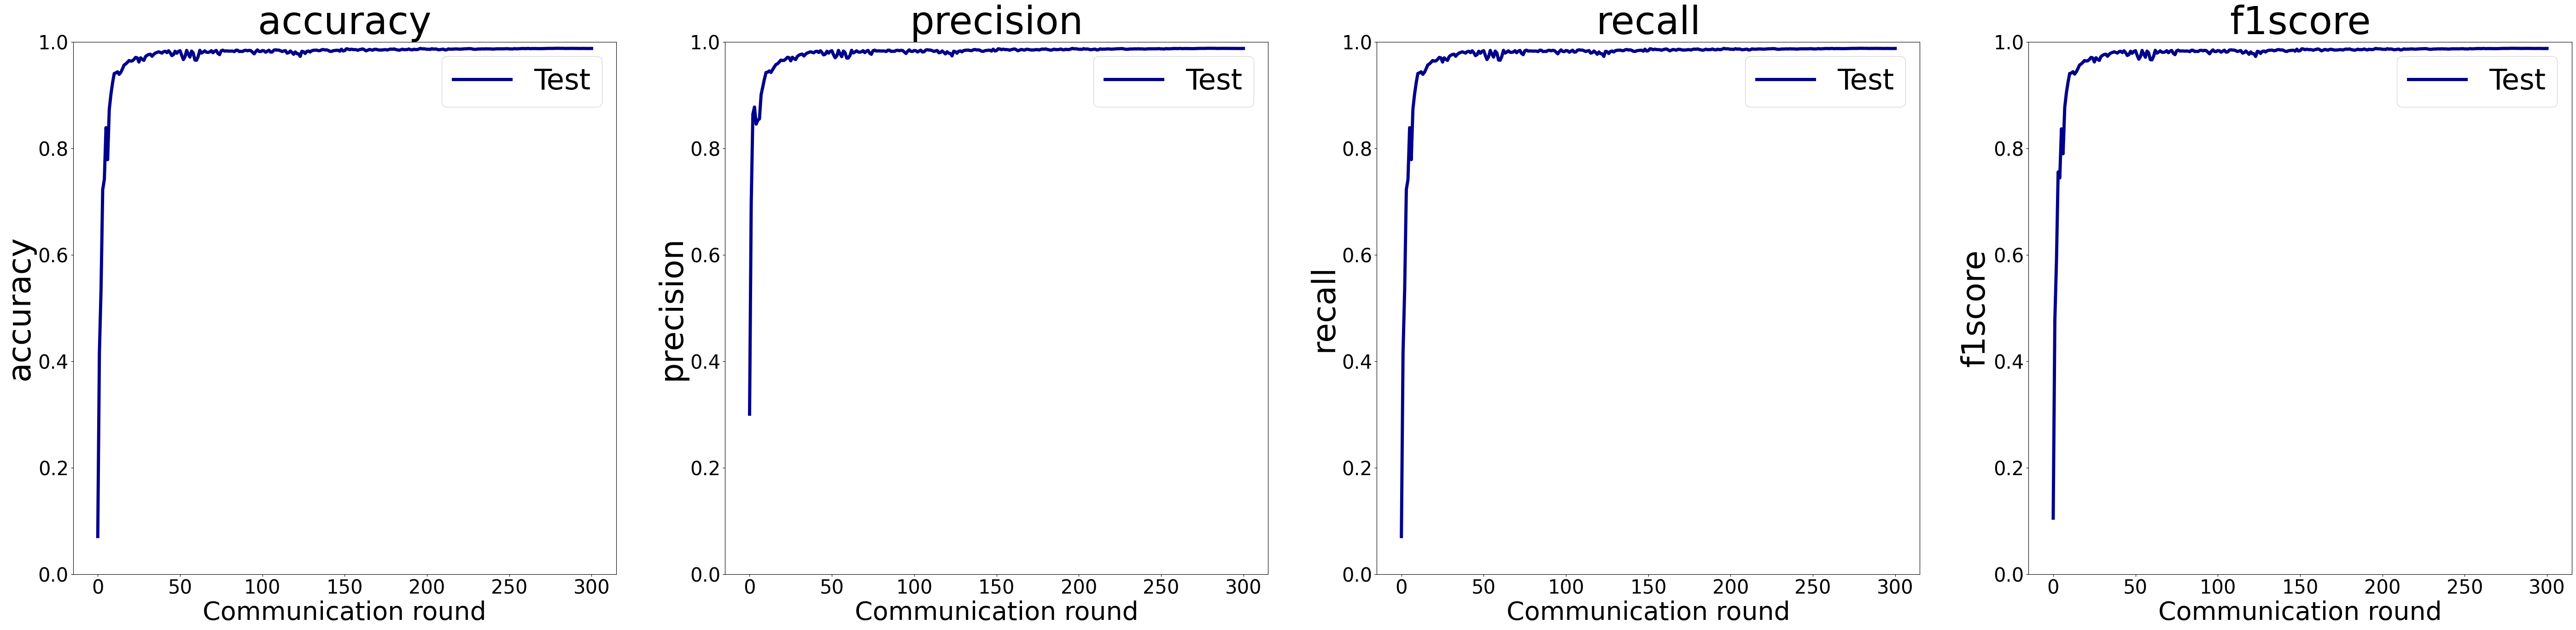

In [ ]:
# Define metrics to plot
metrics_show = ["accuracy","precision","recall","f1score"]

# Define dimensions for plot
f, axs = plt.subplots(1,len(metrics_show),figsize=(70,15))

# Loop over the communication round history and metrics
for i in range(len(metrics_show)):
  plt.subplot(1, len(metrics_show), i + 1)
  plot_metric_from_history(commun_metrics_history,"any","centralized",metrics_show[i])